In [1]:
import pandas as pd

# Load the parquet file into a DataFrame
df = pd.read_parquet('../test')
df

,user_id,merchant_abn,dollar_value,order_id,order_datetime
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28
...,...,...,...,...,...
14195500,11136,77698107389,400.792069,5e68cb94-3eab-4342-83fa-65263eff26b8,2022-10-26
14195501,11136,24852446429,5.384811,ba2ce936-ae49-4b70-a4b1-e8f8bacaefb3,2022-10-26
14195502,11136,63685007785,48.129887,a6194c61-ae7a-4037-a425-2dd7cda42fb7,2022-10-26
14195503,11137,85502310765,4.768752,72a3639e-25d5-4bcc-9e8b-26e737b8c0e4,2022-10-26


In [2]:
df = df.drop(columns=['user_id', 'order_id'])
df.dtypes

merchant_abn         int64
dollar_value       float64
order_datetime    category
dtype: object

In [3]:
# Convert order_datetime to string, then to datetime
df['order_datetime'] = pd.to_datetime(df['order_datetime'].astype(str))
df.dtypes

merchant_abn               int64
dollar_value             float64
order_datetime    datetime64[ns]
dtype: object

In [4]:
# Set order_datetime as the index
df.set_index('order_datetime', inplace=True)

# Aggregate dollar_value for each merchant for each month
weekly_aggregation = df.groupby('merchant_abn').resample('W').sum()

weekly_aggregation.drop(columns=['merchant_abn'], inplace=True)

In [5]:
weekly_aggregation


dollar_value
merchant_abn order_datetime              
10023283211  2021-02-28        701.566638
             2021-03-07       6362.419840
             2021-03-14       4706.012141
             2021-03-21       3536.843553
             2021-03-28       6796.619996
...                                   ...
99990536339  2022-09-18        586.143138
             2022-09-25          0.000000
             2022-10-02          0.000000
             2022-10-09          0.000000
             2022-10-16        578.396323

[373738 rows x 1 columns]

In [6]:
# Create a list of DataFrames, each corresponding to a unique merchant_abn
merchant_dfs = [{merchant_abn: weekly_aggregation.loc[merchant_abn].reset_index()} for merchant_abn in weekly_aggregation.index.get_level_values('merchant_abn').unique()]
merchant_dfs

[{10023283211:    order_datetime  dollar_value
  0      2021-02-28    701.566638
  1      2021-03-07   6362.419840
  2      2021-03-14   4706.012141
  3      2021-03-21   3536.843553
  4      2021-03-28   6796.619996
  ..            ...           ...
  83     2022-10-02  10731.916071
  84     2022-10-09   9379.854136
  85     2022-10-16  10905.389070
  86     2022-10-23   7739.163021
  87     2022-10-30   6434.632797
  
  [88 rows x 2 columns]},
 {10142254217:    order_datetime  dollar_value
  0      2021-02-28     10.886926
  1      2021-03-07   1138.039207
  2      2021-03-14    616.629903
  3      2021-03-21   1132.443977
  4      2021-03-28   1491.259886
  ..            ...           ...
  83     2022-10-02   1281.167336
  84     2022-10-09   2423.409637
  85     2022-10-16   1949.294210
  86     2022-10-23   2548.415792
  87     2022-10-30    719.994180
  
  [88 rows x 2 columns]},
 {10165489824:    order_datetime  dollar_value
  0      2021-12-05  20636.897020
  1      2021-12-12

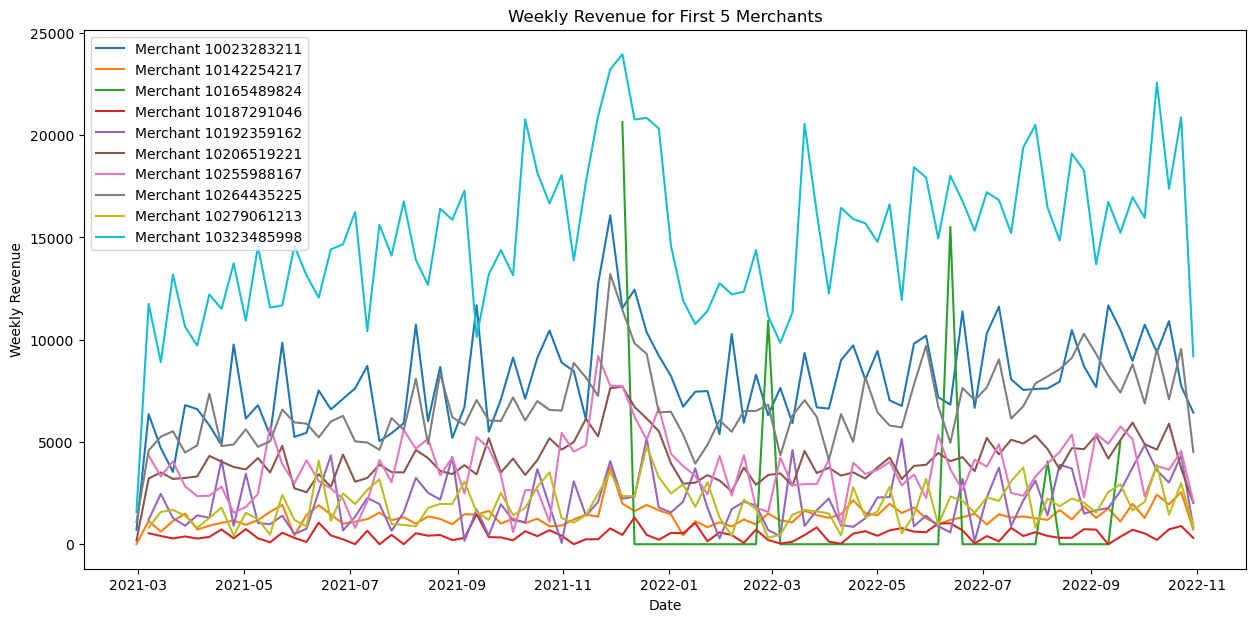

In [15]:
import matplotlib.pyplot as plt

# Plot the first 5 merchants' weekly revenue on the same plot
plt.figure(figsize=(15, 7))
for i in range(10):
    merchant_abn, df = list(merchant_dfs[i].items())[0]
    plt.plot(df['ds'], df['y'], label=f'Merchant {merchant_abn}')

plt.xlabel('Date')
plt.ylabel('Weekly Revenue')
plt.title('Weekly Revenue for First 5 Merchants')
plt.legend()
plt.show()

In [7]:
from prophet import Prophet

In [8]:
dfone = merchant_dfs[0][10023283211]
dfone

,order_datetime,dollar_value
0,2021-02-28,701.566638
1,2021-03-07,6362.419840
2,2021-03-14,4706.012141
3,2021-03-21,3536.843553
4,2021-03-28,6796.619996
...,...,...
83,2022-10-02,10731.916071
84,2022-10-09,9379.854136
85,2022-10-16,10905.389070
86,2022-10-23,7739.163021


In [11]:
dfone = merchant_dfs[0][10023283211]
dfone.rename(columns={'order_datetime': 'ds', 'dollar_value': 'y'}, inplace=True)
model = Prophet()
model.fit(dfone)

00:08:54 - cmdstanpy - INFO - Chain [1] start processing
00:08:54 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
# Initialize a dictionary to store the Prophet models and CWGR for each merchant
merchant_models = {}
merchant_cwgr = {}

# Iterate through each merchant's data in merchant_dfs
for merchant_data in merchant_dfs:
    for merchant_abn, df in merchant_data.items():
        # Prepare the data for Prophet
        df.rename(columns={'order_datetime': 'ds', 'dollar_value': 'y'}, inplace=True)
        
        # Check if the DataFrame has less than or equal to 1 entry
        if len(df) <= 1:
            print(f"Skipping Merchant {merchant_abn} due to insufficient data.")
            merchant_cwgr[merchant_abn] = 0
            continue

        # Initialize and train the Prophet model
        model = Prophet()
        print(f"Training model for Merchant {merchant_abn}...")
        model.fit(df)
        
        # Store the trained model
        merchant_models[merchant_abn] = model
        
        # Make future dataframe for prediction
        future = model.make_future_dataframe(periods=13, freq='W')
        forecast = model.predict(future)
        
        # Calculate CWGR
        initial_value = df['y'].iloc[0]
        final_value = forecast['yhat'].iloc[-1]
        weeks = len(forecast)
        cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
        
        # Store the CWGR
        merchant_cwgr[merchant_abn] = cwgr

merchant_cwgr

00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:03 - cmdstanpy - INFO - Chain [1] done processing
00:23:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 10023283211...
Training model for Merchant 10142254217...


00:23:03 - cmdstanpy - INFO - Chain [1] done processing
00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 10165489824...
Training model for Merchant 10187291046...


00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:03 - cmdstanpy - INFO - Chain [1] done processing
00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 10192359162...
Training model for Merchant 10206519221...


00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing
00:23:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 10255988167...
Training model for Merchant 10264435225...


00:23:04 - cmdstanpy - INFO - Chain [1] done processing
00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing
00:23:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 10279061213...
Training model for Merchant 10323485998...


00:23:04 - cmdstanpy - INFO - Chain [1] done processing
00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing
00:23:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 10342410215...
Training model for Merchant 10346855916...


00:23:04 - cmdstanpy - INFO - Chain [1] done processing
00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing
00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 10364012396...
Training model for Merchant 10385011947...


00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing
00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 10385163239...
Training model for Merchant 10385250025...


00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing
00:23:05 - cmdstanpy - INFO - Chain [1] start processing


Skipping Merchant 10404542215 due to insufficient data.
Training model for Merchant 10430380319...
Training model for Merchant 10441711491...


00:23:05 - cmdstanpy - INFO - Chain [1] done processing
00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing
00:23:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 10462560289...
Training model for Merchant 10463252268...


00:23:05 - cmdstanpy - INFO - Chain [1] done processing
00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing
00:23:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 10487253336...
Training model for Merchant 10530696903...


00:23:06 - cmdstanpy - INFO - Chain [1] done processing
00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing
00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 10545955006...
Training model for Merchant 10553813474...


00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing
00:23:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 10596295795...
Training model for Merchant 10618089367...


00:23:06 - cmdstanpy - INFO - Chain [1] done processing
00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing
00:23:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 10648956813...
Training model for Merchant 10651113986...


00:23:07 - cmdstanpy - INFO - Chain [1] done processing
00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:07 - cmdstanpy - INFO - Chain [1] done processing
00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:07 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 10672322914...
Training model for Merchant 10702078694...


00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:07 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 10714068705...


00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:07 - cmdstanpy - INFO - Chain [1] done processing
00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:07 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 10739268011...
Training model for Merchant 10746056613...


00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:07 - cmdstanpy - INFO - Chain [1] done processing
00:23:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 10848766800...
Training model for Merchant 10854978569...


00:23:08 - cmdstanpy - INFO - Chain [1] done processing
00:23:08 - cmdstanpy - INFO - Chain [1] start processing
00:23:08 - cmdstanpy - INFO - Chain [1] done processing
00:23:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 10860706939...
Training model for Merchant 10881038707...


00:23:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:23:08 - cmdstanpy - INFO - Chain [1] start processing
00:23:08 - cmdstanpy - INFO - Chain [1] done processing
00:23:08 - cmdstanpy - INFO - Chain [1] start processing
00:23:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 10901349044...
Training model for Merchant 10922217544...


00:23:08 - cmdstanpy - INFO - Chain [1] start processing
00:23:08 - cmdstanpy - INFO - Chain [1] done processing
00:23:08 - cmdstanpy - INFO - Chain [1] start processing
00:23:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 10930486968...
Training model for Merchant 10945019164...


00:23:08 - cmdstanpy - INFO - Chain [1] start processing
00:23:08 - cmdstanpy - INFO - Chain [1] done processing
00:23:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 10955677986...
Training model for Merchant 10959028715...


00:23:09 - cmdstanpy - INFO - Chain [1] done processing
00:23:09 - cmdstanpy - INFO - Chain [1] start processing
00:23:09 - cmdstanpy - INFO - Chain [1] done processing
00:23:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 10995883576...
Training model for Merchant 11017796471...


00:23:09 - cmdstanpy - INFO - Chain [1] done processing
00:23:09 - cmdstanpy - INFO - Chain [1] start processing
00:23:09 - cmdstanpy - INFO - Chain [1] done processing
00:23:09 - cmdstanpy - INFO - Chain [1] start processing
00:23:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 11024352823...
Training model for Merchant 11029341140...


00:23:09 - cmdstanpy - INFO - Chain [1] start processing
00:23:09 - cmdstanpy - INFO - Chain [1] done processing
00:23:09 - cmdstanpy - INFO - Chain [1] start processing
00:23:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 11076688542...
Training model for Merchant 11089768124...


00:23:10 - cmdstanpy - INFO - Chain [1] start processing
00:23:10 - cmdstanpy - INFO - Chain [1] done processing
00:23:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11093673306...
Training model for Merchant 11121775571...


00:23:10 - cmdstanpy - INFO - Chain [1] done processing
00:23:10 - cmdstanpy - INFO - Chain [1] start processing
00:23:10 - cmdstanpy - INFO - Chain [1] done processing
00:23:10 - cmdstanpy - INFO - Chain [1] start processing
00:23:10 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 11134994590...
Training model for Merchant 11137507330...


00:23:10 - cmdstanpy - INFO - Chain [1] start processing
00:23:10 - cmdstanpy - INFO - Chain [1] done processing
00:23:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11149063370...
Training model for Merchant 11173270682...


00:23:10 - cmdstanpy - INFO - Chain [1] done processing
00:23:10 - cmdstanpy - INFO - Chain [1] start processing
00:23:10 - cmdstanpy - INFO - Chain [1] done processing
00:23:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11199348915...
Training model for Merchant 11208869091...


00:23:11 - cmdstanpy - INFO - Chain [1] done processing
00:23:11 - cmdstanpy - INFO - Chain [1] start processing
00:23:11 - cmdstanpy - INFO - Chain [1] done processing
00:23:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11215815177...
Training model for Merchant 11237511112...


00:23:11 - cmdstanpy - INFO - Chain [1] done processing
00:23:11 - cmdstanpy - INFO - Chain [1] start processing
00:23:11 - cmdstanpy - INFO - Chain [1] done processing
00:23:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11240426404...
Training model for Merchant 11243046390...


00:23:11 - cmdstanpy - INFO - Chain [1] done processing
00:23:11 - cmdstanpy - INFO - Chain [1] start processing
00:23:11 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 11285988014...


00:23:11 - cmdstanpy - INFO - Chain [1] start processing
00:23:12 - cmdstanpy - INFO - Chain [1] done processing
00:23:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11304124014...
Training model for Merchant 11355018654...


00:23:12 - cmdstanpy - INFO - Chain [1] done processing
00:23:12 - cmdstanpy - INFO - Chain [1] start processing
00:23:12 - cmdstanpy - INFO - Chain [1] done processing
00:23:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11358147682...
Training model for Merchant 11400713351...


00:23:12 - cmdstanpy - INFO - Chain [1] done processing
00:23:12 - cmdstanpy - INFO - Chain [1] start processing
00:23:12 - cmdstanpy - INFO - Chain [1] done processing
00:23:12 - cmdstanpy - INFO - Chain [1] start processing
00:23:12 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 11411018019...
Training model for Merchant 11422053652...


00:23:12 - cmdstanpy - INFO - Chain [1] start processing
00:23:12 - cmdstanpy - INFO - Chain [1] done processing
00:23:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11422618712...
Training model for Merchant 11437621158...


00:23:13 - cmdstanpy - INFO - Chain [1] done processing
00:23:13 - cmdstanpy - INFO - Chain [1] start processing
00:23:13 - cmdstanpy - INFO - Chain [1] done processing
00:23:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11439466003...
Training model for Merchant 11452293720...


00:23:13 - cmdstanpy - INFO - Chain [1] done processing
00:23:13 - cmdstanpy - INFO - Chain [1] start processing
00:23:13 - cmdstanpy - INFO - Chain [1] done processing
00:23:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11470993597...
Training model for Merchant 11563852275...


00:23:13 - cmdstanpy - INFO - Chain [1] done processing
00:23:13 - cmdstanpy - INFO - Chain [1] start processing
00:23:13 - cmdstanpy - INFO - Chain [1] done processing
00:23:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11566786699...
Training model for Merchant 11588046517...


00:23:13 - cmdstanpy - INFO - Chain [1] done processing
00:23:13 - cmdstanpy - INFO - Chain [1] start processing
00:23:14 - cmdstanpy - INFO - Chain [1] done processing
00:23:14 - cmdstanpy - INFO - Chain [1] start processing
00:23:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 11590404675...
Training model for Merchant 11633090957...


00:23:14 - cmdstanpy - INFO - Chain [1] start processing
00:23:14 - cmdstanpy - INFO - Chain [1] done processing
00:23:14 - cmdstanpy - INFO - Chain [1] start processing
00:23:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 11700214701...
Training model for Merchant 11766327188...


00:23:14 - cmdstanpy - INFO - Chain [1] start processing
00:23:14 - cmdstanpy - INFO - Chain [1] done processing
00:23:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11788487195...
Training model for Merchant 11791943985...


00:23:14 - cmdstanpy - INFO - Chain [1] done processing
00:23:14 - cmdstanpy - INFO - Chain [1] start processing
00:23:14 - cmdstanpy - INFO - Chain [1] done processing
00:23:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11800043583...
Training model for Merchant 11802512399...


00:23:14 - cmdstanpy - INFO - Chain [1] done processing
00:23:15 - cmdstanpy - INFO - Chain [1] start processing
00:23:15 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 11839682616...
Training model for Merchant 11841065357...


00:23:15 - cmdstanpy - INFO - Chain [1] start processing
00:23:15 - cmdstanpy - INFO - Chain [1] done processing
00:23:15 - cmdstanpy - INFO - Chain [1] start processing
00:23:15 - cmdstanpy - INFO - Chain [1] done processing
00:23:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11848576000...
Training model for Merchant 11895748930...


00:23:15 - cmdstanpy - INFO - Chain [1] done processing
00:23:15 - cmdstanpy - INFO - Chain [1] start processing
00:23:15 - cmdstanpy - INFO - Chain [1] done processing
00:23:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11944993446...
Training model for Merchant 11961681734...


00:23:15 - cmdstanpy - INFO - Chain [1] done processing
00:23:16 - cmdstanpy - INFO - Chain [1] start processing
00:23:16 - cmdstanpy - INFO - Chain [1] done processing
00:23:16 - cmdstanpy - INFO - Chain [1] start processing
00:23:16 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 11974270529...
Training model for Merchant 11975295389...


00:23:16 - cmdstanpy - INFO - Chain [1] start processing
00:23:16 - cmdstanpy - INFO - Chain [1] done processing
00:23:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 11981237946...
Training model for Merchant 12014115545...


00:23:16 - cmdstanpy - INFO - Chain [1] done processing
00:23:16 - cmdstanpy - INFO - Chain [1] start processing
00:23:16 - cmdstanpy - INFO - Chain [1] done processing
00:23:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 12031655138...
Training model for Merchant 12034469787...


00:23:16 - cmdstanpy - INFO - Chain [1] done processing
00:23:16 - cmdstanpy - INFO - Chain [1] start processing
00:23:16 - cmdstanpy - INFO - Chain [1] done processing
00:23:17 - cmdstanpy - INFO - Chain [1] start processing
00:23:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 12037481016...
Training model for Merchant 12042198256...


00:23:17 - cmdstanpy - INFO - Chain [1] start processing
00:23:17 - cmdstanpy - INFO - Chain [1] done processing
00:23:17 - cmdstanpy - INFO - Chain [1] start processing
00:23:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 12103450178...
Training model for Merchant 12133839110...


00:23:17 - cmdstanpy - INFO - Chain [1] start processing
00:23:17 - cmdstanpy - INFO - Chain [1] done processing
00:23:17 - cmdstanpy - INFO - Chain [1] start processing
00:23:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 12161076724...
Training model for Merchant 12171241826...


00:23:17 - cmdstanpy - INFO - Chain [1] start processing
00:23:17 - cmdstanpy - INFO - Chain [1] done processing
00:23:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 12173100693...
Training model for Merchant 12182018430...


00:23:17 - cmdstanpy - INFO - Chain [1] done processing
00:23:18 - cmdstanpy - INFO - Chain [1] start processing
00:23:18 - cmdstanpy - INFO - Chain [1] done processing
00:23:18 - cmdstanpy - INFO - Chain [1] start processing
00:23:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 12183270048...
Training model for Merchant 12185659961...


00:23:18 - cmdstanpy - INFO - Chain [1] start processing
00:23:18 - cmdstanpy - INFO - Chain [1] done processing
00:23:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 12208064492...
Training model for Merchant 12219088747...


00:23:18 - cmdstanpy - INFO - Chain [1] done processing
00:23:18 - cmdstanpy - INFO - Chain [1] start processing
00:23:18 - cmdstanpy - INFO - Chain [1] done processing
00:23:18 - cmdstanpy - INFO - Chain [1] start processing
00:23:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 12240378188...
Training model for Merchant 12296390138...


00:23:18 - cmdstanpy - INFO - Chain [1] start processing
00:23:18 - cmdstanpy - INFO - Chain [1] done processing
00:23:18 - cmdstanpy - INFO - Chain [1] start processing
00:23:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 12353567572...
Training model for Merchant 12374632228...


00:23:19 - cmdstanpy - INFO - Chain [1] start processing
00:23:19 - cmdstanpy - INFO - Chain [1] done processing
00:23:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 12380299397...
Training model for Merchant 12395011633...


00:23:19 - cmdstanpy - INFO - Chain [1] done processing
00:23:19 - cmdstanpy - INFO - Chain [1] start processing
00:23:19 - cmdstanpy - INFO - Chain [1] done processing
00:23:19 - cmdstanpy - INFO - Chain [1] start processing
00:23:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 12404803031...
Training model for Merchant 12426913844...


00:23:19 - cmdstanpy - INFO - Chain [1] start processing
00:23:19 - cmdstanpy - INFO - Chain [1] done processing
00:23:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 12434006854...
Training model for Merchant 12438697459...


00:23:19 - cmdstanpy - INFO - Chain [1] done processing
00:23:19 - cmdstanpy - INFO - Chain [1] start processing
00:23:20 - cmdstanpy - INFO - Chain [1] done processing
00:23:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 12476477880...
Training model for Merchant 12483082042...


00:23:20 - cmdstanpy - INFO - Chain [1] done processing
00:23:20 - cmdstanpy - INFO - Chain [1] start processing
00:23:20 - cmdstanpy - INFO - Chain [1] done processing
00:23:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 12497320096...
Training model for Merchant 12513701055...


00:23:20 - cmdstanpy - INFO - Chain [1] done processing
00:23:20 - cmdstanpy - INFO - Chain [1] start processing
00:23:20 - cmdstanpy - INFO - Chain [1] done processing
00:23:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 12516851436...
Training model for Merchant 12543580354...


00:23:20 - cmdstanpy - INFO - Chain [1] done processing
00:23:20 - cmdstanpy - INFO - Chain [1] start processing
00:23:20 - cmdstanpy - INFO - Chain [1] done processing
00:23:20 - cmdstanpy - INFO - Chain [1] start processing
00:23:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 12578813079...
Training model for Merchant 12710873213...


00:23:21 - cmdstanpy - INFO - Chain [1] start processing
00:23:21 - cmdstanpy - INFO - Chain [1] done processing
00:23:21 - cmdstanpy - INFO - Chain [1] start processing
00:23:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 12711807314...
Training model for Merchant 12741443840...


00:23:21 - cmdstanpy - INFO - Chain [1] start processing
00:23:21 - cmdstanpy - INFO - Chain [1] done processing
00:23:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 12771097467...
Training model for Merchant 12840456630...


00:23:21 - cmdstanpy - INFO - Chain [1] done processing
00:23:21 - cmdstanpy - INFO - Chain [1] start processing
00:23:21 - cmdstanpy - INFO - Chain [1] done processing
00:23:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 12847992240...
Training model for Merchant 12870663624...


00:23:21 - cmdstanpy - INFO - Chain [1] done processing
00:23:21 - cmdstanpy - INFO - Chain [1] start processing
00:23:22 - cmdstanpy - INFO - Chain [1] done processing
00:23:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 12888399565...
Training model for Merchant 12899341959...


00:23:22 - cmdstanpy - INFO - Chain [1] done processing
00:23:22 - cmdstanpy - INFO - Chain [1] start processing
00:23:22 - cmdstanpy - INFO - Chain [1] done processing
00:23:22 - cmdstanpy - INFO - Chain [1] start processing
00:23:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 12927607277...
Training model for Merchant 12959550150...


00:23:22 - cmdstanpy - INFO - Chain [1] start processing
00:23:22 - cmdstanpy - INFO - Chain [1] done processing
00:23:22 - cmdstanpy - INFO - Chain [1] start processing
00:23:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 12959561070...
Training model for Merchant 12983555508...


00:23:22 - cmdstanpy - INFO - Chain [1] start processing
00:23:22 - cmdstanpy - INFO - Chain [1] done processing
00:23:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13041890826...
Training model for Merchant 13061606045...


00:23:23 - cmdstanpy - INFO - Chain [1] done processing
00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:23 - cmdstanpy - INFO - Chain [1] done processing
00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:23 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13066244467...
Training model for Merchant 13067850740...


00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:23 - cmdstanpy - INFO - Chain [1] done processing
00:23:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13086571368...
Training model for Merchant 13093581573...


00:23:23 - cmdstanpy - INFO - Chain [1] done processing
00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:23 - cmdstanpy - INFO - Chain [1] done processing
00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:23 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13103397121...
Training model for Merchant 13106608471...


00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing
00:23:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13108046922...
Training model for Merchant 13118172970...


00:23:24 - cmdstanpy - INFO - Chain [1] done processing
00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing
00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13120157976...
Training model for Merchant 13129485817...


00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing
00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13136513766...
Training model for Merchant 13159730941...


00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing
00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13177076095...
Training model for Merchant 13226823813...


00:23:25 - cmdstanpy - INFO - Chain [1] start processing
00:23:25 - cmdstanpy - INFO - Chain [1] done processing
00:23:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13248824465...
Training model for Merchant 13255205539...


00:23:25 - cmdstanpy - INFO - Chain [1] done processing
00:23:25 - cmdstanpy - INFO - Chain [1] start processing
00:23:25 - cmdstanpy - INFO - Chain [1] done processing
00:23:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13272374672...
Training model for Merchant 13285958344...


00:23:25 - cmdstanpy - INFO - Chain [1] done processing
00:23:25 - cmdstanpy - INFO - Chain [1] start processing
00:23:25 - cmdstanpy - INFO - Chain [1] done processing
00:23:25 - cmdstanpy - INFO - Chain [1] start processing
00:23:25 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13289167958...
Training model for Merchant 13290952071...


00:23:25 - cmdstanpy - INFO - Chain [1] start processing
00:23:26 - cmdstanpy - INFO - Chain [1] done processing
00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13297955415...
Training model for Merchant 13376463476...


00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:26 - cmdstanpy - INFO - Chain [1] done processing
00:23:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13401263605...
Training model for Merchant 13447011295...


00:23:26 - cmdstanpy - INFO - Chain [1] done processing
00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:26 - cmdstanpy - INFO - Chain [1] done processing
00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13447019122...
Training model for Merchant 13461552885...


00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:26 - cmdstanpy - INFO - Chain [1] done processing
00:23:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13467303030...
Training model for Merchant 13473158710...


00:23:27 - cmdstanpy - INFO - Chain [1] done processing
00:23:27 - cmdstanpy - INFO - Chain [1] start processing
00:23:27 - cmdstanpy - INFO - Chain [1] done processing
00:23:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13494073581...
Training model for Merchant 13514558491...


00:23:27 - cmdstanpy - INFO - Chain [1] done processing
00:23:27 - cmdstanpy - INFO - Chain [1] start processing
00:23:27 - cmdstanpy - INFO - Chain [1] done processing
00:23:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13555086357...
Training model for Merchant 13565102775...


00:23:27 - cmdstanpy - INFO - Chain [1] done processing
00:23:27 - cmdstanpy - INFO - Chain [1] start processing
00:23:27 - cmdstanpy - INFO - Chain [1] done processing
00:23:27 - cmdstanpy - INFO - Chain [1] start processing
00:23:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13571059405...
Training model for Merchant 13606543798...


00:23:27 - cmdstanpy - INFO - Chain [1] start processing
00:23:28 - cmdstanpy - INFO - Chain [1] done processing
00:23:28 - cmdstanpy - INFO - Chain [1] start processing
00:23:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13611382586...
Training model for Merchant 13631004035...


00:23:28 - cmdstanpy - INFO - Chain [1] start processing
00:23:28 - cmdstanpy - INFO - Chain [1] done processing
00:23:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13663374533...
Training model for Merchant 13747603419...


00:23:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:23:28 - cmdstanpy - INFO - Chain [1] start processing
00:23:28 - cmdstanpy - INFO - Chain [1] done processing
00:23:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13770392625...
Training model for Merchant 13803154777...


00:23:28 - cmdstanpy - INFO - Chain [1] done processing
00:23:28 - cmdstanpy - INFO - Chain [1] start processing
00:23:28 - cmdstanpy - INFO - Chain [1] done processing
00:23:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13812221471...
Training model for Merchant 13822969155...


00:23:29 - cmdstanpy - INFO - Chain [1] done processing
00:23:29 - cmdstanpy - INFO - Chain [1] start processing
00:23:29 - cmdstanpy - INFO - Chain [1] done processing
00:23:29 - cmdstanpy - INFO - Chain [1] start processing
00:23:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13823979247...
Training model for Merchant 13830448327...


00:23:29 - cmdstanpy - INFO - Chain [1] start processing
00:23:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13839274306...


00:23:29 - cmdstanpy - INFO - Chain [1] start processing
00:23:29 - cmdstanpy - INFO - Chain [1] done processing
00:23:29 - cmdstanpy - INFO - Chain [1] start processing
00:23:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13868849576...
Training model for Merchant 13900607417...


00:23:29 - cmdstanpy - INFO - Chain [1] start processing
00:23:29 - cmdstanpy - INFO - Chain [1] done processing
00:23:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 13902377680...
Training model for Merchant 13917288638...


00:23:30 - cmdstanpy - INFO - Chain [1] done processing
00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing
00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13942467372...
Training model for Merchant 13945345356...


00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing
00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 13986396343...
Training model for Merchant 14004773634...


00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing
00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 14040735315...
Training model for Merchant 14042321810...


00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:31 - cmdstanpy - INFO - Chain [1] done processing
00:23:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 14058755389...
Training model for Merchant 14081759429...


00:23:31 - cmdstanpy - INFO - Chain [1] done processing
00:23:31 - cmdstanpy - INFO - Chain [1] start processing
00:23:31 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 14089706307...
Training model for Merchant 14145464079...


00:23:31 - cmdstanpy - INFO - Chain [1] start processing
00:23:31 - cmdstanpy - INFO - Chain [1] done processing
00:23:31 - cmdstanpy - INFO - Chain [1] start processing
00:23:31 - cmdstanpy - INFO - Chain [1] done processing
00:23:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 14148282104...
Training model for Merchant 14246432250...


00:23:31 - cmdstanpy - INFO - Chain [1] done processing
00:23:31 - cmdstanpy - INFO - Chain [1] start processing
00:23:31 - cmdstanpy - INFO - Chain [1] done processing
00:23:32 - cmdstanpy - INFO - Chain [1] start processing
00:23:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 14278929774...
Training model for Merchant 14314268730...


00:23:32 - cmdstanpy - INFO - Chain [1] start processing
00:23:32 - cmdstanpy - INFO - Chain [1] done processing
00:23:32 - cmdstanpy - INFO - Chain [1] start processing
00:23:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 14315147591...
Training model for Merchant 14316652139...


00:23:32 - cmdstanpy - INFO - Chain [1] start processing
00:23:32 - cmdstanpy - INFO - Chain [1] done processing
00:23:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 14336275166...
Training model for Merchant 14420598156...


00:23:32 - cmdstanpy - INFO - Chain [1] done processing
00:23:32 - cmdstanpy - INFO - Chain [1] start processing
00:23:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 14430838529...
Training model for Merchant 14443753481...


00:23:32 - cmdstanpy - INFO - Chain [1] start processing
00:23:32 - cmdstanpy - INFO - Chain [1] done processing
00:23:33 - cmdstanpy - INFO - Chain [1] start processing
00:23:33 - cmdstanpy - INFO - Chain [1] done processing
00:23:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 14480530534...
Training model for Merchant 14492521225...


00:23:33 - cmdstanpy - INFO - Chain [1] done processing
00:23:33 - cmdstanpy - INFO - Chain [1] start processing
00:23:33 - cmdstanpy - INFO - Chain [1] done processing
00:23:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 14522297874...
Training model for Merchant 14530561097...


00:23:33 - cmdstanpy - INFO - Chain [1] done processing
00:23:33 - cmdstanpy - INFO - Chain [1] start processing
00:23:33 - cmdstanpy - INFO - Chain [1] done processing
00:23:33 - cmdstanpy - INFO - Chain [1] start processing
00:23:33 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 14555045817...
Training model for Merchant 14559784311...


00:23:33 - cmdstanpy - INFO - Chain [1] start processing
00:23:34 - cmdstanpy - INFO - Chain [1] done processing
00:23:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 14570580767...
Training model for Merchant 14583462783...


00:23:34 - cmdstanpy - INFO - Chain [1] done processing
00:23:34 - cmdstanpy - INFO - Chain [1] start processing
00:23:34 - cmdstanpy - INFO - Chain [1] done processing
00:23:34 - cmdstanpy - INFO - Chain [1] start processing
00:23:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 14602793938...
Training model for Merchant 14616123867...


00:23:34 - cmdstanpy - INFO - Chain [1] start processing
00:23:34 - cmdstanpy - INFO - Chain [1] done processing
00:23:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 14626521979...
Training model for Merchant 14639241847...


00:23:34 - cmdstanpy - INFO - Chain [1] done processing
00:23:34 - cmdstanpy - INFO - Chain [1] start processing
00:23:34 - cmdstanpy - INFO - Chain [1] done processing
00:23:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 14639489823...
Training model for Merchant 14666015798...


00:23:34 - cmdstanpy - INFO - Chain [1] done processing
00:23:35 - cmdstanpy - INFO - Chain [1] start processing
00:23:35 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 14675858680...


00:23:35 - cmdstanpy - INFO - Chain [1] start processing
00:23:35 - cmdstanpy - INFO - Chain [1] done processing
00:23:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 14762929642...
Training model for Merchant 14796275705...


00:23:35 - cmdstanpy - INFO - Chain [1] done processing
00:23:35 - cmdstanpy - INFO - Chain [1] start processing
00:23:35 - cmdstanpy - INFO - Chain [1] done processing
00:23:35 - cmdstanpy - INFO - Chain [1] start processing
00:23:35 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 14804580099...
Training model for Merchant 14809247463...


00:23:35 - cmdstanpy - INFO - Chain [1] start processing
00:23:35 - cmdstanpy - INFO - Chain [1] done processing
00:23:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 14820207872...
Training model for Merchant 14827550074...


00:23:36 - cmdstanpy - INFO - Chain [1] done processing
00:23:36 - cmdstanpy - INFO - Chain [1] start processing
00:23:36 - cmdstanpy - INFO - Chain [1] done processing
00:23:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 14878918457...
Training model for Merchant 14939466370...


00:23:36 - cmdstanpy - INFO - Chain [1] done processing
00:23:36 - cmdstanpy - INFO - Chain [1] start processing
00:23:36 - cmdstanpy - INFO - Chain [1] done processing
00:23:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 14955471775...
Training model for Merchant 14961279222...


00:23:36 - cmdstanpy - INFO - Chain [1] done processing
00:23:36 - cmdstanpy - INFO - Chain [1] start processing
00:23:36 - cmdstanpy - INFO - Chain [1] done processing
00:23:36 - cmdstanpy - INFO - Chain [1] start processing
00:23:36 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 14965232967...
Training model for Merchant 15010840269...


00:23:37 - cmdstanpy - INFO - Chain [1] start processing
00:23:37 - cmdstanpy - INFO - Chain [1] done processing
00:23:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15043504837...
Training model for Merchant 15058508937...


00:23:37 - cmdstanpy - INFO - Chain [1] done processing
00:23:37 - cmdstanpy - INFO - Chain [1] start processing
00:23:37 - cmdstanpy - INFO - Chain [1] done processing
00:23:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15061716544...
Training model for Merchant 15069598461...


00:23:37 - cmdstanpy - INFO - Chain [1] done processing
00:23:37 - cmdstanpy - INFO - Chain [1] start processing
00:23:37 - cmdstanpy - INFO - Chain [1] done processing
00:23:37 - cmdstanpy - INFO - Chain [1] start processing
00:23:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 15070005651...
Training model for Merchant 15073534664...


00:23:37 - cmdstanpy - INFO - Chain [1] start processing
00:23:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:23:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15073921424...
Training model for Merchant 15093767253...


00:23:38 - cmdstanpy - INFO - Chain [1] done processing
00:23:38 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing
00:23:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15115332331...
Training model for Merchant 15130143460...


00:23:38 - cmdstanpy - INFO - Chain [1] done processing
00:23:38 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing
00:23:38 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 15135045968...
Training model for Merchant 15157368385...


00:23:38 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing
00:23:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15253672771...
Training model for Merchant 15269431008...


00:23:38 - cmdstanpy - INFO - Chain [1] done processing
00:23:39 - cmdstanpy - INFO - Chain [1] start processing
00:23:39 - cmdstanpy - INFO - Chain [1] done processing
00:23:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15293888435...
Training model for Merchant 15297597516...


00:23:39 - cmdstanpy - INFO - Chain [1] done processing
00:23:39 - cmdstanpy - INFO - Chain [1] start processing
00:23:39 - cmdstanpy - INFO - Chain [1] done processing
00:23:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15299889494...
Training model for Merchant 15302620892...


00:23:39 - cmdstanpy - INFO - Chain [1] done processing
00:23:39 - cmdstanpy - INFO - Chain [1] start processing
00:23:39 - cmdstanpy - INFO - Chain [1] done processing
00:23:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15332026424...
Training model for Merchant 15347709593...


00:23:39 - cmdstanpy - INFO - Chain [1] done processing
00:23:40 - cmdstanpy - INFO - Chain [1] start processing
00:23:40 - cmdstanpy - INFO - Chain [1] done processing
00:23:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15353137412...
Training model for Merchant 15359085759...


00:23:40 - cmdstanpy - INFO - Chain [1] done processing
00:23:40 - cmdstanpy - INFO - Chain [1] start processing
00:23:40 - cmdstanpy - INFO - Chain [1] done processing
00:23:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15367144876...
Training model for Merchant 15422452671...


00:23:40 - cmdstanpy - INFO - Chain [1] done processing
00:23:40 - cmdstanpy - INFO - Chain [1] start processing
00:23:40 - cmdstanpy - INFO - Chain [1] done processing
00:23:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15441635442...
Training model for Merchant 15446964877...


00:23:40 - cmdstanpy - INFO - Chain [1] done processing
00:23:41 - cmdstanpy - INFO - Chain [1] start processing
00:23:41 - cmdstanpy - INFO - Chain [1] done processing
00:23:41 - cmdstanpy - INFO - Chain [1] start processing
00:23:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 15457638036...
Training model for Merchant 15489539819...


00:23:41 - cmdstanpy - INFO - Chain [1] start processing
00:23:41 - cmdstanpy - INFO - Chain [1] done processing
00:23:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15514494276...
Training model for Merchant 15527324674...


00:23:41 - cmdstanpy - INFO - Chain [1] done processing
00:23:41 - cmdstanpy - INFO - Chain [1] start processing
00:23:41 - cmdstanpy - INFO - Chain [1] done processing
00:23:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15531408565...
Training model for Merchant 15544195408...


00:23:41 - cmdstanpy - INFO - Chain [1] done processing
00:23:41 - cmdstanpy - INFO - Chain [1] start processing
00:23:41 - cmdstanpy - INFO - Chain [1] done processing
00:23:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15549624934...
Training model for Merchant 15560455575...


00:23:42 - cmdstanpy - INFO - Chain [1] done processing
00:23:42 - cmdstanpy - INFO - Chain [1] start processing
00:23:42 - cmdstanpy - INFO - Chain [1] done processing
00:23:42 - cmdstanpy - INFO - Chain [1] start processing
00:23:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 15577036924...
Training model for Merchant 15582356843...


00:23:42 - cmdstanpy - INFO - Chain [1] start processing
00:23:42 - cmdstanpy - INFO - Chain [1] done processing
00:23:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15582655078...
Training model for Merchant 15612785317...


00:23:42 - cmdstanpy - INFO - Chain [1] done processing
00:23:42 - cmdstanpy - INFO - Chain [1] start processing
00:23:42 - cmdstanpy - INFO - Chain [1] done processing
00:23:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15613631617...
Training model for Merchant 15625166573...


00:23:43 - cmdstanpy - INFO - Chain [1] done processing
00:23:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:43 - cmdstanpy - INFO - Chain [1] done processing
00:23:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15686458582...
Training model for Merchant 15699401518...


00:23:43 - cmdstanpy - INFO - Chain [1] done processing
00:23:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:43 - cmdstanpy - INFO - Chain [1] done processing
00:23:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15700338102...
Training model for Merchant 15704713883...


00:23:43 - cmdstanpy - INFO - Chain [1] done processing
00:23:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:43 - cmdstanpy - INFO - Chain [1] done processing
00:23:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15710208349...
Training model for Merchant 15790540567...


00:23:43 - cmdstanpy - INFO - Chain [1] done processing
00:23:44 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing
00:23:44 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 15795298692...
Training model for Merchant 15862090061...


00:23:44 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing
00:23:44 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 15870230869...
Training model for Merchant 15896837295...


00:23:44 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing
00:23:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15903176024...
Training model for Merchant 15912561882...


00:23:44 - cmdstanpy - INFO - Chain [1] done processing
00:23:44 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing
00:23:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 15937271532...
Training model for Merchant 15965199256...


00:23:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:45 - cmdstanpy - INFO - Chain [1] done processing
00:23:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 15971734188...
Training model for Merchant 15998215727...


00:23:45 - cmdstanpy - INFO - Chain [1] done processing
00:23:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:45 - cmdstanpy - INFO - Chain [1] done processing
00:23:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 16002602393...
Training model for Merchant 16019856141...


00:23:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:45 - cmdstanpy - INFO - Chain [1] done processing
00:23:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16058191622...
Training model for Merchant 16096277862...


00:23:45 - cmdstanpy - INFO - Chain [1] done processing
00:23:46 - cmdstanpy - INFO - Chain [1] start processing
00:23:46 - cmdstanpy - INFO - Chain [1] done processing
00:23:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16104218122...
Training model for Merchant 16119907679...


00:23:46 - cmdstanpy - INFO - Chain [1] done processing
00:23:46 - cmdstanpy - INFO - Chain [1] start processing
00:23:46 - cmdstanpy - INFO - Chain [1] done processing
00:23:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16143938351...
Training model for Merchant 16156289887...


00:23:46 - cmdstanpy - INFO - Chain [1] done processing
00:23:46 - cmdstanpy - INFO - Chain [1] start processing
00:23:46 - cmdstanpy - INFO - Chain [1] done processing
00:23:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16165222459...
Training model for Merchant 16174402479...


00:23:46 - cmdstanpy - INFO - Chain [1] done processing
00:23:46 - cmdstanpy - INFO - Chain [1] start processing
00:23:47 - cmdstanpy - INFO - Chain [1] done processing
00:23:47 - cmdstanpy - INFO - Chain [1] start processing
00:23:47 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 16178821827...
Training model for Merchant 16199101110...


00:23:47 - cmdstanpy - INFO - Chain [1] start processing
00:23:47 - cmdstanpy - INFO - Chain [1] done processing
00:23:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16218917521...
Training model for Merchant 16242364669...


00:23:47 - cmdstanpy - INFO - Chain [1] done processing
00:23:47 - cmdstanpy - INFO - Chain [1] start processing
00:23:47 - cmdstanpy - INFO - Chain [1] done processing
00:23:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16248082282...
Training model for Merchant 16254418652...


00:23:47 - cmdstanpy - INFO - Chain [1] done processing
00:23:47 - cmdstanpy - INFO - Chain [1] start processing
00:23:48 - cmdstanpy - INFO - Chain [1] done processing
00:23:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16256895427...
Training model for Merchant 16286338734...


00:23:48 - cmdstanpy - INFO - Chain [1] done processing
00:23:48 - cmdstanpy - INFO - Chain [1] start processing
00:23:48 - cmdstanpy - INFO - Chain [1] done processing
00:23:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16288327194...
Training model for Merchant 16315736437...


00:23:48 - cmdstanpy - INFO - Chain [1] done processing
00:23:48 - cmdstanpy - INFO - Chain [1] start processing
00:23:48 - cmdstanpy - INFO - Chain [1] done processing
00:23:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16334864366...
Training model for Merchant 16361981729...


00:23:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:23:48 - cmdstanpy - INFO - Chain [1] start processing
00:23:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:23:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16377211887...
Training model for Merchant 16388802220...


00:23:49 - cmdstanpy - INFO - Chain [1] done processing
00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:49 - cmdstanpy - INFO - Chain [1] done processing
00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:49 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 16394504716...
Training model for Merchant 16404532871...


00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:49 - cmdstanpy - INFO - Chain [1] done processing
00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:49 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 16423528990...
Training model for Merchant 16432242544...


00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:49 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 16452078130...
Training model for Merchant 16492082804...


00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:49 - cmdstanpy - INFO - Chain [1] done processing
00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:50 - cmdstanpy - INFO - Chain [1] done processing
00:23:50 - cmdstanpy - INFO - Chain [1] start processing
00:23:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 16496390781...
Training model for Merchant 16500351705...


00:23:50 - cmdstanpy - INFO - Chain [1] start processing
00:23:50 - cmdstanpy - INFO - Chain [1] done processing
00:23:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16528286991...
Training model for Merchant 16550028284...


00:23:50 - cmdstanpy - INFO - Chain [1] done processing
00:23:50 - cmdstanpy - INFO - Chain [1] start processing
00:23:50 - cmdstanpy - INFO - Chain [1] done processing
00:23:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16570599421...
Training model for Merchant 16587082018...


00:23:50 - cmdstanpy - INFO - Chain [1] done processing
00:23:50 - cmdstanpy - INFO - Chain [1] start processing
00:23:50 - cmdstanpy - INFO - Chain [1] done processing
00:23:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16629601490...
Training model for Merchant 16644129035...


00:23:51 - cmdstanpy - INFO - Chain [1] done processing
00:23:51 - cmdstanpy - INFO - Chain [1] start processing
00:23:51 - cmdstanpy - INFO - Chain [1] done processing
00:23:51 - cmdstanpy - INFO - Chain [1] start processing
00:23:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 16676754730...
Training model for Merchant 16765088338...


00:23:51 - cmdstanpy - INFO - Chain [1] start processing
00:23:51 - cmdstanpy - INFO - Chain [1] done processing
00:23:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16771252290...
Training model for Merchant 16796167828...


00:23:51 - cmdstanpy - INFO - Chain [1] done processing
00:23:51 - cmdstanpy - INFO - Chain [1] start processing
00:23:51 - cmdstanpy - INFO - Chain [1] done processing
00:23:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16863641025...
Training model for Merchant 16903677169...


00:23:51 - cmdstanpy - INFO - Chain [1] done processing
00:23:51 - cmdstanpy - INFO - Chain [1] start processing
00:23:52 - cmdstanpy - INFO - Chain [1] done processing
00:23:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16919425848...
Training model for Merchant 16941018799...


00:23:52 - cmdstanpy - INFO - Chain [1] done processing
00:23:52 - cmdstanpy - INFO - Chain [1] start processing
00:23:52 - cmdstanpy - INFO - Chain [1] done processing
00:23:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 16980639748...
Training model for Merchant 16993524298...


00:23:52 - cmdstanpy - INFO - Chain [1] done processing
00:23:52 - cmdstanpy - INFO - Chain [1] start processing
00:23:52 - cmdstanpy - INFO - Chain [1] done processing
00:23:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17009186054...
Training model for Merchant 17028880379...


00:23:52 - cmdstanpy - INFO - Chain [1] done processing
00:23:52 - cmdstanpy - INFO - Chain [1] start processing
00:23:52 - cmdstanpy - INFO - Chain [1] done processing
00:23:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17034043771...
Training model for Merchant 17055065679...


00:23:53 - cmdstanpy - INFO - Chain [1] done processing
00:23:53 - cmdstanpy - INFO - Chain [1] start processing
00:23:53 - cmdstanpy - INFO - Chain [1] done processing
00:23:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17060583346...
Training model for Merchant 17073441842...


00:23:53 - cmdstanpy - INFO - Chain [1] done processing
00:23:53 - cmdstanpy - INFO - Chain [1] start processing
00:23:53 - cmdstanpy - INFO - Chain [1] done processing
00:23:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17107204463...
Training model for Merchant 17109287252...


00:23:53 - cmdstanpy - INFO - Chain [1] done processing
00:23:53 - cmdstanpy - INFO - Chain [1] start processing
00:23:53 - cmdstanpy - INFO - Chain [1] done processing
00:23:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17124978176...
Training model for Merchant 17135205181...


00:23:53 - cmdstanpy - INFO - Chain [1] done processing
00:23:54 - cmdstanpy - INFO - Chain [1] start processing
00:23:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17158952809...


00:23:54 - cmdstanpy - INFO - Chain [1] start processing
00:23:54 - cmdstanpy - INFO - Chain [1] done processing
00:23:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17175760321...
Training model for Merchant 17186910612...


00:23:54 - cmdstanpy - INFO - Chain [1] done processing
00:23:54 - cmdstanpy - INFO - Chain [1] start processing
00:23:54 - cmdstanpy - INFO - Chain [1] done processing
00:23:54 - cmdstanpy - INFO - Chain [1] start processing
00:23:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17189523131...
Training model for Merchant 17208085375...


00:23:54 - cmdstanpy - INFO - Chain [1] start processing
00:23:54 - cmdstanpy - INFO - Chain [1] done processing
00:23:54 - cmdstanpy - INFO - Chain [1] start processing
00:23:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17228439250...
Training model for Merchant 17266923036...


00:23:55 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing
00:23:55 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17291470169...
Training model for Merchant 17294075449...


00:23:55 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17308640834...
Training model for Merchant 17324645993...


00:23:55 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing
00:23:55 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing
00:23:55 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17335347560...
Training model for Merchant 17366602511...


00:23:55 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17386856164...


00:23:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:56 - cmdstanpy - INFO - Chain [1] done processing
00:23:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17429613585...
Training model for Merchant 17431888602...


00:23:56 - cmdstanpy - INFO - Chain [1] done processing
00:23:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:56 - cmdstanpy - INFO - Chain [1] done processing
00:23:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17435313552...
Training model for Merchant 17465489150...


00:23:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:56 - cmdstanpy - INFO - Chain [1] done processing
00:23:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:57 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17469082744...
Training model for Merchant 17476208631...


00:23:57 - cmdstanpy - INFO - Chain [1] start processing
00:23:57 - cmdstanpy - INFO - Chain [1] done processing
00:23:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17488304283...
Training model for Merchant 17496459532...


00:23:57 - cmdstanpy - INFO - Chain [1] done processing
00:23:57 - cmdstanpy - INFO - Chain [1] start processing
00:23:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:23:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17507773571...
Training model for Merchant 17523010120...


00:23:57 - cmdstanpy - INFO - Chain [1] done processing
00:23:57 - cmdstanpy - INFO - Chain [1] start processing
00:23:57 - cmdstanpy - INFO - Chain [1] done processing
00:23:57 - cmdstanpy - INFO - Chain [1] start processing
00:23:57 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17541067926...
Training model for Merchant 17559476022...


00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing
00:23:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17610103622...
Training model for Merchant 17611272180...


00:23:58 - cmdstanpy - INFO - Chain [1] done processing
00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing
00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17614133590...
Training model for Merchant 17649195875...


00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing
00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17663034743...
Training model for Merchant 17670294801...


00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing
00:23:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17678252870...
Training model for Merchant 17684250719...


00:23:59 - cmdstanpy - INFO - Chain [1] done processing
00:23:59 - cmdstanpy - INFO - Chain [1] start processing
00:23:59 - cmdstanpy - INFO - Chain [1] done processing
00:23:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17701272704...
Training model for Merchant 17739089622...


00:23:59 - cmdstanpy - INFO - Chain [1] done processing
00:23:59 - cmdstanpy - INFO - Chain [1] start processing
00:23:59 - cmdstanpy - INFO - Chain [1] done processing
00:23:59 - cmdstanpy - INFO - Chain [1] start processing
00:23:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 17758483290...
Training model for Merchant 17799557745...


00:23:59 - cmdstanpy - INFO - Chain [1] start processing
00:23:59 - cmdstanpy - INFO - Chain [1] done processing
00:23:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17866919544...
Training model for Merchant 17934773261...


00:23:59 - cmdstanpy - INFO - Chain [1] done processing
00:24:00 - cmdstanpy - INFO - Chain [1] start processing
00:24:00 - cmdstanpy - INFO - Chain [1] done processing
00:24:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17945458645...
Training model for Merchant 17950989709...


00:24:00 - cmdstanpy - INFO - Chain [1] done processing
00:24:00 - cmdstanpy - INFO - Chain [1] start processing
00:24:00 - cmdstanpy - INFO - Chain [1] done processing
00:24:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 17965654828...
Training model for Merchant 17978936678...


00:24:00 - cmdstanpy - INFO - Chain [1] done processing
00:24:00 - cmdstanpy - INFO - Chain [1] start processing
00:24:00 - cmdstanpy - INFO - Chain [1] done processing
00:24:00 - cmdstanpy - INFO - Chain [1] start processing
00:24:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 18064155652...
Training model for Merchant 18112900644...


00:24:00 - cmdstanpy - INFO - Chain [1] start processing
00:24:00 - cmdstanpy - INFO - Chain [1] done processing
00:24:01 - cmdstanpy - INFO - Chain [1] start processing
00:24:01 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 18120123446...
Training model for Merchant 18126169589...


00:24:01 - cmdstanpy - INFO - Chain [1] start processing
00:24:01 - cmdstanpy - INFO - Chain [1] done processing
00:24:01 - cmdstanpy - INFO - Chain [1] start processing
00:24:01 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 18135911314...
Training model for Merchant 18142272571...


00:24:01 - cmdstanpy - INFO - Chain [1] start processing
00:24:01 - cmdstanpy - INFO - Chain [1] done processing
00:24:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 18146314043...
Training model for Merchant 18158387243...


00:24:01 - cmdstanpy - INFO - Chain [1] done processing
00:24:01 - cmdstanpy - INFO - Chain [1] start processing
00:24:01 - cmdstanpy - INFO - Chain [1] done processing
00:24:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 18180785640...
Training model for Merchant 18250330194...


00:24:01 - cmdstanpy - INFO - Chain [1] done processing
00:24:01 - cmdstanpy - INFO - Chain [1] start processing
00:24:02 - cmdstanpy - INFO - Chain [1] done processing
00:24:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 18253795725...
Training model for Merchant 18261886835...


00:24:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:24:02 - cmdstanpy - INFO - Chain [1] start processing
00:24:02 - cmdstanpy - INFO - Chain [1] done processing
00:24:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 18293836021...
Training model for Merchant 18303734841...


00:24:02 - cmdstanpy - INFO - Chain [1] done processing
00:24:02 - cmdstanpy - INFO - Chain [1] start processing
00:24:02 - cmdstanpy - INFO - Chain [1] done processing
00:24:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 18305506006...
Training model for Merchant 18306927906...


00:24:02 - cmdstanpy - INFO - Chain [1] done processing
00:24:02 - cmdstanpy - INFO - Chain [1] start processing
00:24:02 - cmdstanpy - INFO - Chain [1] done processing
00:24:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 18310531307...
Training model for Merchant 18313275661...


00:24:03 - cmdstanpy - INFO - Chain [1] done processing
00:24:03 - cmdstanpy - INFO - Chain [1] start processing
00:24:03 - cmdstanpy - INFO - Chain [1] done processing
00:24:03 - cmdstanpy - INFO - Chain [1] start processing
00:24:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 18355044772...
Training model for Merchant 18376556220...


00:24:03 - cmdstanpy - INFO - Chain [1] start processing
00:24:03 - cmdstanpy - INFO - Chain [1] done processing
00:24:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 18416401655...
Training model for Merchant 18440845368...


00:24:03 - cmdstanpy - INFO - Chain [1] done processing
00:24:03 - cmdstanpy - INFO - Chain [1] start processing
00:24:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 18525353549...
Training model for Merchant 18547244547...


00:24:03 - cmdstanpy - INFO - Chain [1] start processing
00:24:03 - cmdstanpy - INFO - Chain [1] done processing
00:24:04 - cmdstanpy - INFO - Chain [1] start processing
00:24:04 - cmdstanpy - INFO - Chain [1] done processing
00:24:04 - cmdstanpy - INFO - Chain [1] start processing
00:24:04 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 18582096775...
Training model for Merchant 18600250054...


00:24:04 - cmdstanpy - INFO - Chain [1] start processing
00:24:04 - cmdstanpy - INFO - Chain [1] done processing
00:24:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 18645942609...
Training model for Merchant 18651012250...


00:24:04 - cmdstanpy - INFO - Chain [1] done processing
00:24:04 - cmdstanpy - INFO - Chain [1] start processing
00:24:04 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 18653260078...
Training model for Merchant 18709053174...


00:24:04 - cmdstanpy - INFO - Chain [1] start processing
00:24:04 - cmdstanpy - INFO - Chain [1] done processing
00:24:04 - cmdstanpy - INFO - Chain [1] start processing
00:24:05 - cmdstanpy - INFO - Chain [1] done processing
00:24:05 - cmdstanpy - INFO - Chain [1] start processing
00:24:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 18714755910...
Training model for Merchant 18716225872...


00:24:05 - cmdstanpy - INFO - Chain [1] start processing
00:24:05 - cmdstanpy - INFO - Chain [1] done processing
00:24:05 - cmdstanpy - INFO - Chain [1] start processing
00:24:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 18737319630...
Training model for Merchant 18814588565...


00:24:05 - cmdstanpy - INFO - Chain [1] start processing
00:24:05 - cmdstanpy - INFO - Chain [1] done processing
00:24:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 18883136194...
Training model for Merchant 18899854203...


00:24:05 - cmdstanpy - INFO - Chain [1] done processing
00:24:05 - cmdstanpy - INFO - Chain [1] start processing
00:24:05 - cmdstanpy - INFO - Chain [1] done processing
00:24:05 - cmdstanpy - INFO - Chain [1] start processing
00:24:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 18904790666...
Training model for Merchant 18905299698...


00:24:05 - cmdstanpy - INFO - Chain [1] start processing
00:24:06 - cmdstanpy - INFO - Chain [1] done processing
00:24:06 - cmdstanpy - INFO - Chain [1] start processing
00:24:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 18923178136...
Training model for Merchant 18924241226...


00:24:06 - cmdstanpy - INFO - Chain [1] start processing
00:24:06 - cmdstanpy - INFO - Chain [1] done processing
00:24:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 18935690984...
Training model for Merchant 18949610555...


00:24:06 - cmdstanpy - INFO - Chain [1] done processing
00:24:06 - cmdstanpy - INFO - Chain [1] start processing
00:24:06 - cmdstanpy - INFO - Chain [1] done processing
00:24:06 - cmdstanpy - INFO - Chain [1] start processing
00:24:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 18978126444...
Training model for Merchant 19010030815...


00:24:06 - cmdstanpy - INFO - Chain [1] start processing
00:24:06 - cmdstanpy - INFO - Chain [1] done processing
00:24:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19054547079...
Training model for Merchant 19109035261...


00:24:07 - cmdstanpy - INFO - Chain [1] done processing
00:24:07 - cmdstanpy - INFO - Chain [1] start processing
00:24:07 - cmdstanpy - INFO - Chain [1] done processing
00:24:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19111577631...
Training model for Merchant 19119901659...


00:24:07 - cmdstanpy - INFO - Chain [1] done processing
00:24:07 - cmdstanpy - INFO - Chain [1] start processing
00:24:07 - cmdstanpy - INFO - Chain [1] done processing
00:24:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19127906616...
Training model for Merchant 19142852082...


00:24:07 - cmdstanpy - INFO - Chain [1] done processing
00:24:07 - cmdstanpy - INFO - Chain [1] start processing
00:24:07 - cmdstanpy - INFO - Chain [1] done processing
00:24:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19197006880...
Training model for Merchant 19237425345...


00:24:07 - cmdstanpy - INFO - Chain [1] done processing
00:24:07 - cmdstanpy - INFO - Chain [1] start processing
00:24:08 - cmdstanpy - INFO - Chain [1] done processing
00:24:08 - cmdstanpy - INFO - Chain [1] start processing
00:24:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 19249968599...
Training model for Merchant 19257772092...


00:24:08 - cmdstanpy - INFO - Chain [1] start processing
00:24:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:24:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19340071232...
Training model for Merchant 19378069235...


00:24:08 - cmdstanpy - INFO - Chain [1] done processing
00:24:08 - cmdstanpy - INFO - Chain [1] start processing
00:24:08 - cmdstanpy - INFO - Chain [1] done processing
00:24:08 - cmdstanpy - INFO - Chain [1] start processing
00:24:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 19401969640...
Training model for Merchant 19417329512...


00:24:08 - cmdstanpy - INFO - Chain [1] start processing
00:24:08 - cmdstanpy - INFO - Chain [1] done processing
00:24:08 - cmdstanpy - INFO - Chain [1] start processing
00:24:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 19455998870...
Training model for Merchant 19458945909...


00:24:09 - cmdstanpy - INFO - Chain [1] start processing
00:24:09 - cmdstanpy - INFO - Chain [1] done processing
00:24:09 - cmdstanpy - INFO - Chain [1] start processing
00:24:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 19465180165...
Training model for Merchant 19468125152...


00:24:09 - cmdstanpy - INFO - Chain [1] start processing
00:24:09 - cmdstanpy - INFO - Chain [1] done processing
00:24:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19492220327...
Training model for Merchant 19573722372...


00:24:09 - cmdstanpy - INFO - Chain [1] done processing
00:24:09 - cmdstanpy - INFO - Chain [1] start processing
00:24:09 - cmdstanpy - INFO - Chain [1] done processing
00:24:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19575005485...
Training model for Merchant 19585107705...


00:24:09 - cmdstanpy - INFO - Chain [1] done processing
00:24:09 - cmdstanpy - INFO - Chain [1] start processing
00:24:10 - cmdstanpy - INFO - Chain [1] done processing
00:24:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19618998054...
Training model for Merchant 19633197919...


00:24:10 - cmdstanpy - INFO - Chain [1] done processing
00:24:10 - cmdstanpy - INFO - Chain [1] start processing
00:24:10 - cmdstanpy - INFO - Chain [1] done processing
00:24:10 - cmdstanpy - INFO - Chain [1] start processing
00:24:10 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 19687751331...
Training model for Merchant 19734745008...


00:24:10 - cmdstanpy - INFO - Chain [1] start processing
00:24:10 - cmdstanpy - INFO - Chain [1] done processing
00:24:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19757865821...
Training model for Merchant 19770897283...


00:24:10 - cmdstanpy - INFO - Chain [1] done processing
00:24:10 - cmdstanpy - INFO - Chain [1] start processing
00:24:10 - cmdstanpy - INFO - Chain [1] done processing
00:24:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19811355860...
Training model for Merchant 19836429553...


00:24:11 - cmdstanpy - INFO - Chain [1] done processing
00:24:11 - cmdstanpy - INFO - Chain [1] start processing
00:24:11 - cmdstanpy - INFO - Chain [1] done processing
00:24:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19839532017...
Training model for Merchant 19841142617...


00:24:11 - cmdstanpy - INFO - Chain [1] done processing
00:24:11 - cmdstanpy - INFO - Chain [1] start processing
00:24:11 - cmdstanpy - INFO - Chain [1] done processing
00:24:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19844927419...
Training model for Merchant 19848020292...


00:24:11 - cmdstanpy - INFO - Chain [1] done processing
00:24:11 - cmdstanpy - INFO - Chain [1] start processing
00:24:11 - cmdstanpy - INFO - Chain [1] done processing
00:24:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19854089605...
Training model for Merchant 19892730735...


00:24:11 - cmdstanpy - INFO - Chain [1] done processing
00:24:12 - cmdstanpy - INFO - Chain [1] start processing
00:24:12 - cmdstanpy - INFO - Chain [1] done processing
00:24:12 - cmdstanpy - INFO - Chain [1] start processing
00:24:12 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 19894828184...
Training model for Merchant 19925160030...


00:24:12 - cmdstanpy - INFO - Chain [1] start processing
00:24:12 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 19933438190...
Training model for Merchant 19946380099...


00:24:12 - cmdstanpy - INFO - Chain [1] start processing
00:24:12 - cmdstanpy - INFO - Chain [1] done processing
00:24:12 - cmdstanpy - INFO - Chain [1] start processing
00:24:12 - cmdstanpy - INFO - Chain [1] done processing
00:24:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19986358096...
Training model for Merchant 19988273819...


00:24:12 - cmdstanpy - INFO - Chain [1] done processing
00:24:12 - cmdstanpy - INFO - Chain [1] start processing
00:24:12 - cmdstanpy - INFO - Chain [1] done processing
00:24:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 19995295153...
Training model for Merchant 20017721725...


00:24:13 - cmdstanpy - INFO - Chain [1] done processing
00:24:13 - cmdstanpy - INFO - Chain [1] start processing
00:24:13 - cmdstanpy - INFO - Chain [1] done processing
00:24:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20036872831...
Training model for Merchant 20073297612...


00:24:13 - cmdstanpy - INFO - Chain [1] done processing
00:24:13 - cmdstanpy - INFO - Chain [1] start processing
00:24:13 - cmdstanpy - INFO - Chain [1] done processing
00:24:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20131680113...
Training model for Merchant 20139842060...


00:24:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:24:13 - cmdstanpy - INFO - Chain [1] start processing
00:24:13 - cmdstanpy - INFO - Chain [1] done processing
00:24:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20203896291...
Training model for Merchant 20206252973...


00:24:14 - cmdstanpy - INFO - Chain [1] done processing
00:24:14 - cmdstanpy - INFO - Chain [1] start processing
00:24:14 - cmdstanpy - INFO - Chain [1] done processing
00:24:14 - cmdstanpy - INFO - Chain [1] start processing
00:24:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 20213430114...
Training model for Merchant 20233857661...


00:24:14 - cmdstanpy - INFO - Chain [1] start processing
00:24:14 - cmdstanpy - INFO - Chain [1] done processing
00:24:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20240471832...
Training model for Merchant 20269486864...


00:24:14 - cmdstanpy - INFO - Chain [1] done processing
00:24:14 - cmdstanpy - INFO - Chain [1] start processing
00:24:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:24:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20284137308...
Training model for Merchant 20290993541...


00:24:14 - cmdstanpy - INFO - Chain [1] done processing
00:24:14 - cmdstanpy - INFO - Chain [1] start processing
00:24:14 - cmdstanpy - INFO - Chain [1] done processing
00:24:15 - cmdstanpy - INFO - Chain [1] start processing
00:24:15 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 20325086904...
Training model for Merchant 20334248803...


00:24:15 - cmdstanpy - INFO - Chain [1] start processing
00:24:15 - cmdstanpy - INFO - Chain [1] done processing
00:24:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20349182689...
Training model for Merchant 20352820919...


00:24:15 - cmdstanpy - INFO - Chain [1] done processing
00:24:15 - cmdstanpy - INFO - Chain [1] start processing
00:24:15 - cmdstanpy - INFO - Chain [1] done processing
00:24:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20364924160...
Training model for Merchant 20415536115...


00:24:15 - cmdstanpy - INFO - Chain [1] done processing
00:24:15 - cmdstanpy - INFO - Chain [1] start processing
00:24:15 - cmdstanpy - INFO - Chain [1] done processing
00:24:15 - cmdstanpy - INFO - Chain [1] start processing
00:24:15 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 20422223827...
Training model for Merchant 20435488659...


00:24:16 - cmdstanpy - INFO - Chain [1] start processing
00:24:16 - cmdstanpy - INFO - Chain [1] done processing
00:24:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20443361465...
Training model for Merchant 20445424481...


00:24:16 - cmdstanpy - INFO - Chain [1] done processing
00:24:16 - cmdstanpy - INFO - Chain [1] start processing
00:24:16 - cmdstanpy - INFO - Chain [1] done processing
00:24:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20450624188...
Training model for Merchant 20497101151...


00:24:16 - cmdstanpy - INFO - Chain [1] done processing
00:24:16 - cmdstanpy - INFO - Chain [1] start processing
00:24:16 - cmdstanpy - INFO - Chain [1] done processing
00:24:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20510478676...
Training model for Merchant 20520680348...


00:24:16 - cmdstanpy - INFO - Chain [1] done processing
00:24:16 - cmdstanpy - INFO - Chain [1] start processing
00:24:16 - cmdstanpy - INFO - Chain [1] done processing
00:24:17 - cmdstanpy - INFO - Chain [1] start processing
00:24:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 20527255332...
Training model for Merchant 20544804614...


00:24:17 - cmdstanpy - INFO - Chain [1] start processing
00:24:17 - cmdstanpy - INFO - Chain [1] done processing
00:24:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20549656225...
Training model for Merchant 20562405782...


00:24:17 - cmdstanpy - INFO - Chain [1] done processing
00:24:17 - cmdstanpy - INFO - Chain [1] start processing
00:24:17 - cmdstanpy - INFO - Chain [1] done processing
00:24:17 - cmdstanpy - INFO - Chain [1] start processing
00:24:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 20569508100...
Training model for Merchant 20594162542...


00:24:17 - cmdstanpy - INFO - Chain [1] start processing
00:24:17 - cmdstanpy - INFO - Chain [1] done processing
00:24:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20606594082...
Training model for Merchant 20642885273...


00:24:18 - cmdstanpy - INFO - Chain [1] done processing
00:24:18 - cmdstanpy - INFO - Chain [1] start processing
00:24:18 - cmdstanpy - INFO - Chain [1] done processing
00:24:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20692490685...
Training model for Merchant 20717777781...


00:24:18 - cmdstanpy - INFO - Chain [1] done processing
00:24:18 - cmdstanpy - INFO - Chain [1] start processing
00:24:18 - cmdstanpy - INFO - Chain [1] done processing
00:24:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20717993088...
Training model for Merchant 20734004951...


00:24:18 - cmdstanpy - INFO - Chain [1] done processing
00:24:18 - cmdstanpy - INFO - Chain [1] start processing
00:24:18 - cmdstanpy - INFO - Chain [1] done processing
00:24:18 - cmdstanpy - INFO - Chain [1] start processing
00:24:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 20740910820...
Training model for Merchant 20774839004...


00:24:18 - cmdstanpy - INFO - Chain [1] start processing
00:24:19 - cmdstanpy - INFO - Chain [1] done processing
00:24:19 - cmdstanpy - INFO - Chain [1] start processing
00:24:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 20781273791...
Training model for Merchant 20797699905...


00:24:19 - cmdstanpy - INFO - Chain [1] start processing
00:24:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:24:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20803442676...
Training model for Merchant 20833247272...


00:24:19 - cmdstanpy - INFO - Chain [1] done processing
00:24:19 - cmdstanpy - INFO - Chain [1] start processing
00:24:19 - cmdstanpy - INFO - Chain [1] done processing
00:24:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20836895545...
Training model for Merchant 20847737557...


00:24:19 - cmdstanpy - INFO - Chain [1] done processing
00:24:19 - cmdstanpy - INFO - Chain [1] start processing
00:24:19 - cmdstanpy - INFO - Chain [1] done processing
00:24:19 - cmdstanpy - INFO - Chain [1] start processing
00:24:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 20877828351...
Training model for Merchant 20884516643...


00:24:20 - cmdstanpy - INFO - Chain [1] start processing
00:24:20 - cmdstanpy - INFO - Chain [1] done processing
00:24:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20885454195...
Training model for Merchant 20890410130...


00:24:20 - cmdstanpy - INFO - Chain [1] done processing
00:24:20 - cmdstanpy - INFO - Chain [1] start processing
00:24:20 - cmdstanpy - INFO - Chain [1] done processing
00:24:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 20939962818...
Training model for Merchant 20985347699...


00:24:20 - cmdstanpy - INFO - Chain [1] done processing
00:24:20 - cmdstanpy - INFO - Chain [1] start processing
00:24:20 - cmdstanpy - INFO - Chain [1] done processing
00:24:20 - cmdstanpy - INFO - Chain [1] start processing
00:24:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 21003199892...
Training model for Merchant 21024150335...


00:24:20 - cmdstanpy - INFO - Chain [1] start processing
00:24:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 21025433654...


00:24:21 - cmdstanpy - INFO - Chain [1] start processing
00:24:21 - cmdstanpy - INFO - Chain [1] done processing
00:24:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21046714053...
Training model for Merchant 21073645356...


00:24:21 - cmdstanpy - INFO - Chain [1] done processing
00:24:21 - cmdstanpy - INFO - Chain [1] start processing
00:24:21 - cmdstanpy - INFO - Chain [1] done processing
00:24:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21094505909...
Training model for Merchant 21156812402...


00:24:21 - cmdstanpy - INFO - Chain [1] done processing
00:24:21 - cmdstanpy - INFO - Chain [1] start processing
00:24:21 - cmdstanpy - INFO - Chain [1] done processing
00:24:21 - cmdstanpy - INFO - Chain [1] start processing
00:24:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 21158149109...
Training model for Merchant 21162389643...


00:24:22 - cmdstanpy - INFO - Chain [1] start processing
00:24:22 - cmdstanpy - INFO - Chain [1] done processing
00:24:22 - cmdstanpy - INFO - Chain [1] start processing
00:24:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 21166508693...
Training model for Merchant 21166782413...


00:24:22 - cmdstanpy - INFO - Chain [1] start processing
00:24:22 - cmdstanpy - INFO - Chain [1] done processing
00:24:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21204719156...
Training model for Merchant 21205587568...


00:24:22 - cmdstanpy - INFO - Chain [1] done processing
00:24:22 - cmdstanpy - INFO - Chain [1] start processing
00:24:22 - cmdstanpy - INFO - Chain [1] done processing
00:24:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21232022824...
Training model for Merchant 21263722044...


00:24:22 - cmdstanpy - INFO - Chain [1] done processing
00:24:22 - cmdstanpy - INFO - Chain [1] start processing
00:24:23 - cmdstanpy - INFO - Chain [1] done processing
00:24:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21291463935...
Training model for Merchant 21319642626...


00:24:23 - cmdstanpy - INFO - Chain [1] done processing
00:24:23 - cmdstanpy - INFO - Chain [1] start processing
00:24:23 - cmdstanpy - INFO - Chain [1] done processing
00:24:23 - cmdstanpy - INFO - Chain [1] start processing
00:24:23 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 21328457653...
Training model for Merchant 21350600012...


00:24:23 - cmdstanpy - INFO - Chain [1] start processing
00:24:23 - cmdstanpy - INFO - Chain [1] done processing
00:24:23 - cmdstanpy - INFO - Chain [1] start processing
00:24:23 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 21359184622...
Training model for Merchant 21384345425...


00:24:23 - cmdstanpy - INFO - Chain [1] start processing
00:24:23 - cmdstanpy - INFO - Chain [1] done processing
00:24:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21437482304...
Training model for Merchant 21439773999...


00:24:23 - cmdstanpy - INFO - Chain [1] done processing
00:24:23 - cmdstanpy - INFO - Chain [1] start processing
00:24:24 - cmdstanpy - INFO - Chain [1] done processing
00:24:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21474173492...
Training model for Merchant 21498909695...


00:24:24 - cmdstanpy - INFO - Chain [1] done processing
00:24:24 - cmdstanpy - INFO - Chain [1] start processing
00:24:24 - cmdstanpy - INFO - Chain [1] done processing
00:24:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21532935983...
Training model for Merchant 21548346742...


00:24:24 - cmdstanpy - INFO - Chain [1] done processing
00:24:24 - cmdstanpy - INFO - Chain [1] start processing
00:24:24 - cmdstanpy - INFO - Chain [1] done processing
00:24:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21552853184...
Training model for Merchant 21563204684...


00:24:24 - cmdstanpy - INFO - Chain [1] done processing
00:24:24 - cmdstanpy - INFO - Chain [1] start processing
00:24:24 - cmdstanpy - INFO - Chain [1] done processing
00:24:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21587176464...
Training model for Merchant 21614701484...


00:24:25 - cmdstanpy - INFO - Chain [1] done processing
00:24:25 - cmdstanpy - INFO - Chain [1] start processing
00:24:25 - cmdstanpy - INFO - Chain [1] done processing
00:24:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21615741041...
Training model for Merchant 21616154893...


00:24:25 - cmdstanpy - INFO - Chain [1] done processing
00:24:25 - cmdstanpy - INFO - Chain [1] start processing
00:24:25 - cmdstanpy - INFO - Chain [1] done processing
00:24:25 - cmdstanpy - INFO - Chain [1] start processing
00:24:25 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 21635402842...
Training model for Merchant 21645141747...


00:24:25 - cmdstanpy - INFO - Chain [1] start processing
00:24:25 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 21667845371...
Training model for Merchant 21667858163...


00:24:25 - cmdstanpy - INFO - Chain [1] start processing
00:24:26 - cmdstanpy - INFO - Chain [1] done processing
00:24:26 - cmdstanpy - INFO - Chain [1] start processing
00:24:26 - cmdstanpy - INFO - Chain [1] done processing
00:24:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21702179125...
Training model for Merchant 21755625204...


00:24:26 - cmdstanpy - INFO - Chain [1] done processing
00:24:26 - cmdstanpy - INFO - Chain [1] start processing
00:24:26 - cmdstanpy - INFO - Chain [1] done processing
00:24:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21772962346...
Training model for Merchant 21782713770...


00:24:26 - cmdstanpy - INFO - Chain [1] done processing
00:24:26 - cmdstanpy - INFO - Chain [1] start processing
00:24:26 - cmdstanpy - INFO - Chain [1] done processing
00:24:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21783961149...
Training model for Merchant 21793603759...


00:24:26 - cmdstanpy - INFO - Chain [1] done processing
00:24:26 - cmdstanpy - INFO - Chain [1] start processing
00:24:26 - cmdstanpy - INFO - Chain [1] done processing
00:24:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21804816746...
Training model for Merchant 21807339153...


00:24:27 - cmdstanpy - INFO - Chain [1] done processing
00:24:27 - cmdstanpy - INFO - Chain [1] start processing
00:24:27 - cmdstanpy - INFO - Chain [1] done processing
00:24:27 - cmdstanpy - INFO - Chain [1] start processing
00:24:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 21817899740...
Training model for Merchant 21820852598...


00:24:27 - cmdstanpy - INFO - Chain [1] start processing
00:24:27 - cmdstanpy - INFO - Chain [1] done processing
00:24:27 - cmdstanpy - INFO - Chain [1] start processing
00:24:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 21881994118...
Training model for Merchant 21887123887...


00:24:27 - cmdstanpy - INFO - Chain [1] start processing
00:24:27 - cmdstanpy - INFO - Chain [1] done processing
00:24:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 21901704733...
Training model for Merchant 21911286661...


00:24:27 - cmdstanpy - INFO - Chain [1] done processing
00:24:28 - cmdstanpy - INFO - Chain [1] start processing
00:24:28 - cmdstanpy - INFO - Chain [1] done processing
00:24:28 - cmdstanpy - INFO - Chain [1] start processing
00:24:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 21986309398...
Training model for Merchant 22019281430...


C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:24:28 - cmdstanpy - INFO - Chain [1] start processing
00:24:28 - cmdstanpy - INFO - Chain [1] done processing
00:24:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22019664345...
Training model for Merchant 22027671078...


00:24:28 - cmdstanpy - INFO - Chain [1] done processing
00:24:28 - cmdstanpy - INFO - Chain [1] start processing
00:24:28 - cmdstanpy - INFO - Chain [1] done processing
00:24:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22033359776...
Training model for Merchant 22039770981...


00:24:28 - cmdstanpy - INFO - Chain [1] done processing
00:24:28 - cmdstanpy - INFO - Chain [1] start processing
00:24:28 - cmdstanpy - INFO - Chain [1] done processing
00:24:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22059270846...
Training model for Merchant 22084888224...


00:24:29 - cmdstanpy - INFO - Chain [1] done processing
00:24:29 - cmdstanpy - INFO - Chain [1] start processing
00:24:29 - cmdstanpy - INFO - Chain [1] done processing
00:24:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22090875218...
Training model for Merchant 22119749782...


00:24:29 - cmdstanpy - INFO - Chain [1] done processing
00:24:29 - cmdstanpy - INFO - Chain [1] start processing
00:24:29 - cmdstanpy - INFO - Chain [1] done processing
00:24:29 - cmdstanpy - INFO - Chain [1] start processing
00:24:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 22130142351...
Training model for Merchant 22147354496...


00:24:29 - cmdstanpy - INFO - Chain [1] start processing
00:24:29 - cmdstanpy - INFO - Chain [1] done processing
00:24:29 - cmdstanpy - INFO - Chain [1] start processing
00:24:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 22155114860...
Training model for Merchant 22168725907...


00:24:29 - cmdstanpy - INFO - Chain [1] start processing
00:24:30 - cmdstanpy - INFO - Chain [1] done processing
00:24:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22184299297...
Training model for Merchant 22191978114...


00:24:30 - cmdstanpy - INFO - Chain [1] done processing
00:24:30 - cmdstanpy - INFO - Chain [1] start processing
00:24:30 - cmdstanpy - INFO - Chain [1] done processing
00:24:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22206721435...
Training model for Merchant 22211992302...


00:24:30 - cmdstanpy - INFO - Chain [1] done processing
00:24:30 - cmdstanpy - INFO - Chain [1] start processing
00:24:30 - cmdstanpy - INFO - Chain [1] done processing
00:24:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22215771201...
Training model for Merchant 22227727512...


00:24:30 - cmdstanpy - INFO - Chain [1] done processing
00:24:30 - cmdstanpy - INFO - Chain [1] start processing
00:24:30 - cmdstanpy - INFO - Chain [1] done processing
00:24:30 - cmdstanpy - INFO - Chain [1] start processing
00:24:31 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 22237228673...
Training model for Merchant 22248828825...


00:24:31 - cmdstanpy - INFO - Chain [1] start processing
00:24:31 - cmdstanpy - INFO - Chain [1] done processing
00:24:31 - cmdstanpy - INFO - Chain [1] start processing
00:24:31 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 22267067774...
Training model for Merchant 22288600259...


00:24:31 - cmdstanpy - INFO - Chain [1] start processing
00:24:31 - cmdstanpy - INFO - Chain [1] done processing
00:24:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22298599094...
Training model for Merchant 22335198868...


00:24:31 - cmdstanpy - INFO - Chain [1] done processing
00:24:31 - cmdstanpy - INFO - Chain [1] start processing
00:24:31 - cmdstanpy - INFO - Chain [1] done processing
00:24:31 - cmdstanpy - INFO - Chain [1] start processing
00:24:31 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 22390313614...
Training model for Merchant 22395185606...


00:24:31 - cmdstanpy - INFO - Chain [1] start processing
00:24:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 22407003576...


00:24:32 - cmdstanpy - INFO - Chain [1] start processing
00:24:32 - cmdstanpy - INFO - Chain [1] done processing
00:24:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22469567189...
Training model for Merchant 22470136913...


00:24:32 - cmdstanpy - INFO - Chain [1] done processing
00:24:32 - cmdstanpy - INFO - Chain [1] start processing
00:24:32 - cmdstanpy - INFO - Chain [1] done processing
00:24:32 - cmdstanpy - INFO - Chain [1] start processing
00:24:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 22474703869...
Training model for Merchant 22487474791...


00:24:32 - cmdstanpy - INFO - Chain [1] start processing
00:24:32 - cmdstanpy - INFO - Chain [1] done processing
00:24:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22503967537...
Training model for Merchant 22526511302...


00:24:32 - cmdstanpy - INFO - Chain [1] done processing
00:24:32 - cmdstanpy - INFO - Chain [1] start processing
00:24:33 - cmdstanpy - INFO - Chain [1] done processing
00:24:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22528859307...
Training model for Merchant 22549192713...


00:24:33 - cmdstanpy - INFO - Chain [1] done processing
00:24:33 - cmdstanpy - INFO - Chain [1] start processing
00:24:33 - cmdstanpy - INFO - Chain [1] done processing
00:24:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22552769838...
Training model for Merchant 22575615382...


00:24:33 - cmdstanpy - INFO - Chain [1] done processing
00:24:33 - cmdstanpy - INFO - Chain [1] start processing
00:24:33 - cmdstanpy - INFO - Chain [1] done processing
00:24:33 - cmdstanpy - INFO - Chain [1] start processing
00:24:33 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 22578135006...
Training model for Merchant 22606727520...


00:24:33 - cmdstanpy - INFO - Chain [1] start processing
00:24:33 - cmdstanpy - INFO - Chain [1] done processing
00:24:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22614311069...
Training model for Merchant 22614407882...


00:24:34 - cmdstanpy - INFO - Chain [1] done processing
00:24:34 - cmdstanpy - INFO - Chain [1] start processing
00:24:34 - cmdstanpy - INFO - Chain [1] done processing
00:24:34 - cmdstanpy - INFO - Chain [1] start processing
00:24:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 22615718811...
Training model for Merchant 22629400849...


00:24:34 - cmdstanpy - INFO - Chain [1] start processing
00:24:34 - cmdstanpy - INFO - Chain [1] done processing
00:24:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22644977942...
Training model for Merchant 22658353530...


00:24:34 - cmdstanpy - INFO - Chain [1] done processing
00:24:34 - cmdstanpy - INFO - Chain [1] start processing
00:24:34 - cmdstanpy - INFO - Chain [1] done processing
00:24:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22678591293...
Training model for Merchant 22705725824...


00:24:34 - cmdstanpy - INFO - Chain [1] done processing
00:24:34 - cmdstanpy - INFO - Chain [1] start processing
00:24:34 - cmdstanpy - INFO - Chain [1] done processing
00:24:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22718657980...
Training model for Merchant 22792191490...


00:24:35 - cmdstanpy - INFO - Chain [1] done processing
00:24:35 - cmdstanpy - INFO - Chain [1] start processing
00:24:35 - cmdstanpy - INFO - Chain [1] done processing
00:24:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22795471441...
Training model for Merchant 22811128657...


00:24:35 - cmdstanpy - INFO - Chain [1] done processing
00:24:35 - cmdstanpy - INFO - Chain [1] start processing
00:24:35 - cmdstanpy - INFO - Chain [1] done processing
00:24:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22812667768...
Training model for Merchant 22840936261...


00:24:35 - cmdstanpy - INFO - Chain [1] done processing
00:24:35 - cmdstanpy - INFO - Chain [1] start processing
00:24:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:24:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22853038342...
Training model for Merchant 22883189698...


00:24:36 - cmdstanpy - INFO - Chain [1] done processing
00:24:36 - cmdstanpy - INFO - Chain [1] start processing
00:24:36 - cmdstanpy - INFO - Chain [1] done processing
00:24:36 - cmdstanpy - INFO - Chain [1] start processing
00:24:36 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 22900076341...
Training model for Merchant 22926973508...


00:24:36 - cmdstanpy - INFO - Chain [1] start processing
00:24:36 - cmdstanpy - INFO - Chain [1] done processing
00:24:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22953464223...
Training model for Merchant 22961647681...


00:24:36 - cmdstanpy - INFO - Chain [1] done processing
00:24:36 - cmdstanpy - INFO - Chain [1] start processing
00:24:36 - cmdstanpy - INFO - Chain [1] done processing
00:24:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 22997201471...
Training model for Merchant 23026499747...


00:24:36 - cmdstanpy - INFO - Chain [1] done processing
00:24:36 - cmdstanpy - INFO - Chain [1] start processing
00:24:37 - cmdstanpy - INFO - Chain [1] done processing
00:24:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23046605325...
Training model for Merchant 23055736061...


00:24:37 - cmdstanpy - INFO - Chain [1] done processing
00:24:37 - cmdstanpy - INFO - Chain [1] start processing
00:24:37 - cmdstanpy - INFO - Chain [1] done processing
00:24:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23078969912...
Training model for Merchant 23092329041...


00:24:37 - cmdstanpy - INFO - Chain [1] done processing
00:24:37 - cmdstanpy - INFO - Chain [1] start processing
00:24:37 - cmdstanpy - INFO - Chain [1] done processing
00:24:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23109950638...
Training model for Merchant 23142656360...


00:24:37 - cmdstanpy - INFO - Chain [1] done processing
00:24:37 - cmdstanpy - INFO - Chain [1] start processing
00:24:38 - cmdstanpy - INFO - Chain [1] done processing
00:24:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23144747020...
Training model for Merchant 23222608112...


00:24:38 - cmdstanpy - INFO - Chain [1] done processing
00:24:38 - cmdstanpy - INFO - Chain [1] start processing
00:24:38 - cmdstanpy - INFO - Chain [1] done processing
00:24:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23255291705...
Training model for Merchant 23290056758...


00:24:38 - cmdstanpy - INFO - Chain [1] done processing
00:24:38 - cmdstanpy - INFO - Chain [1] start processing
00:24:38 - cmdstanpy - INFO - Chain [1] done processing
00:24:38 - cmdstanpy - INFO - Chain [1] start processing
00:24:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 23305324752...
Training model for Merchant 23322235350...


00:24:38 - cmdstanpy - INFO - Chain [1] start processing
00:24:38 - cmdstanpy - INFO - Chain [1] done processing
00:24:38 - cmdstanpy - INFO - Chain [1] start processing
00:24:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 23329655134...
Training model for Merchant 23335369654...


00:24:38 - cmdstanpy - INFO - Chain [1] start processing
00:24:39 - cmdstanpy - INFO - Chain [1] done processing
00:24:39 - cmdstanpy - INFO - Chain [1] start processing
00:24:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 23338656015...
Training model for Merchant 23388327799...


00:24:39 - cmdstanpy - INFO - Chain [1] start processing
00:24:39 - cmdstanpy - INFO - Chain [1] done processing
00:24:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23398653749...
Training model for Merchant 23399930700...


00:24:39 - cmdstanpy - INFO - Chain [1] done processing
00:24:39 - cmdstanpy - INFO - Chain [1] start processing
00:24:39 - cmdstanpy - INFO - Chain [1] done processing
00:24:39 - cmdstanpy - INFO - Chain [1] start processing
00:24:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 23455487331...
Training model for Merchant 23490868997...


00:24:39 - cmdstanpy - INFO - Chain [1] start processing
00:24:39 - cmdstanpy - INFO - Chain [1] done processing
00:24:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23495610951...
Training model for Merchant 23506252960...


00:24:40 - cmdstanpy - INFO - Chain [1] done processing
00:24:40 - cmdstanpy - INFO - Chain [1] start processing
00:24:40 - cmdstanpy - INFO - Chain [1] done processing
00:24:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23527526869...
Training model for Merchant 23540152063...


00:24:40 - cmdstanpy - INFO - Chain [1] done processing
00:24:40 - cmdstanpy - INFO - Chain [1] start processing
00:24:40 - cmdstanpy - INFO - Chain [1] done processing
00:24:40 - cmdstanpy - INFO - Chain [1] start processing
00:24:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 23540388582...
Training model for Merchant 23541969839...


00:24:40 - cmdstanpy - INFO - Chain [1] start processing
00:24:40 - cmdstanpy - INFO - Chain [1] done processing
00:24:40 - cmdstanpy - INFO - Chain [1] start processing
00:24:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 23600565711...
Training model for Merchant 23617533061...


00:24:40 - cmdstanpy - INFO - Chain [1] start processing
00:24:41 - cmdstanpy - INFO - Chain [1] done processing
00:24:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23618059522...
Training model for Merchant 23633724513...


00:24:41 - cmdstanpy - INFO - Chain [1] done processing
00:24:41 - cmdstanpy - INFO - Chain [1] start processing
00:24:41 - cmdstanpy - INFO - Chain [1] done processing
00:24:41 - cmdstanpy - INFO - Chain [1] start processing
00:24:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 23661821077...
Training model for Merchant 23661853559...


00:24:41 - cmdstanpy - INFO - Chain [1] start processing
00:24:41 - cmdstanpy - INFO - Chain [1] done processing
00:24:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23686790459...
Training model for Merchant 23692710924...


00:24:41 - cmdstanpy - INFO - Chain [1] done processing
00:24:41 - cmdstanpy - INFO - Chain [1] start processing
00:24:41 - cmdstanpy - INFO - Chain [1] done processing
00:24:41 - cmdstanpy - INFO - Chain [1] start processing
00:24:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 23709946765...
Training model for Merchant 23710434768...


00:24:42 - cmdstanpy - INFO - Chain [1] start processing
00:24:42 - cmdstanpy - INFO - Chain [1] done processing
00:24:42 - cmdstanpy - INFO - Chain [1] start processing
00:24:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 23754348523...
Training model for Merchant 23765687737...


00:24:42 - cmdstanpy - INFO - Chain [1] start processing
00:24:42 - cmdstanpy - INFO - Chain [1] done processing
00:24:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23787788327...
Training model for Merchant 23812588784...


00:24:42 - cmdstanpy - INFO - Chain [1] done processing
00:24:42 - cmdstanpy - INFO - Chain [1] start processing
00:24:42 - cmdstanpy - INFO - Chain [1] done processing
00:24:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23812847062...
Training model for Merchant 23867882346...


00:24:42 - cmdstanpy - INFO - Chain [1] done processing
00:24:42 - cmdstanpy - INFO - Chain [1] start processing
00:24:42 - cmdstanpy - INFO - Chain [1] done processing
00:24:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23915266871...
Training model for Merchant 23925773818...


00:24:43 - cmdstanpy - INFO - Chain [1] done processing
00:24:43 - cmdstanpy - INFO - Chain [1] start processing
00:24:43 - cmdstanpy - INFO - Chain [1] done processing
00:24:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 23931302979...
Training model for Merchant 23942094477...


00:24:43 - cmdstanpy - INFO - Chain [1] done processing
00:24:43 - cmdstanpy - INFO - Chain [1] start processing
00:24:43 - cmdstanpy - INFO - Chain [1] done processing
00:24:43 - cmdstanpy - INFO - Chain [1] start processing
00:24:43 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 23956501449...
Training model for Merchant 23996199758...


00:24:43 - cmdstanpy - INFO - Chain [1] start processing
00:24:43 - cmdstanpy - INFO - Chain [1] done processing
00:24:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 24015173965...
Training model for Merchant 24015576448...


00:24:43 - cmdstanpy - INFO - Chain [1] done processing
00:24:44 - cmdstanpy - INFO - Chain [1] start processing
00:24:44 - cmdstanpy - INFO - Chain [1] done processing
00:24:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 24043105437...
Training model for Merchant 24070342853...


00:24:44 - cmdstanpy - INFO - Chain [1] done processing
00:24:44 - cmdstanpy - INFO - Chain [1] start processing
00:24:44 - cmdstanpy - INFO - Chain [1] done processing
00:24:44 - cmdstanpy - INFO - Chain [1] start processing
00:24:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24089799666...
Training model for Merchant 24092849628...


00:24:44 - cmdstanpy - INFO - Chain [1] start processing
00:24:44 - cmdstanpy - INFO - Chain [1] done processing
00:24:44 - cmdstanpy - INFO - Chain [1] start processing
00:24:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24094430920...
Training model for Merchant 24102148742...


00:24:44 - cmdstanpy - INFO - Chain [1] start processing
00:24:44 - cmdstanpy - INFO - Chain [1] done processing
00:24:44 - cmdstanpy - INFO - Chain [1] start processing
00:24:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24120162361...
Training model for Merchant 24123600795...


00:24:45 - cmdstanpy - INFO - Chain [1] start processing
00:24:45 - cmdstanpy - INFO - Chain [1] done processing
00:24:45 - cmdstanpy - INFO - Chain [1] start processing
00:24:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24131662787...
Training model for Merchant 24147681440...


00:24:45 - cmdstanpy - INFO - Chain [1] start processing
00:24:45 - cmdstanpy - INFO - Chain [1] done processing
00:24:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 24155164444...
Training model for Merchant 24164521701...


00:24:45 - cmdstanpy - INFO - Chain [1] done processing
00:24:45 - cmdstanpy - INFO - Chain [1] start processing
00:24:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:24:45 - cmdstanpy - INFO - Chain [1] start processing
00:24:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24174334793...
Training model for Merchant 24179472533...
Training model for Merchant 24212300522...


00:24:45 - cmdstanpy - INFO - Chain [1] start processing
00:24:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:24:45 - cmdstanpy - INFO - Chain [1] start processing
00:24:45 - cmdstanpy - INFO - Chain [1] done processing
00:24:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 24245553756...
Training model for Merchant 24264927934...


00:24:46 - cmdstanpy - INFO - Chain [1] done processing
00:24:46 - cmdstanpy - INFO - Chain [1] start processing
00:24:46 - cmdstanpy - INFO - Chain [1] done processing
00:24:46 - cmdstanpy - INFO - Chain [1] start processing
00:24:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24301977828...
Training model for Merchant 24302923489...


00:24:46 - cmdstanpy - INFO - Chain [1] start processing
00:24:46 - cmdstanpy - INFO - Chain [1] done processing
00:24:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 24314208971...
Training model for Merchant 24351356445...


00:24:46 - cmdstanpy - INFO - Chain [1] done processing
00:24:46 - cmdstanpy - INFO - Chain [1] start processing
00:24:46 - cmdstanpy - INFO - Chain [1] done processing
00:24:46 - cmdstanpy - INFO - Chain [1] start processing
00:24:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24378910810...
Training model for Merchant 24403499052...


00:24:46 - cmdstanpy - INFO - Chain [1] start processing
00:24:47 - cmdstanpy - INFO - Chain [1] done processing
00:24:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 24406529929...
Training model for Merchant 24421284006...


00:24:47 - cmdstanpy - INFO - Chain [1] done processing
00:24:47 - cmdstanpy - INFO - Chain [1] start processing
00:24:47 - cmdstanpy - INFO - Chain [1] done processing
00:24:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 24451148103...
Training model for Merchant 24462154202...


00:24:47 - cmdstanpy - INFO - Chain [1] done processing
00:24:47 - cmdstanpy - INFO - Chain [1] start processing
00:24:47 - cmdstanpy - INFO - Chain [1] done processing
00:24:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 24471518053...
Training model for Merchant 24526454463...


00:24:47 - cmdstanpy - INFO - Chain [1] done processing
00:24:47 - cmdstanpy - INFO - Chain [1] start processing
00:24:47 - cmdstanpy - INFO - Chain [1] done processing
00:24:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 24598653065...
Training model for Merchant 24627889739...


00:24:48 - cmdstanpy - INFO - Chain [1] done processing
00:24:48 - cmdstanpy - INFO - Chain [1] start processing
00:24:48 - cmdstanpy - INFO - Chain [1] done processing
00:24:48 - cmdstanpy - INFO - Chain [1] start processing
00:24:48 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24674067743...
Training model for Merchant 24683655751...


00:24:48 - cmdstanpy - INFO - Chain [1] start processing
00:24:48 - cmdstanpy - INFO - Chain [1] done processing
00:24:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 24701944105...
Training model for Merchant 24715277505...


00:24:48 - cmdstanpy - INFO - Chain [1] done processing
00:24:48 - cmdstanpy - INFO - Chain [1] start processing
00:24:48 - cmdstanpy - INFO - Chain [1] done processing
00:24:48 - cmdstanpy - INFO - Chain [1] start processing
00:24:48 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24724058205...
Training model for Merchant 24745648258...


00:24:48 - cmdstanpy - INFO - Chain [1] start processing
00:24:48 - cmdstanpy - INFO - Chain [1] done processing
00:24:48 - cmdstanpy - INFO - Chain [1] start processing
00:24:49 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24746574507...
Training model for Merchant 24769745549...


00:24:49 - cmdstanpy - INFO - Chain [1] start processing
00:24:49 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24786876262...


00:24:49 - cmdstanpy - INFO - Chain [1] start processing
00:24:49 - cmdstanpy - INFO - Chain [1] done processing
00:24:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 24830778398...
Training model for Merchant 24848244496...


00:24:49 - cmdstanpy - INFO - Chain [1] done processing
00:24:49 - cmdstanpy - INFO - Chain [1] start processing
00:24:49 - cmdstanpy - INFO - Chain [1] done processing
00:24:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 24852446429...
Training model for Merchant 24938000144...


00:24:49 - cmdstanpy - INFO - Chain [1] done processing
00:24:49 - cmdstanpy - INFO - Chain [1] start processing
00:24:49 - cmdstanpy - INFO - Chain [1] done processing
00:24:50 - cmdstanpy - INFO - Chain [1] start processing
00:24:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24952685426...
Training model for Merchant 24976666868...


00:24:50 - cmdstanpy - INFO - Chain [1] start processing
00:24:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24989367414...


00:24:50 - cmdstanpy - INFO - Chain [1] start processing
00:24:50 - cmdstanpy - INFO - Chain [1] done processing
00:24:50 - cmdstanpy - INFO - Chain [1] start processing
00:24:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 24992522061...
Training model for Merchant 24993385051...


00:24:50 - cmdstanpy - INFO - Chain [1] start processing
00:24:50 - cmdstanpy - INFO - Chain [1] done processing
00:24:50 - cmdstanpy - INFO - Chain [1] start processing
00:24:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25019506172...
Training model for Merchant 25027599663...


00:24:50 - cmdstanpy - INFO - Chain [1] start processing
00:24:50 - cmdstanpy - INFO - Chain [1] done processing
00:24:51 - cmdstanpy - INFO - Chain [1] start processing
00:24:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25035618251...
Training model for Merchant 25069678029...


00:24:51 - cmdstanpy - INFO - Chain [1] start processing
00:24:51 - cmdstanpy - INFO - Chain [1] done processing
00:24:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25078409316...
Training model for Merchant 25083358415...


00:24:51 - cmdstanpy - INFO - Chain [1] done processing
00:24:51 - cmdstanpy - INFO - Chain [1] start processing
00:24:51 - cmdstanpy - INFO - Chain [1] done processing
00:24:51 - cmdstanpy - INFO - Chain [1] start processing
00:24:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25083422701...
Training model for Merchant 25103945596...


00:24:51 - cmdstanpy - INFO - Chain [1] start processing
00:24:51 - cmdstanpy - INFO - Chain [1] done processing
00:24:51 - cmdstanpy - INFO - Chain [1] start processing
00:24:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25115235920...
Training model for Merchant 25117003509...


00:24:51 - cmdstanpy - INFO - Chain [1] start processing
00:24:52 - cmdstanpy - INFO - Chain [1] done processing
00:24:52 - cmdstanpy - INFO - Chain [1] start processing
00:24:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25125950126...
Training model for Merchant 25166307673...


00:24:52 - cmdstanpy - INFO - Chain [1] start processing
00:24:52 - cmdstanpy - INFO - Chain [1] done processing
00:24:52 - cmdstanpy - INFO - Chain [1] start processing
00:24:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25176526221...
Training model for Merchant 25176815949...


00:24:52 - cmdstanpy - INFO - Chain [1] start processing
00:24:52 - cmdstanpy - INFO - Chain [1] done processing
00:24:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25219450983...
Training model for Merchant 25228131129...


00:24:52 - cmdstanpy - INFO - Chain [1] done processing
00:24:52 - cmdstanpy - INFO - Chain [1] start processing
00:24:52 - cmdstanpy - INFO - Chain [1] done processing
00:24:52 - cmdstanpy - INFO - Chain [1] start processing
00:24:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25235376304...
Training model for Merchant 25245001422...


00:24:53 - cmdstanpy - INFO - Chain [1] start processing
00:24:53 - cmdstanpy - INFO - Chain [1] done processing
00:24:53 - cmdstanpy - INFO - Chain [1] start processing
00:24:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25273270711...
Training model for Merchant 25349409223...


00:24:53 - cmdstanpy - INFO - Chain [1] start processing
00:24:53 - cmdstanpy - INFO - Chain [1] done processing
00:24:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25365595519...
Training model for Merchant 25370771356...


00:24:53 - cmdstanpy - INFO - Chain [1] done processing
00:24:53 - cmdstanpy - INFO - Chain [1] start processing
00:24:53 - cmdstanpy - INFO - Chain [1] done processing
00:24:53 - cmdstanpy - INFO - Chain [1] start processing
00:24:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25407570137...
Training model for Merchant 25467145329...


00:24:53 - cmdstanpy - INFO - Chain [1] start processing
00:24:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25487349674...


00:24:54 - cmdstanpy - INFO - Chain [1] start processing
00:24:54 - cmdstanpy - INFO - Chain [1] done processing
00:24:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25499263184...
Training model for Merchant 25545080719...


00:24:54 - cmdstanpy - INFO - Chain [1] done processing
00:24:54 - cmdstanpy - INFO - Chain [1] start processing
00:24:54 - cmdstanpy - INFO - Chain [1] done processing
00:24:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25569327276...
Training model for Merchant 25607153542...


00:24:54 - cmdstanpy - INFO - Chain [1] done processing
00:24:54 - cmdstanpy - INFO - Chain [1] start processing
00:24:54 - cmdstanpy - INFO - Chain [1] done processing
00:24:54 - cmdstanpy - INFO - Chain [1] start processing
00:24:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25619276404...
Training model for Merchant 25624067782...


00:24:55 - cmdstanpy - INFO - Chain [1] start processing
00:24:55 - cmdstanpy - INFO - Chain [1] done processing
00:24:55 - cmdstanpy - INFO - Chain [1] start processing
00:24:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25627894706...
Training model for Merchant 25628686447...


00:24:55 - cmdstanpy - INFO - Chain [1] start processing
00:24:55 - cmdstanpy - INFO - Chain [1] done processing
00:24:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25644665418...
Training model for Merchant 25674631453...


00:24:55 - cmdstanpy - INFO - Chain [1] done processing
00:24:55 - cmdstanpy - INFO - Chain [1] start processing
00:24:55 - cmdstanpy - INFO - Chain [1] done processing
00:24:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25704682559...
Training model for Merchant 25706310514...


00:24:55 - cmdstanpy - INFO - Chain [1] done processing
00:24:55 - cmdstanpy - INFO - Chain [1] start processing
00:24:55 - cmdstanpy - INFO - Chain [1] done processing
00:24:56 - cmdstanpy - INFO - Chain [1] start processing
00:24:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25707254891...
Training model for Merchant 25714080598...


00:24:56 - cmdstanpy - INFO - Chain [1] start processing
00:24:56 - cmdstanpy - INFO - Chain [1] done processing
00:24:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25732256442...
Training model for Merchant 25737175575...


00:24:56 - cmdstanpy - INFO - Chain [1] done processing
00:24:56 - cmdstanpy - INFO - Chain [1] start processing
00:24:56 - cmdstanpy - INFO - Chain [1] done processing
00:24:56 - cmdstanpy - INFO - Chain [1] start processing
00:24:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 25762836422...
Training model for Merchant 25781502446...


C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:24:56 - cmdstanpy - INFO - Chain [1] start processing
00:24:56 - cmdstanpy - INFO - Chain [1] done processing
00:24:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25794433887...
Training model for Merchant 25810287809...


00:24:56 - cmdstanpy - INFO - Chain [1] done processing
00:24:57 - cmdstanpy - INFO - Chain [1] start processing
00:24:57 - cmdstanpy - INFO - Chain [1] done processing
00:24:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25819356184...
Training model for Merchant 25824799381...


00:24:57 - cmdstanpy - INFO - Chain [1] done processing
00:24:57 - cmdstanpy - INFO - Chain [1] start processing
00:24:57 - cmdstanpy - INFO - Chain [1] done processing
00:24:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25846871943...
Training model for Merchant 25856363362...


00:24:57 - cmdstanpy - INFO - Chain [1] done processing
00:24:57 - cmdstanpy - INFO - Chain [1] start processing
00:24:57 - cmdstanpy - INFO - Chain [1] done processing
00:24:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25867961009...
Training model for Merchant 25876985396...


00:24:57 - cmdstanpy - INFO - Chain [1] done processing
00:24:57 - cmdstanpy - INFO - Chain [1] start processing
00:24:58 - cmdstanpy - INFO - Chain [1] done processing
00:24:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25880142934...
Training model for Merchant 25884436429...


00:24:58 - cmdstanpy - INFO - Chain [1] done processing
00:24:58 - cmdstanpy - INFO - Chain [1] start processing
00:24:58 - cmdstanpy - INFO - Chain [1] done processing
00:24:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25902222415...
Training model for Merchant 25938405651...


00:24:58 - cmdstanpy - INFO - Chain [1] done processing
00:24:58 - cmdstanpy - INFO - Chain [1] start processing
00:24:58 - cmdstanpy - INFO - Chain [1] done processing
00:24:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25939878512...
Training model for Merchant 25963848680...


00:24:58 - cmdstanpy - INFO - Chain [1] done processing
00:24:58 - cmdstanpy - INFO - Chain [1] start processing
00:24:58 - cmdstanpy - INFO - Chain [1] done processing
00:24:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 25971755977...
Training model for Merchant 26001500989...


00:24:59 - cmdstanpy - INFO - Chain [1] done processing
00:24:59 - cmdstanpy - INFO - Chain [1] start processing
00:24:59 - cmdstanpy - INFO - Chain [1] done processing
00:24:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26008308191...
Training model for Merchant 26025787253...


00:24:59 - cmdstanpy - INFO - Chain [1] done processing
00:24:59 - cmdstanpy - INFO - Chain [1] start processing
00:24:59 - cmdstanpy - INFO - Chain [1] done processing
00:24:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26045642664...
Training model for Merchant 26062881399...


00:24:59 - cmdstanpy - INFO - Chain [1] done processing
00:24:59 - cmdstanpy - INFO - Chain [1] start processing
00:24:59 - cmdstanpy - INFO - Chain [1] done processing
00:24:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26063968667...
Training model for Merchant 26077736972...


00:24:59 - cmdstanpy - INFO - Chain [1] done processing
00:25:00 - cmdstanpy - INFO - Chain [1] start processing
00:25:00 - cmdstanpy - INFO - Chain [1] done processing
00:25:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26080015717...
Training model for Merchant 26148653604...


00:25:00 - cmdstanpy - INFO - Chain [1] done processing
00:25:00 - cmdstanpy - INFO - Chain [1] start processing
00:25:00 - cmdstanpy - INFO - Chain [1] done processing
00:25:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26169574842...
Training model for Merchant 26189928515...


00:25:00 - cmdstanpy - INFO - Chain [1] done processing
00:25:00 - cmdstanpy - INFO - Chain [1] start processing
00:25:00 - cmdstanpy - INFO - Chain [1] done processing
00:25:00 - cmdstanpy - INFO - Chain [1] start processing
00:25:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 26218617714...
Training model for Merchant 26259500279...


00:25:00 - cmdstanpy - INFO - Chain [1] start processing
00:25:00 - cmdstanpy - INFO - Chain [1] done processing
00:25:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26267439458...
Training model for Merchant 26341565445...


00:25:01 - cmdstanpy - INFO - Chain [1] done processing
00:25:01 - cmdstanpy - INFO - Chain [1] start processing
00:25:01 - cmdstanpy - INFO - Chain [1] done processing
00:25:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26358864089...
Training model for Merchant 26413484487...


00:25:01 - cmdstanpy - INFO - Chain [1] done processing
00:25:01 - cmdstanpy - INFO - Chain [1] start processing
00:25:01 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 26445720989...


00:25:01 - cmdstanpy - INFO - Chain [1] start processing
00:25:01 - cmdstanpy - INFO - Chain [1] done processing
00:25:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26465868807...
Training model for Merchant 26482181417...


00:25:01 - cmdstanpy - INFO - Chain [1] done processing
00:25:01 - cmdstanpy - INFO - Chain [1] start processing
00:25:01 - cmdstanpy - INFO - Chain [1] done processing
00:25:02 - cmdstanpy - INFO - Chain [1] start processing
00:25:02 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 26492290179...
Training model for Merchant 26500650326...


00:25:02 - cmdstanpy - INFO - Chain [1] start processing
00:25:02 - cmdstanpy - INFO - Chain [1] done processing
00:25:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26505333735...
Training model for Merchant 26510188921...


00:25:02 - cmdstanpy - INFO - Chain [1] done processing
00:25:02 - cmdstanpy - INFO - Chain [1] start processing
00:25:02 - cmdstanpy - INFO - Chain [1] done processing
00:25:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26539386750...
Training model for Merchant 26551094436...


00:25:02 - cmdstanpy - INFO - Chain [1] done processing
00:25:02 - cmdstanpy - INFO - Chain [1] start processing
00:25:02 - cmdstanpy - INFO - Chain [1] done processing
00:25:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26556866679...
Training model for Merchant 26569358936...


00:25:02 - cmdstanpy - INFO - Chain [1] done processing
00:25:03 - cmdstanpy - INFO - Chain [1] start processing
00:25:03 - cmdstanpy - INFO - Chain [1] done processing
00:25:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26599529197...
Training model for Merchant 26603390734...


00:25:03 - cmdstanpy - INFO - Chain [1] done processing
00:25:03 - cmdstanpy - INFO - Chain [1] start processing
00:25:03 - cmdstanpy - INFO - Chain [1] done processing
00:25:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26643842396...
Training model for Merchant 26671932360...


00:25:03 - cmdstanpy - INFO - Chain [1] done processing
00:25:03 - cmdstanpy - INFO - Chain [1] start processing
00:25:03 - cmdstanpy - INFO - Chain [1] done processing
00:25:03 - cmdstanpy - INFO - Chain [1] start processing
00:25:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 26710073457...
Training model for Merchant 26749181046...


00:25:03 - cmdstanpy - INFO - Chain [1] start processing
00:25:04 - cmdstanpy - INFO - Chain [1] done processing
00:25:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26763947687...
Training model for Merchant 26788127465...


00:25:04 - cmdstanpy - INFO - Chain [1] done processing
00:25:04 - cmdstanpy - INFO - Chain [1] start processing
00:25:04 - cmdstanpy - INFO - Chain [1] done processing
00:25:04 - cmdstanpy - INFO - Chain [1] start processing
00:25:04 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 26793253394...
Training model for Merchant 26821904622...


00:25:04 - cmdstanpy - INFO - Chain [1] start processing
00:25:04 - cmdstanpy - INFO - Chain [1] done processing
00:25:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26824240795...
Training model for Merchant 26844395593...


00:25:04 - cmdstanpy - INFO - Chain [1] done processing
00:25:04 - cmdstanpy - INFO - Chain [1] start processing
00:25:04 - cmdstanpy - INFO - Chain [1] done processing
00:25:04 - cmdstanpy - INFO - Chain [1] start processing
00:25:04 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 26895812037...
Training model for Merchant 26925196872...


00:25:05 - cmdstanpy - INFO - Chain [1] start processing
00:25:05 - cmdstanpy - INFO - Chain [1] done processing
00:25:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26942003693...
Training model for Merchant 26945243832...


00:25:05 - cmdstanpy - INFO - Chain [1] done processing
00:25:05 - cmdstanpy - INFO - Chain [1] start processing
00:25:05 - cmdstanpy - INFO - Chain [1] done processing
00:25:05 - cmdstanpy - INFO - Chain [1] start processing
00:25:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 26945291705...
Training model for Merchant 26974881830...


00:25:05 - cmdstanpy - INFO - Chain [1] start processing
00:25:05 - cmdstanpy - INFO - Chain [1] done processing
00:25:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 26994239326...
Training model for Merchant 27014190836...


00:25:05 - cmdstanpy - INFO - Chain [1] done processing
00:25:05 - cmdstanpy - INFO - Chain [1] start processing
00:25:05 - cmdstanpy - INFO - Chain [1] done processing
00:25:06 - cmdstanpy - INFO - Chain [1] start processing
00:25:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 27022400550...
Training model for Merchant 27047988248...


00:25:06 - cmdstanpy - INFO - Chain [1] start processing
00:25:06 - cmdstanpy - INFO - Chain [1] done processing
00:25:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27086915609...
Training model for Merchant 27093785141...


00:25:06 - cmdstanpy - INFO - Chain [1] done processing
00:25:06 - cmdstanpy - INFO - Chain [1] start processing
00:25:06 - cmdstanpy - INFO - Chain [1] done processing
00:25:06 - cmdstanpy - INFO - Chain [1] start processing
00:25:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 27094414625...
Training model for Merchant 27099208477...


00:25:06 - cmdstanpy - INFO - Chain [1] start processing
00:25:06 - cmdstanpy - INFO - Chain [1] done processing
00:25:06 - cmdstanpy - INFO - Chain [1] start processing
00:25:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 27109170541...
Training model for Merchant 27110349542...


00:25:07 - cmdstanpy - INFO - Chain [1] start processing
00:25:07 - cmdstanpy - INFO - Chain [1] done processing
00:25:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27130058170...
Training model for Merchant 27132352768...


00:25:07 - cmdstanpy - INFO - Chain [1] done processing
00:25:07 - cmdstanpy - INFO - Chain [1] start processing
00:25:07 - cmdstanpy - INFO - Chain [1] done processing
00:25:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27179144904...
Training model for Merchant 27207000299...


00:25:07 - cmdstanpy - INFO - Chain [1] done processing
00:25:07 - cmdstanpy - INFO - Chain [1] start processing
00:25:07 - cmdstanpy - INFO - Chain [1] done processing
00:25:07 - cmdstanpy - INFO - Chain [1] start processing
00:25:07 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 27251742541...
Training model for Merchant 27274388856...


00:25:07 - cmdstanpy - INFO - Chain [1] start processing
00:25:07 - cmdstanpy - INFO - Chain [1] done processing
00:25:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27288001271...
Training model for Merchant 27326652377...


00:25:08 - cmdstanpy - INFO - Chain [1] done processing
00:25:08 - cmdstanpy - INFO - Chain [1] start processing
00:25:08 - cmdstanpy - INFO - Chain [1] done processing
00:25:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27332799149...
Training model for Merchant 27397535742...


00:25:08 - cmdstanpy - INFO - Chain [1] done processing
00:25:08 - cmdstanpy - INFO - Chain [1] start processing
00:25:08 - cmdstanpy - INFO - Chain [1] done processing
00:25:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27406636146...
Training model for Merchant 27407519046...


00:25:08 - cmdstanpy - INFO - Chain [1] done processing
00:25:08 - cmdstanpy - INFO - Chain [1] start processing
00:25:08 - cmdstanpy - INFO - Chain [1] done processing
00:25:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27440079026...
Training model for Merchant 27452194956...


00:25:08 - cmdstanpy - INFO - Chain [1] done processing
00:25:09 - cmdstanpy - INFO - Chain [1] start processing
00:25:09 - cmdstanpy - INFO - Chain [1] done processing
00:25:09 - cmdstanpy - INFO - Chain [1] start processing
00:25:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 27470466523...
Training model for Merchant 27500085887...


00:25:09 - cmdstanpy - INFO - Chain [1] start processing
00:25:09 - cmdstanpy - INFO - Chain [1] done processing
00:25:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27504885147...
Training model for Merchant 27508358370...


00:25:09 - cmdstanpy - INFO - Chain [1] done processing
00:25:09 - cmdstanpy - INFO - Chain [1] start processing
00:25:09 - cmdstanpy - INFO - Chain [1] done processing
00:25:09 - cmdstanpy - INFO - Chain [1] start processing
00:25:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 27518736748...
Training model for Merchant 27529271582...


00:25:09 - cmdstanpy - INFO - Chain [1] start processing
00:25:09 - cmdstanpy - INFO - Chain [1] done processing
00:25:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27573216953...
Training model for Merchant 27574779991...


00:25:10 - cmdstanpy - INFO - Chain [1] done processing
00:25:10 - cmdstanpy - INFO - Chain [1] start processing
00:25:10 - cmdstanpy - INFO - Chain [1] done processing
00:25:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27580593799...
Training model for Merchant 27581734019...


00:25:10 - cmdstanpy - INFO - Chain [1] done processing
00:25:10 - cmdstanpy - INFO - Chain [1] start processing
00:25:10 - cmdstanpy - INFO - Chain [1] done processing
00:25:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27585113425...
Training model for Merchant 27610959380...


00:25:10 - cmdstanpy - INFO - Chain [1] done processing
00:25:10 - cmdstanpy - INFO - Chain [1] start processing
00:25:10 - cmdstanpy - INFO - Chain [1] done processing
00:25:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27639240514...
Training model for Merchant 27657048362...


00:25:11 - cmdstanpy - INFO - Chain [1] done processing
00:25:11 - cmdstanpy - INFO - Chain [1] start processing
00:25:11 - cmdstanpy - INFO - Chain [1] done processing
00:25:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27674806739...
Training model for Merchant 27801334668...


00:25:11 - cmdstanpy - INFO - Chain [1] done processing
00:25:11 - cmdstanpy - INFO - Chain [1] start processing
00:25:11 - cmdstanpy - INFO - Chain [1] done processing
00:25:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27848119046...
Training model for Merchant 27851049264...


00:25:11 - cmdstanpy - INFO - Chain [1] done processing
00:25:11 - cmdstanpy - INFO - Chain [1] start processing
00:25:11 - cmdstanpy - INFO - Chain [1] done processing
00:25:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27888724678...
Training model for Merchant 27915232337...


00:25:12 - cmdstanpy - INFO - Chain [1] done processing
00:25:12 - cmdstanpy - INFO - Chain [1] start processing
00:25:12 - cmdstanpy - INFO - Chain [1] done processing
00:25:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 27950649624...
Training model for Merchant 27975606844...


00:25:12 - cmdstanpy - INFO - Chain [1] done processing
00:25:12 - cmdstanpy - INFO - Chain [1] start processing
00:25:12 - cmdstanpy - INFO - Chain [1] done processing
00:25:12 - cmdstanpy - INFO - Chain [1] start processing
00:25:12 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 28000487688...
Training model for Merchant 28024035242...


00:25:12 - cmdstanpy - INFO - Chain [1] start processing
00:25:12 - cmdstanpy - INFO - Chain [1] done processing
00:25:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28034382339...
Training model for Merchant 28045708925...


00:25:12 - cmdstanpy - INFO - Chain [1] done processing
00:25:12 - cmdstanpy - INFO - Chain [1] start processing
00:25:13 - cmdstanpy - INFO - Chain [1] done processing
00:25:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28049322288...
Training model for Merchant 28057731482...


00:25:13 - cmdstanpy - INFO - Chain [1] done processing
00:25:13 - cmdstanpy - INFO - Chain [1] start processing
00:25:13 - cmdstanpy - INFO - Chain [1] done processing
00:25:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28068880408...
Training model for Merchant 28124275236...


00:25:13 - cmdstanpy - INFO - Chain [1] done processing
00:25:13 - cmdstanpy - INFO - Chain [1] start processing
00:25:13 - cmdstanpy - INFO - Chain [1] done processing
00:25:13 - cmdstanpy - INFO - Chain [1] start processing
00:25:13 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 28159278322...
Training model for Merchant 28175132063...


00:25:13 - cmdstanpy - INFO - Chain [1] start processing
00:25:13 - cmdstanpy - INFO - Chain [1] done processing
00:25:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28208763477...
Training model for Merchant 28230498046...


00:25:14 - cmdstanpy - INFO - Chain [1] done processing
00:25:14 - cmdstanpy - INFO - Chain [1] start processing
00:25:14 - cmdstanpy - INFO - Chain [1] done processing
00:25:14 - cmdstanpy - INFO - Chain [1] start processing
00:25:14 - cmdstanpy - INFO - Chain [1] done processing
00:25:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28275269638...
Training model for Merchant 28311306642...
Training model for Merchant 28324185214...


00:25:14 - cmdstanpy - INFO - Chain [1] done processing
00:25:14 - cmdstanpy - INFO - Chain [1] start processing
00:25:14 - cmdstanpy - INFO - Chain [1] done processing
00:25:14 - cmdstanpy - INFO - Chain [1] start processing
00:25:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 28339332365...
Training model for Merchant 28341499489...


00:25:14 - cmdstanpy - INFO - Chain [1] start processing
00:25:14 - cmdstanpy - INFO - Chain [1] done processing
00:25:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28385291716...
Training model for Merchant 28449116125...


00:25:14 - cmdstanpy - INFO - Chain [1] done processing
00:25:14 - cmdstanpy - INFO - Chain [1] start processing
00:25:14 - cmdstanpy - INFO - Chain [1] done processing
00:25:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28451419105...
Training model for Merchant 28464012306...


00:25:15 - cmdstanpy - INFO - Chain [1] done processing
00:25:15 - cmdstanpy - INFO - Chain [1] start processing
00:25:15 - cmdstanpy - INFO - Chain [1] done processing
00:25:15 - cmdstanpy - INFO - Chain [1] start processing
00:25:15 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 28490495118...
Training model for Merchant 28504709344...
Training model for Merchant 28510201393...


00:25:15 - cmdstanpy - INFO - Chain [1] start processing
00:25:15 - cmdstanpy - INFO - Chain [1] done processing
00:25:15 - cmdstanpy - INFO - Chain [1] start processing
00:25:15 - cmdstanpy - INFO - Chain [1] done processing
00:25:15 - cmdstanpy - INFO - Chain [1] start processing
00:25:15 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 28517327395...
Training model for Merchant 28537603098...


00:25:15 - cmdstanpy - INFO - Chain [1] start processing
00:25:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:25:15 - cmdstanpy - INFO - Chain [1] start processing
00:25:15 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 28548640086...
Training model for Merchant 28555022437...


00:25:16 - cmdstanpy - INFO - Chain [1] start processing
00:25:16 - cmdstanpy - INFO - Chain [1] done processing
00:25:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28556213345...
Training model for Merchant 28562620525...


00:25:16 - cmdstanpy - INFO - Chain [1] done processing
00:25:16 - cmdstanpy - INFO - Chain [1] start processing
00:25:16 - cmdstanpy - INFO - Chain [1] done processing
00:25:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28593430437...
Training model for Merchant 28622174594...


00:25:16 - cmdstanpy - INFO - Chain [1] done processing
00:25:16 - cmdstanpy - INFO - Chain [1] start processing
00:25:16 - cmdstanpy - INFO - Chain [1] done processing
00:25:16 - cmdstanpy - INFO - Chain [1] start processing
00:25:16 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 28639309109...
Training model for Merchant 28647642474...


00:25:16 - cmdstanpy - INFO - Chain [1] start processing
00:25:16 - cmdstanpy - INFO - Chain [1] done processing
00:25:16 - cmdstanpy - INFO - Chain [1] start processing
00:25:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 28651583807...
Training model for Merchant 28663538418...


00:25:17 - cmdstanpy - INFO - Chain [1] start processing
00:25:17 - cmdstanpy - INFO - Chain [1] done processing
00:25:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28681229636...
Training model for Merchant 28687004922...


00:25:17 - cmdstanpy - INFO - Chain [1] done processing
00:25:17 - cmdstanpy - INFO - Chain [1] start processing
00:25:17 - cmdstanpy - INFO - Chain [1] done processing
00:25:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28690231799...
Training model for Merchant 28717590335...


00:25:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:25:17 - cmdstanpy - INFO - Chain [1] start processing
00:25:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 28748147493...


00:25:17 - cmdstanpy - INFO - Chain [1] start processing
00:25:18 - cmdstanpy - INFO - Chain [1] done processing
00:25:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28755901991...
Training model for Merchant 28767881738...


00:25:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:25:18 - cmdstanpy - INFO - Chain [1] start processing
00:25:18 - cmdstanpy - INFO - Chain [1] done processing
00:25:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28771494032...
Training model for Merchant 28803237812...


00:25:18 - cmdstanpy - INFO - Chain [1] done processing
00:25:18 - cmdstanpy - INFO - Chain [1] start processing
00:25:18 - cmdstanpy - INFO - Chain [1] done processing
00:25:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28827474922...
Training model for Merchant 28829519760...


00:25:18 - cmdstanpy - INFO - Chain [1] done processing
00:25:18 - cmdstanpy - INFO - Chain [1] start processing
00:25:18 - cmdstanpy - INFO - Chain [1] done processing
00:25:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28836033916...
Training model for Merchant 28855451293...


00:25:19 - cmdstanpy - INFO - Chain [1] done processing
00:25:19 - cmdstanpy - INFO - Chain [1] start processing
00:25:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:25:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28880110118...
Training model for Merchant 28896046710...


00:25:19 - cmdstanpy - INFO - Chain [1] done processing
00:25:19 - cmdstanpy - INFO - Chain [1] start processing
00:25:19 - cmdstanpy - INFO - Chain [1] done processing
00:25:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28898261035...
Training model for Merchant 28935822912...


00:25:19 - cmdstanpy - INFO - Chain [1] done processing
00:25:19 - cmdstanpy - INFO - Chain [1] start processing
00:25:19 - cmdstanpy - INFO - Chain [1] done processing
00:25:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 28941011848...
Training model for Merchant 29023134283...


00:25:20 - cmdstanpy - INFO - Chain [1] done processing
00:25:20 - cmdstanpy - INFO - Chain [1] start processing
00:25:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:25:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29027010572...
Training model for Merchant 29032530325...


00:25:20 - cmdstanpy - INFO - Chain [1] done processing
00:25:20 - cmdstanpy - INFO - Chain [1] start processing
00:25:20 - cmdstanpy - INFO - Chain [1] done processing
00:25:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29063380341...
Skipping Merchant 29068447069 due to insufficient data.
Training model for Merchant 29074473351...


00:25:20 - cmdstanpy - INFO - Chain [1] done processing
00:25:20 - cmdstanpy - INFO - Chain [1] start processing
00:25:20 - cmdstanpy - INFO - Chain [1] done processing
00:25:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29102388616...
Training model for Merchant 29122719261...


00:25:20 - cmdstanpy - INFO - Chain [1] done processing
00:25:21 - cmdstanpy - INFO - Chain [1] start processing
00:25:21 - cmdstanpy - INFO - Chain [1] done processing
00:25:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29156021067...
Training model for Merchant 29156207537...


00:25:21 - cmdstanpy - INFO - Chain [1] done processing
00:25:21 - cmdstanpy - INFO - Chain [1] start processing
00:25:21 - cmdstanpy - INFO - Chain [1] done processing
00:25:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29166700531...
Training model for Merchant 29202486033...


00:25:21 - cmdstanpy - INFO - Chain [1] done processing
00:25:21 - cmdstanpy - INFO - Chain [1] start processing
00:25:21 - cmdstanpy - INFO - Chain [1] done processing
00:25:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29215623643...
Training model for Merchant 29216160692...


00:25:21 - cmdstanpy - INFO - Chain [1] done processing
00:25:22 - cmdstanpy - INFO - Chain [1] start processing
00:25:22 - cmdstanpy - INFO - Chain [1] done processing
00:25:22 - cmdstanpy - INFO - Chain [1] start processing
00:25:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 29227046551...
Training model for Merchant 29234580033...


00:25:22 - cmdstanpy - INFO - Chain [1] start processing
00:25:22 - cmdstanpy - INFO - Chain [1] done processing
00:25:22 - cmdstanpy - INFO - Chain [1] start processing
00:25:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 29253286472...
Training model for Merchant 29276411530...


00:25:22 - cmdstanpy - INFO - Chain [1] start processing
00:25:22 - cmdstanpy - INFO - Chain [1] done processing
00:25:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29279482521...
Training model for Merchant 29286506036...


00:25:22 - cmdstanpy - INFO - Chain [1] done processing
00:25:22 - cmdstanpy - INFO - Chain [1] start processing
00:25:22 - cmdstanpy - INFO - Chain [1] done processing
00:25:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29317230624...
Training model for Merchant 29323795999...


00:25:23 - cmdstanpy - INFO - Chain [1] done processing
00:25:23 - cmdstanpy - INFO - Chain [1] start processing
00:25:23 - cmdstanpy - INFO - Chain [1] done processing
00:25:23 - cmdstanpy - INFO - Chain [1] start processing
00:25:23 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 29351616009...
Training model for Merchant 29362189014...


00:25:23 - cmdstanpy - INFO - Chain [1] start processing
00:25:23 - cmdstanpy - INFO - Chain [1] done processing
00:25:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29413883988...
Training model for Merchant 29491615873...


00:25:23 - cmdstanpy - INFO - Chain [1] done processing
00:25:23 - cmdstanpy - INFO - Chain [1] start processing
00:25:23 - cmdstanpy - INFO - Chain [1] done processing
00:25:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29505435279...
Training model for Merchant 29521780474...


00:25:23 - cmdstanpy - INFO - Chain [1] done processing
00:25:23 - cmdstanpy - INFO - Chain [1] start processing
00:25:24 - cmdstanpy - INFO - Chain [1] done processing
00:25:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29524720064...
Training model for Merchant 29550468444...


00:25:24 - cmdstanpy - INFO - Chain [1] done processing
00:25:24 - cmdstanpy - INFO - Chain [1] start processing
00:25:24 - cmdstanpy - INFO - Chain [1] done processing
00:25:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29566626791...
Training model for Merchant 29613837166...


00:25:24 - cmdstanpy - INFO - Chain [1] done processing
00:25:24 - cmdstanpy - INFO - Chain [1] start processing
00:25:24 - cmdstanpy - INFO - Chain [1] done processing
00:25:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29616684420...
Training model for Merchant 29623808496...


00:25:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:25:24 - cmdstanpy - INFO - Chain [1] start processing
00:25:25 - cmdstanpy - INFO - Chain [1] done processing
00:25:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29624063484...
Training model for Merchant 29625244690...


00:25:25 - cmdstanpy - INFO - Chain [1] done processing
00:25:25 - cmdstanpy - INFO - Chain [1] start processing
00:25:25 - cmdstanpy - INFO - Chain [1] done processing
00:25:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29633331621...
Training model for Merchant 29639699851...


00:25:25 - cmdstanpy - INFO - Chain [1] done processing
00:25:25 - cmdstanpy - INFO - Chain [1] start processing
00:25:25 - cmdstanpy - INFO - Chain [1] done processing
00:25:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29641342749...
Training model for Merchant 29674997261...


00:25:25 - cmdstanpy - INFO - Chain [1] done processing
00:25:26 - cmdstanpy - INFO - Chain [1] start processing
00:25:26 - cmdstanpy - INFO - Chain [1] done processing
00:25:26 - cmdstanpy - INFO - Chain [1] start processing
00:25:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 29680923658...
Training model for Merchant 29681526553...


C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:25:26 - cmdstanpy - INFO - Chain [1] start processing
00:25:26 - cmdstanpy - INFO - Chain [1] done processing
00:25:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29687247370...
Training model for Merchant 29693559566...


00:25:26 - cmdstanpy - INFO - Chain [1] done processing
00:25:26 - cmdstanpy - INFO - Chain [1] start processing
00:25:26 - cmdstanpy - INFO - Chain [1] done processing
00:25:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29730124424...
Training model for Merchant 29737773005...


00:25:26 - cmdstanpy - INFO - Chain [1] done processing
00:25:26 - cmdstanpy - INFO - Chain [1] start processing
00:25:26 - cmdstanpy - INFO - Chain [1] done processing
00:25:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29745128769...
Training model for Merchant 29748559436...


00:25:27 - cmdstanpy - INFO - Chain [1] done processing
00:25:27 - cmdstanpy - INFO - Chain [1] start processing
00:25:27 - cmdstanpy - INFO - Chain [1] done processing
00:25:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29778062495...
Training model for Merchant 29780390141...


00:25:27 - cmdstanpy - INFO - Chain [1] done processing
00:25:27 - cmdstanpy - INFO - Chain [1] start processing
00:25:27 - cmdstanpy - INFO - Chain [1] done processing
00:25:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29782968433...
Training model for Merchant 29836312398...


00:25:27 - cmdstanpy - INFO - Chain [1] done processing
00:25:27 - cmdstanpy - INFO - Chain [1] start processing
00:25:27 - cmdstanpy - INFO - Chain [1] done processing
00:25:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29839336901...
Training model for Merchant 29859203033...


00:25:28 - cmdstanpy - INFO - Chain [1] done processing
00:25:28 - cmdstanpy - INFO - Chain [1] start processing
00:25:28 - cmdstanpy - INFO - Chain [1] done processing
00:25:28 - cmdstanpy - INFO - Chain [1] start processing
00:25:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 29917527785...
Training model for Merchant 29921604246...


00:25:28 - cmdstanpy - INFO - Chain [1] start processing
00:25:28 - cmdstanpy - INFO - Chain [1] done processing
00:25:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 29922107583...
Training model for Merchant 29936037423...


00:25:28 - cmdstanpy - INFO - Chain [1] done processing
00:25:28 - cmdstanpy - INFO - Chain [1] start processing
00:25:28 - cmdstanpy - INFO - Chain [1] done processing
00:25:28 - cmdstanpy - INFO - Chain [1] start processing
00:25:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 29956692423...
Training model for Merchant 30035541512...


00:25:28 - cmdstanpy - INFO - Chain [1] start processing
00:25:28 - cmdstanpy - INFO - Chain [1] done processing
00:25:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30074252567...
Training model for Merchant 30122382323...


00:25:29 - cmdstanpy - INFO - Chain [1] done processing
00:25:29 - cmdstanpy - INFO - Chain [1] start processing
00:25:29 - cmdstanpy - INFO - Chain [1] done processing
00:25:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30137717102...
Training model for Merchant 30140204602...


00:25:29 - cmdstanpy - INFO - Chain [1] done processing
00:25:29 - cmdstanpy - INFO - Chain [1] start processing
00:25:29 - cmdstanpy - INFO - Chain [1] done processing
00:25:29 - cmdstanpy - INFO - Chain [1] start processing
00:25:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 30166624802...
Training model for Merchant 30169909013...


00:25:29 - cmdstanpy - INFO - Chain [1] start processing
00:25:29 - cmdstanpy - INFO - Chain [1] done processing
00:25:29 - cmdstanpy - INFO - Chain [1] start processing
00:25:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 30195713177...
Training model for Merchant 30203637111...


00:25:30 - cmdstanpy - INFO - Chain [1] start processing
00:25:30 - cmdstanpy - INFO - Chain [1] done processing
00:25:30 - cmdstanpy - INFO - Chain [1] start processing
00:25:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 30209373786...
Training model for Merchant 30214222203...


00:25:30 - cmdstanpy - INFO - Chain [1] start processing
00:25:30 - cmdstanpy - INFO - Chain [1] done processing
00:25:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30275989942...
Training model for Merchant 30280912400...


00:25:30 - cmdstanpy - INFO - Chain [1] done processing
00:25:30 - cmdstanpy - INFO - Chain [1] start processing
00:25:30 - cmdstanpy - INFO - Chain [1] done processing
00:25:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30288006732...
Training model for Merchant 30299051123...


00:25:30 - cmdstanpy - INFO - Chain [1] done processing
00:25:30 - cmdstanpy - INFO - Chain [1] start processing
00:25:31 - cmdstanpy - INFO - Chain [1] done processing
00:25:31 - cmdstanpy - INFO - Chain [1] start processing
00:25:31 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 30372130473...
Training model for Merchant 30378250411...


00:25:31 - cmdstanpy - INFO - Chain [1] start processing
00:25:31 - cmdstanpy - INFO - Chain [1] done processing
00:25:31 - cmdstanpy - INFO - Chain [1] start processing
00:25:31 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 30385986557...
Training model for Merchant 30389290864...


00:25:31 - cmdstanpy - INFO - Chain [1] start processing
00:25:31 - cmdstanpy - INFO - Chain [1] done processing
00:25:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30403523748...
Training model for Merchant 30415756696...


00:25:31 - cmdstanpy - INFO - Chain [1] done processing
00:25:31 - cmdstanpy - INFO - Chain [1] start processing
00:25:31 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 30417042223...


00:25:32 - cmdstanpy - INFO - Chain [1] start processing
00:25:32 - cmdstanpy - INFO - Chain [1] done processing
00:25:32 - cmdstanpy - INFO - Chain [1] start processing
00:25:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 30429611528...
Training model for Merchant 30434864008...


00:25:32 - cmdstanpy - INFO - Chain [1] start processing
00:25:32 - cmdstanpy - INFO - Chain [1] done processing
00:25:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30439702384...
Training model for Merchant 30440941247...


00:25:32 - cmdstanpy - INFO - Chain [1] done processing
00:25:32 - cmdstanpy - INFO - Chain [1] start processing
00:25:32 - cmdstanpy - INFO - Chain [1] done processing
00:25:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30458474292...
Training model for Merchant 30571576650...


00:25:32 - cmdstanpy - INFO - Chain [1] done processing
00:25:32 - cmdstanpy - INFO - Chain [1] start processing
00:25:33 - cmdstanpy - INFO - Chain [1] done processing
00:25:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30623214058...
Training model for Merchant 30674020809...


00:25:33 - cmdstanpy - INFO - Chain [1] done processing
00:25:33 - cmdstanpy - INFO - Chain [1] start processing
00:25:33 - cmdstanpy - INFO - Chain [1] done processing
00:25:33 - cmdstanpy - INFO - Chain [1] start processing
00:25:33 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 30689045280...
Training model for Merchant 30717284167...


C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:25:33 - cmdstanpy - INFO - Chain [1] start processing
00:25:33 - cmdstanpy - INFO - Chain [1] done processing
00:25:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30749472383...
Training model for Merchant 30769373086...


00:25:33 - cmdstanpy - INFO - Chain [1] done processing
00:25:33 - cmdstanpy - INFO - Chain [1] start processing
00:25:33 - cmdstanpy - INFO - Chain [1] done processing
00:25:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30772059502...
Training model for Merchant 30775213097...


00:25:34 - cmdstanpy - INFO - Chain [1] done processing
00:25:34 - cmdstanpy - INFO - Chain [1] start processing
00:25:34 - cmdstanpy - INFO - Chain [1] done processing
00:25:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30779952495...
Training model for Merchant 30780133873...


00:25:34 - cmdstanpy - INFO - Chain [1] done processing
00:25:34 - cmdstanpy - INFO - Chain [1] start processing
00:25:34 - cmdstanpy - INFO - Chain [1] done processing
00:25:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30801495844...
Training model for Merchant 30818723636...


00:25:34 - cmdstanpy - INFO - Chain [1] done processing
00:25:34 - cmdstanpy - INFO - Chain [1] start processing
00:25:34 - cmdstanpy - INFO - Chain [1] done processing
00:25:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30822803386...
Training model for Merchant 30864611742...


00:25:34 - cmdstanpy - INFO - Chain [1] done processing
00:25:35 - cmdstanpy - INFO - Chain [1] start processing
00:25:35 - cmdstanpy - INFO - Chain [1] done processing
00:25:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 30900210196...
Training model for Merchant 30942453214...


00:25:35 - cmdstanpy - INFO - Chain [1] done processing
00:25:35 - cmdstanpy - INFO - Chain [1] start processing
00:25:35 - cmdstanpy - INFO - Chain [1] done processing
00:25:35 - cmdstanpy - INFO - Chain [1] start processing
00:25:35 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 30984752802...
Training model for Merchant 31003199153...


00:25:35 - cmdstanpy - INFO - Chain [1] start processing
00:25:35 - cmdstanpy - INFO - Chain [1] done processing
00:25:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31029589578...
Training model for Merchant 31068797937...


00:25:35 - cmdstanpy - INFO - Chain [1] done processing
00:25:35 - cmdstanpy - INFO - Chain [1] start processing
00:25:35 - cmdstanpy - INFO - Chain [1] done processing
00:25:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31092671220...
Training model for Merchant 31101120643...


00:25:36 - cmdstanpy - INFO - Chain [1] done processing
00:25:36 - cmdstanpy - INFO - Chain [1] start processing
00:25:36 - cmdstanpy - INFO - Chain [1] done processing
00:25:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31153557593...
Training model for Merchant 31169432936...


00:25:36 - cmdstanpy - INFO - Chain [1] done processing
00:25:36 - cmdstanpy - INFO - Chain [1] start processing
00:25:36 - cmdstanpy - INFO - Chain [1] done processing
00:25:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31202988152...
Training model for Merchant 31238575689...


00:25:36 - cmdstanpy - INFO - Chain [1] done processing
00:25:36 - cmdstanpy - INFO - Chain [1] start processing
00:25:36 - cmdstanpy - INFO - Chain [1] done processing
00:25:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31245723081...
Training model for Merchant 31263348006...


00:25:37 - cmdstanpy - INFO - Chain [1] done processing
00:25:37 - cmdstanpy - INFO - Chain [1] start processing
00:25:37 - cmdstanpy - INFO - Chain [1] done processing
00:25:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31277741768...
Training model for Merchant 31322181845...


00:25:37 - cmdstanpy - INFO - Chain [1] done processing
00:25:37 - cmdstanpy - INFO - Chain [1] start processing
00:25:37 - cmdstanpy - INFO - Chain [1] done processing
00:25:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31323293694...
Training model for Merchant 31330885977...


00:25:37 - cmdstanpy - INFO - Chain [1] done processing
00:25:37 - cmdstanpy - INFO - Chain [1] start processing
00:25:37 - cmdstanpy - INFO - Chain [1] done processing
00:25:37 - cmdstanpy - INFO - Chain [1] start processing
00:25:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 31334588839...
Training model for Merchant 31337247877...


00:25:37 - cmdstanpy - INFO - Chain [1] start processing
00:25:38 - cmdstanpy - INFO - Chain [1] done processing
00:25:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31363277682...
Training model for Merchant 31385641294...


00:25:38 - cmdstanpy - INFO - Chain [1] done processing
00:25:38 - cmdstanpy - INFO - Chain [1] start processing
00:25:38 - cmdstanpy - INFO - Chain [1] done processing
00:25:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31397959824...
Training model for Merchant 31400548982...


00:25:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:25:38 - cmdstanpy - INFO - Chain [1] start processing
00:25:38 - cmdstanpy - INFO - Chain [1] done processing
00:25:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31416331470...
Training model for Merchant 31420388495...


00:25:38 - cmdstanpy - INFO - Chain [1] done processing
00:25:38 - cmdstanpy - INFO - Chain [1] start processing
00:25:38 - cmdstanpy - INFO - Chain [1] done processing
00:25:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31456306765...
Training model for Merchant 31468420954...


00:25:39 - cmdstanpy - INFO - Chain [1] done processing
00:25:39 - cmdstanpy - INFO - Chain [1] start processing
00:25:39 - cmdstanpy - INFO - Chain [1] done processing
00:25:39 - cmdstanpy - INFO - Chain [1] start processing
00:25:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 31471800699...
Training model for Merchant 31471844679...


00:25:39 - cmdstanpy - INFO - Chain [1] start processing
00:25:39 - cmdstanpy - INFO - Chain [1] done processing
00:25:39 - cmdstanpy - INFO - Chain [1] start processing
00:25:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 31472801314...
Training model for Merchant 31507950402...


00:25:39 - cmdstanpy - INFO - Chain [1] start processing
00:25:39 - cmdstanpy - INFO - Chain [1] done processing
00:25:39 - cmdstanpy - INFO - Chain [1] start processing
00:25:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 31552582037...
Training model for Merchant 31562649946...


00:25:39 - cmdstanpy - INFO - Chain [1] start processing
00:25:39 - cmdstanpy - INFO - Chain [1] done processing
00:25:40 - cmdstanpy - INFO - Chain [1] start processing
00:25:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 31570712230...
Training model for Merchant 31580243600...


00:25:40 - cmdstanpy - INFO - Chain [1] start processing
00:25:40 - cmdstanpy - INFO - Chain [1] done processing
00:25:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31584328627...
Training model for Merchant 31585975447...


00:25:40 - cmdstanpy - INFO - Chain [1] done processing
00:25:40 - cmdstanpy - INFO - Chain [1] start processing
00:25:40 - cmdstanpy - INFO - Chain [1] done processing
00:25:40 - cmdstanpy - INFO - Chain [1] start processing
00:25:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 31587341011...
Training model for Merchant 31595398112...


00:25:40 - cmdstanpy - INFO - Chain [1] start processing
00:25:40 - cmdstanpy - INFO - Chain [1] done processing
00:25:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31607615186...
Training model for Merchant 31630375469...


00:25:41 - cmdstanpy - INFO - Chain [1] done processing
00:25:41 - cmdstanpy - INFO - Chain [1] start processing
00:25:41 - cmdstanpy - INFO - Chain [1] done processing
00:25:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31637210281...
Training model for Merchant 31641177052...


00:25:41 - cmdstanpy - INFO - Chain [1] done processing
00:25:41 - cmdstanpy - INFO - Chain [1] start processing
00:25:41 - cmdstanpy - INFO - Chain [1] done processing
00:25:41 - cmdstanpy - INFO - Chain [1] start processing
00:25:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 31681476434...
Training model for Merchant 31686734877...


00:25:41 - cmdstanpy - INFO - Chain [1] start processing
00:25:41 - cmdstanpy - INFO - Chain [1] done processing
00:25:41 - cmdstanpy - INFO - Chain [1] start processing
00:25:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 31736633670...
Training model for Merchant 31754766736...


00:25:41 - cmdstanpy - INFO - Chain [1] start processing
00:25:42 - cmdstanpy - INFO - Chain [1] done processing
00:25:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31759308958...
Training model for Merchant 31761538646...


00:25:42 - cmdstanpy - INFO - Chain [1] done processing
00:25:42 - cmdstanpy - INFO - Chain [1] start processing
00:25:42 - cmdstanpy - INFO - Chain [1] done processing
00:25:42 - cmdstanpy - INFO - Chain [1] start processing
00:25:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 31770481079...
Training model for Merchant 31782061377...


00:25:42 - cmdstanpy - INFO - Chain [1] start processing
00:25:42 - cmdstanpy - INFO - Chain [1] done processing
00:25:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31823794994...
Training model for Merchant 31840064969...


00:25:42 - cmdstanpy - INFO - Chain [1] done processing
00:25:42 - cmdstanpy - INFO - Chain [1] start processing
00:25:42 - cmdstanpy - INFO - Chain [1] done processing
00:25:42 - cmdstanpy - INFO - Chain [1] start processing
00:25:43 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 31861513116...
Training model for Merchant 31867263249...


00:25:43 - cmdstanpy - INFO - Chain [1] start processing
00:25:43 - cmdstanpy - INFO - Chain [1] done processing
00:25:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31869958432...
Training model for Merchant 31905921746...


00:25:43 - cmdstanpy - INFO - Chain [1] done processing
00:25:43 - cmdstanpy - INFO - Chain [1] start processing
00:25:43 - cmdstanpy - INFO - Chain [1] done processing
00:25:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 31940875883...
Training model for Merchant 31969118588...


00:25:43 - cmdstanpy - INFO - Chain [1] done processing
00:25:43 - cmdstanpy - INFO - Chain [1] start processing
00:25:43 - cmdstanpy - INFO - Chain [1] done processing
00:25:43 - cmdstanpy - INFO - Chain [1] start processing
00:25:43 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 31969420866...
Training model for Merchant 32021853619...


00:25:43 - cmdstanpy - INFO - Chain [1] start processing
00:25:43 - cmdstanpy - INFO - Chain [1] done processing
00:25:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32069730393...
Training model for Merchant 32082195327...


00:25:44 - cmdstanpy - INFO - Chain [1] done processing
00:25:44 - cmdstanpy - INFO - Chain [1] start processing
00:25:44 - cmdstanpy - INFO - Chain [1] done processing
00:25:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32165886699...
Training model for Merchant 32173481131...


00:25:44 - cmdstanpy - INFO - Chain [1] done processing
00:25:44 - cmdstanpy - INFO - Chain [1] start processing
00:25:44 - cmdstanpy - INFO - Chain [1] done processing
00:25:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32176774610...
Training model for Merchant 32196789327...


00:25:44 - cmdstanpy - INFO - Chain [1] done processing
00:25:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32234779638...


00:25:45 - cmdstanpy - INFO - Chain [1] done processing
00:25:45 - cmdstanpy - INFO - Chain [1] start processing
00:25:45 - cmdstanpy - INFO - Chain [1] done processing
00:25:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32246751900...
Training model for Merchant 32258116290...


00:25:45 - cmdstanpy - INFO - Chain [1] done processing
00:25:45 - cmdstanpy - INFO - Chain [1] start processing
00:25:45 - cmdstanpy - INFO - Chain [1] done processing
00:25:45 - cmdstanpy - INFO - Chain [1] start processing
00:25:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 32262357239...
Training model for Merchant 32297823633...


00:25:45 - cmdstanpy - INFO - Chain [1] start processing
00:25:45 - cmdstanpy - INFO - Chain [1] done processing
00:25:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32329455050...
Training model for Merchant 32350997564...


00:25:45 - cmdstanpy - INFO - Chain [1] done processing
00:25:45 - cmdstanpy - INFO - Chain [1] start processing
00:25:46 - cmdstanpy - INFO - Chain [1] done processing
00:25:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32361057556...
Training model for Merchant 32380337852...


00:25:46 - cmdstanpy - INFO - Chain [1] done processing
00:25:46 - cmdstanpy - INFO - Chain [1] start processing
00:25:46 - cmdstanpy - INFO - Chain [1] done processing
00:25:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32413511882...
Training model for Merchant 32423905315...


00:25:46 - cmdstanpy - INFO - Chain [1] done processing
00:25:46 - cmdstanpy - INFO - Chain [1] start processing
00:25:46 - cmdstanpy - INFO - Chain [1] done processing
00:25:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32446633720...
Training model for Merchant 32451620193...


00:25:46 - cmdstanpy - INFO - Chain [1] done processing
00:25:46 - cmdstanpy - INFO - Chain [1] start processing
00:25:46 - cmdstanpy - INFO - Chain [1] done processing
00:25:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32461318592...
Training model for Merchant 32493270774...


00:25:47 - cmdstanpy - INFO - Chain [1] done processing
00:25:47 - cmdstanpy - INFO - Chain [1] start processing
00:25:47 - cmdstanpy - INFO - Chain [1] done processing
00:25:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32530636640...
Training model for Merchant 32551640842...


00:25:47 - cmdstanpy - INFO - Chain [1] done processing
00:25:47 - cmdstanpy - INFO - Chain [1] start processing
00:25:47 - cmdstanpy - INFO - Chain [1] done processing
00:25:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32560075533...
Training model for Merchant 32566134208...


00:25:47 - cmdstanpy - INFO - Chain [1] done processing
00:25:47 - cmdstanpy - INFO - Chain [1] start processing
00:25:47 - cmdstanpy - INFO - Chain [1] done processing
00:25:47 - cmdstanpy - INFO - Chain [1] start processing
00:25:48 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 32594843603...
Training model for Merchant 32598536052...


00:25:48 - cmdstanpy - INFO - Chain [1] start processing
00:25:48 - cmdstanpy - INFO - Chain [1] done processing
00:25:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32605756719...
Training model for Merchant 32610248934...


00:25:48 - cmdstanpy - INFO - Chain [1] done processing
00:25:48 - cmdstanpy - INFO - Chain [1] start processing
00:25:48 - cmdstanpy - INFO - Chain [1] done processing
00:25:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32619416776...
Training model for Merchant 32623092639...


00:25:48 - cmdstanpy - INFO - Chain [1] done processing
00:25:48 - cmdstanpy - INFO - Chain [1] start processing
00:25:48 - cmdstanpy - INFO - Chain [1] done processing
00:25:48 - cmdstanpy - INFO - Chain [1] start processing
00:25:48 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 32635507667...
Training model for Merchant 32642832483...


00:25:48 - cmdstanpy - INFO - Chain [1] start processing
00:25:49 - cmdstanpy - INFO - Chain [1] done processing
00:25:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32649670245...
Training model for Merchant 32656335530...


00:25:49 - cmdstanpy - INFO - Chain [1] done processing
00:25:49 - cmdstanpy - INFO - Chain [1] start processing
00:25:49 - cmdstanpy - INFO - Chain [1] done processing
00:25:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32709545238...
Training model for Merchant 32709729094...


00:25:49 - cmdstanpy - INFO - Chain [1] done processing
00:25:49 - cmdstanpy - INFO - Chain [1] start processing
00:25:49 - cmdstanpy - INFO - Chain [1] done processing
00:25:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32727297124...
Training model for Merchant 32749065279...


00:25:49 - cmdstanpy - INFO - Chain [1] done processing
00:25:49 - cmdstanpy - INFO - Chain [1] start processing
00:25:49 - cmdstanpy - INFO - Chain [1] done processing
00:25:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32772607667...
Training model for Merchant 32803063236...


00:25:50 - cmdstanpy - INFO - Chain [1] done processing
00:25:50 - cmdstanpy - INFO - Chain [1] start processing
00:25:50 - cmdstanpy - INFO - Chain [1] done processing
00:25:50 - cmdstanpy - INFO - Chain [1] start processing
00:25:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 32812230887...
Training model for Merchant 32821775372...


00:25:50 - cmdstanpy - INFO - Chain [1] start processing
00:25:50 - cmdstanpy - INFO - Chain [1] done processing
00:25:50 - cmdstanpy - INFO - Chain [1] start processing
00:25:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 32825608803...
Training model for Merchant 32827360566...


00:25:50 - cmdstanpy - INFO - Chain [1] start processing
00:25:50 - cmdstanpy - INFO - Chain [1] done processing
00:25:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32831345323...
Training model for Merchant 32842076466...


00:25:50 - cmdstanpy - INFO - Chain [1] done processing
00:25:50 - cmdstanpy - INFO - Chain [1] start processing
00:25:51 - cmdstanpy - INFO - Chain [1] done processing
00:25:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32844138686...
Training model for Merchant 32873803804...


00:25:51 - cmdstanpy - INFO - Chain [1] done processing
00:25:51 - cmdstanpy - INFO - Chain [1] start processing
00:25:51 - cmdstanpy - INFO - Chain [1] done processing
00:25:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32894483068...
Training model for Merchant 32897338221...


00:25:51 - cmdstanpy - INFO - Chain [1] done processing
00:25:51 - cmdstanpy - INFO - Chain [1] start processing
00:25:51 - cmdstanpy - INFO - Chain [1] done processing
00:25:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32934378210...
Training model for Merchant 32943566946...


00:25:51 - cmdstanpy - INFO - Chain [1] done processing
00:25:51 - cmdstanpy - INFO - Chain [1] start processing
00:25:51 - cmdstanpy - INFO - Chain [1] done processing
00:25:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 32946666313...
Training model for Merchant 33026294208...


00:25:52 - cmdstanpy - INFO - Chain [1] done processing
00:25:52 - cmdstanpy - INFO - Chain [1] start processing
00:25:52 - cmdstanpy - INFO - Chain [1] done processing
00:25:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33032934489...
Training model for Merchant 33043043175...


00:25:52 - cmdstanpy - INFO - Chain [1] done processing
00:25:52 - cmdstanpy - INFO - Chain [1] start processing
00:25:52 - cmdstanpy - INFO - Chain [1] done processing
00:25:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33064796871...
Training model for Merchant 33068332703...


00:25:52 - cmdstanpy - INFO - Chain [1] done processing
00:25:52 - cmdstanpy - INFO - Chain [1] start processing
00:25:52 - cmdstanpy - INFO - Chain [1] done processing
00:25:52 - cmdstanpy - INFO - Chain [1] start processing
00:25:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 33070920679...
Training model for Merchant 33076003501...


00:25:53 - cmdstanpy - INFO - Chain [1] start processing
00:25:53 - cmdstanpy - INFO - Chain [1] done processing
00:25:53 - cmdstanpy - INFO - Chain [1] start processing
00:25:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 33084912594...
Training model for Merchant 33087124172...


00:25:53 - cmdstanpy - INFO - Chain [1] start processing
00:25:53 - cmdstanpy - INFO - Chain [1] done processing
00:25:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33099767595...
Training model for Merchant 33108281623...


00:25:53 - cmdstanpy - INFO - Chain [1] done processing
00:25:53 - cmdstanpy - INFO - Chain [1] start processing
00:25:53 - cmdstanpy - INFO - Chain [1] done processing
00:25:53 - cmdstanpy - INFO - Chain [1] start processing
00:25:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 33138327540...
Training model for Merchant 33150692829...


00:25:53 - cmdstanpy - INFO - Chain [1] start processing
00:25:53 - cmdstanpy - INFO - Chain [1] done processing
00:25:53 - cmdstanpy - INFO - Chain [1] start processing
00:25:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 33163130598...
Training model for Merchant 33223110337...


00:25:54 - cmdstanpy - INFO - Chain [1] start processing
00:25:54 - cmdstanpy - INFO - Chain [1] done processing
00:25:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33226000026...
Training model for Merchant 33233265647...


00:25:54 - cmdstanpy - INFO - Chain [1] done processing
00:25:54 - cmdstanpy - INFO - Chain [1] start processing
00:25:54 - cmdstanpy - INFO - Chain [1] done processing
00:25:54 - cmdstanpy - INFO - Chain [1] start processing
00:25:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 33268824520...
Training model for Merchant 33286410763...


00:25:54 - cmdstanpy - INFO - Chain [1] start processing
00:25:54 - cmdstanpy - INFO - Chain [1] done processing
00:25:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33296649772...
Training model for Merchant 33337260688...


00:25:54 - cmdstanpy - INFO - Chain [1] done processing
00:25:54 - cmdstanpy - INFO - Chain [1] start processing
00:25:55 - cmdstanpy - INFO - Chain [1] done processing
00:25:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33344911835...
Training model for Merchant 33357097824...


00:25:55 - cmdstanpy - INFO - Chain [1] done processing
00:25:55 - cmdstanpy - INFO - Chain [1] start processing
00:25:55 - cmdstanpy - INFO - Chain [1] done processing
00:25:55 - cmdstanpy - INFO - Chain [1] start processing
00:25:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 33364563448...
Training model for Merchant 33388024878...


00:25:55 - cmdstanpy - INFO - Chain [1] start processing
00:25:55 - cmdstanpy - INFO - Chain [1] done processing
00:25:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33412969398...
Training model for Merchant 33437657911...


00:25:55 - cmdstanpy - INFO - Chain [1] done processing
00:25:55 - cmdstanpy - INFO - Chain [1] start processing
00:25:55 - cmdstanpy - INFO - Chain [1] done processing
00:25:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33495932835...
Training model for Merchant 33581972361...


00:25:56 - cmdstanpy - INFO - Chain [1] done processing
00:25:56 - cmdstanpy - INFO - Chain [1] start processing
00:25:56 - cmdstanpy - INFO - Chain [1] done processing
00:25:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33587480673...
Training model for Merchant 33604812025...


00:25:56 - cmdstanpy - INFO - Chain [1] done processing
00:25:56 - cmdstanpy - INFO - Chain [1] start processing
00:25:56 - cmdstanpy - INFO - Chain [1] done processing
00:25:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33607911449...
Training model for Merchant 33621236826...


00:25:56 - cmdstanpy - INFO - Chain [1] done processing
00:25:56 - cmdstanpy - INFO - Chain [1] start processing
00:25:56 - cmdstanpy - INFO - Chain [1] done processing
00:25:56 - cmdstanpy - INFO - Chain [1] start processing
00:25:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 33651513345...
Training model for Merchant 33654290585...


00:25:57 - cmdstanpy - INFO - Chain [1] start processing
00:25:57 - cmdstanpy - INFO - Chain [1] done processing
00:25:57 - cmdstanpy - INFO - Chain [1] start processing
00:25:57 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 33754604709...
Training model for Merchant 33765505000...


00:25:57 - cmdstanpy - INFO - Chain [1] start processing
00:25:57 - cmdstanpy - INFO - Chain [1] done processing
00:25:57 - cmdstanpy - INFO - Chain [1] start processing
00:25:57 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 33783846300...
Training model for Merchant 33784872304...


00:25:57 - cmdstanpy - INFO - Chain [1] start processing
00:25:57 - cmdstanpy - INFO - Chain [1] done processing
00:25:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33790986203...
Training model for Merchant 33806831488...


00:25:57 - cmdstanpy - INFO - Chain [1] done processing
00:25:57 - cmdstanpy - INFO - Chain [1] start processing
00:25:57 - cmdstanpy - INFO - Chain [1] done processing
00:25:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33846458525...
Training model for Merchant 33854504524...


00:25:57 - cmdstanpy - INFO - Chain [1] done processing
00:25:58 - cmdstanpy - INFO - Chain [1] start processing
00:25:58 - cmdstanpy - INFO - Chain [1] done processing
00:25:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33885350311...
Training model for Merchant 33925457242...


00:25:58 - cmdstanpy - INFO - Chain [1] done processing
00:25:58 - cmdstanpy - INFO - Chain [1] start processing
00:25:58 - cmdstanpy - INFO - Chain [1] done processing
00:25:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 33967237843...
Training model for Merchant 33969442512...


00:25:58 - cmdstanpy - INFO - Chain [1] done processing
00:25:58 - cmdstanpy - INFO - Chain [1] start processing
00:25:58 - cmdstanpy - INFO - Chain [1] done processing
00:25:58 - cmdstanpy - INFO - Chain [1] start processing
00:25:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 33998551054...
Training model for Merchant 34020997841...


00:25:58 - cmdstanpy - INFO - Chain [1] start processing
00:25:58 - cmdstanpy - INFO - Chain [1] done processing
00:25:58 - cmdstanpy - INFO - Chain [1] start processing
00:25:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 34048570533...
Training model for Merchant 34059083860...


00:25:59 - cmdstanpy - INFO - Chain [1] start processing
00:25:59 - cmdstanpy - INFO - Chain [1] done processing
00:25:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34082818630...
Training model for Merchant 34095207240...


00:25:59 - cmdstanpy - INFO - Chain [1] done processing
00:25:59 - cmdstanpy - INFO - Chain [1] start processing
00:25:59 - cmdstanpy - INFO - Chain [1] done processing
00:25:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34096466752...
Training model for Merchant 34172909925...


00:25:59 - cmdstanpy - INFO - Chain [1] done processing
00:25:59 - cmdstanpy - INFO - Chain [1] start processing
00:25:59 - cmdstanpy - INFO - Chain [1] done processing
00:25:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34178940059...
Training model for Merchant 34179569263...


00:25:59 - cmdstanpy - INFO - Chain [1] done processing
00:25:59 - cmdstanpy - INFO - Chain [1] start processing
00:26:00 - cmdstanpy - INFO - Chain [1] done processing
00:26:00 - cmdstanpy - INFO - Chain [1] start processing
00:26:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 34190774918...
Training model for Merchant 34205660775...


00:26:00 - cmdstanpy - INFO - Chain [1] start processing
00:26:00 - cmdstanpy - INFO - Chain [1] done processing
00:26:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34262348703...
Training model for Merchant 34268093162...


00:26:00 - cmdstanpy - INFO - Chain [1] done processing
00:26:00 - cmdstanpy - INFO - Chain [1] start processing
00:26:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 34322206505...


00:26:00 - cmdstanpy - INFO - Chain [1] start processing
00:26:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 34339412732...


00:26:01 - cmdstanpy - INFO - Chain [1] start processing
00:26:01 - cmdstanpy - INFO - Chain [1] done processing
00:26:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34365441985...
Training model for Merchant 34377873597...


00:26:01 - cmdstanpy - INFO - Chain [1] done processing
00:26:01 - cmdstanpy - INFO - Chain [1] start processing
00:26:01 - cmdstanpy - INFO - Chain [1] done processing
00:26:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34398628767...
Training model for Merchant 34402763739...


00:26:01 - cmdstanpy - INFO - Chain [1] done processing
00:26:01 - cmdstanpy - INFO - Chain [1] start processing
00:26:01 - cmdstanpy - INFO - Chain [1] done processing
00:26:01 - cmdstanpy - INFO - Chain [1] start processing
00:26:01 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 34430258507...
Training model for Merchant 34437937876...


00:26:01 - cmdstanpy - INFO - Chain [1] start processing
00:26:01 - cmdstanpy - INFO - Chain [1] done processing
00:26:01 - cmdstanpy - INFO - Chain [1] start processing
00:26:02 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 34440496342...
Training model for Merchant 34444004774...


00:26:02 - cmdstanpy - INFO - Chain [1] start processing
00:26:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:26:02 - cmdstanpy - INFO - Chain [1] start processing
00:26:02 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 34451067367...
Training model for Merchant 34455283435...


00:26:02 - cmdstanpy - INFO - Chain [1] start processing
00:26:02 - cmdstanpy - INFO - Chain [1] done processing
00:26:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34459028045...
Training model for Merchant 34473591341...


00:26:02 - cmdstanpy - INFO - Chain [1] done processing
00:26:02 - cmdstanpy - INFO - Chain [1] start processing
00:26:02 - cmdstanpy - INFO - Chain [1] done processing
00:26:02 - cmdstanpy - INFO - Chain [1] start processing
00:26:02 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 34516414355...
Training model for Merchant 34530907184...


00:26:02 - cmdstanpy - INFO - Chain [1] start processing
00:26:03 - cmdstanpy - INFO - Chain [1] done processing
00:26:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34558201737...
Training model for Merchant 34564250941...


00:26:03 - cmdstanpy - INFO - Chain [1] done processing
00:26:03 - cmdstanpy - INFO - Chain [1] start processing
00:26:03 - cmdstanpy - INFO - Chain [1] done processing
00:26:03 - cmdstanpy - INFO - Chain [1] start processing
00:26:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 34568005237...
Training model for Merchant 34591758600...


00:26:03 - cmdstanpy - INFO - Chain [1] start processing
00:26:03 - cmdstanpy - INFO - Chain [1] done processing
00:26:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34621449599...
Training model for Merchant 34695415993...


00:26:03 - cmdstanpy - INFO - Chain [1] done processing
00:26:03 - cmdstanpy - INFO - Chain [1] start processing
00:26:03 - cmdstanpy - INFO - Chain [1] done processing
00:26:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34703763702...
Training model for Merchant 34726792617...


00:26:04 - cmdstanpy - INFO - Chain [1] done processing
00:26:04 - cmdstanpy - INFO - Chain [1] start processing
00:26:04 - cmdstanpy - INFO - Chain [1] done processing
00:26:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34744764368...
Training model for Merchant 34768249497...


00:26:04 - cmdstanpy - INFO - Chain [1] done processing
00:26:04 - cmdstanpy - INFO - Chain [1] start processing
00:26:04 - cmdstanpy - INFO - Chain [1] done processing
00:26:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34768390517...
Training model for Merchant 34775154874...


00:26:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:26:04 - cmdstanpy - INFO - Chain [1] start processing
00:26:04 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 34822634769...
Training model for Merchant 34861537920...


00:26:04 - cmdstanpy - INFO - Chain [1] start processing
00:26:05 - cmdstanpy - INFO - Chain [1] done processing
00:26:05 - cmdstanpy - INFO - Chain [1] start processing
00:26:05 - cmdstanpy - INFO - Chain [1] done processing
00:26:05 - cmdstanpy - INFO - Chain [1] start processing
00:26:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 34900312172...
Training model for Merchant 34904300711...


00:26:05 - cmdstanpy - INFO - Chain [1] start processing
00:26:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 34920839316...


00:26:05 - cmdstanpy - INFO - Chain [1] start processing
00:26:05 - cmdstanpy - INFO - Chain [1] done processing
00:26:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34922750917...
Training model for Merchant 34940973001...


00:26:05 - cmdstanpy - INFO - Chain [1] done processing
00:26:05 - cmdstanpy - INFO - Chain [1] start processing
00:26:05 - cmdstanpy - INFO - Chain [1] done processing
00:26:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34967436738...
Training model for Merchant 34973148717...


00:26:06 - cmdstanpy - INFO - Chain [1] done processing
00:26:06 - cmdstanpy - INFO - Chain [1] start processing
00:26:06 - cmdstanpy - INFO - Chain [1] done processing
00:26:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 34978524408...
Training model for Merchant 34984654037...


00:26:06 - cmdstanpy - INFO - Chain [1] done processing
00:26:06 - cmdstanpy - INFO - Chain [1] start processing
00:26:06 - cmdstanpy - INFO - Chain [1] done processing
00:26:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35014882568...
Training model for Merchant 35016722348...


00:26:06 - cmdstanpy - INFO - Chain [1] done processing
00:26:06 - cmdstanpy - INFO - Chain [1] start processing
00:26:06 - cmdstanpy - INFO - Chain [1] done processing
00:26:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35040817462...
Training model for Merchant 35071907475...


00:26:07 - cmdstanpy - INFO - Chain [1] done processing
00:26:07 - cmdstanpy - INFO - Chain [1] start processing
00:26:07 - cmdstanpy - INFO - Chain [1] done processing
00:26:07 - cmdstanpy - INFO - Chain [1] start processing
00:26:07 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 35079621278...
Training model for Merchant 35144409275...


00:26:07 - cmdstanpy - INFO - Chain [1] start processing
00:26:07 - cmdstanpy - INFO - Chain [1] done processing
00:26:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35176289951...
Training model for Merchant 35188460630...


00:26:07 - cmdstanpy - INFO - Chain [1] done processing
00:26:07 - cmdstanpy - INFO - Chain [1] start processing
00:26:07 - cmdstanpy - INFO - Chain [1] done processing
00:26:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35194643826...
Training model for Merchant 35195862809...


00:26:07 - cmdstanpy - INFO - Chain [1] done processing
00:26:07 - cmdstanpy - INFO - Chain [1] start processing
00:26:08 - cmdstanpy - INFO - Chain [1] done processing
00:26:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35223308778...
Training model for Merchant 35225211178...


00:26:08 - cmdstanpy - INFO - Chain [1] done processing
00:26:08 - cmdstanpy - INFO - Chain [1] start processing
00:26:08 - cmdstanpy - INFO - Chain [1] done processing
00:26:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35235320738...
Training model for Merchant 35246778333...


00:26:08 - cmdstanpy - INFO - Chain [1] done processing
00:26:08 - cmdstanpy - INFO - Chain [1] start processing
00:26:08 - cmdstanpy - INFO - Chain [1] done processing
00:26:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35253328405...
Training model for Merchant 35260204943...


00:26:08 - cmdstanpy - INFO - Chain [1] done processing
00:26:08 - cmdstanpy - INFO - Chain [1] start processing
00:26:08 - cmdstanpy - INFO - Chain [1] done processing
00:26:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35267193658...
Training model for Merchant 35286003506...


00:26:09 - cmdstanpy - INFO - Chain [1] done processing
00:26:09 - cmdstanpy - INFO - Chain [1] start processing
00:26:09 - cmdstanpy - INFO - Chain [1] done processing
00:26:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35318110910...
Training model for Merchant 35344855546...


00:26:09 - cmdstanpy - INFO - Chain [1] done processing
00:26:09 - cmdstanpy - INFO - Chain [1] start processing
00:26:09 - cmdstanpy - INFO - Chain [1] done processing
00:26:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35367341543...
Training model for Merchant 35381098677...


00:26:09 - cmdstanpy - INFO - Chain [1] done processing
00:26:10 - cmdstanpy - INFO - Chain [1] start processing
00:26:10 - cmdstanpy - INFO - Chain [1] done processing
00:26:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35385390863...
Training model for Merchant 35387407637...


00:26:10 - cmdstanpy - INFO - Chain [1] done processing
00:26:10 - cmdstanpy - INFO - Chain [1] start processing
00:26:10 - cmdstanpy - INFO - Chain [1] done processing
00:26:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35388105918...
Training model for Merchant 35389993777...


00:26:10 - cmdstanpy - INFO - Chain [1] done processing
00:26:10 - cmdstanpy - INFO - Chain [1] start processing
00:26:10 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 35391497890...


00:26:10 - cmdstanpy - INFO - Chain [1] start processing
00:26:11 - cmdstanpy - INFO - Chain [1] done processing
00:26:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35393810060...
Training model for Merchant 35424691626...


00:26:11 - cmdstanpy - INFO - Chain [1] done processing
00:26:11 - cmdstanpy - INFO - Chain [1] start processing
00:26:11 - cmdstanpy - INFO - Chain [1] done processing
00:26:11 - cmdstanpy - INFO - Chain [1] start processing
00:26:11 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 35475436187...
Training model for Merchant 35480690241...


00:26:11 - cmdstanpy - INFO - Chain [1] start processing
00:26:11 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 35556933338...


00:26:11 - cmdstanpy - INFO - Chain [1] start processing
00:26:11 - cmdstanpy - INFO - Chain [1] done processing
00:26:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35575706403...
Training model for Merchant 35578320747...


00:26:11 - cmdstanpy - INFO - Chain [1] done processing
00:26:11 - cmdstanpy - INFO - Chain [1] start processing
00:26:12 - cmdstanpy - INFO - Chain [1] done processing
00:26:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35601926858...
Training model for Merchant 35615649088...


00:26:12 - cmdstanpy - INFO - Chain [1] done processing
00:26:12 - cmdstanpy - INFO - Chain [1] start processing
00:26:12 - cmdstanpy - INFO - Chain [1] done processing
00:26:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35620324777...
Training model for Merchant 35625780258...


00:26:12 - cmdstanpy - INFO - Chain [1] done processing
00:26:12 - cmdstanpy - INFO - Chain [1] start processing
00:26:12 - cmdstanpy - INFO - Chain [1] done processing
00:26:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35632109137...
Training model for Merchant 35661290048...


00:26:12 - cmdstanpy - INFO - Chain [1] done processing
00:26:12 - cmdstanpy - INFO - Chain [1] start processing
00:26:13 - cmdstanpy - INFO - Chain [1] done processing
00:26:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35664226523...
Training model for Merchant 35679080538...


00:26:13 - cmdstanpy - INFO - Chain [1] done processing
00:26:13 - cmdstanpy - INFO - Chain [1] start processing
00:26:13 - cmdstanpy - INFO - Chain [1] done processing
00:26:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35713332328...
Training model for Merchant 35733444320...


00:26:13 - cmdstanpy - INFO - Chain [1] done processing
00:26:13 - cmdstanpy - INFO - Chain [1] start processing
00:26:13 - cmdstanpy - INFO - Chain [1] done processing
00:26:13 - cmdstanpy - INFO - Chain [1] start processing
00:26:13 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 35754571357...
Training model for Merchant 35755909141...


00:26:13 - cmdstanpy - INFO - Chain [1] start processing
00:26:13 - cmdstanpy - INFO - Chain [1] done processing
00:26:13 - cmdstanpy - INFO - Chain [1] start processing
00:26:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 35769589414...
Training model for Merchant 35787272183...


00:26:14 - cmdstanpy - INFO - Chain [1] start processing
00:26:14 - cmdstanpy - INFO - Chain [1] done processing
00:26:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35790530993...
Training model for Merchant 35809331583...


00:26:14 - cmdstanpy - INFO - Chain [1] done processing
00:26:14 - cmdstanpy - INFO - Chain [1] start processing
00:26:14 - cmdstanpy - INFO - Chain [1] done processing
00:26:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35813492759...
Training model for Merchant 35883675055...


00:26:14 - cmdstanpy - INFO - Chain [1] done processing
00:26:14 - cmdstanpy - INFO - Chain [1] start processing
00:26:14 - cmdstanpy - INFO - Chain [1] done processing
00:26:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35906534450...
Training model for Merchant 35909341340...


00:26:14 - cmdstanpy - INFO - Chain [1] done processing
00:26:15 - cmdstanpy - INFO - Chain [1] start processing
00:26:15 - cmdstanpy - INFO - Chain [1] done processing
00:26:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 35911782646...
Training model for Merchant 35927874515...


00:26:15 - cmdstanpy - INFO - Chain [1] done processing
00:26:15 - cmdstanpy - INFO - Chain [1] start processing
00:26:15 - cmdstanpy - INFO - Chain [1] done processing
00:26:15 - cmdstanpy - INFO - Chain [1] start processing
00:26:15 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 35979239098...
Training model for Merchant 35990744747...


00:26:15 - cmdstanpy - INFO - Chain [1] start processing
00:26:15 - cmdstanpy - INFO - Chain [1] done processing
00:26:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 36002228596...
Training model for Merchant 36066395091...


00:26:15 - cmdstanpy - INFO - Chain [1] done processing
00:26:16 - cmdstanpy - INFO - Chain [1] start processing
00:26:16 - cmdstanpy - INFO - Chain [1] done processing
00:26:16 - cmdstanpy - INFO - Chain [1] start processing
00:26:16 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 36105169298...
Training model for Merchant 36105696102...


00:26:16 - cmdstanpy - INFO - Chain [1] start processing
00:26:16 - cmdstanpy - INFO - Chain [1] done processing
00:26:16 - cmdstanpy - INFO - Chain [1] start processing
00:26:16 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 36125151647...
Training model for Merchant 36139372130...


00:26:16 - cmdstanpy - INFO - Chain [1] start processing
00:26:16 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 36196225600...
Training model for Merchant 36235884040...


00:26:16 - cmdstanpy - INFO - Chain [1] start processing
00:26:16 - cmdstanpy - INFO - Chain [1] done processing
00:26:16 - cmdstanpy - INFO - Chain [1] start processing
00:26:16 - cmdstanpy - INFO - Chain [1] done processing
00:26:17 - cmdstanpy - INFO - Chain [1] start processing
00:26:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 36291259608...
Training model for Merchant 36300724008...


00:26:17 - cmdstanpy - INFO - Chain [1] start processing
00:26:17 - cmdstanpy - INFO - Chain [1] done processing
00:26:17 - cmdstanpy - INFO - Chain [1] start processing
00:26:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 36307655284...
Training model for Merchant 36325756075...


00:26:17 - cmdstanpy - INFO - Chain [1] start processing
00:26:17 - cmdstanpy - INFO - Chain [1] done processing
00:26:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 36413911362...
Training model for Merchant 36436872469...


00:26:17 - cmdstanpy - INFO - Chain [1] done processing
00:26:17 - cmdstanpy - INFO - Chain [1] start processing
00:26:17 - cmdstanpy - INFO - Chain [1] done processing
00:26:17 - cmdstanpy - INFO - Chain [1] start processing
00:26:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 36461610866...
Training model for Merchant 36479085063...


00:26:17 - cmdstanpy - INFO - Chain [1] start processing
00:26:18 - cmdstanpy - INFO - Chain [1] done processing
00:26:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 36494504426...
Training model for Merchant 36502394145...


00:26:18 - cmdstanpy - INFO - Chain [1] done processing
00:26:18 - cmdstanpy - INFO - Chain [1] start processing
00:26:18 - cmdstanpy - INFO - Chain [1] done processing
00:26:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 36555094223...
Training model for Merchant 36595568885...


00:26:18 - cmdstanpy - INFO - Chain [1] done processing
00:26:18 - cmdstanpy - INFO - Chain [1] start processing
00:26:18 - cmdstanpy - INFO - Chain [1] done processing
00:26:18 - cmdstanpy - INFO - Chain [1] start processing
00:26:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 36607451384...
Training model for Merchant 36628336616...


00:26:18 - cmdstanpy - INFO - Chain [1] start processing
00:26:18 - cmdstanpy - INFO - Chain [1] done processing
00:26:18 - cmdstanpy - INFO - Chain [1] start processing
00:26:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 36662964956...
Training model for Merchant 36679017165...


00:26:19 - cmdstanpy - INFO - Chain [1] start processing
00:26:19 - cmdstanpy - INFO - Chain [1] done processing
00:26:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 36688095621...
Training model for Merchant 36747959917...


00:26:19 - cmdstanpy - INFO - Chain [1] done processing
00:26:19 - cmdstanpy - INFO - Chain [1] start processing
00:26:19 - cmdstanpy - INFO - Chain [1] done processing
00:26:19 - cmdstanpy - INFO - Chain [1] start processing
00:26:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 36758807067...
Training model for Merchant 36800144612...


00:26:19 - cmdstanpy - INFO - Chain [1] start processing
00:26:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 36800720158...
Training model for Merchant 36861014911...


00:26:19 - cmdstanpy - INFO - Chain [1] start processing
00:26:19 - cmdstanpy - INFO - Chain [1] done processing
00:26:19 - cmdstanpy - INFO - Chain [1] start processing
00:26:20 - cmdstanpy - INFO - Chain [1] done processing
00:26:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 36866208934...
Training model for Merchant 36874828466...


00:26:20 - cmdstanpy - INFO - Chain [1] done processing
00:26:20 - cmdstanpy - INFO - Chain [1] start processing
00:26:20 - cmdstanpy - INFO - Chain [1] done processing
00:26:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 36961482719...
Training model for Merchant 37023533442...


00:26:20 - cmdstanpy - INFO - Chain [1] done processing
00:26:20 - cmdstanpy - INFO - Chain [1] start processing
00:26:20 - cmdstanpy - INFO - Chain [1] done processing
00:26:20 - cmdstanpy - INFO - Chain [1] start processing
00:26:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 37069107801...
Training model for Merchant 37070901816...


00:26:20 - cmdstanpy - INFO - Chain [1] start processing
00:26:20 - cmdstanpy - INFO - Chain [1] done processing
00:26:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37097551567...
Training model for Merchant 37106509177...


00:26:21 - cmdstanpy - INFO - Chain [1] done processing
00:26:21 - cmdstanpy - INFO - Chain [1] start processing
00:26:21 - cmdstanpy - INFO - Chain [1] done processing
00:26:21 - cmdstanpy - INFO - Chain [1] start processing


Skipping Merchant 37145789569 due to insufficient data.
Training model for Merchant 37176176705...
Training model for Merchant 37228343237...


00:26:21 - cmdstanpy - INFO - Chain [1] done processing
00:26:21 - cmdstanpy - INFO - Chain [1] start processing
00:26:21 - cmdstanpy - INFO - Chain [1] done processing
00:26:21 - cmdstanpy - INFO - Chain [1] start processing
00:26:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 37238742140...
Training model for Merchant 37243721612...


00:26:21 - cmdstanpy - INFO - Chain [1] start processing
00:26:21 - cmdstanpy - INFO - Chain [1] done processing
00:26:21 - cmdstanpy - INFO - Chain [1] start processing
00:26:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 37304535258...
Training model for Merchant 37320515399...


00:26:21 - cmdstanpy - INFO - Chain [1] start processing
00:26:21 - cmdstanpy - INFO - Chain [1] done processing
00:26:22 - cmdstanpy - INFO - Chain [1] start processing
00:26:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 37322527524...
Training model for Merchant 37327984417...


00:26:22 - cmdstanpy - INFO - Chain [1] start processing
00:26:22 - cmdstanpy - INFO - Chain [1] done processing
00:26:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37333878076...
Training model for Merchant 37351213839...


00:26:22 - cmdstanpy - INFO - Chain [1] done processing
00:26:22 - cmdstanpy - INFO - Chain [1] start processing
00:26:22 - cmdstanpy - INFO - Chain [1] done processing
00:26:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37351880405...
Training model for Merchant 37358528402...


00:26:22 - cmdstanpy - INFO - Chain [1] done processing
00:26:22 - cmdstanpy - INFO - Chain [1] start processing
00:26:22 - cmdstanpy - INFO - Chain [1] done processing
00:26:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37379915451...
Training model for Merchant 37419282352...


00:26:22 - cmdstanpy - INFO - Chain [1] done processing
00:26:23 - cmdstanpy - INFO - Chain [1] start processing
00:26:23 - cmdstanpy - INFO - Chain [1] done processing
00:26:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37440780757...
Training model for Merchant 37442271968...


00:26:23 - cmdstanpy - INFO - Chain [1] done processing
00:26:23 - cmdstanpy - INFO - Chain [1] start processing
00:26:23 - cmdstanpy - INFO - Chain [1] done processing
00:26:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37459245212...
Training model for Merchant 37470904997...


00:26:23 - cmdstanpy - INFO - Chain [1] done processing
00:26:23 - cmdstanpy - INFO - Chain [1] start processing
00:26:23 - cmdstanpy - INFO - Chain [1] done processing
00:26:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37481834976...
Training model for Merchant 37482629458...


00:26:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:26:23 - cmdstanpy - INFO - Chain [1] start processing
00:26:24 - cmdstanpy - INFO - Chain [1] done processing
00:26:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37505212069...
Training model for Merchant 37534260149...


00:26:24 - cmdstanpy - INFO - Chain [1] done processing
00:26:24 - cmdstanpy - INFO - Chain [1] start processing
00:26:24 - cmdstanpy - INFO - Chain [1] done processing
00:26:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37568109751...
Training model for Merchant 37578923779...


00:26:24 - cmdstanpy - INFO - Chain [1] done processing
00:26:24 - cmdstanpy - INFO - Chain [1] start processing
00:26:24 - cmdstanpy - INFO - Chain [1] done processing
00:26:24 - cmdstanpy - INFO - Chain [1] start processing
00:26:24 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 37621714049...
Training model for Merchant 37629693091...


00:26:24 - cmdstanpy - INFO - Chain [1] start processing
00:26:24 - cmdstanpy - INFO - Chain [1] done processing
00:26:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37662781564...
Training model for Merchant 37670671283...


00:26:25 - cmdstanpy - INFO - Chain [1] done processing
00:26:25 - cmdstanpy - INFO - Chain [1] start processing
00:26:25 - cmdstanpy - INFO - Chain [1] done processing
00:26:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37687523474...
Training model for Merchant 37706925794...


00:26:25 - cmdstanpy - INFO - Chain [1] done processing
00:26:25 - cmdstanpy - INFO - Chain [1] start processing
00:26:25 - cmdstanpy - INFO - Chain [1] done processing
00:26:25 - cmdstanpy - INFO - Chain [1] start processing
00:26:25 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 37718833659...
Training model for Merchant 37720067731...


00:26:25 - cmdstanpy - INFO - Chain [1] start processing
00:26:25 - cmdstanpy - INFO - Chain [1] done processing
00:26:25 - cmdstanpy - INFO - Chain [1] start processing
00:26:25 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 37750618930...
Training model for Merchant 37759101222...


C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:26:25 - cmdstanpy - INFO - Chain [1] start processing
00:26:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 37762125537...


00:26:26 - cmdstanpy - INFO - Chain [1] start processing
00:26:26 - cmdstanpy - INFO - Chain [1] done processing
00:26:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37802138328...
Training model for Merchant 37815517789...


00:26:26 - cmdstanpy - INFO - Chain [1] done processing
00:26:26 - cmdstanpy - INFO - Chain [1] start processing
00:26:26 - cmdstanpy - INFO - Chain [1] done processing
00:26:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37816907112...
Training model for Merchant 37829861545...


00:26:26 - cmdstanpy - INFO - Chain [1] done processing
00:26:26 - cmdstanpy - INFO - Chain [1] start processing
00:26:26 - cmdstanpy - INFO - Chain [1] done processing
00:26:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37835781615...
Training model for Merchant 37850439589...


00:26:26 - cmdstanpy - INFO - Chain [1] done processing
00:26:26 - cmdstanpy - INFO - Chain [1] start processing
00:26:27 - cmdstanpy - INFO - Chain [1] done processing
00:26:27 - cmdstanpy - INFO - Chain [1] start processing
00:26:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 37927728172...
Training model for Merchant 37935728745...


00:26:27 - cmdstanpy - INFO - Chain [1] start processing
00:26:27 - cmdstanpy - INFO - Chain [1] done processing
00:26:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 37967061831...
Training model for Merchant 38012560280...


00:26:27 - cmdstanpy - INFO - Chain [1] done processing
00:26:27 - cmdstanpy - INFO - Chain [1] start processing
00:26:27 - cmdstanpy - INFO - Chain [1] done processing
00:26:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 38049816588...
Training model for Merchant 38074504441...


00:26:27 - cmdstanpy - INFO - Chain [1] done processing
00:26:27 - cmdstanpy - INFO - Chain [1] start processing
00:26:27 - cmdstanpy - INFO - Chain [1] done processing
00:26:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 38086864545...
Training model for Merchant 38090089066...


00:26:28 - cmdstanpy - INFO - Chain [1] done processing
00:26:28 - cmdstanpy - INFO - Chain [1] start processing
00:26:28 - cmdstanpy - INFO - Chain [1] done processing
00:26:28 - cmdstanpy - INFO - Chain [1] start processing
00:26:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 38180882926...
Training model for Merchant 38194917037...


00:26:28 - cmdstanpy - INFO - Chain [1] start processing
00:26:28 - cmdstanpy - INFO - Chain [1] done processing
00:26:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 38212167834...
Training model for Merchant 38243146530...


00:26:28 - cmdstanpy - INFO - Chain [1] done processing
00:26:28 - cmdstanpy - INFO - Chain [1] start processing
00:26:28 - cmdstanpy - INFO - Chain [1] done processing
00:26:28 - cmdstanpy - INFO - Chain [1] start processing
00:26:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 38249941422...
Training model for Merchant 38251474462...


00:26:28 - cmdstanpy - INFO - Chain [1] start processing
00:26:28 - cmdstanpy - INFO - Chain [1] done processing
00:26:29 - cmdstanpy - INFO - Chain [1] start processing
00:26:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 38325541616...
Training model for Merchant 38325909884...


00:26:29 - cmdstanpy - INFO - Chain [1] start processing
00:26:29 - cmdstanpy - INFO - Chain [1] done processing
00:26:29 - cmdstanpy - INFO - Chain [1] start processing
00:26:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 38337815814...
Training model for Merchant 38361767065...


00:26:29 - cmdstanpy - INFO - Chain [1] start processing
00:26:29 - cmdstanpy - INFO - Chain [1] done processing
00:26:29 - cmdstanpy - INFO - Chain [1] start processing
00:26:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 38363946876...
Training model for Merchant 38367446372...


00:26:29 - cmdstanpy - INFO - Chain [1] start processing
00:26:29 - cmdstanpy - INFO - Chain [1] done processing
00:26:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 38425242099...
Training model for Merchant 38435278995...


00:26:29 - cmdstanpy - INFO - Chain [1] done processing
00:26:29 - cmdstanpy - INFO - Chain [1] start processing
00:26:30 - cmdstanpy - INFO - Chain [1] done processing
00:26:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 38447958250...
Training model for Merchant 38488456221...


00:26:30 - cmdstanpy - INFO - Chain [1] done processing
00:26:30 - cmdstanpy - INFO - Chain [1] start processing
00:26:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 38523562929...
Training model for Merchant 38523766800...


00:26:30 - cmdstanpy - INFO - Chain [1] start processing
00:26:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:26:30 - cmdstanpy - INFO - Chain [1] start processing
00:26:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 38591231051...


00:26:30 - cmdstanpy - INFO - Chain [1] start processing
00:26:30 - cmdstanpy - INFO - Chain [1] done processing
00:26:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 38598071783...
Training model for Merchant 38603393734...


00:26:31 - cmdstanpy - INFO - Chain [1] done processing
00:26:31 - cmdstanpy - INFO - Chain [1] start processing
00:26:31 - cmdstanpy - INFO - Chain [1] done processing
00:26:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 38612000811...
Training model for Merchant 38638753805...


00:26:31 - cmdstanpy - INFO - Chain [1] done processing
00:26:31 - cmdstanpy - INFO - Chain [1] start processing
00:26:31 - cmdstanpy - INFO - Chain [1] done processing
00:26:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 38646383513...
Training model for Merchant 38664088375...


00:26:31 - cmdstanpy - INFO - Chain [1] done processing
00:26:31 - cmdstanpy - INFO - Chain [1] start processing
00:26:31 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 38672941140...


00:26:31 - cmdstanpy - INFO - Chain [1] start processing
00:26:32 - cmdstanpy - INFO - Chain [1] done processing
00:26:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 38675657098...
Training model for Merchant 38700038932...


00:26:32 - cmdstanpy - INFO - Chain [1] done processing
00:26:32 - cmdstanpy - INFO - Chain [1] start processing
00:26:32 - cmdstanpy - INFO - Chain [1] done processing
00:26:32 - cmdstanpy - INFO - Chain [1] start processing
00:26:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 38710494876...
Training model for Merchant 38721422513...


00:26:32 - cmdstanpy - INFO - Chain [1] start processing
00:26:32 - cmdstanpy - INFO - Chain [1] done processing
00:26:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 38721857169...
Training model for Merchant 38734016504...


00:26:32 - cmdstanpy - INFO - Chain [1] done processing
00:26:32 - cmdstanpy - INFO - Chain [1] start processing
00:26:32 - cmdstanpy - INFO - Chain [1] done processing
00:26:33 - cmdstanpy - INFO - Chain [1] start processing
00:26:33 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 38736067045...
Training model for Merchant 38737299876...


00:26:33 - cmdstanpy - INFO - Chain [1] start processing
00:26:33 - cmdstanpy - INFO - Chain [1] done processing
00:26:33 - cmdstanpy - INFO - Chain [1] start processing
00:26:33 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 38807802363...
Training model for Merchant 38864597115...


00:26:33 - cmdstanpy - INFO - Chain [1] start processing
00:26:33 - cmdstanpy - INFO - Chain [1] done processing
00:26:33 - cmdstanpy - INFO - Chain [1] start processing
00:26:33 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 38918664617...
Training model for Merchant 38971488186...


00:26:33 - cmdstanpy - INFO - Chain [1] start processing
00:26:33 - cmdstanpy - INFO - Chain [1] done processing
00:26:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 38986645707...
Training model for Merchant 38990495653...


00:26:33 - cmdstanpy - INFO - Chain [1] done processing
00:26:33 - cmdstanpy - INFO - Chain [1] start processing
00:26:34 - cmdstanpy - INFO - Chain [1] done processing
00:26:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 39010056512...
Training model for Merchant 39060546194...


00:26:34 - cmdstanpy - INFO - Chain [1] done processing
00:26:34 - cmdstanpy - INFO - Chain [1] start processing
00:26:34 - cmdstanpy - INFO - Chain [1] done processing
00:26:34 - cmdstanpy - INFO - Chain [1] start processing
00:26:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 39088614710...
Training model for Merchant 39112692726...


00:26:34 - cmdstanpy - INFO - Chain [1] start processing
00:26:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 39135845322...
Skipping Merchant 39150153670 due to insufficient data.
Training model for Merchant 39190083890...


00:26:34 - cmdstanpy - INFO - Chain [1] start processing
00:26:34 - cmdstanpy - INFO - Chain [1] done processing
00:26:34 - cmdstanpy - INFO - Chain [1] start processing
00:26:34 - cmdstanpy - INFO - Chain [1] done processing
00:26:35 - cmdstanpy - INFO - Chain [1] start processing
00:26:35 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 39192981624...
Training model for Merchant 39198539067...


00:26:35 - cmdstanpy - INFO - Chain [1] start processing
00:26:35 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 39211701585...


00:26:35 - cmdstanpy - INFO - Chain [1] start processing
00:26:35 - cmdstanpy - INFO - Chain [1] done processing
00:26:35 - cmdstanpy - INFO - Chain [1] start processing
00:26:35 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 39218053314...
Training model for Merchant 39220770748...


00:26:35 - cmdstanpy - INFO - Chain [1] start processing
00:26:35 - cmdstanpy - INFO - Chain [1] done processing
00:26:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 39247174689...
Training model for Merchant 39260384047...


00:26:35 - cmdstanpy - INFO - Chain [1] done processing
00:26:35 - cmdstanpy - INFO - Chain [1] start processing
00:26:36 - cmdstanpy - INFO - Chain [1] done processing
00:26:36 - cmdstanpy - INFO - Chain [1] start processing
00:26:36 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 39288194590...
Training model for Merchant 39354007155...


00:26:36 - cmdstanpy - INFO - Chain [1] start processing
00:26:36 - cmdstanpy - INFO - Chain [1] done processing
00:26:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 39354019183...
Training model for Merchant 39368471973...


00:26:36 - cmdstanpy - INFO - Chain [1] done processing
00:26:36 - cmdstanpy - INFO - Chain [1] start processing
00:26:36 - cmdstanpy - INFO - Chain [1] done processing
00:26:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 39434518372...
Training model for Merchant 39469311070...


00:26:36 - cmdstanpy - INFO - Chain [1] done processing
00:26:36 - cmdstanpy - INFO - Chain [1] start processing
00:26:36 - cmdstanpy - INFO - Chain [1] done processing
00:26:37 - cmdstanpy - INFO - Chain [1] start processing
00:26:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 39469369640...
Training model for Merchant 39473654822...


00:26:37 - cmdstanpy - INFO - Chain [1] start processing
00:26:37 - cmdstanpy - INFO - Chain [1] done processing
00:26:37 - cmdstanpy - INFO - Chain [1] start processing
00:26:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 39542524740...
Training model for Merchant 39580029434...


00:26:37 - cmdstanpy - INFO - Chain [1] start processing
00:26:37 - cmdstanpy - INFO - Chain [1] done processing
00:26:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 39618687681...
Training model for Merchant 39646859475...


00:26:37 - cmdstanpy - INFO - Chain [1] done processing
00:26:37 - cmdstanpy - INFO - Chain [1] start processing
00:26:37 - cmdstanpy - INFO - Chain [1] done processing
00:26:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 39649557865...
Training model for Merchant 39656540901...


00:26:37 - cmdstanpy - INFO - Chain [1] done processing
00:26:37 - cmdstanpy - INFO - Chain [1] start processing
00:26:38 - cmdstanpy - INFO - Chain [1] done processing
00:26:38 - cmdstanpy - INFO - Chain [1] start processing
00:26:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 39660241973...
Training model for Merchant 39685893174...


00:26:38 - cmdstanpy - INFO - Chain [1] start processing
00:26:38 - cmdstanpy - INFO - Chain [1] done processing
00:26:38 - cmdstanpy - INFO - Chain [1] start processing
00:26:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 39700611505...
Training model for Merchant 39759375662...


00:26:38 - cmdstanpy - INFO - Chain [1] start processing
00:26:38 - cmdstanpy - INFO - Chain [1] done processing
00:26:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 39841504967...
Training model for Merchant 39869100896...


00:26:38 - cmdstanpy - INFO - Chain [1] done processing
00:26:38 - cmdstanpy - INFO - Chain [1] start processing
00:26:38 - cmdstanpy - INFO - Chain [1] done processing
00:26:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 39872028975...
Training model for Merchant 39896168660...


00:26:39 - cmdstanpy - INFO - Chain [1] done processing
00:26:39 - cmdstanpy - INFO - Chain [1] start processing
00:26:39 - cmdstanpy - INFO - Chain [1] done processing
00:26:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 39896913161...
Training model for Merchant 39906633476...


00:26:39 - cmdstanpy - INFO - Chain [1] done processing
00:26:39 - cmdstanpy - INFO - Chain [1] start processing
00:26:39 - cmdstanpy - INFO - Chain [1] done processing
00:26:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 39917000142...
Training model for Merchant 39929271871...


00:26:39 - cmdstanpy - INFO - Chain [1] done processing
00:26:39 - cmdstanpy - INFO - Chain [1] start processing
00:26:39 - cmdstanpy - INFO - Chain [1] done processing
00:26:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 39961396807...
Training model for Merchant 39980443411...


00:26:39 - cmdstanpy - INFO - Chain [1] done processing
00:26:40 - cmdstanpy - INFO - Chain [1] start processing
00:26:40 - cmdstanpy - INFO - Chain [1] done processing
00:26:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 40038882257...
Training model for Merchant 40049033270...


00:26:40 - cmdstanpy - INFO - Chain [1] done processing
00:26:40 - cmdstanpy - INFO - Chain [1] start processing
00:26:40 - cmdstanpy - INFO - Chain [1] done processing
00:26:40 - cmdstanpy - INFO - Chain [1] start processing
00:26:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 40084144447...
Training model for Merchant 40099570304...


00:26:40 - cmdstanpy - INFO - Chain [1] start processing
00:26:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 40201093869...


00:26:40 - cmdstanpy - INFO - Chain [1] start processing
00:26:40 - cmdstanpy - INFO - Chain [1] done processing
00:26:40 - cmdstanpy - INFO - Chain [1] start processing
00:26:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 40210282064...
Training model for Merchant 40215552134...


00:26:41 - cmdstanpy - INFO - Chain [1] start processing
00:26:41 - cmdstanpy - INFO - Chain [1] done processing
00:26:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 40242962373...
Training model for Merchant 40252040480...


00:26:41 - cmdstanpy - INFO - Chain [1] done processing
00:26:41 - cmdstanpy - INFO - Chain [1] start processing
00:26:41 - cmdstanpy - INFO - Chain [1] done processing
00:26:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 40272107679...
Training model for Merchant 40279146273...


00:26:41 - cmdstanpy - INFO - Chain [1] done processing
00:26:41 - cmdstanpy - INFO - Chain [1] start processing
00:26:41 - cmdstanpy - INFO - Chain [1] done processing
00:26:41 - cmdstanpy - INFO - Chain [1] start processing
00:26:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 40284000376...
Training model for Merchant 40305723628...


00:26:42 - cmdstanpy - INFO - Chain [1] start processing
00:26:42 - cmdstanpy - INFO - Chain [1] done processing
00:26:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 40307304965...
Training model for Merchant 40324168149...


00:26:42 - cmdstanpy - INFO - Chain [1] done processing
00:26:42 - cmdstanpy - INFO - Chain [1] start processing
00:26:42 - cmdstanpy - INFO - Chain [1] done processing
00:26:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 40361137142...
Training model for Merchant 40385667489...


00:26:42 - cmdstanpy - INFO - Chain [1] done processing
00:26:42 - cmdstanpy - INFO - Chain [1] start processing
00:26:42 - cmdstanpy - INFO - Chain [1] done processing
00:26:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 40453061481...
Training model for Merchant 40457357336...


00:26:42 - cmdstanpy - INFO - Chain [1] done processing
00:26:42 - cmdstanpy - INFO - Chain [1] start processing
00:26:42 - cmdstanpy - INFO - Chain [1] done processing
00:26:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 40490618895...
Training model for Merchant 40507108040...


00:26:43 - cmdstanpy - INFO - Chain [1] done processing
00:26:43 - cmdstanpy - INFO - Chain [1] start processing
00:26:43 - cmdstanpy - INFO - Chain [1] done processing
00:26:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 40515399744...
Training model for Merchant 40515428545...


00:26:43 - cmdstanpy - INFO - Chain [1] done processing
00:26:43 - cmdstanpy - INFO - Chain [1] start processing
00:26:43 - cmdstanpy - INFO - Chain [1] done processing
00:26:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 40555823280...
Training model for Merchant 40559163709...


00:26:43 - cmdstanpy - INFO - Chain [1] done processing
00:26:43 - cmdstanpy - INFO - Chain [1] start processing
00:26:43 - cmdstanpy - INFO - Chain [1] done processing
00:26:43 - cmdstanpy - INFO - Chain [1] start processing
00:26:43 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 40561597210...
Training model for Merchant 40561606111...


00:26:44 - cmdstanpy - INFO - Chain [1] start processing
00:26:44 - cmdstanpy - INFO - Chain [1] done processing
00:26:44 - cmdstanpy - INFO - Chain [1] start processing
00:26:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 40575200651...
Training model for Merchant 40576714979...


00:26:44 - cmdstanpy - INFO - Chain [1] start processing
00:26:44 - cmdstanpy - INFO - Chain [1] done processing
00:26:44 - cmdstanpy - INFO - Chain [1] start processing
00:26:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 40590483301...
Training model for Merchant 40593734741...


00:26:44 - cmdstanpy - INFO - Chain [1] start processing
00:26:44 - cmdstanpy - INFO - Chain [1] done processing
00:26:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 40646162173...
Training model for Merchant 40711681376...


00:26:44 - cmdstanpy - INFO - Chain [1] done processing
00:26:44 - cmdstanpy - INFO - Chain [1] start processing
00:26:44 - cmdstanpy - INFO - Chain [1] done processing
00:26:45 - cmdstanpy - INFO - Chain [1] start processing
00:26:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 40751557554...
Training model for Merchant 40776514177...


00:26:45 - cmdstanpy - INFO - Chain [1] start processing
00:26:45 - cmdstanpy - INFO - Chain [1] done processing
00:26:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 40819329493...
Training model for Merchant 40836710601...


00:26:45 - cmdstanpy - INFO - Chain [1] done processing
00:26:45 - cmdstanpy - INFO - Chain [1] start processing
00:26:45 - cmdstanpy - INFO - Chain [1] done processing
00:26:45 - cmdstanpy - INFO - Chain [1] start processing
00:26:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 40908151498...
Training model for Merchant 40916035557...


00:26:45 - cmdstanpy - INFO - Chain [1] start processing
00:26:45 - cmdstanpy - INFO - Chain [1] done processing
00:26:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 40938677569...
Training model for Merchant 40965168375...


00:26:45 - cmdstanpy - INFO - Chain [1] done processing
00:26:45 - cmdstanpy - INFO - Chain [1] start processing
00:26:46 - cmdstanpy - INFO - Chain [1] done processing
00:26:46 - cmdstanpy - INFO - Chain [1] start processing
00:26:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 40996724992...
Training model for Merchant 40996886558...


00:26:46 - cmdstanpy - INFO - Chain [1] start processing
00:26:46 - cmdstanpy - INFO - Chain [1] done processing
00:26:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41001282470...
Training model for Merchant 41027080823...


00:26:46 - cmdstanpy - INFO - Chain [1] done processing
00:26:46 - cmdstanpy - INFO - Chain [1] start processing
00:26:46 - cmdstanpy - INFO - Chain [1] done processing
00:26:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41072674090...
Training model for Merchant 41081202656...


00:26:46 - cmdstanpy - INFO - Chain [1] done processing
00:26:46 - cmdstanpy - INFO - Chain [1] start processing
00:26:46 - cmdstanpy - INFO - Chain [1] done processing
00:26:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41081871148...
Training model for Merchant 41108543298...


00:26:47 - cmdstanpy - INFO - Chain [1] done processing
00:26:47 - cmdstanpy - INFO - Chain [1] start processing
00:26:47 - cmdstanpy - INFO - Chain [1] done processing
00:26:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41164626453...
Training model for Merchant 41170595493...


00:26:47 - cmdstanpy - INFO - Chain [1] done processing
00:26:47 - cmdstanpy - INFO - Chain [1] start processing
00:26:47 - cmdstanpy - INFO - Chain [1] done processing
00:26:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41171731175...
Training model for Merchant 41188281214...


00:26:47 - cmdstanpy - INFO - Chain [1] done processing
00:26:47 - cmdstanpy - INFO - Chain [1] start processing
00:26:47 - cmdstanpy - INFO - Chain [1] done processing
00:26:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41197194464...
Training model for Merchant 41216931608...


00:26:47 - cmdstanpy - INFO - Chain [1] done processing
00:26:47 - cmdstanpy - INFO - Chain [1] start processing
00:26:48 - cmdstanpy - INFO - Chain [1] done processing
00:26:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41237771126...
Training model for Merchant 41251795489...


00:26:48 - cmdstanpy - INFO - Chain [1] done processing
00:26:48 - cmdstanpy - INFO - Chain [1] start processing
00:26:48 - cmdstanpy - INFO - Chain [1] done processing
00:26:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41271931352...
Training model for Merchant 41302588137...


00:26:48 - cmdstanpy - INFO - Chain [1] done processing
00:26:48 - cmdstanpy - INFO - Chain [1] start processing
00:26:48 - cmdstanpy - INFO - Chain [1] done processing
00:26:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41305045812...
Training model for Merchant 41315101616...


00:26:48 - cmdstanpy - INFO - Chain [1] done processing
00:26:48 - cmdstanpy - INFO - Chain [1] start processing
00:26:48 - cmdstanpy - INFO - Chain [1] done processing
00:26:48 - cmdstanpy - INFO - Chain [1] start processing
00:26:49 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 41329164057...
Training model for Merchant 41331108470...


00:26:49 - cmdstanpy - INFO - Chain [1] start processing
00:26:49 - cmdstanpy - INFO - Chain [1] done processing
00:26:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41331227038...
Training model for Merchant 41333655501...


00:26:49 - cmdstanpy - INFO - Chain [1] done processing
00:26:49 - cmdstanpy - INFO - Chain [1] start processing
00:26:49 - cmdstanpy - INFO - Chain [1] done processing
00:26:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41334628518...
Training model for Merchant 41378282924...


00:26:49 - cmdstanpy - INFO - Chain [1] done processing
00:26:49 - cmdstanpy - INFO - Chain [1] start processing
00:26:49 - cmdstanpy - INFO - Chain [1] done processing
00:26:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41383736952...
Training model for Merchant 41424526968...


00:26:49 - cmdstanpy - INFO - Chain [1] done processing
00:26:49 - cmdstanpy - INFO - Chain [1] start processing
00:26:50 - cmdstanpy - INFO - Chain [1] done processing
00:26:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41425032366...
Training model for Merchant 41438041864...


00:26:50 - cmdstanpy - INFO - Chain [1] done processing
00:26:50 - cmdstanpy - INFO - Chain [1] start processing
00:26:50 - cmdstanpy - INFO - Chain [1] done processing
00:26:50 - cmdstanpy - INFO - Chain [1] start processing
00:26:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 41445137000...
Training model for Merchant 41450604292...


00:26:50 - cmdstanpy - INFO - Chain [1] start processing
00:26:50 - cmdstanpy - INFO - Chain [1] done processing
00:26:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41481009028...
Training model for Merchant 41485392864...


00:26:50 - cmdstanpy - INFO - Chain [1] done processing
00:26:50 - cmdstanpy - INFO - Chain [1] start processing
00:26:50 - cmdstanpy - INFO - Chain [1] done processing
00:26:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41489552788...
Training model for Merchant 41502716433...


00:26:51 - cmdstanpy - INFO - Chain [1] done processing
00:26:51 - cmdstanpy - INFO - Chain [1] start processing
00:26:51 - cmdstanpy - INFO - Chain [1] done processing
00:26:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41525815543...
Training model for Merchant 41528904756...


00:26:51 - cmdstanpy - INFO - Chain [1] done processing
00:26:51 - cmdstanpy - INFO - Chain [1] start processing
00:26:51 - cmdstanpy - INFO - Chain [1] done processing
00:26:51 - cmdstanpy - INFO - Chain [1] start processing
00:26:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 41544083714...
Training model for Merchant 41549774177...


00:26:51 - cmdstanpy - INFO - Chain [1] start processing
00:26:51 - cmdstanpy - INFO - Chain [1] done processing
00:26:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41563576600...
Training model for Merchant 41566402880...


00:26:51 - cmdstanpy - INFO - Chain [1] done processing
00:26:52 - cmdstanpy - INFO - Chain [1] start processing
00:26:52 - cmdstanpy - INFO - Chain [1] done processing
00:26:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41594644510...
Training model for Merchant 41643701801...


00:26:52 - cmdstanpy - INFO - Chain [1] done processing
00:26:52 - cmdstanpy - INFO - Chain [1] start processing
00:26:52 - cmdstanpy - INFO - Chain [1] done processing
00:26:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41657963012...
Training model for Merchant 41663117354...


00:26:52 - cmdstanpy - INFO - Chain [1] done processing
00:26:52 - cmdstanpy - INFO - Chain [1] start processing
00:26:52 - cmdstanpy - INFO - Chain [1] done processing
00:26:52 - cmdstanpy - INFO - Chain [1] start processing
00:26:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 41670880601...
Training model for Merchant 41686800806...


00:26:52 - cmdstanpy - INFO - Chain [1] start processing
00:26:52 - cmdstanpy - INFO - Chain [1] done processing
00:26:52 - cmdstanpy - INFO - Chain [1] start processing
00:26:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 41697741069...
Training model for Merchant 41704070214...


00:26:53 - cmdstanpy - INFO - Chain [1] start processing
00:26:53 - cmdstanpy - INFO - Chain [1] done processing
00:26:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41705715409...
Training model for Merchant 41747634618...


00:26:53 - cmdstanpy - INFO - Chain [1] done processing
00:26:53 - cmdstanpy - INFO - Chain [1] start processing
00:26:53 - cmdstanpy - INFO - Chain [1] done processing
00:26:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41827752591...
Training model for Merchant 41847933261...


00:26:53 - cmdstanpy - INFO - Chain [1] done processing
00:26:53 - cmdstanpy - INFO - Chain [1] start processing
00:26:53 - cmdstanpy - INFO - Chain [1] done processing
00:26:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41877503091...
Training model for Merchant 41881349154...


00:26:54 - cmdstanpy - INFO - Chain [1] done processing
00:26:54 - cmdstanpy - INFO - Chain [1] start processing
00:26:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 41944909975...


00:26:54 - cmdstanpy - INFO - Chain [1] start processing
00:26:54 - cmdstanpy - INFO - Chain [1] done processing
00:26:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 41956465747...
Training model for Merchant 41957730940...


00:26:54 - cmdstanpy - INFO - Chain [1] done processing
00:26:54 - cmdstanpy - INFO - Chain [1] start processing
00:26:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 41974958954...


00:26:54 - cmdstanpy - INFO - Chain [1] start processing
00:26:54 - cmdstanpy - INFO - Chain [1] done processing
00:26:54 - cmdstanpy - INFO - Chain [1] start processing
00:26:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 41980722395...
Training model for Merchant 41991231044...


00:26:55 - cmdstanpy - INFO - Chain [1] start processing
00:26:55 - cmdstanpy - INFO - Chain [1] done processing
00:26:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42032686423...
Training model for Merchant 42061762079...


00:26:55 - cmdstanpy - INFO - Chain [1] done processing
00:26:55 - cmdstanpy - INFO - Chain [1] start processing
00:26:55 - cmdstanpy - INFO - Chain [1] done processing
00:26:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42077919948...
Training model for Merchant 42105964394...


00:26:55 - cmdstanpy - INFO - Chain [1] done processing
00:26:55 - cmdstanpy - INFO - Chain [1] start processing
00:26:55 - cmdstanpy - INFO - Chain [1] done processing
00:26:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42142667769...
Training model for Merchant 42150648766...


00:26:56 - cmdstanpy - INFO - Chain [1] done processing
00:26:56 - cmdstanpy - INFO - Chain [1] start processing
00:26:56 - cmdstanpy - INFO - Chain [1] done processing
00:26:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42191818419...
Training model for Merchant 42211422632...


00:26:56 - cmdstanpy - INFO - Chain [1] done processing
00:26:56 - cmdstanpy - INFO - Chain [1] start processing
00:26:56 - cmdstanpy - INFO - Chain [1] done processing
00:26:56 - cmdstanpy - INFO - Chain [1] start processing
00:26:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 42217736449...
Training model for Merchant 42226247639...


00:26:56 - cmdstanpy - INFO - Chain [1] start processing
00:26:56 - cmdstanpy - INFO - Chain [1] done processing
00:26:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42270780873...
Training model for Merchant 42298598169...


00:26:56 - cmdstanpy - INFO - Chain [1] done processing
00:26:57 - cmdstanpy - INFO - Chain [1] start processing
00:26:57 - cmdstanpy - INFO - Chain [1] done processing
00:26:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42309113034...
Training model for Merchant 42330360779...


00:26:57 - cmdstanpy - INFO - Chain [1] done processing
00:26:57 - cmdstanpy - INFO - Chain [1] start processing
00:26:57 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 42355028515...


00:26:57 - cmdstanpy - INFO - Chain [1] start processing
00:26:57 - cmdstanpy - INFO - Chain [1] done processing
00:26:57 - cmdstanpy - INFO - Chain [1] start processing
00:26:57 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 42368556376...
Training model for Merchant 42392117775...


00:26:57 - cmdstanpy - INFO - Chain [1] start processing
00:26:57 - cmdstanpy - INFO - Chain [1] done processing
00:26:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42399949944...
Training model for Merchant 42420316138...


00:26:57 - cmdstanpy - INFO - Chain [1] done processing
00:26:58 - cmdstanpy - INFO - Chain [1] start processing
00:26:58 - cmdstanpy - INFO - Chain [1] done processing
00:26:58 - cmdstanpy - INFO - Chain [1] start processing
00:26:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 42454170286...
Training model for Merchant 42461534060...
Training model for Merchant 42464370262...


00:26:58 - cmdstanpy - INFO - Chain [1] start processing
00:26:58 - cmdstanpy - INFO - Chain [1] done processing
00:26:58 - cmdstanpy - INFO - Chain [1] start processing
00:26:58 - cmdstanpy - INFO - Chain [1] done processing
00:26:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42483854662...
Training model for Merchant 42497793396...


00:26:58 - cmdstanpy - INFO - Chain [1] done processing
00:26:58 - cmdstanpy - INFO - Chain [1] start processing
00:26:58 - cmdstanpy - INFO - Chain [1] done processing
00:26:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42500153308...
Training model for Merchant 42515892480...


00:26:58 - cmdstanpy - INFO - Chain [1] done processing
00:26:58 - cmdstanpy - INFO - Chain [1] start processing
00:26:59 - cmdstanpy - INFO - Chain [1] done processing
00:26:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42543374304...
Training model for Merchant 42562731929...


00:26:59 - cmdstanpy - INFO - Chain [1] done processing
00:26:59 - cmdstanpy - INFO - Chain [1] start processing
00:26:59 - cmdstanpy - INFO - Chain [1] done processing
00:26:59 - cmdstanpy - INFO - Chain [1] start processing
00:26:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 42590000698...
Training model for Merchant 42598866237...


00:26:59 - cmdstanpy - INFO - Chain [1] start processing
00:26:59 - cmdstanpy - INFO - Chain [1] done processing
00:26:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42623634273...
Training model for Merchant 42633587085...


00:26:59 - cmdstanpy - INFO - Chain [1] done processing
00:26:59 - cmdstanpy - INFO - Chain [1] start processing
00:26:59 - cmdstanpy - INFO - Chain [1] done processing
00:26:59 - cmdstanpy - INFO - Chain [1] start processing
00:27:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 42657888176...
Training model for Merchant 42665580539...


00:27:00 - cmdstanpy - INFO - Chain [1] start processing
00:27:00 - cmdstanpy - INFO - Chain [1] done processing
00:27:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42672975886...
Training model for Merchant 42676690865...


00:27:00 - cmdstanpy - INFO - Chain [1] done processing
00:27:00 - cmdstanpy - INFO - Chain [1] start processing
00:27:00 - cmdstanpy - INFO - Chain [1] done processing
00:27:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42724910979...
Training model for Merchant 42735118354...


00:27:00 - cmdstanpy - INFO - Chain [1] done processing
00:27:00 - cmdstanpy - INFO - Chain [1] start processing
00:27:00 - cmdstanpy - INFO - Chain [1] done processing
00:27:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42752230305...
Training model for Merchant 42754691415...


00:27:00 - cmdstanpy - INFO - Chain [1] done processing
00:27:00 - cmdstanpy - INFO - Chain [1] start processing
00:27:01 - cmdstanpy - INFO - Chain [1] done processing
00:27:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42757999502...
Training model for Merchant 42807026185...


00:27:01 - cmdstanpy - INFO - Chain [1] done processing
00:27:01 - cmdstanpy - INFO - Chain [1] start processing
00:27:01 - cmdstanpy - INFO - Chain [1] done processing
00:27:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42822345560...
Training model for Merchant 42876620841...


00:27:01 - cmdstanpy - INFO - Chain [1] done processing
00:27:01 - cmdstanpy - INFO - Chain [1] start processing
00:27:01 - cmdstanpy - INFO - Chain [1] done processing
00:27:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42878473215...
Training model for Merchant 42940970845...


00:27:01 - cmdstanpy - INFO - Chain [1] done processing
00:27:01 - cmdstanpy - INFO - Chain [1] start processing
00:27:01 - cmdstanpy - INFO - Chain [1] done processing
00:27:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 42950328371...
Training model for Merchant 43006743995...


00:27:02 - cmdstanpy - INFO - Chain [1] done processing
00:27:02 - cmdstanpy - INFO - Chain [1] start processing
00:27:02 - cmdstanpy - INFO - Chain [1] done processing
00:27:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43023119927...
Training model for Merchant 43034165541...


00:27:02 - cmdstanpy - INFO - Chain [1] done processing
00:27:02 - cmdstanpy - INFO - Chain [1] start processing
00:27:02 - cmdstanpy - INFO - Chain [1] done processing
00:27:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43061683632...
Training model for Merchant 43065012749...


00:27:02 - cmdstanpy - INFO - Chain [1] done processing
00:27:02 - cmdstanpy - INFO - Chain [1] start processing
00:27:02 - cmdstanpy - INFO - Chain [1] done processing
00:27:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43065448760...
Training model for Merchant 43073797016...


00:27:02 - cmdstanpy - INFO - Chain [1] done processing
00:27:03 - cmdstanpy - INFO - Chain [1] start processing
00:27:03 - cmdstanpy - INFO - Chain [1] done processing
00:27:03 - cmdstanpy - INFO - Chain [1] start processing
00:27:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 43078277216...
Training model for Merchant 43083074133...


00:27:03 - cmdstanpy - INFO - Chain [1] start processing
00:27:03 - cmdstanpy - INFO - Chain [1] done processing
00:27:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43127814599...
Training model for Merchant 43152535761...


00:27:03 - cmdstanpy - INFO - Chain [1] done processing
00:27:03 - cmdstanpy - INFO - Chain [1] start processing
00:27:03 - cmdstanpy - INFO - Chain [1] done processing
00:27:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43159973833...
Training model for Merchant 43162178066...


00:27:03 - cmdstanpy - INFO - Chain [1] done processing
00:27:03 - cmdstanpy - INFO - Chain [1] start processing
00:27:04 - cmdstanpy - INFO - Chain [1] done processing
00:27:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43168490529...
Training model for Merchant 43186523025...


00:27:04 - cmdstanpy - INFO - Chain [1] done processing
00:27:04 - cmdstanpy - INFO - Chain [1] start processing
00:27:04 - cmdstanpy - INFO - Chain [1] done processing
00:27:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43188424684...
Training model for Merchant 43231453666...


00:27:04 - cmdstanpy - INFO - Chain [1] done processing
00:27:04 - cmdstanpy - INFO - Chain [1] start processing
00:27:04 - cmdstanpy - INFO - Chain [1] done processing
00:27:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43270522454...
Training model for Merchant 43301018611...


00:27:04 - cmdstanpy - INFO - Chain [1] done processing
00:27:04 - cmdstanpy - INFO - Chain [1] start processing
00:27:05 - cmdstanpy - INFO - Chain [1] done processing
00:27:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43308864284...
Training model for Merchant 43321695302...


00:27:05 - cmdstanpy - INFO - Chain [1] done processing
00:27:05 - cmdstanpy - INFO - Chain [1] start processing
00:27:05 - cmdstanpy - INFO - Chain [1] done processing
00:27:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43329313854...
Training model for Merchant 43349891433...


00:27:05 - cmdstanpy - INFO - Chain [1] done processing
00:27:05 - cmdstanpy - INFO - Chain [1] start processing
00:27:05 - cmdstanpy - INFO - Chain [1] done processing
00:27:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43356103768...
Training model for Merchant 43426057710...


00:27:05 - cmdstanpy - INFO - Chain [1] done processing
00:27:05 - cmdstanpy - INFO - Chain [1] start processing
00:27:05 - cmdstanpy - INFO - Chain [1] done processing
00:27:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43437492698...
Training model for Merchant 43454001249...


00:27:06 - cmdstanpy - INFO - Chain [1] done processing
00:27:06 - cmdstanpy - INFO - Chain [1] start processing
00:27:06 - cmdstanpy - INFO - Chain [1] done processing
00:27:06 - cmdstanpy - INFO - Chain [1] start processing
00:27:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 43458285598...
Training model for Merchant 43551786225...


00:27:06 - cmdstanpy - INFO - Chain [1] start processing
00:27:06 - cmdstanpy - INFO - Chain [1] done processing
00:27:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43590095676...
Training model for Merchant 43611981873...


00:27:06 - cmdstanpy - INFO - Chain [1] done processing
00:27:06 - cmdstanpy - INFO - Chain [1] start processing
00:27:06 - cmdstanpy - INFO - Chain [1] done processing
00:27:06 - cmdstanpy - INFO - Chain [1] start processing
00:27:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 43632438086...
Training model for Merchant 43650058736...


00:27:06 - cmdstanpy - INFO - Chain [1] start processing
00:27:07 - cmdstanpy - INFO - Chain [1] done processing
00:27:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43660707274...
Training model for Merchant 43671774465...


00:27:07 - cmdstanpy - INFO - Chain [1] done processing
00:27:07 - cmdstanpy - INFO - Chain [1] start processing
00:27:07 - cmdstanpy - INFO - Chain [1] done processing
00:27:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43696313879...
Training model for Merchant 43698886228...


00:27:07 - cmdstanpy - INFO - Chain [1] done processing
00:27:07 - cmdstanpy - INFO - Chain [1] start processing
00:27:07 - cmdstanpy - INFO - Chain [1] done processing
00:27:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43698901053...
Training model for Merchant 43711175854...


00:27:07 - cmdstanpy - INFO - Chain [1] done processing
00:27:07 - cmdstanpy - INFO - Chain [1] start processing
00:27:07 - cmdstanpy - INFO - Chain [1] done processing
00:27:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43719937438...
Training model for Merchant 43725628716...


00:27:08 - cmdstanpy - INFO - Chain [1] done processing
00:27:08 - cmdstanpy - INFO - Chain [1] start processing
00:27:08 - cmdstanpy - INFO - Chain [1] done processing
00:27:08 - cmdstanpy - INFO - Chain [1] start processing
00:27:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 43753915542...
Training model for Merchant 43801715289...


00:27:08 - cmdstanpy - INFO - Chain [1] start processing
00:27:08 - cmdstanpy - INFO - Chain [1] done processing
00:27:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43820812476...
Training model for Merchant 43828324372...


00:27:08 - cmdstanpy - INFO - Chain [1] done processing
00:27:08 - cmdstanpy - INFO - Chain [1] start processing
00:27:08 - cmdstanpy - INFO - Chain [1] done processing
00:27:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 43833568675...
Training model for Merchant 43835684204...


00:27:08 - cmdstanpy - INFO - Chain [1] done processing
00:27:08 - cmdstanpy - INFO - Chain [1] start processing
00:27:08 - cmdstanpy - INFO - Chain [1] done processing
00:27:09 - cmdstanpy - INFO - Chain [1] start processing
00:27:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 43838212570...
Training model for Merchant 43861698351...


00:27:09 - cmdstanpy - INFO - Chain [1] start processing
00:27:09 - cmdstanpy - INFO - Chain [1] done processing
00:27:09 - cmdstanpy - INFO - Chain [1] start processing
00:27:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 43892584139...
Training model for Merchant 43908105892...


00:27:09 - cmdstanpy - INFO - Chain [1] start processing
00:27:09 - cmdstanpy - INFO - Chain [1] done processing
00:27:09 - cmdstanpy - INFO - Chain [1] start processing
00:27:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 43909512451...
Training model for Merchant 43930439013...


00:27:09 - cmdstanpy - INFO - Chain [1] start processing
00:27:09 - cmdstanpy - INFO - Chain [1] done processing
00:27:09 - cmdstanpy - INFO - Chain [1] start processing
00:27:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 43978961327...
Training model for Merchant 43980535151...


00:27:09 - cmdstanpy - INFO - Chain [1] start processing
00:27:09 - cmdstanpy - INFO - Chain [1] done processing
00:27:10 - cmdstanpy - INFO - Chain [1] start processing
00:27:10 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 44010826572...
Training model for Merchant 44069268193...


00:27:10 - cmdstanpy - INFO - Chain [1] start processing
00:27:10 - cmdstanpy - INFO - Chain [1] done processing
00:27:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 44126901587...
Training model for Merchant 44160392990...


00:27:10 - cmdstanpy - INFO - Chain [1] done processing
00:27:10 - cmdstanpy - INFO - Chain [1] start processing
00:27:10 - cmdstanpy - INFO - Chain [1] done processing
00:27:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 44210076869...
Training model for Merchant 44313899037...


00:27:10 - cmdstanpy - INFO - Chain [1] done processing
00:27:10 - cmdstanpy - INFO - Chain [1] start processing
00:27:10 - cmdstanpy - INFO - Chain [1] done processing
00:27:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 44344566262...
Training model for Merchant 44345785419...


00:27:11 - cmdstanpy - INFO - Chain [1] done processing
00:27:11 - cmdstanpy - INFO - Chain [1] start processing
00:27:11 - cmdstanpy - INFO - Chain [1] done processing
00:27:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 44387175188...
Training model for Merchant 44403753948...


00:27:11 - cmdstanpy - INFO - Chain [1] done processing
00:27:11 - cmdstanpy - INFO - Chain [1] start processing
00:27:11 - cmdstanpy - INFO - Chain [1] done processing
00:27:11 - cmdstanpy - INFO - Chain [1] start processing
00:27:11 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 44417671872...
Training model for Merchant 44440245427...


00:27:11 - cmdstanpy - INFO - Chain [1] start processing
00:27:11 - cmdstanpy - INFO - Chain [1] done processing
00:27:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 44454840859...
Training model for Merchant 44461622420...


00:27:11 - cmdstanpy - INFO - Chain [1] done processing
00:27:11 - cmdstanpy - INFO - Chain [1] start processing
00:27:12 - cmdstanpy - INFO - Chain [1] done processing
00:27:12 - cmdstanpy - INFO - Chain [1] start processing
00:27:12 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 44473011453...
Training model for Merchant 44486718758...


00:27:12 - cmdstanpy - INFO - Chain [1] start processing
00:27:12 - cmdstanpy - INFO - Chain [1] done processing
00:27:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 44488833452...
Training model for Merchant 44496269421...


00:27:12 - cmdstanpy - INFO - Chain [1] done processing
00:27:12 - cmdstanpy - INFO - Chain [1] start processing
00:27:12 - cmdstanpy - INFO - Chain [1] done processing
00:27:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 44527459864...
Training model for Merchant 44539609516...


00:27:12 - cmdstanpy - INFO - Chain [1] done processing
00:27:12 - cmdstanpy - INFO - Chain [1] start processing
00:27:12 - cmdstanpy - INFO - Chain [1] done processing
00:27:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 44576099269...
Training model for Merchant 44594244784...


00:27:12 - cmdstanpy - INFO - Chain [1] done processing
00:27:13 - cmdstanpy - INFO - Chain [1] start processing
00:27:13 - cmdstanpy - INFO - Chain [1] done processing
00:27:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 44631836704...
Training model for Merchant 44649509702...


00:27:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:27:13 - cmdstanpy - INFO - Chain [1] start processing
00:27:13 - cmdstanpy - INFO - Chain [1] done processing
00:27:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 44653528319...
Training model for Merchant 44659323510...


00:27:13 - cmdstanpy - INFO - Chain [1] done processing
00:27:13 - cmdstanpy - INFO - Chain [1] start processing
00:27:13 - cmdstanpy - INFO - Chain [1] done processing
00:27:13 - cmdstanpy - INFO - Chain [1] start processing
00:27:13 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 44674493330...
Training model for Merchant 44771894352...


00:27:13 - cmdstanpy - INFO - Chain [1] start processing
00:27:14 - cmdstanpy - INFO - Chain [1] done processing
00:27:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 44779505142...
Training model for Merchant 44780100984...


00:27:14 - cmdstanpy - INFO - Chain [1] done processing
00:27:14 - cmdstanpy - INFO - Chain [1] start processing
00:27:14 - cmdstanpy - INFO - Chain [1] done processing
00:27:14 - cmdstanpy - INFO - Chain [1] start processing
00:27:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 44780781318...
Training model for Merchant 44828910341...


00:27:14 - cmdstanpy - INFO - Chain [1] start processing
00:27:14 - cmdstanpy - INFO - Chain [1] done processing
00:27:14 - cmdstanpy - INFO - Chain [1] start processing
00:27:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 44837192214...
Training model for Merchant 44881138767...


00:27:14 - cmdstanpy - INFO - Chain [1] start processing
00:27:14 - cmdstanpy - INFO - Chain [1] done processing
00:27:14 - cmdstanpy - INFO - Chain [1] start processing
00:27:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 44915049915...
Training model for Merchant 44997402413...


00:27:15 - cmdstanpy - INFO - Chain [1] start processing
00:27:15 - cmdstanpy - INFO - Chain [1] done processing
00:27:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45030176527...
Training model for Merchant 45056974934...


00:27:15 - cmdstanpy - INFO - Chain [1] done processing
00:27:15 - cmdstanpy - INFO - Chain [1] start processing
00:27:15 - cmdstanpy - INFO - Chain [1] done processing
00:27:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45073039817...
Training model for Merchant 45105237896...


00:27:15 - cmdstanpy - INFO - Chain [1] done processing
00:27:15 - cmdstanpy - INFO - Chain [1] start processing
00:27:15 - cmdstanpy - INFO - Chain [1] done processing
00:27:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45151159881...
Training model for Merchant 45159852190...


00:27:15 - cmdstanpy - INFO - Chain [1] done processing
00:27:15 - cmdstanpy - INFO - Chain [1] start processing
00:27:15 - cmdstanpy - INFO - Chain [1] done processing
00:27:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45162888565...
Training model for Merchant 45237488374...


00:27:16 - cmdstanpy - INFO - Chain [1] done processing
00:27:16 - cmdstanpy - INFO - Chain [1] start processing
00:27:16 - cmdstanpy - INFO - Chain [1] done processing
00:27:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45244796758...
Training model for Merchant 45247456727...


00:27:16 - cmdstanpy - INFO - Chain [1] done processing
00:27:16 - cmdstanpy - INFO - Chain [1] start processing
00:27:16 - cmdstanpy - INFO - Chain [1] done processing
00:27:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45281821904...
Training model for Merchant 45322831450...


00:27:16 - cmdstanpy - INFO - Chain [1] done processing
00:27:16 - cmdstanpy - INFO - Chain [1] start processing
00:27:16 - cmdstanpy - INFO - Chain [1] done processing
00:27:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45328073484...
Training model for Merchant 45337626814...


00:27:16 - cmdstanpy - INFO - Chain [1] done processing
00:27:17 - cmdstanpy - INFO - Chain [1] start processing
00:27:17 - cmdstanpy - INFO - Chain [1] done processing
00:27:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45339304653...
Training model for Merchant 45344861464...


00:27:17 - cmdstanpy - INFO - Chain [1] done processing
00:27:17 - cmdstanpy - INFO - Chain [1] start processing
00:27:17 - cmdstanpy - INFO - Chain [1] done processing
00:27:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45362042297...
Training model for Merchant 45367256033...


00:27:17 - cmdstanpy - INFO - Chain [1] done processing
00:27:17 - cmdstanpy - INFO - Chain [1] start processing
00:27:17 - cmdstanpy - INFO - Chain [1] done processing
00:27:17 - cmdstanpy - INFO - Chain [1] start processing
00:27:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 45380641195...
Training model for Merchant 45382127804...


00:27:17 - cmdstanpy - INFO - Chain [1] start processing
00:27:17 - cmdstanpy - INFO - Chain [1] done processing
00:27:17 - cmdstanpy - INFO - Chain [1] start processing
00:27:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 45426079849...
Training model for Merchant 45432243315...


00:27:18 - cmdstanpy - INFO - Chain [1] start processing
00:27:18 - cmdstanpy - INFO - Chain [1] done processing
00:27:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45433476494...
Training model for Merchant 45446645240...


00:27:18 - cmdstanpy - INFO - Chain [1] done processing
00:27:18 - cmdstanpy - INFO - Chain [1] start processing
00:27:18 - cmdstanpy - INFO - Chain [1] done processing
00:27:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45461747256...
Training model for Merchant 45466221547...


00:27:18 - cmdstanpy - INFO - Chain [1] done processing
00:27:18 - cmdstanpy - INFO - Chain [1] start processing
00:27:18 - cmdstanpy - INFO - Chain [1] done processing
00:27:18 - cmdstanpy - INFO - Chain [1] start processing
00:27:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 45480771376...
Training model for Merchant 45504841435...


00:27:19 - cmdstanpy - INFO - Chain [1] start processing
00:27:19 - cmdstanpy - INFO - Chain [1] done processing
00:27:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45558962649...
Training model for Merchant 45559085309...


00:27:19 - cmdstanpy - INFO - Chain [1] done processing
00:27:19 - cmdstanpy - INFO - Chain [1] start processing
00:27:19 - cmdstanpy - INFO - Chain [1] done processing
00:27:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45567605014...
Training model for Merchant 45572698303...


00:27:19 - cmdstanpy - INFO - Chain [1] done processing
00:27:19 - cmdstanpy - INFO - Chain [1] start processing
00:27:19 - cmdstanpy - INFO - Chain [1] done processing
00:27:19 - cmdstanpy - INFO - Chain [1] start processing
00:27:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 45577247100...
Training model for Merchant 45578529693...


00:27:19 - cmdstanpy - INFO - Chain [1] start processing
00:27:19 - cmdstanpy - INFO - Chain [1] done processing
00:27:19 - cmdstanpy - INFO - Chain [1] start processing
00:27:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 45601456298...
Training model for Merchant 45629217853...


00:27:20 - cmdstanpy - INFO - Chain [1] start processing
00:27:20 - cmdstanpy - INFO - Chain [1] done processing
00:27:20 - cmdstanpy - INFO - Chain [1] start processing
00:27:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 45636462354...
Training model for Merchant 45644137007...


00:27:20 - cmdstanpy - INFO - Chain [1] start processing
00:27:20 - cmdstanpy - INFO - Chain [1] done processing
00:27:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45648966421...
Training model for Merchant 45663905997...


00:27:20 - cmdstanpy - INFO - Chain [1] done processing
00:27:20 - cmdstanpy - INFO - Chain [1] start processing
00:27:20 - cmdstanpy - INFO - Chain [1] done processing
00:27:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45677220012...
Training model for Merchant 45759576746...


00:27:20 - cmdstanpy - INFO - Chain [1] done processing
00:27:21 - cmdstanpy - INFO - Chain [1] start processing
00:27:21 - cmdstanpy - INFO - Chain [1] done processing
00:27:21 - cmdstanpy - INFO - Chain [1] start processing
00:27:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 45783462228...
Training model for Merchant 45783766755...


00:27:21 - cmdstanpy - INFO - Chain [1] start processing
00:27:21 - cmdstanpy - INFO - Chain [1] done processing
00:27:21 - cmdstanpy - INFO - Chain [1] start processing
00:27:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 45785438987...
Training model for Merchant 45827935127...


00:27:21 - cmdstanpy - INFO - Chain [1] start processing
00:27:21 - cmdstanpy - INFO - Chain [1] done processing
00:27:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45865544833...
Training model for Merchant 45875784130...


00:27:21 - cmdstanpy - INFO - Chain [1] done processing
00:27:21 - cmdstanpy - INFO - Chain [1] start processing
00:27:21 - cmdstanpy - INFO - Chain [1] done processing
00:27:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45888399278...
Training model for Merchant 45895438985...


00:27:22 - cmdstanpy - INFO - Chain [1] done processing
00:27:22 - cmdstanpy - INFO - Chain [1] start processing
00:27:22 - cmdstanpy - INFO - Chain [1] done processing
00:27:22 - cmdstanpy - INFO - Chain [1] start processing
00:27:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 45899477665...
Training model for Merchant 45907060380...


00:27:22 - cmdstanpy - INFO - Chain [1] start processing
00:27:22 - cmdstanpy - INFO - Chain [1] done processing
00:27:22 - cmdstanpy - INFO - Chain [1] start processing
00:27:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 45925655949...
Training model for Merchant 45940422862...


00:27:22 - cmdstanpy - INFO - Chain [1] start processing
00:27:22 - cmdstanpy - INFO - Chain [1] done processing
00:27:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 45946543693...
Training model for Merchant 46007761675...


00:27:22 - cmdstanpy - INFO - Chain [1] done processing
00:27:22 - cmdstanpy - INFO - Chain [1] start processing
00:27:23 - cmdstanpy - INFO - Chain [1] done processing
00:27:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46012371285...
Training model for Merchant 46017523620...


00:27:23 - cmdstanpy - INFO - Chain [1] done processing
00:27:23 - cmdstanpy - INFO - Chain [1] start processing
00:27:23 - cmdstanpy - INFO - Chain [1] done processing
00:27:23 - cmdstanpy - INFO - Chain [1] start processing
00:27:23 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 46018169855...
Training model for Merchant 46050001394...


00:27:23 - cmdstanpy - INFO - Chain [1] start processing
00:27:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:27:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46054596841...
Training model for Merchant 46062822745...


00:27:23 - cmdstanpy - INFO - Chain [1] done processing
00:27:23 - cmdstanpy - INFO - Chain [1] start processing
00:27:23 - cmdstanpy - INFO - Chain [1] done processing
00:27:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46079095809...
Training model for Merchant 46083747689...


00:27:24 - cmdstanpy - INFO - Chain [1] done processing
00:27:24 - cmdstanpy - INFO - Chain [1] start processing
00:27:24 - cmdstanpy - INFO - Chain [1] done processing
00:27:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46087176984...
Training model for Merchant 46093007286...


00:27:24 - cmdstanpy - INFO - Chain [1] done processing
00:27:24 - cmdstanpy - INFO - Chain [1] start processing
00:27:24 - cmdstanpy - INFO - Chain [1] done processing
00:27:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46116141083...
Training model for Merchant 46145508777...


00:27:24 - cmdstanpy - INFO - Chain [1] done processing
00:27:24 - cmdstanpy - INFO - Chain [1] start processing
00:27:24 - cmdstanpy - INFO - Chain [1] done processing
00:27:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46185641901...
Skipping Merchant 46244515644 due to insufficient data.
Training model for Merchant 46292420800...


00:27:24 - cmdstanpy - INFO - Chain [1] done processing
00:27:24 - cmdstanpy - INFO - Chain [1] start processing
00:27:25 - cmdstanpy - INFO - Chain [1] done processing
00:27:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46298404088...
Training model for Merchant 46308102995...


00:27:25 - cmdstanpy - INFO - Chain [1] done processing
00:27:25 - cmdstanpy - INFO - Chain [1] start processing
00:27:25 - cmdstanpy - INFO - Chain [1] done processing
00:27:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46331355995...
Training model for Merchant 46352584904...


00:27:25 - cmdstanpy - INFO - Chain [1] done processing
00:27:25 - cmdstanpy - INFO - Chain [1] start processing
00:27:25 - cmdstanpy - INFO - Chain [1] done processing
00:27:25 - cmdstanpy - INFO - Chain [1] start processing
00:27:25 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 46358962964...
Training model for Merchant 46372571372...


00:27:25 - cmdstanpy - INFO - Chain [1] start processing
00:27:25 - cmdstanpy - INFO - Chain [1] done processing
00:27:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46380096952...
Training model for Merchant 46389689213...


00:27:26 - cmdstanpy - INFO - Chain [1] done processing
00:27:26 - cmdstanpy - INFO - Chain [1] start processing
00:27:26 - cmdstanpy - INFO - Chain [1] done processing
00:27:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46391946761...
Training model for Merchant 46429297007...


00:27:26 - cmdstanpy - INFO - Chain [1] done processing
00:27:26 - cmdstanpy - INFO - Chain [1] start processing
00:27:26 - cmdstanpy - INFO - Chain [1] done processing
00:27:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46451548968...
Training model for Merchant 46456684596...


00:27:26 - cmdstanpy - INFO - Chain [1] done processing
00:27:26 - cmdstanpy - INFO - Chain [1] start processing
00:27:26 - cmdstanpy - INFO - Chain [1] done processing
00:27:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46471185478...
Training model for Merchant 46530858477...


00:27:26 - cmdstanpy - INFO - Chain [1] done processing
00:27:26 - cmdstanpy - INFO - Chain [1] start processing
00:27:27 - cmdstanpy - INFO - Chain [1] done processing
00:27:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46532597002...
Training model for Merchant 46533246372...


00:27:27 - cmdstanpy - INFO - Chain [1] done processing
00:27:27 - cmdstanpy - INFO - Chain [1] start processing
00:27:27 - cmdstanpy - INFO - Chain [1] done processing
00:27:27 - cmdstanpy - INFO - Chain [1] start processing
00:27:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 46537010521...
Training model for Merchant 46564887665...


00:27:27 - cmdstanpy - INFO - Chain [1] start processing
00:27:27 - cmdstanpy - INFO - Chain [1] done processing
00:27:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46572791797...
Training model for Merchant 46600268436...


00:27:27 - cmdstanpy - INFO - Chain [1] done processing
00:27:27 - cmdstanpy - INFO - Chain [1] start processing
00:27:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 46607130088...


00:27:28 - cmdstanpy - INFO - Chain [1] start processing
00:27:28 - cmdstanpy - INFO - Chain [1] done processing
00:27:28 - cmdstanpy - INFO - Chain [1] start processing
00:27:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 46622394552...
Training model for Merchant 46630037650...


00:27:28 - cmdstanpy - INFO - Chain [1] start processing
00:27:28 - cmdstanpy - INFO - Chain [1] done processing
00:27:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46654841462...
Training model for Merchant 46666227102...


00:27:28 - cmdstanpy - INFO - Chain [1] done processing
00:27:28 - cmdstanpy - INFO - Chain [1] start processing
00:27:28 - cmdstanpy - INFO - Chain [1] done processing
00:27:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46668174318...
Training model for Merchant 46674437504...


00:27:28 - cmdstanpy - INFO - Chain [1] done processing
00:27:28 - cmdstanpy - INFO - Chain [1] start processing
00:27:29 - cmdstanpy - INFO - Chain [1] done processing
00:27:29 - cmdstanpy - INFO - Chain [1] start processing
00:27:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 46693373183...
Training model for Merchant 46765707573...


00:27:29 - cmdstanpy - INFO - Chain [1] start processing
00:27:29 - cmdstanpy - INFO - Chain [1] done processing
00:27:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46804135891...
Training model for Merchant 46817474676...


00:27:29 - cmdstanpy - INFO - Chain [1] done processing
00:27:29 - cmdstanpy - INFO - Chain [1] start processing
00:27:29 - cmdstanpy - INFO - Chain [1] done processing
00:27:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46877655150...
Training model for Merchant 46887242827...


00:27:29 - cmdstanpy - INFO - Chain [1] done processing
00:27:29 - cmdstanpy - INFO - Chain [1] start processing
00:27:29 - cmdstanpy - INFO - Chain [1] done processing
00:27:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46898641989...
Training model for Merchant 46916077029...


00:27:30 - cmdstanpy - INFO - Chain [1] done processing
00:27:30 - cmdstanpy - INFO - Chain [1] start processing
00:27:30 - cmdstanpy - INFO - Chain [1] done processing
00:27:30 - cmdstanpy - INFO - Chain [1] start processing
00:27:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 46953117138...
Training model for Merchant 46961494605...


00:27:30 - cmdstanpy - INFO - Chain [1] start processing
00:27:30 - cmdstanpy - INFO - Chain [1] done processing
00:27:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46965256386...
Training model for Merchant 46969224554...


00:27:30 - cmdstanpy - INFO - Chain [1] done processing
00:27:30 - cmdstanpy - INFO - Chain [1] start processing
00:27:30 - cmdstanpy - INFO - Chain [1] done processing
00:27:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 46970913786...
Training model for Merchant 46987545043...


00:27:31 - cmdstanpy - INFO - Chain [1] done processing
00:27:31 - cmdstanpy - INFO - Chain [1] start processing
00:27:31 - cmdstanpy - INFO - Chain [1] done processing
00:27:31 - cmdstanpy - INFO - Chain [1] start processing


Skipping Merchant 47047735645 due to insufficient data.
Training model for Merchant 47086412084...
Training model for Merchant 47087026221...


00:27:31 - cmdstanpy - INFO - Chain [1] done processing
00:27:31 - cmdstanpy - INFO - Chain [1] start processing
00:27:31 - cmdstanpy - INFO - Chain [1] done processing
00:27:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47100336491...
Training model for Merchant 47103021057...


00:27:31 - cmdstanpy - INFO - Chain [1] done processing
00:27:31 - cmdstanpy - INFO - Chain [1] start processing
00:27:31 - cmdstanpy - INFO - Chain [1] done processing
00:27:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47118059796...
Training model for Merchant 47119663770...


00:27:31 - cmdstanpy - INFO - Chain [1] done processing
00:27:31 - cmdstanpy - INFO - Chain [1] start processing
00:27:32 - cmdstanpy - INFO - Chain [1] done processing
00:27:32 - cmdstanpy - INFO - Chain [1] start processing
00:27:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 47124041214...
Training model for Merchant 47148752699...


00:27:32 - cmdstanpy - INFO - Chain [1] start processing
00:27:32 - cmdstanpy - INFO - Chain [1] done processing
00:27:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47192976569...
Training model for Merchant 47218919992...


00:27:32 - cmdstanpy - INFO - Chain [1] done processing
00:27:32 - cmdstanpy - INFO - Chain [1] start processing
00:27:32 - cmdstanpy - INFO - Chain [1] done processing
00:27:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47276015798...
Training model for Merchant 47286141527...


00:27:32 - cmdstanpy - INFO - Chain [1] done processing
00:27:32 - cmdstanpy - INFO - Chain [1] start processing
00:27:32 - cmdstanpy - INFO - Chain [1] done processing
00:27:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47313663897...
Training model for Merchant 47342527664...


00:27:33 - cmdstanpy - INFO - Chain [1] done processing
00:27:33 - cmdstanpy - INFO - Chain [1] start processing
00:27:33 - cmdstanpy - INFO - Chain [1] done processing
00:27:33 - cmdstanpy - INFO - Chain [1] start processing
00:27:33 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 47374330858...
Training model for Merchant 47393015569...


00:27:33 - cmdstanpy - INFO - Chain [1] start processing
00:27:33 - cmdstanpy - INFO - Chain [1] done processing
00:27:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47407563525...
Training model for Merchant 47420343703...


00:27:33 - cmdstanpy - INFO - Chain [1] done processing
00:27:33 - cmdstanpy - INFO - Chain [1] start processing
00:27:33 - cmdstanpy - INFO - Chain [1] done processing
00:27:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47422313909...
Training model for Merchant 47436492987...


00:27:33 - cmdstanpy - INFO - Chain [1] done processing
00:27:34 - cmdstanpy - INFO - Chain [1] start processing
00:27:34 - cmdstanpy - INFO - Chain [1] done processing
00:27:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47441593515...
Training model for Merchant 47459279421...


00:27:34 - cmdstanpy - INFO - Chain [1] done processing
00:27:34 - cmdstanpy - INFO - Chain [1] start processing
00:27:34 - cmdstanpy - INFO - Chain [1] done processing
00:27:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47480497674...
Training model for Merchant 47484801038...


00:27:34 - cmdstanpy - INFO - Chain [1] done processing
00:27:35 - cmdstanpy - INFO - Chain [1] start processing
00:27:35 - cmdstanpy - INFO - Chain [1] done processing
00:27:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47485518426...
Training model for Merchant 47524805326...


00:27:35 - cmdstanpy - INFO - Chain [1] done processing
00:27:35 - cmdstanpy - INFO - Chain [1] start processing
00:27:35 - cmdstanpy - INFO - Chain [1] done processing
00:27:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47529937246...
Training model for Merchant 47594307487...


00:27:35 - cmdstanpy - INFO - Chain [1] done processing
00:27:35 - cmdstanpy - INFO - Chain [1] start processing
00:27:35 - cmdstanpy - INFO - Chain [1] done processing
00:27:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47630053533...
Training model for Merchant 47644196714...


00:27:35 - cmdstanpy - INFO - Chain [1] done processing
00:27:35 - cmdstanpy - INFO - Chain [1] start processing
00:27:36 - cmdstanpy - INFO - Chain [1] done processing
00:27:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47663262928...
Training model for Merchant 47694806294...


00:27:36 - cmdstanpy - INFO - Chain [1] done processing
00:27:36 - cmdstanpy - INFO - Chain [1] start processing
00:27:36 - cmdstanpy - INFO - Chain [1] done processing
00:27:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47721432444...
Training model for Merchant 47740919232...


00:27:36 - cmdstanpy - INFO - Chain [1] done processing
00:27:36 - cmdstanpy - INFO - Chain [1] start processing
00:27:36 - cmdstanpy - INFO - Chain [1] done processing
00:27:36 - cmdstanpy - INFO - Chain [1] start processing
00:27:36 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 47773139983...
Training model for Merchant 47797405944...


C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:27:36 - cmdstanpy - INFO - Chain [1] start processing
00:27:36 - cmdstanpy - INFO - Chain [1] done processing
00:27:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47830349274...
Training model for Merchant 47832925600...


00:27:37 - cmdstanpy - INFO - Chain [1] done processing
00:27:37 - cmdstanpy - INFO - Chain [1] start processing
00:27:37 - cmdstanpy - INFO - Chain [1] done processing
00:27:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47856542678...
Training model for Merchant 47864961615...


00:27:37 - cmdstanpy - INFO - Chain [1] done processing
00:27:37 - cmdstanpy - INFO - Chain [1] start processing
00:27:37 - cmdstanpy - INFO - Chain [1] done processing
00:27:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47874406074...
Training model for Merchant 47874674591...


00:27:37 - cmdstanpy - INFO - Chain [1] done processing
00:27:37 - cmdstanpy - INFO - Chain [1] start processing
00:27:38 - cmdstanpy - INFO - Chain [1] done processing
00:27:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 47879799074...
Training model for Merchant 48032257165...


00:27:38 - cmdstanpy - INFO - Chain [1] done processing
00:27:38 - cmdstanpy - INFO - Chain [1] start processing
00:27:38 - cmdstanpy - INFO - Chain [1] done processing
00:27:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48080014857...
Training model for Merchant 48086705406...


00:27:38 - cmdstanpy - INFO - Chain [1] done processing
00:27:38 - cmdstanpy - INFO - Chain [1] start processing
00:27:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 48091635916...
Training model for Merchant 48100934293...


00:27:38 - cmdstanpy - INFO - Chain [1] start processing
00:27:38 - cmdstanpy - INFO - Chain [1] done processing
00:27:38 - cmdstanpy - INFO - Chain [1] start processing
00:27:39 - cmdstanpy - INFO - Chain [1] done processing
00:27:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48185232979...
Training model for Merchant 48196513465...


00:27:39 - cmdstanpy - INFO - Chain [1] done processing
00:27:39 - cmdstanpy - INFO - Chain [1] start processing
00:27:39 - cmdstanpy - INFO - Chain [1] done processing
00:27:39 - cmdstanpy - INFO - Chain [1] start processing
00:27:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 48214071373...
Training model for Merchant 48220830699...


00:27:39 - cmdstanpy - INFO - Chain [1] start processing
00:27:39 - cmdstanpy - INFO - Chain [1] done processing
00:27:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48248269920...
Training model for Merchant 48256546416...


00:27:39 - cmdstanpy - INFO - Chain [1] done processing
00:27:39 - cmdstanpy - INFO - Chain [1] start processing
00:27:39 - cmdstanpy - INFO - Chain [1] done processing
00:27:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48290289285...
Training model for Merchant 48294164165...


00:27:40 - cmdstanpy - INFO - Chain [1] done processing
00:27:40 - cmdstanpy - INFO - Chain [1] start processing
00:27:40 - cmdstanpy - INFO - Chain [1] done processing
00:27:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48294754935...
Training model for Merchant 48298955262...


00:27:40 - cmdstanpy - INFO - Chain [1] done processing
00:27:40 - cmdstanpy - INFO - Chain [1] start processing
00:27:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 48299688317...
Training model for Merchant 48302663667...


00:27:40 - cmdstanpy - INFO - Chain [1] start processing
00:27:40 - cmdstanpy - INFO - Chain [1] done processing
00:27:40 - cmdstanpy - INFO - Chain [1] start processing
00:27:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 48381670641...


00:27:41 - cmdstanpy - INFO - Chain [1] start processing
00:27:41 - cmdstanpy - INFO - Chain [1] done processing
00:27:41 - cmdstanpy - INFO - Chain [1] start processing
00:27:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 48390524826...
Training model for Merchant 48421784228...


00:27:41 - cmdstanpy - INFO - Chain [1] start processing
00:27:41 - cmdstanpy - INFO - Chain [1] done processing
00:27:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48431515375...
Training model for Merchant 48452300785...


00:27:41 - cmdstanpy - INFO - Chain [1] done processing
00:27:41 - cmdstanpy - INFO - Chain [1] start processing
00:27:41 - cmdstanpy - INFO - Chain [1] done processing
00:27:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48465277903...
Training model for Merchant 48534649627...


00:27:41 - cmdstanpy - INFO - Chain [1] done processing
00:27:42 - cmdstanpy - INFO - Chain [1] start processing
00:27:42 - cmdstanpy - INFO - Chain [1] done processing
00:27:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48534842833...
Training model for Merchant 48539533779...


00:27:42 - cmdstanpy - INFO - Chain [1] done processing
00:27:42 - cmdstanpy - INFO - Chain [1] start processing
00:27:42 - cmdstanpy - INFO - Chain [1] done processing
00:27:42 - cmdstanpy - INFO - Chain [1] start processing
00:27:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 48540087213...
Training model for Merchant 48549026640...


00:27:42 - cmdstanpy - INFO - Chain [1] start processing
00:27:42 - cmdstanpy - INFO - Chain [1] done processing
00:27:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48597174605...
Training model for Merchant 48624093501...


00:27:42 - cmdstanpy - INFO - Chain [1] done processing
00:27:42 - cmdstanpy - INFO - Chain [1] start processing
00:27:42 - cmdstanpy - INFO - Chain [1] done processing
00:27:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48625977738...
Training model for Merchant 48640772679...


00:27:43 - cmdstanpy - INFO - Chain [1] done processing
00:27:43 - cmdstanpy - INFO - Chain [1] start processing
00:27:43 - cmdstanpy - INFO - Chain [1] done processing
00:27:43 - cmdstanpy - INFO - Chain [1] start processing
00:27:43 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 48646476949...
Training model for Merchant 48666632255...


00:27:43 - cmdstanpy - INFO - Chain [1] start processing
00:27:43 - cmdstanpy - INFO - Chain [1] done processing
00:27:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48687812209...
Training model for Merchant 48699038894...


00:27:43 - cmdstanpy - INFO - Chain [1] done processing
00:27:43 - cmdstanpy - INFO - Chain [1] start processing
00:27:43 - cmdstanpy - INFO - Chain [1] done processing
00:27:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48701447259...
Training model for Merchant 48723861274...


00:27:43 - cmdstanpy - INFO - Chain [1] done processing
00:27:44 - cmdstanpy - INFO - Chain [1] start processing
00:27:44 - cmdstanpy - INFO - Chain [1] done processing
00:27:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48732140317...
Training model for Merchant 48734393022...


00:27:44 - cmdstanpy - INFO - Chain [1] done processing
00:27:44 - cmdstanpy - INFO - Chain [1] start processing
00:27:44 - cmdstanpy - INFO - Chain [1] done processing
00:27:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48758923477...
Training model for Merchant 48766981369...


00:27:44 - cmdstanpy - INFO - Chain [1] done processing
00:27:44 - cmdstanpy - INFO - Chain [1] start processing
00:27:44 - cmdstanpy - INFO - Chain [1] done processing
00:27:44 - cmdstanpy - INFO - Chain [1] start processing
00:27:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 48770246749...
Training model for Merchant 48791943923...


00:27:44 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48807515867...
Training model for Merchant 48817595168...


00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48854820141...
Training model for Merchant 48883076820...


00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48890662808...
Training model for Merchant 48926993113...


00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 48934946153...
Training model for Merchant 48952879715...


00:27:46 - cmdstanpy - INFO - Chain [1] start processing
00:27:46 - cmdstanpy - INFO - Chain [1] done processing
00:27:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 48981211054...
Training model for Merchant 48997695741...


00:27:46 - cmdstanpy - INFO - Chain [1] done processing
00:27:46 - cmdstanpy - INFO - Chain [1] start processing
00:27:46 - cmdstanpy - INFO - Chain [1] done processing
00:27:46 - cmdstanpy - INFO - Chain [1] start processing
00:27:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 49010686671...
Training model for Merchant 49063322245...


00:27:46 - cmdstanpy - INFO - Chain [1] start processing
00:27:46 - cmdstanpy - INFO - Chain [1] done processing
00:27:46 - cmdstanpy - INFO - Chain [1] start processing
00:27:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 49068909356...
Training model for Merchant 49069349536...


00:27:46 - cmdstanpy - INFO - Chain [1] start processing
00:27:46 - cmdstanpy - INFO - Chain [1] done processing
00:27:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 49125619545...
Training model for Merchant 49152510995...


00:27:47 - cmdstanpy - INFO - Chain [1] done processing
00:27:47 - cmdstanpy - INFO - Chain [1] start processing
00:27:47 - cmdstanpy - INFO - Chain [1] done processing
00:27:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 49153780138...
Training model for Merchant 49167531725...


00:27:47 - cmdstanpy - INFO - Chain [1] done processing
00:27:47 - cmdstanpy - INFO - Chain [1] start processing
00:27:47 - cmdstanpy - INFO - Chain [1] done processing
00:27:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 49212265466...
Training model for Merchant 49278214714...


00:27:47 - cmdstanpy - INFO - Chain [1] done processing
00:27:47 - cmdstanpy - INFO - Chain [1] start processing
00:27:47 - cmdstanpy - INFO - Chain [1] done processing
00:27:47 - cmdstanpy - INFO - Chain [1] start processing
00:27:48 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 49285644021...
Training model for Merchant 49318926537...


00:27:48 - cmdstanpy - INFO - Chain [1] start processing
00:27:48 - cmdstanpy - INFO - Chain [1] done processing
00:27:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 49322182190...
Training model for Merchant 49368160590...


00:27:48 - cmdstanpy - INFO - Chain [1] done processing
00:27:48 - cmdstanpy - INFO - Chain [1] start processing
00:27:48 - cmdstanpy - INFO - Chain [1] done processing
00:27:48 - cmdstanpy - INFO - Chain [1] start processing
00:27:48 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 49369565194...
Training model for Merchant 49412216510...


00:27:48 - cmdstanpy - INFO - Chain [1] start processing
00:27:48 - cmdstanpy - INFO - Chain [1] done processing
00:27:48 - cmdstanpy - INFO - Chain [1] start processing
00:27:48 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 49418428210...
Training model for Merchant 49439795725...


00:27:48 - cmdstanpy - INFO - Chain [1] start processing
00:27:49 - cmdstanpy - INFO - Chain [1] done processing
00:27:49 - cmdstanpy - INFO - Chain [1] start processing
00:27:49 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 49460691968...
Training model for Merchant 49465266764...


00:27:49 - cmdstanpy - INFO - Chain [1] start processing
00:27:49 - cmdstanpy - INFO - Chain [1] done processing
00:27:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 49482116099...
Training model for Merchant 49505931725...


00:27:49 - cmdstanpy - INFO - Chain [1] done processing
00:27:49 - cmdstanpy - INFO - Chain [1] start processing
00:27:49 - cmdstanpy - INFO - Chain [1] done processing
00:27:49 - cmdstanpy - INFO - Chain [1] start processing
00:27:49 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 49514072231...
Training model for Merchant 49514806178...


00:27:49 - cmdstanpy - INFO - Chain [1] start processing
00:27:49 - cmdstanpy - INFO - Chain [1] done processing
00:27:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 49535617047...
Training model for Merchant 49536733338...


00:27:50 - cmdstanpy - INFO - Chain [1] done processing
00:27:50 - cmdstanpy - INFO - Chain [1] start processing
00:27:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 49549583265...


00:27:50 - cmdstanpy - INFO - Chain [1] start processing
00:27:50 - cmdstanpy - INFO - Chain [1] done processing
00:27:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 49609375026...
Training model for Merchant 49640494725...


00:27:50 - cmdstanpy - INFO - Chain [1] done processing
00:27:50 - cmdstanpy - INFO - Chain [1] start processing
00:27:50 - cmdstanpy - INFO - Chain [1] done processing
00:27:50 - cmdstanpy - INFO - Chain [1] start processing
00:27:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 49647278647...
Training model for Merchant 49715970676...


00:27:50 - cmdstanpy - INFO - Chain [1] start processing
00:27:51 - cmdstanpy - INFO - Chain [1] done processing
00:27:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 49736594003...
Training model for Merchant 49758515423...


00:27:51 - cmdstanpy - INFO - Chain [1] done processing
00:27:51 - cmdstanpy - INFO - Chain [1] start processing
00:27:51 - cmdstanpy - INFO - Chain [1] done processing
00:27:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 49784932478...
Training model for Merchant 49802393568...


00:27:51 - cmdstanpy - INFO - Chain [1] done processing
00:27:51 - cmdstanpy - INFO - Chain [1] start processing
00:27:51 - cmdstanpy - INFO - Chain [1] done processing
00:27:51 - cmdstanpy - INFO - Chain [1] start processing
00:27:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 49811126264...
Training model for Merchant 49837617638...


00:27:51 - cmdstanpy - INFO - Chain [1] start processing
00:27:51 - cmdstanpy - INFO - Chain [1] done processing
00:27:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 49837933840...
Training model for Merchant 49839448838...


00:27:52 - cmdstanpy - INFO - Chain [1] done processing
00:27:52 - cmdstanpy - INFO - Chain [1] start processing
00:27:52 - cmdstanpy - INFO - Chain [1] done processing
00:27:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 49867386620...
Training model for Merchant 49891706470...


00:27:52 - cmdstanpy - INFO - Chain [1] done processing
00:27:52 - cmdstanpy - INFO - Chain [1] start processing
00:27:52 - cmdstanpy - INFO - Chain [1] done processing
00:27:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 49925232405...
Training model for Merchant 50027089877...


00:27:52 - cmdstanpy - INFO - Chain [1] done processing
00:27:52 - cmdstanpy - INFO - Chain [1] start processing
00:27:52 - cmdstanpy - INFO - Chain [1] done processing
00:27:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 50028551673...
Training model for Merchant 50050487900...


00:27:52 - cmdstanpy - INFO - Chain [1] done processing
00:27:53 - cmdstanpy - INFO - Chain [1] start processing
00:27:53 - cmdstanpy - INFO - Chain [1] done processing
00:27:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 50075408315...
Training model for Merchant 50100476535...


00:27:53 - cmdstanpy - INFO - Chain [1] done processing
00:27:53 - cmdstanpy - INFO - Chain [1] start processing
00:27:53 - cmdstanpy - INFO - Chain [1] done processing
00:27:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 50131473008...
Training model for Merchant 50138044308...


00:27:53 - cmdstanpy - INFO - Chain [1] done processing
00:27:53 - cmdstanpy - INFO - Chain [1] start processing
00:27:53 - cmdstanpy - INFO - Chain [1] done processing
00:27:53 - cmdstanpy - INFO - Chain [1] start processing
00:27:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 50142652861...
Skipping Merchant 50154587122 due to insufficient data.
Training model for Merchant 50185854379...


00:27:53 - cmdstanpy - INFO - Chain [1] start processing
00:27:53 - cmdstanpy - INFO - Chain [1] done processing
00:27:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 50315283629...
Training model for Merchant 50321300271...


00:27:54 - cmdstanpy - INFO - Chain [1] done processing
00:27:54 - cmdstanpy - INFO - Chain [1] start processing
00:27:54 - cmdstanpy - INFO - Chain [1] done processing
00:27:54 - cmdstanpy - INFO - Chain [1] start processing
00:27:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 50378976033...
Training model for Merchant 50420515690...


00:27:54 - cmdstanpy - INFO - Chain [1] start processing
00:27:54 - cmdstanpy - INFO - Chain [1] done processing
00:27:54 - cmdstanpy - INFO - Chain [1] start processing
00:27:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 50423424106...
Training model for Merchant 50446282783...


00:27:54 - cmdstanpy - INFO - Chain [1] start processing
00:27:54 - cmdstanpy - INFO - Chain [1] done processing
00:27:54 - cmdstanpy - INFO - Chain [1] start processing
00:27:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 50450845980...
Training model for Merchant 50457372084...


00:27:54 - cmdstanpy - INFO - Chain [1] start processing
00:27:54 - cmdstanpy - INFO - Chain [1] done processing
00:27:55 - cmdstanpy - INFO - Chain [1] start processing
00:27:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 50463196502...
Training model for Merchant 50467745297...


00:27:55 - cmdstanpy - INFO - Chain [1] start processing
00:27:55 - cmdstanpy - INFO - Chain [1] done processing
00:27:55 - cmdstanpy - INFO - Chain [1] start processing
00:27:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 50467815381...
Training model for Merchant 50476338980...


00:27:55 - cmdstanpy - INFO - Chain [1] start processing
00:27:55 - cmdstanpy - INFO - Chain [1] done processing
00:27:55 - cmdstanpy - INFO - Chain [1] start processing
00:27:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 50506553485...
Training model for Merchant 50532670634...


C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:27:55 - cmdstanpy - INFO - Chain [1] start processing
00:27:55 - cmdstanpy - INFO - Chain [1] done processing
00:27:55 - cmdstanpy - INFO - Chain [1] start processing
00:27:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 50551188214...
Training model for Merchant 50585758076...


00:27:55 - cmdstanpy - INFO - Chain [1] start processing
00:27:55 - cmdstanpy - INFO - Chain [1] done processing
00:27:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 50589958690...
Training model for Merchant 50600353536...


00:27:56 - cmdstanpy - INFO - Chain [1] done processing
00:27:56 - cmdstanpy - INFO - Chain [1] start processing
00:27:56 - cmdstanpy - INFO - Chain [1] done processing
00:27:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 50623435704...
Training model for Merchant 50644203172...


00:27:56 - cmdstanpy - INFO - Chain [1] done processing
00:27:56 - cmdstanpy - INFO - Chain [1] start processing
00:27:56 - cmdstanpy - INFO - Chain [1] done processing
00:27:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 50663416598...
Training model for Merchant 50667745027...


00:27:56 - cmdstanpy - INFO - Chain [1] done processing
00:27:56 - cmdstanpy - INFO - Chain [1] start processing
00:27:56 - cmdstanpy - INFO - Chain [1] done processing
00:27:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 50755717212...
Training model for Merchant 50766787885...


00:27:57 - cmdstanpy - INFO - Chain [1] done processing
00:27:57 - cmdstanpy - INFO - Chain [1] start processing
00:27:57 - cmdstanpy - INFO - Chain [1] done processing
00:27:57 - cmdstanpy - INFO - Chain [1] start processing


Skipping Merchant 50794104497 due to insufficient data.
Training model for Merchant 50859331573...
Training model for Merchant 50866797623...


00:27:57 - cmdstanpy - INFO - Chain [1] done processing
00:27:57 - cmdstanpy - INFO - Chain [1] start processing
00:27:57 - cmdstanpy - INFO - Chain [1] done processing
00:27:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 50885695263...
Training model for Merchant 50894040234...


00:27:57 - cmdstanpy - INFO - Chain [1] done processing
00:27:57 - cmdstanpy - INFO - Chain [1] start processing
00:27:57 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 50913027463...


00:27:58 - cmdstanpy - INFO - Chain [1] start processing
00:27:58 - cmdstanpy - INFO - Chain [1] done processing
00:27:58 - cmdstanpy - INFO - Chain [1] start processing
00:27:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 50921929340...
Training model for Merchant 50931818377...


00:27:58 - cmdstanpy - INFO - Chain [1] start processing
00:27:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:27:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 50940521426...
Training model for Merchant 50951615219...


00:27:58 - cmdstanpy - INFO - Chain [1] done processing
00:27:58 - cmdstanpy - INFO - Chain [1] start processing
00:27:58 - cmdstanpy - INFO - Chain [1] done processing
00:27:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 50967757909...
Training model for Merchant 51001050159...


00:27:58 - cmdstanpy - INFO - Chain [1] done processing
00:27:58 - cmdstanpy - INFO - Chain [1] start processing
00:27:58 - cmdstanpy - INFO - Chain [1] done processing
00:27:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51016899219...
Training model for Merchant 51026003250...


00:27:59 - cmdstanpy - INFO - Chain [1] done processing
00:27:59 - cmdstanpy - INFO - Chain [1] start processing
00:27:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 51043338345...


00:27:59 - cmdstanpy - INFO - Chain [1] start processing
00:27:59 - cmdstanpy - INFO - Chain [1] done processing
00:27:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51080350356...
Training model for Merchant 51087215585...


00:27:59 - cmdstanpy - INFO - Chain [1] done processing
00:27:59 - cmdstanpy - INFO - Chain [1] start processing
00:27:59 - cmdstanpy - INFO - Chain [1] done processing
00:27:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51094717964...
Training model for Merchant 51149146502...


00:27:59 - cmdstanpy - INFO - Chain [1] done processing
00:28:00 - cmdstanpy - INFO - Chain [1] start processing
00:28:00 - cmdstanpy - INFO - Chain [1] done processing
00:28:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51163531045...
Training model for Merchant 51213238913...


00:28:00 - cmdstanpy - INFO - Chain [1] done processing
00:28:00 - cmdstanpy - INFO - Chain [1] start processing
00:28:00 - cmdstanpy - INFO - Chain [1] done processing
00:28:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51221851716...
Training model for Merchant 51253553943...


00:28:00 - cmdstanpy - INFO - Chain [1] done processing
00:28:00 - cmdstanpy - INFO - Chain [1] start processing
00:28:00 - cmdstanpy - INFO - Chain [1] done processing
00:28:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51258621486...
Training model for Merchant 51266227991...


00:28:00 - cmdstanpy - INFO - Chain [1] done processing
00:28:00 - cmdstanpy - INFO - Chain [1] start processing
00:28:01 - cmdstanpy - INFO - Chain [1] done processing
00:28:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51267358936...
Training model for Merchant 51279178333...


00:28:01 - cmdstanpy - INFO - Chain [1] done processing
00:28:01 - cmdstanpy - INFO - Chain [1] start processing
00:28:01 - cmdstanpy - INFO - Chain [1] done processing
00:28:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51291561948...
Training model for Merchant 51294980477...


00:28:01 - cmdstanpy - INFO - Chain [1] done processing
00:28:01 - cmdstanpy - INFO - Chain [1] start processing
00:28:01 - cmdstanpy - INFO - Chain [1] done processing
00:28:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51304261149...
Training model for Merchant 51321276923...


00:28:01 - cmdstanpy - INFO - Chain [1] done processing
00:28:01 - cmdstanpy - INFO - Chain [1] start processing
00:28:01 - cmdstanpy - INFO - Chain [1] done processing
00:28:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51332765081...
Training model for Merchant 51357574333...


00:28:02 - cmdstanpy - INFO - Chain [1] done processing
00:28:02 - cmdstanpy - INFO - Chain [1] start processing
00:28:02 - cmdstanpy - INFO - Chain [1] done processing
00:28:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51390118767...
Training model for Merchant 51401317633...


00:28:02 - cmdstanpy - INFO - Chain [1] done processing
00:28:02 - cmdstanpy - INFO - Chain [1] start processing
00:28:02 - cmdstanpy - INFO - Chain [1] done processing
00:28:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51420872378...
Training model for Merchant 51423645458...


00:28:02 - cmdstanpy - INFO - Chain [1] done processing
00:28:02 - cmdstanpy - INFO - Chain [1] start processing
00:28:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:28:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51425051982...
Training model for Merchant 51430012025...


00:28:03 - cmdstanpy - INFO - Chain [1] done processing
00:28:03 - cmdstanpy - INFO - Chain [1] start processing
00:28:03 - cmdstanpy - INFO - Chain [1] done processing
00:28:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51458444343...
Training model for Merchant 51479541036...


00:28:03 - cmdstanpy - INFO - Chain [1] done processing
00:28:03 - cmdstanpy - INFO - Chain [1] start processing
00:28:03 - cmdstanpy - INFO - Chain [1] done processing
00:28:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51493378591...
Training model for Merchant 51515623602...


00:28:03 - cmdstanpy - INFO - Chain [1] done processing
00:28:03 - cmdstanpy - INFO - Chain [1] start processing
00:28:03 - cmdstanpy - INFO - Chain [1] done processing
00:28:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51525959170...
Training model for Merchant 51527394775...


00:28:03 - cmdstanpy - INFO - Chain [1] done processing
00:28:04 - cmdstanpy - INFO - Chain [1] start processing
00:28:04 - cmdstanpy - INFO - Chain [1] done processing
00:28:04 - cmdstanpy - INFO - Chain [1] start processing
00:28:04 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 51550230865...
Training model for Merchant 51561881468...


00:28:04 - cmdstanpy - INFO - Chain [1] start processing
00:28:04 - cmdstanpy - INFO - Chain [1] done processing
00:28:04 - cmdstanpy - INFO - Chain [1] start processing
00:28:04 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 51589191140...
Training model for Merchant 51659779274...


00:28:04 - cmdstanpy - INFO - Chain [1] start processing
00:28:04 - cmdstanpy - INFO - Chain [1] done processing
00:28:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51759688899...
Training model for Merchant 51776659549...


00:28:04 - cmdstanpy - INFO - Chain [1] done processing
00:28:04 - cmdstanpy - INFO - Chain [1] start processing
00:28:04 - cmdstanpy - INFO - Chain [1] done processing
00:28:04 - cmdstanpy - INFO - Chain [1] start processing
00:28:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 51808433866...
Training model for Merchant 51890035872...


00:28:05 - cmdstanpy - INFO - Chain [1] start processing
00:28:05 - cmdstanpy - INFO - Chain [1] done processing
00:28:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 51906535389...
Training model for Merchant 51914572250...


00:28:05 - cmdstanpy - INFO - Chain [1] done processing
00:28:05 - cmdstanpy - INFO - Chain [1] start processing
00:28:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 51959118092...


00:28:05 - cmdstanpy - INFO - Chain [1] start processing
00:28:05 - cmdstanpy - INFO - Chain [1] done processing
00:28:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52034043972...
Training model for Merchant 52034783403...


00:28:05 - cmdstanpy - INFO - Chain [1] done processing
00:28:05 - cmdstanpy - INFO - Chain [1] start processing
00:28:06 - cmdstanpy - INFO - Chain [1] done processing
00:28:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52037285370...
Training model for Merchant 52065114842...


00:28:06 - cmdstanpy - INFO - Chain [1] done processing
00:28:06 - cmdstanpy - INFO - Chain [1] start processing
00:28:06 - cmdstanpy - INFO - Chain [1] done processing
00:28:06 - cmdstanpy - INFO - Chain [1] start processing
00:28:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 52069051820...
Training model for Merchant 52129026374...


00:28:06 - cmdstanpy - INFO - Chain [1] start processing
00:28:06 - cmdstanpy - INFO - Chain [1] done processing
00:28:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52129470223...
Training model for Merchant 52160665475...


00:28:06 - cmdstanpy - INFO - Chain [1] done processing
00:28:06 - cmdstanpy - INFO - Chain [1] start processing
00:28:06 - cmdstanpy - INFO - Chain [1] done processing
00:28:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52242018594...
Training model for Merchant 52266154043...


00:28:07 - cmdstanpy - INFO - Chain [1] done processing
00:28:07 - cmdstanpy - INFO - Chain [1] start processing
00:28:07 - cmdstanpy - INFO - Chain [1] done processing
00:28:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52310302169...
Training model for Merchant 52323926070...


00:28:07 - cmdstanpy - INFO - Chain [1] done processing
00:28:07 - cmdstanpy - INFO - Chain [1] start processing
00:28:07 - cmdstanpy - INFO - Chain [1] done processing
00:28:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52342208808...
Training model for Merchant 52351039440...


00:28:07 - cmdstanpy - INFO - Chain [1] done processing
00:28:07 - cmdstanpy - INFO - Chain [1] start processing
00:28:07 - cmdstanpy - INFO - Chain [1] done processing
00:28:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52375327397...
Training model for Merchant 52379134298...


00:28:07 - cmdstanpy - INFO - Chain [1] done processing
00:28:08 - cmdstanpy - INFO - Chain [1] start processing
00:28:08 - cmdstanpy - INFO - Chain [1] done processing
00:28:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52388886012...
Training model for Merchant 52441951858...


00:28:08 - cmdstanpy - INFO - Chain [1] done processing
00:28:08 - cmdstanpy - INFO - Chain [1] start processing
00:28:08 - cmdstanpy - INFO - Chain [1] done processing
00:28:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52447384759...
Training model for Merchant 52448445000...


00:28:08 - cmdstanpy - INFO - Chain [1] done processing
00:28:08 - cmdstanpy - INFO - Chain [1] start processing
00:28:08 - cmdstanpy - INFO - Chain [1] done processing
00:28:08 - cmdstanpy - INFO - Chain [1] start processing
00:28:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 52451319982...
Training model for Merchant 52509095251...


00:28:08 - cmdstanpy - INFO - Chain [1] start processing
00:28:09 - cmdstanpy - INFO - Chain [1] done processing
00:28:09 - cmdstanpy - INFO - Chain [1] start processing
00:28:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 52524795452...
Training model for Merchant 52529569808...


00:28:09 - cmdstanpy - INFO - Chain [1] start processing
00:28:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 52535771754...


00:28:09 - cmdstanpy - INFO - Chain [1] start processing
00:28:09 - cmdstanpy - INFO - Chain [1] done processing
00:28:09 - cmdstanpy - INFO - Chain [1] start processing
00:28:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 52536215795...
Training model for Merchant 52544138714...


00:28:09 - cmdstanpy - INFO - Chain [1] start processing
00:28:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 52569909432...


00:28:09 - cmdstanpy - INFO - Chain [1] start processing
00:28:10 - cmdstanpy - INFO - Chain [1] done processing
00:28:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52594457116...
Training model for Merchant 52606147371...


00:28:10 - cmdstanpy - INFO - Chain [1] done processing
00:28:10 - cmdstanpy - INFO - Chain [1] start processing
00:28:10 - cmdstanpy - INFO - Chain [1] done processing
00:28:10 - cmdstanpy - INFO - Chain [1] start processing
00:28:10 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 52606993642...
Training model for Merchant 52618285087...


00:28:10 - cmdstanpy - INFO - Chain [1] start processing
00:28:10 - cmdstanpy - INFO - Chain [1] done processing
00:28:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52655785808...
Training model for Merchant 52684532353...


00:28:10 - cmdstanpy - INFO - Chain [1] done processing
00:28:10 - cmdstanpy - INFO - Chain [1] start processing
00:28:10 - cmdstanpy - INFO - Chain [1] done processing
00:28:10 - cmdstanpy - INFO - Chain [1] start processing
00:28:11 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 52689558435...
Training model for Merchant 52746698475...


00:28:11 - cmdstanpy - INFO - Chain [1] start processing
00:28:11 - cmdstanpy - INFO - Chain [1] done processing
00:28:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52763133264...
Training model for Merchant 52794670013...


00:28:11 - cmdstanpy - INFO - Chain [1] done processing
00:28:11 - cmdstanpy - INFO - Chain [1] start processing
00:28:11 - cmdstanpy - INFO - Chain [1] done processing
00:28:11 - cmdstanpy - INFO - Chain [1] start processing
00:28:11 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 52813650988...
Training model for Merchant 52827561456...


00:28:11 - cmdstanpy - INFO - Chain [1] start processing
00:28:11 - cmdstanpy - INFO - Chain [1] done processing
00:28:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52838486584...
Training model for Merchant 52922961938...


00:28:11 - cmdstanpy - INFO - Chain [1] done processing
00:28:11 - cmdstanpy - INFO - Chain [1] start processing
00:28:12 - cmdstanpy - INFO - Chain [1] done processing
00:28:12 - cmdstanpy - INFO - Chain [1] start processing
00:28:12 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 52956509597...
Training model for Merchant 52959528548...


00:28:12 - cmdstanpy - INFO - Chain [1] start processing
00:28:12 - cmdstanpy - INFO - Chain [1] done processing
00:28:12 - cmdstanpy - INFO - Chain [1] start processing
00:28:12 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 52969453577...
Training model for Merchant 52985233084...


00:28:12 - cmdstanpy - INFO - Chain [1] start processing
00:28:12 - cmdstanpy - INFO - Chain [1] done processing
00:28:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 52985515941...
Training model for Merchant 52989681376...


00:28:12 - cmdstanpy - INFO - Chain [1] done processing
00:28:12 - cmdstanpy - INFO - Chain [1] start processing
00:28:12 - cmdstanpy - INFO - Chain [1] done processing
00:28:12 - cmdstanpy - INFO - Chain [1] start processing
00:28:13 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 53003062892...
Training model for Merchant 53035587173...


00:28:13 - cmdstanpy - INFO - Chain [1] start processing
00:28:13 - cmdstanpy - INFO - Chain [1] done processing
00:28:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53042661217...
Training model for Merchant 53062283717...


00:28:13 - cmdstanpy - INFO - Chain [1] done processing
00:28:13 - cmdstanpy - INFO - Chain [1] start processing
00:28:13 - cmdstanpy - INFO - Chain [1] done processing
00:28:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53074973777...
Training model for Merchant 53123395285...


00:28:13 - cmdstanpy - INFO - Chain [1] done processing
00:28:13 - cmdstanpy - INFO - Chain [1] start processing
00:28:13 - cmdstanpy - INFO - Chain [1] done processing
00:28:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53126107676...
Training model for Merchant 53132768930...


00:28:13 - cmdstanpy - INFO - Chain [1] done processing
00:28:14 - cmdstanpy - INFO - Chain [1] start processing
00:28:14 - cmdstanpy - INFO - Chain [1] done processing
00:28:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53145095472...
Training model for Merchant 53225404497...


00:28:14 - cmdstanpy - INFO - Chain [1] done processing
00:28:14 - cmdstanpy - INFO - Chain [1] start processing
00:28:14 - cmdstanpy - INFO - Chain [1] done processing
00:28:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53237353758...
Training model for Merchant 53258875124...


00:28:14 - cmdstanpy - INFO - Chain [1] done processing
00:28:14 - cmdstanpy - INFO - Chain [1] start processing
00:28:14 - cmdstanpy - INFO - Chain [1] done processing
00:28:14 - cmdstanpy - INFO - Chain [1] start processing
00:28:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 53284532894...
Training model for Merchant 53300696557...


00:28:14 - cmdstanpy - INFO - Chain [1] start processing
00:28:15 - cmdstanpy - INFO - Chain [1] done processing
00:28:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53313679463...
Training model for Merchant 53331457650...


00:28:15 - cmdstanpy - INFO - Chain [1] done processing
00:28:15 - cmdstanpy - INFO - Chain [1] start processing
00:28:15 - cmdstanpy - INFO - Chain [1] done processing
00:28:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53335180575...
Training model for Merchant 53339073841...


00:28:15 - cmdstanpy - INFO - Chain [1] done processing
00:28:15 - cmdstanpy - INFO - Chain [1] start processing
00:28:15 - cmdstanpy - INFO - Chain [1] done processing
00:28:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53367901558...
Training model for Merchant 53378405666...


00:28:15 - cmdstanpy - INFO - Chain [1] done processing
00:28:15 - cmdstanpy - INFO - Chain [1] start processing
00:28:15 - cmdstanpy - INFO - Chain [1] done processing
00:28:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53402274399...
Training model for Merchant 53415858879...


00:28:16 - cmdstanpy - INFO - Chain [1] done processing
00:28:16 - cmdstanpy - INFO - Chain [1] start processing
00:28:16 - cmdstanpy - INFO - Chain [1] done processing
00:28:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53427619838...
Training model for Merchant 53442247174...


00:28:16 - cmdstanpy - INFO - Chain [1] done processing
00:28:16 - cmdstanpy - INFO - Chain [1] start processing
00:28:16 - cmdstanpy - INFO - Chain [1] done processing
00:28:16 - cmdstanpy - INFO - Chain [1] start processing
00:28:16 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 53496117655...
Training model for Merchant 53501895098...


00:28:16 - cmdstanpy - INFO - Chain [1] start processing
00:28:16 - cmdstanpy - INFO - Chain [1] done processing
00:28:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53546629749...
Training model for Merchant 53560474586...


00:28:16 - cmdstanpy - INFO - Chain [1] done processing
00:28:16 - cmdstanpy - INFO - Chain [1] start processing
00:28:17 - cmdstanpy - INFO - Chain [1] done processing
00:28:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53581165509...
Training model for Merchant 53599011106...


00:28:17 - cmdstanpy - INFO - Chain [1] done processing
00:28:17 - cmdstanpy - INFO - Chain [1] start processing
00:28:17 - cmdstanpy - INFO - Chain [1] done processing
00:28:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53600852724...
Training model for Merchant 53620352987...


00:28:17 - cmdstanpy - INFO - Chain [1] done processing
00:28:17 - cmdstanpy - INFO - Chain [1] start processing
00:28:17 - cmdstanpy - INFO - Chain [1] done processing
00:28:17 - cmdstanpy - INFO - Chain [1] start processing
00:28:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 53635885278...
Training model for Merchant 53655334735...


00:28:17 - cmdstanpy - INFO - Chain [1] start processing
00:28:17 - cmdstanpy - INFO - Chain [1] done processing
00:28:17 - cmdstanpy - INFO - Chain [1] start processing
00:28:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 53714166188...
Training model for Merchant 53714470577...


00:28:18 - cmdstanpy - INFO - Chain [1] start processing
00:28:18 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53747773889...
Training model for Merchant 53764119144...


00:28:18 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] start processing
00:28:18 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53769121598...
Training model for Merchant 53772871046...


00:28:18 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] start processing
00:28:18 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53778690950...
Training model for Merchant 53819859057...


00:28:18 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] start processing
00:28:19 - cmdstanpy - INFO - Chain [1] done processing
00:28:19 - cmdstanpy - INFO - Chain [1] start processing
00:28:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 53829845678...
Training model for Merchant 53852972654...


00:28:19 - cmdstanpy - INFO - Chain [1] start processing
00:28:19 - cmdstanpy - INFO - Chain [1] done processing
00:28:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53872162300...
Training model for Merchant 53877856360...


00:28:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:28:19 - cmdstanpy - INFO - Chain [1] start processing
00:28:19 - cmdstanpy - INFO - Chain [1] done processing
00:28:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53918538787...
Training model for Merchant 53938467553...


00:28:19 - cmdstanpy - INFO - Chain [1] done processing
00:28:19 - cmdstanpy - INFO - Chain [1] start processing
00:28:19 - cmdstanpy - INFO - Chain [1] done processing
00:28:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 53965592614...
Training model for Merchant 53997373109...


00:28:19 - cmdstanpy - INFO - Chain [1] done processing
00:28:20 - cmdstanpy - INFO - Chain [1] start processing
00:28:20 - cmdstanpy - INFO - Chain [1] done processing
00:28:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54024111976...
Training model for Merchant 54056521797...


00:28:20 - cmdstanpy - INFO - Chain [1] done processing
00:28:20 - cmdstanpy - INFO - Chain [1] start processing
00:28:20 - cmdstanpy - INFO - Chain [1] done processing
00:28:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54062916822...
Training model for Merchant 54071870652...


00:28:20 - cmdstanpy - INFO - Chain [1] done processing
00:28:20 - cmdstanpy - INFO - Chain [1] start processing
00:28:20 - cmdstanpy - INFO - Chain [1] done processing
00:28:20 - cmdstanpy - INFO - Chain [1] start processing
00:28:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 54082851220...
Training model for Merchant 54089653894...


00:28:20 - cmdstanpy - INFO - Chain [1] start processing
00:28:20 - cmdstanpy - INFO - Chain [1] done processing
00:28:21 - cmdstanpy - INFO - Chain [1] start processing
00:28:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 54094693762...
Training model for Merchant 54097385985...


00:28:21 - cmdstanpy - INFO - Chain [1] start processing
00:28:21 - cmdstanpy - INFO - Chain [1] done processing
00:28:21 - cmdstanpy - INFO - Chain [1] start processing
00:28:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 54136363643...
Training model for Merchant 54171624416...


00:28:21 - cmdstanpy - INFO - Chain [1] start processing
00:28:21 - cmdstanpy - INFO - Chain [1] done processing
00:28:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54197321846...
Training model for Merchant 54272781746...


00:28:21 - cmdstanpy - INFO - Chain [1] done processing
00:28:21 - cmdstanpy - INFO - Chain [1] start processing
00:28:21 - cmdstanpy - INFO - Chain [1] done processing
00:28:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54273147353...
Training model for Merchant 54277261175...


00:28:21 - cmdstanpy - INFO - Chain [1] done processing
00:28:22 - cmdstanpy - INFO - Chain [1] start processing
00:28:22 - cmdstanpy - INFO - Chain [1] done processing
00:28:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54278310951...
Training model for Merchant 54291122944...


00:28:22 - cmdstanpy - INFO - Chain [1] done processing
00:28:22 - cmdstanpy - INFO - Chain [1] start processing
00:28:22 - cmdstanpy - INFO - Chain [1] done processing
00:28:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54292545196...
Training model for Merchant 54327105512...


00:28:22 - cmdstanpy - INFO - Chain [1] done processing
00:28:22 - cmdstanpy - INFO - Chain [1] start processing
00:28:22 - cmdstanpy - INFO - Chain [1] done processing
00:28:22 - cmdstanpy - INFO - Chain [1] start processing
00:28:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 54331336835...
Training model for Merchant 54361802955...


00:28:22 - cmdstanpy - INFO - Chain [1] start processing
00:28:22 - cmdstanpy - INFO - Chain [1] done processing
00:28:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54400686779...
Training model for Merchant 54429225092...


00:28:23 - cmdstanpy - INFO - Chain [1] done processing
00:28:23 - cmdstanpy - INFO - Chain [1] start processing
00:28:23 - cmdstanpy - INFO - Chain [1] done processing
00:28:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54474048212...
Training model for Merchant 54509096655...


00:28:23 - cmdstanpy - INFO - Chain [1] done processing
00:28:23 - cmdstanpy - INFO - Chain [1] start processing
00:28:23 - cmdstanpy - INFO - Chain [1] done processing
00:28:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54528548574...
Training model for Merchant 54550134954...


00:28:23 - cmdstanpy - INFO - Chain [1] done processing
00:28:23 - cmdstanpy - INFO - Chain [1] start processing
00:28:23 - cmdstanpy - INFO - Chain [1] done processing
00:28:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54611298155...
Training model for Merchant 54654230431...


00:28:24 - cmdstanpy - INFO - Chain [1] done processing
00:28:24 - cmdstanpy - INFO - Chain [1] start processing
00:28:24 - cmdstanpy - INFO - Chain [1] done processing
00:28:24 - cmdstanpy - INFO - Chain [1] start processing
00:28:24 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 54687916328...
Training model for Merchant 54702673300...


00:28:24 - cmdstanpy - INFO - Chain [1] start processing
00:28:24 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 54705111450...


00:28:24 - cmdstanpy - INFO - Chain [1] start processing
00:28:24 - cmdstanpy - INFO - Chain [1] done processing
00:28:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54751110960...
Training model for Merchant 54762063900...


00:28:24 - cmdstanpy - INFO - Chain [1] done processing
00:28:24 - cmdstanpy - INFO - Chain [1] start processing
00:28:24 - cmdstanpy - INFO - Chain [1] done processing
00:28:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54785263912...
Training model for Merchant 54785675857...


00:28:25 - cmdstanpy - INFO - Chain [1] done processing
00:28:25 - cmdstanpy - INFO - Chain [1] start processing
00:28:25 - cmdstanpy - INFO - Chain [1] done processing
00:28:25 - cmdstanpy - INFO - Chain [1] start processing
00:28:25 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 54790190524...
Training model for Merchant 54860127682...


00:28:25 - cmdstanpy - INFO - Chain [1] start processing
00:28:25 - cmdstanpy - INFO - Chain [1] done processing
00:28:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54874856789...
Training model for Merchant 54893491429...


00:28:25 - cmdstanpy - INFO - Chain [1] done processing
00:28:25 - cmdstanpy - INFO - Chain [1] start processing
00:28:25 - cmdstanpy - INFO - Chain [1] done processing
00:28:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54900312378...
Training model for Merchant 54907027470...


00:28:25 - cmdstanpy - INFO - Chain [1] done processing
00:28:26 - cmdstanpy - INFO - Chain [1] start processing
00:28:26 - cmdstanpy - INFO - Chain [1] done processing
00:28:26 - cmdstanpy - INFO - Chain [1] start processing
00:28:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 54923508125...
Training model for Merchant 54963312919...


00:28:26 - cmdstanpy - INFO - Chain [1] start processing
00:28:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 54966031548...


00:28:26 - cmdstanpy - INFO - Chain [1] start processing
00:28:26 - cmdstanpy - INFO - Chain [1] done processing
00:28:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 54988683231...
Training model for Merchant 54994826109...


00:28:26 - cmdstanpy - INFO - Chain [1] done processing
00:28:26 - cmdstanpy - INFO - Chain [1] start processing
00:28:26 - cmdstanpy - INFO - Chain [1] done processing
00:28:26 - cmdstanpy - INFO - Chain [1] start processing
00:28:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55023001789...
Training model for Merchant 55039720870...


00:28:27 - cmdstanpy - INFO - Chain [1] start processing
00:28:27 - cmdstanpy - INFO - Chain [1] done processing
00:28:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55069630872...
Training model for Merchant 55090181035...


00:28:27 - cmdstanpy - INFO - Chain [1] done processing
00:28:27 - cmdstanpy - INFO - Chain [1] start processing
00:28:27 - cmdstanpy - INFO - Chain [1] done processing
00:28:27 - cmdstanpy - INFO - Chain [1] start processing
00:28:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55092047467...
Training model for Merchant 55094723224...


00:28:27 - cmdstanpy - INFO - Chain [1] start processing
00:28:27 - cmdstanpy - INFO - Chain [1] done processing
00:28:27 - cmdstanpy - INFO - Chain [1] start processing
00:28:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55096581107...
Training model for Merchant 55101569426...


00:28:27 - cmdstanpy - INFO - Chain [1] start processing
00:28:28 - cmdstanpy - INFO - Chain [1] done processing
00:28:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55123279982...
Training model for Merchant 55132869928...


00:28:28 - cmdstanpy - INFO - Chain [1] done processing
00:28:28 - cmdstanpy - INFO - Chain [1] start processing
00:28:28 - cmdstanpy - INFO - Chain [1] done processing
00:28:28 - cmdstanpy - INFO - Chain [1] start processing
00:28:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55179323922...
Training model for Merchant 55193751157...


00:28:28 - cmdstanpy - INFO - Chain [1] start processing
00:28:28 - cmdstanpy - INFO - Chain [1] done processing
00:28:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55233303555...
Training model for Merchant 55270512213...


00:28:28 - cmdstanpy - INFO - Chain [1] done processing
00:28:28 - cmdstanpy - INFO - Chain [1] start processing
00:28:28 - cmdstanpy - INFO - Chain [1] done processing
00:28:28 - cmdstanpy - INFO - Chain [1] start processing
00:28:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55279811979...
Training model for Merchant 55282987193...


00:28:28 - cmdstanpy - INFO - Chain [1] start processing
00:28:29 - cmdstanpy - INFO - Chain [1] done processing
00:28:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55294337974...
Training model for Merchant 55306842177...


00:28:29 - cmdstanpy - INFO - Chain [1] done processing
00:28:29 - cmdstanpy - INFO - Chain [1] start processing
00:28:29 - cmdstanpy - INFO - Chain [1] done processing
00:28:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55306852930...
Training model for Merchant 55307299248...


00:28:29 - cmdstanpy - INFO - Chain [1] done processing
00:28:29 - cmdstanpy - INFO - Chain [1] start processing
00:28:29 - cmdstanpy - INFO - Chain [1] done processing
00:28:29 - cmdstanpy - INFO - Chain [1] start processing
00:28:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55325186693...
Training model for Merchant 55348614885...


00:28:29 - cmdstanpy - INFO - Chain [1] start processing
00:28:29 - cmdstanpy - INFO - Chain [1] done processing
00:28:30 - cmdstanpy - INFO - Chain [1] start processing
00:28:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55376897006...
Training model for Merchant 55402538421...


00:28:30 - cmdstanpy - INFO - Chain [1] start processing
00:28:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:28:30 - cmdstanpy - INFO - Chain [1] start processing
00:28:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55403018592...
Training model for Merchant 55407818029...


00:28:30 - cmdstanpy - INFO - Chain [1] start processing
00:28:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55417076134...


00:28:30 - cmdstanpy - INFO - Chain [1] start processing
00:28:30 - cmdstanpy - INFO - Chain [1] done processing
00:28:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55430629945...
Training model for Merchant 55433932875...


00:28:30 - cmdstanpy - INFO - Chain [1] done processing
00:28:30 - cmdstanpy - INFO - Chain [1] start processing
00:28:30 - cmdstanpy - INFO - Chain [1] done processing
00:28:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55446764764...
Training model for Merchant 55461936812...


00:28:31 - cmdstanpy - INFO - Chain [1] done processing
00:28:31 - cmdstanpy - INFO - Chain [1] start processing
00:28:31 - cmdstanpy - INFO - Chain [1] done processing
00:28:31 - cmdstanpy - INFO - Chain [1] start processing
00:28:31 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55501929396...
Training model for Merchant 55555661470...


C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:28:31 - cmdstanpy - INFO - Chain [1] start processing
00:28:31 - cmdstanpy - INFO - Chain [1] done processing
00:28:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55559667703...
Training model for Merchant 55562579755...


00:28:31 - cmdstanpy - INFO - Chain [1] done processing
00:28:31 - cmdstanpy - INFO - Chain [1] start processing
00:28:31 - cmdstanpy - INFO - Chain [1] done processing
00:28:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55586008544...
Training model for Merchant 55597122840...


00:28:31 - cmdstanpy - INFO - Chain [1] done processing
00:28:32 - cmdstanpy - INFO - Chain [1] start processing
00:28:32 - cmdstanpy - INFO - Chain [1] done processing
00:28:32 - cmdstanpy - INFO - Chain [1] start processing
00:28:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55622580330...
Training model for Merchant 55641364241...


00:28:32 - cmdstanpy - INFO - Chain [1] start processing
00:28:32 - cmdstanpy - INFO - Chain [1] done processing
00:28:32 - cmdstanpy - INFO - Chain [1] start processing
00:28:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55646417663...
Training model for Merchant 55661978105...


00:28:32 - cmdstanpy - INFO - Chain [1] start processing
00:28:32 - cmdstanpy - INFO - Chain [1] done processing
00:28:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55670302206...
Training model for Merchant 55702861356...


00:28:32 - cmdstanpy - INFO - Chain [1] done processing
00:28:32 - cmdstanpy - INFO - Chain [1] start processing
00:28:32 - cmdstanpy - INFO - Chain [1] done processing
00:28:32 - cmdstanpy - INFO - Chain [1] start processing
00:28:33 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 55749740446...
Training model for Merchant 55778594682...


00:28:33 - cmdstanpy - INFO - Chain [1] start processing
00:28:33 - cmdstanpy - INFO - Chain [1] done processing
00:28:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55828706874...
Training model for Merchant 55842128301...


00:28:33 - cmdstanpy - INFO - Chain [1] done processing
00:28:33 - cmdstanpy - INFO - Chain [1] start processing
00:28:33 - cmdstanpy - INFO - Chain [1] done processing
00:28:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55844327847...
Training model for Merchant 55878420190...


00:28:33 - cmdstanpy - INFO - Chain [1] done processing
00:28:33 - cmdstanpy - INFO - Chain [1] start processing
00:28:33 - cmdstanpy - INFO - Chain [1] done processing
00:28:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55883454313...
Training model for Merchant 55902748589...


00:28:33 - cmdstanpy - INFO - Chain [1] done processing
00:28:34 - cmdstanpy - INFO - Chain [1] start processing
00:28:34 - cmdstanpy - INFO - Chain [1] done processing
00:28:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55948741668...
Training model for Merchant 55955609006...


00:28:34 - cmdstanpy - INFO - Chain [1] done processing
00:28:34 - cmdstanpy - INFO - Chain [1] start processing
00:28:34 - cmdstanpy - INFO - Chain [1] done processing
00:28:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 55958301764...
Training model for Merchant 55997183965...


00:28:34 - cmdstanpy - INFO - Chain [1] done processing
00:28:34 - cmdstanpy - INFO - Chain [1] start processing
00:28:34 - cmdstanpy - INFO - Chain [1] done processing
00:28:34 - cmdstanpy - INFO - Chain [1] start processing
00:28:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 56002073911...
Training model for Merchant 56014638362...


00:28:34 - cmdstanpy - INFO - Chain [1] start processing
00:28:34 - cmdstanpy - INFO - Chain [1] done processing
00:28:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56018978883...
Training model for Merchant 56023220219...


00:28:35 - cmdstanpy - INFO - Chain [1] done processing
00:28:35 - cmdstanpy - INFO - Chain [1] start processing
00:28:35 - cmdstanpy - INFO - Chain [1] done processing
00:28:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56030772622...
Training model for Merchant 56096548005...


00:28:35 - cmdstanpy - INFO - Chain [1] done processing
00:28:35 - cmdstanpy - INFO - Chain [1] start processing
00:28:35 - cmdstanpy - INFO - Chain [1] done processing
00:28:35 - cmdstanpy - INFO - Chain [1] start processing
00:28:35 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 56139017231...
Training model for Merchant 56140067651...


00:28:35 - cmdstanpy - INFO - Chain [1] start processing
00:28:35 - cmdstanpy - INFO - Chain [1] done processing
00:28:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56144254367...
Training model for Merchant 56180588880...


00:28:35 - cmdstanpy - INFO - Chain [1] done processing
00:28:36 - cmdstanpy - INFO - Chain [1] start processing
00:28:36 - cmdstanpy - INFO - Chain [1] done processing
00:28:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56191979620...
Training model for Merchant 56204411255...


00:28:36 - cmdstanpy - INFO - Chain [1] done processing
00:28:36 - cmdstanpy - INFO - Chain [1] start processing
00:28:36 - cmdstanpy - INFO - Chain [1] done processing
00:28:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56210484274...
Training model for Merchant 56236492160...


00:28:36 - cmdstanpy - INFO - Chain [1] done processing
00:28:36 - cmdstanpy - INFO - Chain [1] start processing
00:28:36 - cmdstanpy - INFO - Chain [1] done processing
00:28:36 - cmdstanpy - INFO - Chain [1] start processing
00:28:36 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 56259793520...
Training model for Merchant 56341925306...


00:28:36 - cmdstanpy - INFO - Chain [1] start processing
00:28:36 - cmdstanpy - INFO - Chain [1] done processing
00:28:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56347643455...
Training model for Merchant 56373397631...


00:28:37 - cmdstanpy - INFO - Chain [1] done processing
00:28:37 - cmdstanpy - INFO - Chain [1] start processing
00:28:37 - cmdstanpy - INFO - Chain [1] done processing
00:28:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56395390867...
Training model for Merchant 56429066925...


00:28:37 - cmdstanpy - INFO - Chain [1] done processing
00:28:37 - cmdstanpy - INFO - Chain [1] start processing
00:28:37 - cmdstanpy - INFO - Chain [1] done processing
00:28:37 - cmdstanpy - INFO - Chain [1] start processing
00:28:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 56439821700...
Training model for Merchant 56463450814...


00:28:37 - cmdstanpy - INFO - Chain [1] start processing
00:28:37 - cmdstanpy - INFO - Chain [1] done processing
00:28:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56479646937...
Training model for Merchant 56482885504...


00:28:37 - cmdstanpy - INFO - Chain [1] done processing
00:28:37 - cmdstanpy - INFO - Chain [1] start processing
00:28:38 - cmdstanpy - INFO - Chain [1] done processing
00:28:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56488744658...
Training model for Merchant 56489374516...


00:28:38 - cmdstanpy - INFO - Chain [1] done processing
00:28:38 - cmdstanpy - INFO - Chain [1] start processing
00:28:38 - cmdstanpy - INFO - Chain [1] done processing
00:28:38 - cmdstanpy - INFO - Chain [1] start processing
00:28:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 56490929085...
Training model for Merchant 56503889644...


00:28:38 - cmdstanpy - INFO - Chain [1] start processing
00:28:38 - cmdstanpy - INFO - Chain [1] done processing
00:28:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56519940783...
Training model for Merchant 56530958295...


00:28:38 - cmdstanpy - INFO - Chain [1] done processing
00:28:38 - cmdstanpy - INFO - Chain [1] start processing
00:28:38 - cmdstanpy - INFO - Chain [1] done processing
00:28:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56554875815...
Training model for Merchant 56559128138...


00:28:39 - cmdstanpy - INFO - Chain [1] done processing
00:28:39 - cmdstanpy - INFO - Chain [1] start processing
00:28:39 - cmdstanpy - INFO - Chain [1] done processing
00:28:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56597561444...
Training model for Merchant 56624752594...


00:28:39 - cmdstanpy - INFO - Chain [1] done processing
00:28:39 - cmdstanpy - INFO - Chain [1] start processing
00:28:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 56626211479...
Training model for Merchant 56638395137...


00:28:39 - cmdstanpy - INFO - Chain [1] start processing
00:28:39 - cmdstanpy - INFO - Chain [1] done processing
00:28:39 - cmdstanpy - INFO - Chain [1] start processing
00:28:39 - cmdstanpy - INFO - Chain [1] done processing
00:28:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56659127324...
Training model for Merchant 56680601741...


00:28:39 - cmdstanpy - INFO - Chain [1] done processing
00:28:40 - cmdstanpy - INFO - Chain [1] start processing
00:28:40 - cmdstanpy - INFO - Chain [1] done processing
00:28:40 - cmdstanpy - INFO - Chain [1] start processing
00:28:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 56683290946...
Training model for Merchant 56703883889...


00:28:40 - cmdstanpy - INFO - Chain [1] start processing
00:28:40 - cmdstanpy - INFO - Chain [1] done processing
00:28:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56709391097...
Training model for Merchant 56723208962...


00:28:40 - cmdstanpy - INFO - Chain [1] done processing
00:28:40 - cmdstanpy - INFO - Chain [1] start processing
00:28:40 - cmdstanpy - INFO - Chain [1] done processing
00:28:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56727542957...
Training model for Merchant 56729951690...


00:28:40 - cmdstanpy - INFO - Chain [1] done processing
00:28:40 - cmdstanpy - INFO - Chain [1] start processing
00:28:41 - cmdstanpy - INFO - Chain [1] done processing
00:28:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56738316313...
Training model for Merchant 56738437245...


00:28:41 - cmdstanpy - INFO - Chain [1] done processing
00:28:41 - cmdstanpy - INFO - Chain [1] start processing
00:28:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 56762458844...


00:28:41 - cmdstanpy - INFO - Chain [1] start processing
00:28:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:28:41 - cmdstanpy - INFO - Chain [1] start processing
00:28:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 56766066037...
Training model for Merchant 56779111060...


00:28:41 - cmdstanpy - INFO - Chain [1] start processing
00:28:41 - cmdstanpy - INFO - Chain [1] done processing
00:28:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56796074347...
Training model for Merchant 56796971172...


00:28:41 - cmdstanpy - INFO - Chain [1] done processing
00:28:42 - cmdstanpy - INFO - Chain [1] start processing
00:28:42 - cmdstanpy - INFO - Chain [1] done processing
00:28:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56806164521...
Training model for Merchant 56829863713...


00:28:42 - cmdstanpy - INFO - Chain [1] done processing
00:28:42 - cmdstanpy - INFO - Chain [1] start processing
00:28:42 - cmdstanpy - INFO - Chain [1] done processing
00:28:42 - cmdstanpy - INFO - Chain [1] start processing
00:28:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 56879961531...
Training model for Merchant 56923368251...


00:28:42 - cmdstanpy - INFO - Chain [1] start processing
00:28:42 - cmdstanpy - INFO - Chain [1] done processing
00:28:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56939946451...
Training model for Merchant 56945094143...


00:28:42 - cmdstanpy - INFO - Chain [1] done processing
00:28:42 - cmdstanpy - INFO - Chain [1] start processing
00:28:43 - cmdstanpy - INFO - Chain [1] done processing
00:28:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 56945597985...
Training model for Merchant 56946407125...


00:28:43 - cmdstanpy - INFO - Chain [1] done processing
00:28:43 - cmdstanpy - INFO - Chain [1] start processing
00:28:43 - cmdstanpy - INFO - Chain [1] done processing
00:28:43 - cmdstanpy - INFO - Chain [1] start processing
00:28:43 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 56993545247...
Training model for Merchant 57011992135...


00:28:43 - cmdstanpy - INFO - Chain [1] start processing
00:28:43 - cmdstanpy - INFO - Chain [1] done processing
00:28:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57021295485...
Training model for Merchant 57079678065...


00:28:43 - cmdstanpy - INFO - Chain [1] done processing
00:28:43 - cmdstanpy - INFO - Chain [1] start processing
00:28:43 - cmdstanpy - INFO - Chain [1] done processing
00:28:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57082085511...
Training model for Merchant 57083783235...


00:28:44 - cmdstanpy - INFO - Chain [1] done processing
00:28:44 - cmdstanpy - INFO - Chain [1] start processing
00:28:44 - cmdstanpy - INFO - Chain [1] done processing
00:28:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57093429717...
Training model for Merchant 57223200264...


00:28:44 - cmdstanpy - INFO - Chain [1] done processing
00:28:44 - cmdstanpy - INFO - Chain [1] start processing
00:28:44 - cmdstanpy - INFO - Chain [1] done processing
00:28:44 - cmdstanpy - INFO - Chain [1] start processing
00:28:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 57230218402...
Training model for Merchant 57241240228...


00:28:44 - cmdstanpy - INFO - Chain [1] start processing
00:28:44 - cmdstanpy - INFO - Chain [1] done processing
00:28:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57253456204...
Training model for Merchant 57289898526...


00:28:44 - cmdstanpy - INFO - Chain [1] done processing
00:28:44 - cmdstanpy - INFO - Chain [1] start processing
00:28:44 - cmdstanpy - INFO - Chain [1] done processing
00:28:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57391651605...
Training model for Merchant 57405729081...


00:28:45 - cmdstanpy - INFO - Chain [1] done processing
00:28:45 - cmdstanpy - INFO - Chain [1] start processing
00:28:45 - cmdstanpy - INFO - Chain [1] done processing
00:28:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57426521062...
Training model for Merchant 57471217202...


00:28:45 - cmdstanpy - INFO - Chain [1] done processing
00:28:45 - cmdstanpy - INFO - Chain [1] start processing
00:28:45 - cmdstanpy - INFO - Chain [1] done processing
00:28:45 - cmdstanpy - INFO - Chain [1] start processing
00:28:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 57480173036...
Training model for Merchant 57508813253...


00:28:45 - cmdstanpy - INFO - Chain [1] start processing
00:28:45 - cmdstanpy - INFO - Chain [1] done processing
00:28:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57540672941...
Training model for Merchant 57542178219...


00:28:46 - cmdstanpy - INFO - Chain [1] done processing
00:28:46 - cmdstanpy - INFO - Chain [1] start processing
00:28:46 - cmdstanpy - INFO - Chain [1] done processing
00:28:46 - cmdstanpy - INFO - Chain [1] start processing
00:28:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 57554365043...
Training model for Merchant 57564805948...


C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:28:46 - cmdstanpy - INFO - Chain [1] start processing
00:28:46 - cmdstanpy - INFO - Chain [1] done processing
00:28:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57566534349...
Training model for Merchant 57573802697...


00:28:46 - cmdstanpy - INFO - Chain [1] done processing
00:28:46 - cmdstanpy - INFO - Chain [1] start processing
00:28:46 - cmdstanpy - INFO - Chain [1] done processing
00:28:46 - cmdstanpy - INFO - Chain [1] start processing
00:28:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 57626266756...
Training model for Merchant 57630082383...


00:28:46 - cmdstanpy - INFO - Chain [1] start processing
00:28:47 - cmdstanpy - INFO - Chain [1] done processing
00:28:47 - cmdstanpy - INFO - Chain [1] start processing
00:28:47 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 57680172958...
Training model for Merchant 57684437046...


00:28:47 - cmdstanpy - INFO - Chain [1] start processing
00:28:47 - cmdstanpy - INFO - Chain [1] done processing
00:28:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57685886118...
Training model for Merchant 57699602880...


00:28:47 - cmdstanpy - INFO - Chain [1] done processing
00:28:47 - cmdstanpy - INFO - Chain [1] start processing
00:28:47 - cmdstanpy - INFO - Chain [1] done processing
00:28:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57757792876...
Training model for Merchant 57772891398...


00:28:47 - cmdstanpy - INFO - Chain [1] done processing
00:28:47 - cmdstanpy - INFO - Chain [1] start processing
00:28:47 - cmdstanpy - INFO - Chain [1] done processing
00:28:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57782107253...
Training model for Merchant 57798993346...


00:28:48 - cmdstanpy - INFO - Chain [1] done processing
00:28:48 - cmdstanpy - INFO - Chain [1] start processing
00:28:48 - cmdstanpy - INFO - Chain [1] done processing
00:28:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57824995706...
Training model for Merchant 57860746842...


00:28:48 - cmdstanpy - INFO - Chain [1] done processing
00:28:48 - cmdstanpy - INFO - Chain [1] start processing
00:28:48 - cmdstanpy - INFO - Chain [1] done processing
00:28:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57862801023...
Training model for Merchant 57867831267...


00:28:48 - cmdstanpy - INFO - Chain [1] done processing
00:28:48 - cmdstanpy - INFO - Chain [1] start processing
00:28:48 - cmdstanpy - INFO - Chain [1] done processing
00:28:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57900494384...
Training model for Merchant 57937788884...


00:28:49 - cmdstanpy - INFO - Chain [1] done processing
00:28:49 - cmdstanpy - INFO - Chain [1] start processing
00:28:49 - cmdstanpy - INFO - Chain [1] done processing
00:28:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57959696529...
Training model for Merchant 57961198956...


00:28:49 - cmdstanpy - INFO - Chain [1] done processing
00:28:49 - cmdstanpy - INFO - Chain [1] start processing
00:28:49 - cmdstanpy - INFO - Chain [1] done processing
00:28:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 57984259689...
Training model for Merchant 58019702129...


00:28:49 - cmdstanpy - INFO - Chain [1] done processing
00:28:49 - cmdstanpy - INFO - Chain [1] start processing
00:28:49 - cmdstanpy - INFO - Chain [1] done processing
00:28:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58139231665...
Training model for Merchant 58154486337...


00:28:49 - cmdstanpy - INFO - Chain [1] done processing
00:28:50 - cmdstanpy - INFO - Chain [1] start processing
00:28:50 - cmdstanpy - INFO - Chain [1] done processing
00:28:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58314972637...
Training model for Merchant 58317155743...


00:28:50 - cmdstanpy - INFO - Chain [1] done processing
00:28:50 - cmdstanpy - INFO - Chain [1] start processing
00:28:50 - cmdstanpy - INFO - Chain [1] done processing
00:28:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58321530622...
Training model for Merchant 58377425534...


00:28:50 - cmdstanpy - INFO - Chain [1] done processing
00:28:50 - cmdstanpy - INFO - Chain [1] start processing
00:28:50 - cmdstanpy - INFO - Chain [1] done processing
00:28:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58380745308...
Training model for Merchant 58382415159...


00:28:50 - cmdstanpy - INFO - Chain [1] done processing
00:28:50 - cmdstanpy - INFO - Chain [1] start processing
00:28:50 - cmdstanpy - INFO - Chain [1] done processing
00:28:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58382897215...
Training model for Merchant 58389062507...


00:28:51 - cmdstanpy - INFO - Chain [1] done processing
00:28:51 - cmdstanpy - INFO - Chain [1] start processing
00:28:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 58392414752...


00:28:51 - cmdstanpy - INFO - Chain [1] start processing
00:28:51 - cmdstanpy - INFO - Chain [1] done processing
00:28:51 - cmdstanpy - INFO - Chain [1] start processing
00:28:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 58408723909...
Training model for Merchant 58409055337...


00:28:51 - cmdstanpy - INFO - Chain [1] start processing
00:28:51 - cmdstanpy - INFO - Chain [1] done processing
00:28:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58420836090...
Training model for Merchant 58454491168...


00:28:52 - cmdstanpy - INFO - Chain [1] done processing
00:28:52 - cmdstanpy - INFO - Chain [1] start processing
00:28:52 - cmdstanpy - INFO - Chain [1] done processing
00:28:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58459771721...
Training model for Merchant 58476363584...


00:28:52 - cmdstanpy - INFO - Chain [1] done processing
00:28:52 - cmdstanpy - INFO - Chain [1] start processing
00:28:52 - cmdstanpy - INFO - Chain [1] done processing
00:28:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58480763378...
Training model for Merchant 58495294020...


00:28:52 - cmdstanpy - INFO - Chain [1] done processing
00:28:52 - cmdstanpy - INFO - Chain [1] start processing
00:28:52 - cmdstanpy - INFO - Chain [1] done processing
00:28:52 - cmdstanpy - INFO - Chain [1] start processing
00:28:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 58596147982...
Training model for Merchant 58623214116...


00:28:52 - cmdstanpy - INFO - Chain [1] start processing
00:28:53 - cmdstanpy - INFO - Chain [1] done processing
00:28:53 - cmdstanpy - INFO - Chain [1] start processing
00:28:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 58680132589...
Training model for Merchant 58688453868...


00:28:53 - cmdstanpy - INFO - Chain [1] start processing
00:28:53 - cmdstanpy - INFO - Chain [1] done processing
00:28:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58692398254...
Training model for Merchant 58715026442...


00:28:53 - cmdstanpy - INFO - Chain [1] done processing
00:28:53 - cmdstanpy - INFO - Chain [1] start processing
00:28:53 - cmdstanpy - INFO - Chain [1] done processing
00:28:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58727332026...
Training model for Merchant 58729395250...


00:28:53 - cmdstanpy - INFO - Chain [1] done processing
00:28:53 - cmdstanpy - INFO - Chain [1] start processing
00:28:53 - cmdstanpy - INFO - Chain [1] done processing
00:28:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58741105428...
Training model for Merchant 58776930712...


00:28:54 - cmdstanpy - INFO - Chain [1] done processing
00:28:54 - cmdstanpy - INFO - Chain [1] start processing
00:28:54 - cmdstanpy - INFO - Chain [1] done processing
00:28:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58786009971...
Training model for Merchant 58812213085...


00:28:54 - cmdstanpy - INFO - Chain [1] done processing
00:28:54 - cmdstanpy - INFO - Chain [1] start processing
00:28:54 - cmdstanpy - INFO - Chain [1] done processing
00:28:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58825561585...
Training model for Merchant 58825694998...


00:28:54 - cmdstanpy - INFO - Chain [1] done processing
00:28:54 - cmdstanpy - INFO - Chain [1] start processing
00:28:54 - cmdstanpy - INFO - Chain [1] done processing
00:28:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58830373879...
Training model for Merchant 58835628923...


00:28:55 - cmdstanpy - INFO - Chain [1] done processing
00:28:55 - cmdstanpy - INFO - Chain [1] start processing
00:28:55 - cmdstanpy - INFO - Chain [1] done processing
00:28:55 - cmdstanpy - INFO - Chain [1] start processing
00:28:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 58866359477...
Training model for Merchant 58869593769...


00:28:55 - cmdstanpy - INFO - Chain [1] start processing
00:28:55 - cmdstanpy - INFO - Chain [1] done processing
00:28:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58870269317...
Training model for Merchant 58881822825...


00:28:55 - cmdstanpy - INFO - Chain [1] done processing
00:28:55 - cmdstanpy - INFO - Chain [1] start processing
00:28:55 - cmdstanpy - INFO - Chain [1] done processing
00:28:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58895707108...
Training model for Merchant 58899084497...


00:28:55 - cmdstanpy - INFO - Chain [1] done processing
00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing
00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 58913632134...
Training model for Merchant 58925451218...


00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing
00:28:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 58966366292...
Training model for Merchant 58977869394...


00:28:56 - cmdstanpy - INFO - Chain [1] done processing
00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing
00:28:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 59039508122...
Training model for Merchant 59067200778...


00:28:56 - cmdstanpy - INFO - Chain [1] done processing
00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing
00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 59079680636...
Training model for Merchant 59128133246...


00:28:57 - cmdstanpy - INFO - Chain [1] start processing
00:28:57 - cmdstanpy - INFO - Chain [1] done processing
00:28:57 - cmdstanpy - INFO - Chain [1] start processing
00:28:57 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 59140301134...
Training model for Merchant 59153557367...


00:28:57 - cmdstanpy - INFO - Chain [1] start processing
00:28:57 - cmdstanpy - INFO - Chain [1] done processing
00:28:57 - cmdstanpy - INFO - Chain [1] start processing
00:28:57 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 59162205130...
Training model for Merchant 59190126409...


00:28:57 - cmdstanpy - INFO - Chain [1] start processing
00:28:57 - cmdstanpy - INFO - Chain [1] done processing
00:28:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 59248738261...
Training model for Merchant 59258669983...


00:28:57 - cmdstanpy - INFO - Chain [1] done processing
00:28:57 - cmdstanpy - INFO - Chain [1] start processing
00:28:57 - cmdstanpy - INFO - Chain [1] done processing
00:28:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 59274084898...
Training model for Merchant 59288709135...


00:28:58 - cmdstanpy - INFO - Chain [1] done processing
00:28:58 - cmdstanpy - INFO - Chain [1] start processing
00:28:58 - cmdstanpy - INFO - Chain [1] done processing
00:28:58 - cmdstanpy - INFO - Chain [1] start processing
00:28:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 59299206461...
Training model for Merchant 59329605791...


00:28:58 - cmdstanpy - INFO - Chain [1] start processing
00:28:58 - cmdstanpy - INFO - Chain [1] done processing
00:28:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 59331766724...
Training model for Merchant 59335427001...


00:28:58 - cmdstanpy - INFO - Chain [1] done processing
00:28:58 - cmdstanpy - INFO - Chain [1] start processing
00:28:58 - cmdstanpy - INFO - Chain [1] done processing
00:28:58 - cmdstanpy - INFO - Chain [1] start processing
00:28:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 59358011432...
Training model for Merchant 59366832940...


00:28:58 - cmdstanpy - INFO - Chain [1] start processing
00:28:58 - cmdstanpy - INFO - Chain [1] done processing
00:28:59 - cmdstanpy - INFO - Chain [1] start processing
00:28:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 59417171491...
Training model for Merchant 59450324455...


00:28:59 - cmdstanpy - INFO - Chain [1] start processing
00:28:59 - cmdstanpy - INFO - Chain [1] done processing
00:28:59 - cmdstanpy - INFO - Chain [1] start processing
00:28:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 59468928008...
Training model for Merchant 59477140425...


00:28:59 - cmdstanpy - INFO - Chain [1] start processing
00:28:59 - cmdstanpy - INFO - Chain [1] done processing
00:28:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 59547553329...
Training model for Merchant 59581212604...


00:28:59 - cmdstanpy - INFO - Chain [1] done processing
00:28:59 - cmdstanpy - INFO - Chain [1] start processing
00:28:59 - cmdstanpy - INFO - Chain [1] done processing
00:28:59 - cmdstanpy - INFO - Chain [1] start processing
00:28:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 59589609053...
Training model for Merchant 59614227972...


00:29:00 - cmdstanpy - INFO - Chain [1] start processing
00:29:00 - cmdstanpy - INFO - Chain [1] done processing
00:29:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 59615752944...
Training model for Merchant 59658193201...


00:29:00 - cmdstanpy - INFO - Chain [1] done processing
00:29:00 - cmdstanpy - INFO - Chain [1] start processing
00:29:00 - cmdstanpy - INFO - Chain [1] done processing
00:29:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 59659309503...
Training model for Merchant 59737558413...


00:29:00 - cmdstanpy - INFO - Chain [1] done processing
00:29:00 - cmdstanpy - INFO - Chain [1] start processing
00:29:00 - cmdstanpy - INFO - Chain [1] done processing
00:29:00 - cmdstanpy - INFO - Chain [1] start processing
00:29:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 59739116052...
Training model for Merchant 59852268487...


00:29:00 - cmdstanpy - INFO - Chain [1] start processing
00:29:00 - cmdstanpy - INFO - Chain [1] done processing
00:29:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 59853422669...
Training model for Merchant 59873499253...


00:29:01 - cmdstanpy - INFO - Chain [1] done processing
00:29:01 - cmdstanpy - INFO - Chain [1] start processing
00:29:01 - cmdstanpy - INFO - Chain [1] done processing
00:29:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 59962058395...
Training model for Merchant 59965794726...


00:29:01 - cmdstanpy - INFO - Chain [1] done processing
00:29:01 - cmdstanpy - INFO - Chain [1] start processing
00:29:01 - cmdstanpy - INFO - Chain [1] done processing
00:29:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 59969380468...
Training model for Merchant 60023412760...


00:29:01 - cmdstanpy - INFO - Chain [1] done processing
00:29:01 - cmdstanpy - INFO - Chain [1] start processing
00:29:01 - cmdstanpy - INFO - Chain [1] done processing
00:29:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60050955776...
Training model for Merchant 60061618643...


00:29:01 - cmdstanpy - INFO - Chain [1] done processing
00:29:02 - cmdstanpy - INFO - Chain [1] start processing
00:29:02 - cmdstanpy - INFO - Chain [1] done processing
00:29:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60061691817...
Training model for Merchant 60070647768...


00:29:02 - cmdstanpy - INFO - Chain [1] done processing
00:29:02 - cmdstanpy - INFO - Chain [1] start processing
00:29:02 - cmdstanpy - INFO - Chain [1] done processing
00:29:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60072023557...
Training model for Merchant 60090918663...


00:29:02 - cmdstanpy - INFO - Chain [1] done processing
00:29:02 - cmdstanpy - INFO - Chain [1] start processing
00:29:02 - cmdstanpy - INFO - Chain [1] done processing
00:29:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60111071436...
Training model for Merchant 60121698774...


00:29:02 - cmdstanpy - INFO - Chain [1] done processing
00:29:02 - cmdstanpy - INFO - Chain [1] start processing
00:29:03 - cmdstanpy - INFO - Chain [1] done processing
00:29:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60123474601...
Training model for Merchant 60150317439...


00:29:03 - cmdstanpy - INFO - Chain [1] done processing
00:29:03 - cmdstanpy - INFO - Chain [1] start processing
00:29:03 - cmdstanpy - INFO - Chain [1] done processing
00:29:03 - cmdstanpy - INFO - Chain [1] start processing
00:29:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 60152133722...
Training model for Merchant 60196678179...


00:29:03 - cmdstanpy - INFO - Chain [1] start processing
00:29:03 - cmdstanpy - INFO - Chain [1] done processing
00:29:03 - cmdstanpy - INFO - Chain [1] start processing
00:29:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 60218700582...
Training model for Merchant 60240099150...


00:29:03 - cmdstanpy - INFO - Chain [1] start processing
00:29:03 - cmdstanpy - INFO - Chain [1] done processing
00:29:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60318067173...
Training model for Merchant 60321593978...


00:29:04 - cmdstanpy - INFO - Chain [1] done processing
00:29:04 - cmdstanpy - INFO - Chain [1] start processing
00:29:04 - cmdstanpy - INFO - Chain [1] done processing
00:29:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60403857139...
Training model for Merchant 60421951083...


00:29:04 - cmdstanpy - INFO - Chain [1] done processing
00:29:04 - cmdstanpy - INFO - Chain [1] start processing
00:29:04 - cmdstanpy - INFO - Chain [1] done processing
00:29:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60427964172...
Training model for Merchant 60429241521...


00:29:04 - cmdstanpy - INFO - Chain [1] done processing
00:29:04 - cmdstanpy - INFO - Chain [1] start processing
00:29:04 - cmdstanpy - INFO - Chain [1] done processing
00:29:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60452214220...
Training model for Merchant 60462729568...


00:29:04 - cmdstanpy - INFO - Chain [1] done processing
00:29:04 - cmdstanpy - INFO - Chain [1] start processing
00:29:05 - cmdstanpy - INFO - Chain [1] done processing
00:29:05 - cmdstanpy - INFO - Chain [1] start processing
00:29:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 60470122582...
Training model for Merchant 60470829287...


00:29:05 - cmdstanpy - INFO - Chain [1] start processing
00:29:05 - cmdstanpy - INFO - Chain [1] done processing
00:29:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60539272146...
Training model for Merchant 60573599765...


00:29:05 - cmdstanpy - INFO - Chain [1] done processing
00:29:05 - cmdstanpy - INFO - Chain [1] start processing
00:29:05 - cmdstanpy - INFO - Chain [1] done processing
00:29:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60602272553...
Training model for Merchant 60616659469...


00:29:05 - cmdstanpy - INFO - Chain [1] done processing
00:29:05 - cmdstanpy - INFO - Chain [1] start processing
00:29:05 - cmdstanpy - INFO - Chain [1] done processing
00:29:05 - cmdstanpy - INFO - Chain [1] start processing
00:29:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 60641607697...
Training model for Merchant 60646270419...


00:29:06 - cmdstanpy - INFO - Chain [1] start processing
00:29:06 - cmdstanpy - INFO - Chain [1] done processing
00:29:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60650953328...
Training model for Merchant 60654402457...


00:29:06 - cmdstanpy - INFO - Chain [1] done processing
00:29:06 - cmdstanpy - INFO - Chain [1] start processing
00:29:06 - cmdstanpy - INFO - Chain [1] done processing
00:29:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60706491699...
Training model for Merchant 60714620509...


00:29:06 - cmdstanpy - INFO - Chain [1] done processing
00:29:06 - cmdstanpy - INFO - Chain [1] start processing
00:29:06 - cmdstanpy - INFO - Chain [1] done processing
00:29:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60778762062...
Training model for Merchant 60813622669...


00:29:06 - cmdstanpy - INFO - Chain [1] done processing
00:29:06 - cmdstanpy - INFO - Chain [1] start processing
00:29:07 - cmdstanpy - INFO - Chain [1] done processing
00:29:07 - cmdstanpy - INFO - Chain [1] start processing
00:29:07 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 60821630269...
Training model for Merchant 60829135130...


00:29:07 - cmdstanpy - INFO - Chain [1] start processing
00:29:07 - cmdstanpy - INFO - Chain [1] done processing
00:29:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60836029312...
Training model for Merchant 60876187134...


00:29:07 - cmdstanpy - INFO - Chain [1] done processing
00:29:07 - cmdstanpy - INFO - Chain [1] start processing
00:29:07 - cmdstanpy - INFO - Chain [1] done processing
00:29:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60876328805...
Training model for Merchant 60892515210...


00:29:07 - cmdstanpy - INFO - Chain [1] done processing
00:29:07 - cmdstanpy - INFO - Chain [1] start processing
00:29:07 - cmdstanpy - INFO - Chain [1] done processing
00:29:07 - cmdstanpy - INFO - Chain [1] start processing
00:29:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 60922283533...
Training model for Merchant 60944858280...


00:29:08 - cmdstanpy - INFO - Chain [1] start processing
00:29:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:29:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60945400664...
Training model for Merchant 60956456424...


00:29:08 - cmdstanpy - INFO - Chain [1] done processing
00:29:08 - cmdstanpy - INFO - Chain [1] start processing
00:29:08 - cmdstanpy - INFO - Chain [1] done processing
00:29:08 - cmdstanpy - INFO - Chain [1] start processing
00:29:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 60963420870...
Training model for Merchant 60975088321...


00:29:08 - cmdstanpy - INFO - Chain [1] start processing
00:29:08 - cmdstanpy - INFO - Chain [1] done processing
00:29:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 60978195146...
Training model for Merchant 61050921768...


00:29:08 - cmdstanpy - INFO - Chain [1] done processing
00:29:08 - cmdstanpy - INFO - Chain [1] start processing
00:29:09 - cmdstanpy - INFO - Chain [1] done processing
00:29:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 61060163427...
Training model for Merchant 61080648284...


00:29:09 - cmdstanpy - INFO - Chain [1] done processing
00:29:09 - cmdstanpy - INFO - Chain [1] start processing
00:29:09 - cmdstanpy - INFO - Chain [1] done processing
00:29:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 61085944703...
Training model for Merchant 61112604295...


00:29:09 - cmdstanpy - INFO - Chain [1] done processing
00:29:09 - cmdstanpy - INFO - Chain [1] start processing
00:29:09 - cmdstanpy - INFO - Chain [1] done processing
00:29:09 - cmdstanpy - INFO - Chain [1] start processing
00:29:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 61213731974...
Training model for Merchant 61238934884...


00:29:09 - cmdstanpy - INFO - Chain [1] start processing
00:29:09 - cmdstanpy - INFO - Chain [1] done processing
00:29:09 - cmdstanpy - INFO - Chain [1] start processing
00:29:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 61242800720...
Training model for Merchant 61243536058...


00:29:10 - cmdstanpy - INFO - Chain [1] start processing
00:29:10 - cmdstanpy - INFO - Chain [1] done processing
00:29:10 - cmdstanpy - INFO - Chain [1] start processing
00:29:10 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 61275158695...
Training model for Merchant 61310985405...


00:29:10 - cmdstanpy - INFO - Chain [1] start processing
00:29:10 - cmdstanpy - INFO - Chain [1] done processing
00:29:10 - cmdstanpy - INFO - Chain [1] start processing
00:29:10 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 61333423388...
Training model for Merchant 61333486380...


00:29:10 - cmdstanpy - INFO - Chain [1] start processing
00:29:10 - cmdstanpy - INFO - Chain [1] done processing
00:29:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 61335088393...
Training model for Merchant 61376261291...


00:29:10 - cmdstanpy - INFO - Chain [1] done processing
00:29:10 - cmdstanpy - INFO - Chain [1] start processing
00:29:10 - cmdstanpy - INFO - Chain [1] done processing
00:29:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 61412665910...
Training model for Merchant 61447419161...


00:29:11 - cmdstanpy - INFO - Chain [1] done processing
00:29:11 - cmdstanpy - INFO - Chain [1] start processing
00:29:11 - cmdstanpy - INFO - Chain [1] done processing
00:29:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 61481587663...
Training model for Merchant 61547674285...


00:29:11 - cmdstanpy - INFO - Chain [1] done processing
00:29:11 - cmdstanpy - INFO - Chain [1] start processing
00:29:11 - cmdstanpy - INFO - Chain [1] done processing
00:29:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 61562383191...
Training model for Merchant 61569154734...


00:29:11 - cmdstanpy - INFO - Chain [1] done processing
00:29:11 - cmdstanpy - INFO - Chain [1] start processing
00:29:11 - cmdstanpy - INFO - Chain [1] done processing
00:29:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 61619924340...
Training model for Merchant 61634218640...


00:29:12 - cmdstanpy - INFO - Chain [1] done processing
00:29:12 - cmdstanpy - INFO - Chain [1] start processing
00:29:12 - cmdstanpy - INFO - Chain [1] done processing
00:29:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 61639583117...
Training model for Merchant 61640767352...


00:29:12 - cmdstanpy - INFO - Chain [1] done processing
00:29:12 - cmdstanpy - INFO - Chain [1] start processing
00:29:12 - cmdstanpy - INFO - Chain [1] done processing
00:29:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 61675439608...
Training model for Merchant 61728854460...


00:29:12 - cmdstanpy - INFO - Chain [1] done processing
00:29:12 - cmdstanpy - INFO - Chain [1] start processing
00:29:12 - cmdstanpy - INFO - Chain [1] done processing
00:29:12 - cmdstanpy - INFO - Chain [1] start processing
00:29:12 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 61745157507...
Training model for Merchant 61766463985...


00:29:13 - cmdstanpy - INFO - Chain [1] start processing
00:29:13 - cmdstanpy - INFO - Chain [1] done processing
00:29:13 - cmdstanpy - INFO - Chain [1] start processing
00:29:13 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 61806746966...
Training model for Merchant 61812192237...


00:29:13 - cmdstanpy - INFO - Chain [1] start processing
00:29:13 - cmdstanpy - INFO - Chain [1] done processing
00:29:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 61813633430...
Training model for Merchant 61845622676...


00:29:13 - cmdstanpy - INFO - Chain [1] done processing
00:29:13 - cmdstanpy - INFO - Chain [1] start processing
00:29:13 - cmdstanpy - INFO - Chain [1] done processing
00:29:13 - cmdstanpy - INFO - Chain [1] start processing
00:29:13 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 61867784114...
Training model for Merchant 61910841091...


00:29:13 - cmdstanpy - INFO - Chain [1] start processing
00:29:13 - cmdstanpy - INFO - Chain [1] done processing
00:29:13 - cmdstanpy - INFO - Chain [1] start processing
00:29:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 61939167097...
Training model for Merchant 61941120453...


00:29:14 - cmdstanpy - INFO - Chain [1] start processing
00:29:14 - cmdstanpy - INFO - Chain [1] done processing
00:29:14 - cmdstanpy - INFO - Chain [1] start processing
00:29:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 61958699237...
Training model for Merchant 61968317984...


00:29:14 - cmdstanpy - INFO - Chain [1] start processing
00:29:14 - cmdstanpy - INFO - Chain [1] done processing
00:29:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 61991570212...
Training model for Merchant 61997656782...


00:29:14 - cmdstanpy - INFO - Chain [1] done processing
00:29:14 - cmdstanpy - INFO - Chain [1] start processing
00:29:14 - cmdstanpy - INFO - Chain [1] done processing
00:29:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62009586337...
Training model for Merchant 62015733331...


00:29:14 - cmdstanpy - INFO - Chain [1] done processing
00:29:14 - cmdstanpy - INFO - Chain [1] start processing
00:29:15 - cmdstanpy - INFO - Chain [1] done processing
00:29:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62029309613...
Training model for Merchant 62040991164...


00:29:15 - cmdstanpy - INFO - Chain [1] done processing
00:29:15 - cmdstanpy - INFO - Chain [1] start processing
00:29:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:29:15 - cmdstanpy - INFO - Chain [1] start processing
00:29:15 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 62069676741...
Training model for Merchant 62074083335...


00:29:15 - cmdstanpy - INFO - Chain [1] start processing
00:29:15 - cmdstanpy - INFO - Chain [1] done processing
00:29:15 - cmdstanpy - INFO - Chain [1] start processing
00:29:15 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 62100554322...
Training model for Merchant 62135501337...


00:29:15 - cmdstanpy - INFO - Chain [1] start processing
00:29:15 - cmdstanpy - INFO - Chain [1] done processing
00:29:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62170730910...
Training model for Merchant 62191208634...


00:29:16 - cmdstanpy - INFO - Chain [1] done processing
00:29:16 - cmdstanpy - INFO - Chain [1] start processing
00:29:16 - cmdstanpy - INFO - Chain [1] done processing
00:29:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62204398944...
Training model for Merchant 62224020443...


00:29:16 - cmdstanpy - INFO - Chain [1] done processing
00:29:16 - cmdstanpy - INFO - Chain [1] start processing
00:29:16 - cmdstanpy - INFO - Chain [1] done processing
00:29:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62241198510...
Training model for Merchant 62249204345...


00:29:16 - cmdstanpy - INFO - Chain [1] done processing
00:29:16 - cmdstanpy - INFO - Chain [1] start processing
00:29:16 - cmdstanpy - INFO - Chain [1] done processing
00:29:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62285108846...
Training model for Merchant 62321559724...


00:29:16 - cmdstanpy - INFO - Chain [1] done processing
00:29:17 - cmdstanpy - INFO - Chain [1] start processing
00:29:17 - cmdstanpy - INFO - Chain [1] done processing
00:29:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62346852889...
Training model for Merchant 62363832078...


00:29:17 - cmdstanpy - INFO - Chain [1] done processing
00:29:17 - cmdstanpy - INFO - Chain [1] start processing
00:29:17 - cmdstanpy - INFO - Chain [1] done processing
00:29:17 - cmdstanpy - INFO - Chain [1] start processing
00:29:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 62368259299...
Training model for Merchant 62379298278...


00:29:17 - cmdstanpy - INFO - Chain [1] start processing
00:29:17 - cmdstanpy - INFO - Chain [1] done processing
00:29:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62381947723...
Training model for Merchant 62403837535...


00:29:17 - cmdstanpy - INFO - Chain [1] done processing
00:29:17 - cmdstanpy - INFO - Chain [1] start processing
00:29:17 - cmdstanpy - INFO - Chain [1] done processing
00:29:18 - cmdstanpy - INFO - Chain [1] start processing
00:29:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 62422038748...
Training model for Merchant 62464051354...


00:29:18 - cmdstanpy - INFO - Chain [1] start processing
00:29:18 - cmdstanpy - INFO - Chain [1] done processing
00:29:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62464569593...
Training model for Merchant 62483383956...


00:29:18 - cmdstanpy - INFO - Chain [1] done processing
00:29:18 - cmdstanpy - INFO - Chain [1] start processing
00:29:18 - cmdstanpy - INFO - Chain [1] done processing
00:29:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62499158977...
Training model for Merchant 62580273150...


00:29:18 - cmdstanpy - INFO - Chain [1] done processing
00:29:18 - cmdstanpy - INFO - Chain [1] start processing
00:29:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 62583219931...


00:29:18 - cmdstanpy - INFO - Chain [1] start processing
00:29:19 - cmdstanpy - INFO - Chain [1] done processing
00:29:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62596784370...
Training model for Merchant 62607401721...


00:29:19 - cmdstanpy - INFO - Chain [1] done processing
00:29:19 - cmdstanpy - INFO - Chain [1] start processing
00:29:19 - cmdstanpy - INFO - Chain [1] done processing


Skipping Merchant 62688594508 due to insufficient data.
Training model for Merchant 62692834922...


00:29:19 - cmdstanpy - INFO - Chain [1] start processing
00:29:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 62694031334...


00:29:19 - cmdstanpy - INFO - Chain [1] start processing
00:29:19 - cmdstanpy - INFO - Chain [1] done processing
00:29:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62708477486...
Training model for Merchant 62711420968...


00:29:19 - cmdstanpy - INFO - Chain [1] done processing
00:29:19 - cmdstanpy - INFO - Chain [1] start processing
00:29:19 - cmdstanpy - INFO - Chain [1] done processing
00:29:20 - cmdstanpy - INFO - Chain [1] start processing
00:29:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 62735494616...
Training model for Merchant 62739118502...


00:29:20 - cmdstanpy - INFO - Chain [1] start processing
00:29:20 - cmdstanpy - INFO - Chain [1] done processing
00:29:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62743415502...
Training model for Merchant 62773208456...


00:29:20 - cmdstanpy - INFO - Chain [1] done processing
00:29:20 - cmdstanpy - INFO - Chain [1] start processing
00:29:20 - cmdstanpy - INFO - Chain [1] done processing
00:29:20 - cmdstanpy - INFO - Chain [1] start processing
00:29:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 62774554856...
Training model for Merchant 62787106107...


00:29:20 - cmdstanpy - INFO - Chain [1] start processing
00:29:20 - cmdstanpy - INFO - Chain [1] done processing
00:29:20 - cmdstanpy - INFO - Chain [1] start processing
00:29:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 62789659343...
Training model for Merchant 62807084929...


00:29:20 - cmdstanpy - INFO - Chain [1] start processing
00:29:21 - cmdstanpy - INFO - Chain [1] done processing
00:29:21 - cmdstanpy - INFO - Chain [1] start processing
00:29:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 62818707868...
Training model for Merchant 62854571289...


00:29:21 - cmdstanpy - INFO - Chain [1] start processing
00:29:21 - cmdstanpy - INFO - Chain [1] done processing
00:29:21 - cmdstanpy - INFO - Chain [1] start processing
00:29:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 62924351636...
Training model for Merchant 62940816804...


00:29:21 - cmdstanpy - INFO - Chain [1] start processing
00:29:21 - cmdstanpy - INFO - Chain [1] done processing
00:29:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 62981190818...
Training model for Merchant 62981771325...


00:29:21 - cmdstanpy - INFO - Chain [1] done processing
00:29:21 - cmdstanpy - INFO - Chain [1] start processing
00:29:21 - cmdstanpy - INFO - Chain [1] done processing
00:29:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63032122101...
Training model for Merchant 63036541291...


00:29:22 - cmdstanpy - INFO - Chain [1] done processing
00:29:22 - cmdstanpy - INFO - Chain [1] start processing
00:29:22 - cmdstanpy - INFO - Chain [1] done processing
00:29:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63071746690...
Training model for Merchant 63072262874...


00:29:22 - cmdstanpy - INFO - Chain [1] done processing
00:29:22 - cmdstanpy - INFO - Chain [1] start processing
00:29:22 - cmdstanpy - INFO - Chain [1] done processing
00:29:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63105795563...
Training model for Merchant 63123845164...


00:29:22 - cmdstanpy - INFO - Chain [1] done processing
00:29:22 - cmdstanpy - INFO - Chain [1] start processing
00:29:22 - cmdstanpy - INFO - Chain [1] done processing
00:29:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63136990017...
Training model for Merchant 63214122543...


00:29:23 - cmdstanpy - INFO - Chain [1] done processing
00:29:23 - cmdstanpy - INFO - Chain [1] start processing
00:29:23 - cmdstanpy - INFO - Chain [1] done processing
00:29:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63248668429...
Training model for Merchant 63265918828...


00:29:23 - cmdstanpy - INFO - Chain [1] done processing
00:29:23 - cmdstanpy - INFO - Chain [1] start processing
00:29:23 - cmdstanpy - INFO - Chain [1] done processing
00:29:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63275985428...
Training model for Merchant 63286055458...


00:29:24 - cmdstanpy - INFO - Chain [1] done processing
00:29:24 - cmdstanpy - INFO - Chain [1] start processing
00:29:24 - cmdstanpy - INFO - Chain [1] done processing
00:29:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63290521567...
Training model for Merchant 63300242141...


00:29:24 - cmdstanpy - INFO - Chain [1] done processing
00:29:24 - cmdstanpy - INFO - Chain [1] start processing
00:29:24 - cmdstanpy - INFO - Chain [1] done processing
00:29:24 - cmdstanpy - INFO - Chain [1] start processing
00:29:24 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 63307448428...
Training model for Merchant 63344521351...


00:29:24 - cmdstanpy - INFO - Chain [1] start processing
00:29:24 - cmdstanpy - INFO - Chain [1] done processing
00:29:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63358217962...
Training model for Merchant 63360290524...


00:29:25 - cmdstanpy - INFO - Chain [1] done processing
00:29:25 - cmdstanpy - INFO - Chain [1] start processing
00:29:25 - cmdstanpy - INFO - Chain [1] done processing
00:29:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63408991537...
Training model for Merchant 63419471661...


00:29:25 - cmdstanpy - INFO - Chain [1] done processing
00:29:25 - cmdstanpy - INFO - Chain [1] start processing
00:29:25 - cmdstanpy - INFO - Chain [1] done processing
00:29:25 - cmdstanpy - INFO - Chain [1] start processing
00:29:25 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 63433167613...
Training model for Merchant 63442187477...


00:29:25 - cmdstanpy - INFO - Chain [1] start processing
00:29:25 - cmdstanpy - INFO - Chain [1] done processing
00:29:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63453073175...
Training model for Merchant 63461436707...


00:29:25 - cmdstanpy - INFO - Chain [1] done processing
00:29:25 - cmdstanpy - INFO - Chain [1] start processing
00:29:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 63465140133...


00:29:26 - cmdstanpy - INFO - Chain [1] start processing
00:29:26 - cmdstanpy - INFO - Chain [1] done processing
00:29:26 - cmdstanpy - INFO - Chain [1] start processing
00:29:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 63469048699...
Training model for Merchant 63470567616...


00:29:26 - cmdstanpy - INFO - Chain [1] start processing
00:29:26 - cmdstanpy - INFO - Chain [1] done processing
00:29:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63491526748...
Training model for Merchant 63523606379...


00:29:26 - cmdstanpy - INFO - Chain [1] done processing
00:29:26 - cmdstanpy - INFO - Chain [1] start processing
00:29:26 - cmdstanpy - INFO - Chain [1] done processing
00:29:26 - cmdstanpy - INFO - Chain [1] start processing
00:29:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 63549078265...
Training model for Merchant 63549963476...


00:29:26 - cmdstanpy - INFO - Chain [1] start processing
00:29:27 - cmdstanpy - INFO - Chain [1] done processing
00:29:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63684153348...
Training model for Merchant 63685007785...


00:29:27 - cmdstanpy - INFO - Chain [1] done processing
00:29:27 - cmdstanpy - INFO - Chain [1] start processing
00:29:27 - cmdstanpy - INFO - Chain [1] done processing
00:29:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63710240186...
Training model for Merchant 63728747020...


00:29:27 - cmdstanpy - INFO - Chain [1] done processing
00:29:27 - cmdstanpy - INFO - Chain [1] start processing
00:29:27 - cmdstanpy - INFO - Chain [1] done processing
00:29:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63734543365...
Training model for Merchant 63735907565...


00:29:27 - cmdstanpy - INFO - Chain [1] done processing
00:29:27 - cmdstanpy - INFO - Chain [1] start processing
00:29:28 - cmdstanpy - INFO - Chain [1] done processing
00:29:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63740885149...
Training model for Merchant 63789206880...


00:29:28 - cmdstanpy - INFO - Chain [1] done processing
00:29:28 - cmdstanpy - INFO - Chain [1] start processing
00:29:28 - cmdstanpy - INFO - Chain [1] done processing
00:29:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63796115293...
Training model for Merchant 63817709749...


00:29:28 - cmdstanpy - INFO - Chain [1] done processing
00:29:28 - cmdstanpy - INFO - Chain [1] start processing
00:29:28 - cmdstanpy - INFO - Chain [1] done processing
00:29:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63818670309...
Training model for Merchant 63826476372...


00:29:28 - cmdstanpy - INFO - Chain [1] done processing
00:29:28 - cmdstanpy - INFO - Chain [1] start processing
00:29:28 - cmdstanpy - INFO - Chain [1] done processing
00:29:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63830011067...
Training model for Merchant 63861708370...


00:29:29 - cmdstanpy - INFO - Chain [1] done processing
00:29:29 - cmdstanpy - INFO - Chain [1] start processing
00:29:29 - cmdstanpy - INFO - Chain [1] done processing
00:29:29 - cmdstanpy - INFO - Chain [1] start processing
00:29:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 63862862264...
Training model for Merchant 63907965541...


00:29:29 - cmdstanpy - INFO - Chain [1] start processing
00:29:29 - cmdstanpy - INFO - Chain [1] done processing
00:29:29 - cmdstanpy - INFO - Chain [1] start processing
00:29:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 63937753588...
Training model for Merchant 63939052570...


00:29:29 - cmdstanpy - INFO - Chain [1] start processing
00:29:29 - cmdstanpy - INFO - Chain [1] done processing
00:29:29 - cmdstanpy - INFO - Chain [1] start processing
00:29:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 63948574402...
Training model for Merchant 63948652504...


00:29:29 - cmdstanpy - INFO - Chain [1] start processing
00:29:29 - cmdstanpy - INFO - Chain [1] done processing
00:29:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63952221889...
Training model for Merchant 63966446164...


00:29:30 - cmdstanpy - INFO - Chain [1] done processing
00:29:30 - cmdstanpy - INFO - Chain [1] start processing
00:29:30 - cmdstanpy - INFO - Chain [1] done processing
00:29:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 63975991689...
Training model for Merchant 63978837398...


00:29:30 - cmdstanpy - INFO - Chain [1] done processing
00:29:30 - cmdstanpy - INFO - Chain [1] start processing
00:29:30 - cmdstanpy - INFO - Chain [1] done processing
00:29:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64033337945...
Training model for Merchant 64040663159...


00:29:30 - cmdstanpy - INFO - Chain [1] done processing
00:29:30 - cmdstanpy - INFO - Chain [1] start processing
00:29:30 - cmdstanpy - INFO - Chain [1] done processing
00:29:30 - cmdstanpy - INFO - Chain [1] start processing
00:29:31 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 64094501963...
Training model for Merchant 64112855512...


00:29:31 - cmdstanpy - INFO - Chain [1] start processing
00:29:31 - cmdstanpy - INFO - Chain [1] done processing
00:29:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64121624765...
Training model for Merchant 64127544910...


00:29:31 - cmdstanpy - INFO - Chain [1] done processing
00:29:31 - cmdstanpy - INFO - Chain [1] start processing
00:29:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:29:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64143552561...
Training model for Merchant 64145901913...


00:29:31 - cmdstanpy - INFO - Chain [1] done processing
00:29:31 - cmdstanpy - INFO - Chain [1] start processing
00:29:31 - cmdstanpy - INFO - Chain [1] done processing
00:29:31 - cmdstanpy - INFO - Chain [1] start processing
00:29:31 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 64185141673...
Training model for Merchant 64196096120...


00:29:32 - cmdstanpy - INFO - Chain [1] start processing
00:29:32 - cmdstanpy - INFO - Chain [1] done processing
00:29:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64203420245...
Training model for Merchant 64208631487...


00:29:32 - cmdstanpy - INFO - Chain [1] done processing
00:29:32 - cmdstanpy - INFO - Chain [1] start processing
00:29:32 - cmdstanpy - INFO - Chain [1] done processing
00:29:32 - cmdstanpy - INFO - Chain [1] start processing
00:29:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 64272336774...
Training model for Merchant 64278053738...


00:29:32 - cmdstanpy - INFO - Chain [1] start processing
00:29:32 - cmdstanpy - INFO - Chain [1] done processing
00:29:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64295673283...
Training model for Merchant 64297965205...


00:29:32 - cmdstanpy - INFO - Chain [1] done processing
00:29:32 - cmdstanpy - INFO - Chain [1] start processing
00:29:33 - cmdstanpy - INFO - Chain [1] done processing
00:29:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64384611134...
Training model for Merchant 64403598239...


00:29:33 - cmdstanpy - INFO - Chain [1] done processing
00:29:33 - cmdstanpy - INFO - Chain [1] start processing
00:29:33 - cmdstanpy - INFO - Chain [1] done processing
00:29:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64423487782...
Training model for Merchant 64431686132...


00:29:33 - cmdstanpy - INFO - Chain [1] done processing
00:29:33 - cmdstanpy - INFO - Chain [1] start processing
00:29:33 - cmdstanpy - INFO - Chain [1] done processing
00:29:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64435268766...
Training model for Merchant 64464998822...


00:29:33 - cmdstanpy - INFO - Chain [1] done processing
00:29:33 - cmdstanpy - INFO - Chain [1] start processing
00:29:33 - cmdstanpy - INFO - Chain [1] done processing
00:29:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64485980706...
Training model for Merchant 64498959678...


00:29:34 - cmdstanpy - INFO - Chain [1] done processing
00:29:34 - cmdstanpy - INFO - Chain [1] start processing
00:29:34 - cmdstanpy - INFO - Chain [1] done processing
00:29:34 - cmdstanpy - INFO - Chain [1] start processing
00:29:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 64521628277...
Training model for Merchant 64523396248...


00:29:34 - cmdstanpy - INFO - Chain [1] start processing
00:29:34 - cmdstanpy - INFO - Chain [1] done processing
00:29:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64573039027...
Training model for Merchant 64581529554...


00:29:34 - cmdstanpy - INFO - Chain [1] done processing
00:29:34 - cmdstanpy - INFO - Chain [1] start processing
00:29:34 - cmdstanpy - INFO - Chain [1] done processing
00:29:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64593163168...
Training model for Merchant 64609388293...


00:29:34 - cmdstanpy - INFO - Chain [1] done processing
00:29:35 - cmdstanpy - INFO - Chain [1] start processing
00:29:35 - cmdstanpy - INFO - Chain [1] done processing
00:29:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64638198267...
Training model for Merchant 64644843223...


00:29:35 - cmdstanpy - INFO - Chain [1] done processing
00:29:35 - cmdstanpy - INFO - Chain [1] start processing
00:29:35 - cmdstanpy - INFO - Chain [1] done processing
00:29:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64648788229...
Training model for Merchant 64652625932...


00:29:35 - cmdstanpy - INFO - Chain [1] done processing
00:29:35 - cmdstanpy - INFO - Chain [1] start processing
00:29:35 - cmdstanpy - INFO - Chain [1] done processing
00:29:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64691760345...
Training model for Merchant 64701685993...


00:29:35 - cmdstanpy - INFO - Chain [1] done processing
00:29:35 - cmdstanpy - INFO - Chain [1] start processing
00:29:36 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 64732735902...


00:29:36 - cmdstanpy - INFO - Chain [1] start processing
00:29:36 - cmdstanpy - INFO - Chain [1] done processing
00:29:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64821359458...
Training model for Merchant 64859340118...


00:29:36 - cmdstanpy - INFO - Chain [1] done processing
00:29:36 - cmdstanpy - INFO - Chain [1] start processing
00:29:36 - cmdstanpy - INFO - Chain [1] done processing
00:29:36 - cmdstanpy - INFO - Chain [1] start processing
00:29:36 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 64928973842...
Training model for Merchant 64931596817...


00:29:36 - cmdstanpy - INFO - Chain [1] start processing
00:29:36 - cmdstanpy - INFO - Chain [1] done processing
00:29:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64938910147...
Training model for Merchant 64941032224...


00:29:37 - cmdstanpy - INFO - Chain [1] done processing
00:29:37 - cmdstanpy - INFO - Chain [1] start processing
00:29:37 - cmdstanpy - INFO - Chain [1] done processing
00:29:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 64953561005...
Training model for Merchant 64960464534...


00:29:37 - cmdstanpy - INFO - Chain [1] done processing
00:29:37 - cmdstanpy - INFO - Chain [1] start processing
00:29:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 64974914166...


00:29:37 - cmdstanpy - INFO - Chain [1] start processing
00:29:37 - cmdstanpy - INFO - Chain [1] done processing
00:29:37 - cmdstanpy - INFO - Chain [1] start processing
00:29:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 65022194603...
Training model for Merchant 65027706740...


00:29:37 - cmdstanpy - INFO - Chain [1] start processing
00:29:37 - cmdstanpy - INFO - Chain [1] done processing
00:29:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 65038094136...
Training model for Merchant 65122248893...


00:29:38 - cmdstanpy - INFO - Chain [1] done processing
00:29:38 - cmdstanpy - INFO - Chain [1] start processing
00:29:38 - cmdstanpy - INFO - Chain [1] done processing
00:29:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 65130002423...
Training model for Merchant 65134002757...


00:29:38 - cmdstanpy - INFO - Chain [1] done processing
00:29:38 - cmdstanpy - INFO - Chain [1] start processing
00:29:38 - cmdstanpy - INFO - Chain [1] done processing
00:29:38 - cmdstanpy - INFO - Chain [1] start processing
00:29:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 65150917863...
Training model for Merchant 65161304947...


00:29:38 - cmdstanpy - INFO - Chain [1] start processing
00:29:38 - cmdstanpy - INFO - Chain [1] done processing
00:29:38 - cmdstanpy - INFO - Chain [1] start processing
00:29:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 65168284301...
Training model for Merchant 65175701530...


00:29:38 - cmdstanpy - INFO - Chain [1] start processing
00:29:39 - cmdstanpy - INFO - Chain [1] done processing
00:29:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 65189626072...
Training model for Merchant 65202518558...


00:29:39 - cmdstanpy - INFO - Chain [1] done processing
00:29:39 - cmdstanpy - INFO - Chain [1] start processing
00:29:39 - cmdstanpy - INFO - Chain [1] done processing
00:29:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 65204103269...
Training model for Merchant 65265226392...


00:29:39 - cmdstanpy - INFO - Chain [1] done processing
00:29:39 - cmdstanpy - INFO - Chain [1] start processing
00:29:39 - cmdstanpy - INFO - Chain [1] done processing
00:29:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 65276790047...
Training model for Merchant 65278963534...


00:29:39 - cmdstanpy - INFO - Chain [1] done processing
00:29:39 - cmdstanpy - INFO - Chain [1] start processing
00:29:39 - cmdstanpy - INFO - Chain [1] done processing
00:29:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 65337745105...
Training model for Merchant 65345485504...


00:29:40 - cmdstanpy - INFO - Chain [1] done processing
00:29:40 - cmdstanpy - INFO - Chain [1] start processing
00:29:40 - cmdstanpy - INFO - Chain [1] done processing
00:29:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 65401793264...
Training model for Merchant 65415777658...


00:29:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:29:40 - cmdstanpy - INFO - Chain [1] start processing
00:29:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 65426342453...
Training model for Merchant 65452312369...


00:29:40 - cmdstanpy - INFO - Chain [1] start processing
00:29:40 - cmdstanpy - INFO - Chain [1] done processing
00:29:40 - cmdstanpy - INFO - Chain [1] start processing
00:29:40 - cmdstanpy - INFO - Chain [1] done processing
00:29:40 - cmdstanpy - INFO - Chain [1] start processing
00:29:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 65453072511...
Training model for Merchant 65462135385...


00:29:40 - cmdstanpy - INFO - Chain [1] start processing
00:29:41 - cmdstanpy - INFO - Chain [1] done processing
00:29:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 65527917790...
Training model for Merchant 65535416609...


00:29:41 - cmdstanpy - INFO - Chain [1] done processing
00:29:41 - cmdstanpy - INFO - Chain [1] start processing
00:29:41 - cmdstanpy - INFO - Chain [1] done processing
00:29:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 65600957125...
Training model for Merchant 65629452396...


00:29:41 - cmdstanpy - INFO - Chain [1] done processing
00:29:41 - cmdstanpy - INFO - Chain [1] start processing
00:29:41 - cmdstanpy - INFO - Chain [1] done processing
00:29:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 65655213781...
Training model for Merchant 65668855732...


00:29:41 - cmdstanpy - INFO - Chain [1] done processing
00:29:41 - cmdstanpy - INFO - Chain [1] start processing
00:29:42 - cmdstanpy - INFO - Chain [1] done processing
00:29:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 65674339048...
Training model for Merchant 65731681830...


00:29:42 - cmdstanpy - INFO - Chain [1] done processing
00:29:42 - cmdstanpy - INFO - Chain [1] start processing
00:29:42 - cmdstanpy - INFO - Chain [1] done processing
00:29:42 - cmdstanpy - INFO - Chain [1] start processing
00:29:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 65735508037...
Training model for Merchant 65739256790...


00:29:42 - cmdstanpy - INFO - Chain [1] start processing
00:29:42 - cmdstanpy - INFO - Chain [1] done processing
00:29:42 - cmdstanpy - INFO - Chain [1] start processing
00:29:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 65741331791...
Training model for Merchant 65892608066...


00:29:42 - cmdstanpy - INFO - Chain [1] start processing
00:29:42 - cmdstanpy - INFO - Chain [1] done processing
00:29:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 65901138420...
Training model for Merchant 65907027247...


00:29:42 - cmdstanpy - INFO - Chain [1] done processing
00:29:43 - cmdstanpy - INFO - Chain [1] start processing
00:29:43 - cmdstanpy - INFO - Chain [1] done processing
00:29:43 - cmdstanpy - INFO - Chain [1] start processing
00:29:43 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 65925117805...
Training model for Merchant 65959377833...


C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:29:43 - cmdstanpy - INFO - Chain [1] start processing
00:29:43 - cmdstanpy - INFO - Chain [1] done processing
00:29:43 - cmdstanpy - INFO - Chain [1] start processing
00:29:43 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 66000151638...
Training model for Merchant 66015997670...


00:29:43 - cmdstanpy - INFO - Chain [1] start processing
00:29:43 - cmdstanpy - INFO - Chain [1] done processing
00:29:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66030670083...
Training model for Merchant 66034737896...


00:29:43 - cmdstanpy - INFO - Chain [1] done processing
00:29:43 - cmdstanpy - INFO - Chain [1] start processing
00:29:43 - cmdstanpy - INFO - Chain [1] done processing
00:29:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66066213362...
Training model for Merchant 66069111675...


00:29:44 - cmdstanpy - INFO - Chain [1] done processing
00:29:44 - cmdstanpy - INFO - Chain [1] start processing
00:29:44 - cmdstanpy - INFO - Chain [1] done processing
00:29:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66079287213...
Training model for Merchant 66118124566...


00:29:44 - cmdstanpy - INFO - Chain [1] done processing
00:29:44 - cmdstanpy - INFO - Chain [1] start processing
00:29:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:29:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66145449222...
Training model for Merchant 66149479735...


00:29:44 - cmdstanpy - INFO - Chain [1] done processing
00:29:44 - cmdstanpy - INFO - Chain [1] start processing
00:29:44 - cmdstanpy - INFO - Chain [1] done processing
00:29:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66161087361...
Training model for Merchant 66186109508...


00:29:45 - cmdstanpy - INFO - Chain [1] done processing
00:29:45 - cmdstanpy - INFO - Chain [1] start processing
00:29:45 - cmdstanpy - INFO - Chain [1] done processing
00:29:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66206584458...
Training model for Merchant 66228393506...


00:29:45 - cmdstanpy - INFO - Chain [1] done processing
00:29:45 - cmdstanpy - INFO - Chain [1] start processing
00:29:45 - cmdstanpy - INFO - Chain [1] done processing
00:29:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66236596240...
Training model for Merchant 66257020651...


00:29:45 - cmdstanpy - INFO - Chain [1] done processing
00:29:45 - cmdstanpy - INFO - Chain [1] start processing
00:29:45 - cmdstanpy - INFO - Chain [1] done processing
00:29:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66302182333...
Training model for Merchant 66302484683...


00:29:46 - cmdstanpy - INFO - Chain [1] done processing
00:29:46 - cmdstanpy - INFO - Chain [1] start processing
00:29:46 - cmdstanpy - INFO - Chain [1] done processing
00:29:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66340635807...
Training model for Merchant 66370248931...


00:29:46 - cmdstanpy - INFO - Chain [1] done processing
00:29:46 - cmdstanpy - INFO - Chain [1] start processing
00:29:46 - cmdstanpy - INFO - Chain [1] done processing
00:29:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66416089484...
Training model for Merchant 66432686430...


00:29:46 - cmdstanpy - INFO - Chain [1] done processing
00:29:46 - cmdstanpy - INFO - Chain [1] start processing
00:29:46 - cmdstanpy - INFO - Chain [1] done processing
00:29:46 - cmdstanpy - INFO - Chain [1] start processing
00:29:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 66445536477...
Training model for Merchant 66464469789...


00:29:46 - cmdstanpy - INFO - Chain [1] start processing
00:29:47 - cmdstanpy - INFO - Chain [1] done processing
00:29:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66465228073...
Training model for Merchant 66482985683...


00:29:47 - cmdstanpy - INFO - Chain [1] done processing
00:29:47 - cmdstanpy - INFO - Chain [1] start processing
00:29:47 - cmdstanpy - INFO - Chain [1] done processing
00:29:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66499078575...
Training model for Merchant 66522814831...


00:29:47 - cmdstanpy - INFO - Chain [1] done processing
00:29:47 - cmdstanpy - INFO - Chain [1] start processing
00:29:47 - cmdstanpy - INFO - Chain [1] done processing
00:29:47 - cmdstanpy - INFO - Chain [1] start processing
00:29:47 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 66527348775...
Training model for Merchant 66532942314...


00:29:47 - cmdstanpy - INFO - Chain [1] start processing
00:29:47 - cmdstanpy - INFO - Chain [1] done processing
00:29:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66567150019...
Training model for Merchant 66571984047...


00:29:48 - cmdstanpy - INFO - Chain [1] done processing
00:29:48 - cmdstanpy - INFO - Chain [1] start processing
00:29:48 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 66591506230...


00:29:48 - cmdstanpy - INFO - Chain [1] start processing
00:29:48 - cmdstanpy - INFO - Chain [1] done processing
00:29:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66600007969...
Training model for Merchant 66601385949...


00:29:48 - cmdstanpy - INFO - Chain [1] done processing
00:29:48 - cmdstanpy - INFO - Chain [1] start processing
00:29:48 - cmdstanpy - INFO - Chain [1] done processing
00:29:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66610548417...
Training model for Merchant 66626020312...


00:29:48 - cmdstanpy - INFO - Chain [1] done processing
00:29:48 - cmdstanpy - INFO - Chain [1] start processing
00:29:49 - cmdstanpy - INFO - Chain [1] done processing
00:29:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66650274915...
Training model for Merchant 66667026714...


00:29:49 - cmdstanpy - INFO - Chain [1] done processing
00:29:49 - cmdstanpy - INFO - Chain [1] start processing
00:29:49 - cmdstanpy - INFO - Chain [1] done processing
00:29:49 - cmdstanpy - INFO - Chain [1] start processing
00:29:49 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 66672864977...
Training model for Merchant 66678363248...


00:29:49 - cmdstanpy - INFO - Chain [1] start processing
00:29:49 - cmdstanpy - INFO - Chain [1] done processing
00:29:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66678764219...
Training model for Merchant 66690609706...


00:29:49 - cmdstanpy - INFO - Chain [1] done processing
00:29:49 - cmdstanpy - INFO - Chain [1] start processing
00:29:49 - cmdstanpy - INFO - Chain [1] done processing
00:29:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66698569367...
Training model for Merchant 66741987958...


00:29:50 - cmdstanpy - INFO - Chain [1] done processing
00:29:50 - cmdstanpy - INFO - Chain [1] start processing
00:29:50 - cmdstanpy - INFO - Chain [1] done processing
00:29:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66748498849...
Training model for Merchant 66759753333...


00:29:50 - cmdstanpy - INFO - Chain [1] done processing
00:29:50 - cmdstanpy - INFO - Chain [1] start processing
00:29:50 - cmdstanpy - INFO - Chain [1] done processing
00:29:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66760882355...
Training model for Merchant 66770522370...


00:29:50 - cmdstanpy - INFO - Chain [1] done processing
00:29:50 - cmdstanpy - INFO - Chain [1] start processing
00:29:50 - cmdstanpy - INFO - Chain [1] done processing
00:29:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66778711798...
Training model for Merchant 66782478748...


00:29:50 - cmdstanpy - INFO - Chain [1] done processing
00:29:50 - cmdstanpy - INFO - Chain [1] start processing
00:29:51 - cmdstanpy - INFO - Chain [1] done processing
00:29:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66818634899...
Training model for Merchant 66835892718...


00:29:51 - cmdstanpy - INFO - Chain [1] done processing
00:29:51 - cmdstanpy - INFO - Chain [1] start processing
00:29:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 66842618444...
Training model for Merchant 66858208767...


00:29:51 - cmdstanpy - INFO - Chain [1] start processing
00:29:51 - cmdstanpy - INFO - Chain [1] done processing
00:29:51 - cmdstanpy - INFO - Chain [1] start processing
00:29:51 - cmdstanpy - INFO - Chain [1] done processing
00:29:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 66858882701...
Training model for Merchant 66917621463...


00:29:51 - cmdstanpy - INFO - Chain [1] done processing
00:29:51 - cmdstanpy - INFO - Chain [1] start processing
00:29:51 - cmdstanpy - INFO - Chain [1] done processing
00:29:52 - cmdstanpy - INFO - Chain [1] start processing
00:29:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 66941458060...
Training model for Merchant 66943181420...


00:29:52 - cmdstanpy - INFO - Chain [1] start processing
00:29:52 - cmdstanpy - INFO - Chain [1] done processing
00:29:52 - cmdstanpy - INFO - Chain [1] start processing
00:29:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 66952421200...
Training model for Merchant 66979924731...


00:29:52 - cmdstanpy - INFO - Chain [1] start processing
00:29:52 - cmdstanpy - INFO - Chain [1] done processing
00:29:52 - cmdstanpy - INFO - Chain [1] start processing
00:29:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 66983698186...
Training model for Merchant 67019805160...


00:29:52 - cmdstanpy - INFO - Chain [1] start processing
00:29:52 - cmdstanpy - INFO - Chain [1] done processing
00:29:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67138995619...
Training model for Merchant 67142049268...


00:29:52 - cmdstanpy - INFO - Chain [1] done processing
00:29:53 - cmdstanpy - INFO - Chain [1] start processing
00:29:53 - cmdstanpy - INFO - Chain [1] done processing
00:29:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67165527084...
Training model for Merchant 67174003021...


00:29:53 - cmdstanpy - INFO - Chain [1] done processing
00:29:53 - cmdstanpy - INFO - Chain [1] start processing
00:29:53 - cmdstanpy - INFO - Chain [1] done processing
00:29:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67178153348...
Training model for Merchant 67200153151...


00:29:53 - cmdstanpy - INFO - Chain [1] done processing
00:29:53 - cmdstanpy - INFO - Chain [1] start processing
00:29:53 - cmdstanpy - INFO - Chain [1] done processing
00:29:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67202032418...
Training model for Merchant 67212086728...


00:29:53 - cmdstanpy - INFO - Chain [1] done processing
00:29:53 - cmdstanpy - INFO - Chain [1] start processing
00:29:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:29:54 - cmdstanpy - INFO - Chain [1] start processing
00:29:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 67213521157...
Training model for Merchant 67214015867...


00:29:54 - cmdstanpy - INFO - Chain [1] start processing
00:29:54 - cmdstanpy - INFO - Chain [1] done processing
00:29:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67216839360...
Training model for Merchant 67220823151...


00:29:54 - cmdstanpy - INFO - Chain [1] done processing
00:29:54 - cmdstanpy - INFO - Chain [1] start processing
00:29:54 - cmdstanpy - INFO - Chain [1] done processing
00:29:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67223193770...
Training model for Merchant 67244956961...


00:29:54 - cmdstanpy - INFO - Chain [1] done processing
00:29:54 - cmdstanpy - INFO - Chain [1] start processing
00:29:54 - cmdstanpy - INFO - Chain [1] done processing
00:29:54 - cmdstanpy - INFO - Chain [1] start processing
00:29:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 67254399155...
Skipping Merchant 67264251405 due to insufficient data.
Training model for Merchant 67275686106...


00:29:55 - cmdstanpy - INFO - Chain [1] start processing
00:29:55 - cmdstanpy - INFO - Chain [1] done processing
00:29:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67279397175...
Training model for Merchant 67283489810...


00:29:55 - cmdstanpy - INFO - Chain [1] done processing
00:29:55 - cmdstanpy - INFO - Chain [1] start processing
00:29:55 - cmdstanpy - INFO - Chain [1] done processing
00:29:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67288548470...
Training model for Merchant 67330176930...


00:29:55 - cmdstanpy - INFO - Chain [1] done processing
00:29:55 - cmdstanpy - INFO - Chain [1] start processing
00:29:55 - cmdstanpy - INFO - Chain [1] done processing
00:29:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67392173147...
Training model for Merchant 67400260923...


00:29:55 - cmdstanpy - INFO - Chain [1] done processing
00:29:56 - cmdstanpy - INFO - Chain [1] start processing
00:29:56 - cmdstanpy - INFO - Chain [1] done processing
00:29:56 - cmdstanpy - INFO - Chain [1] start processing
00:29:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 67419861441...
Training model for Merchant 67425187185...


00:29:56 - cmdstanpy - INFO - Chain [1] start processing
00:29:56 - cmdstanpy - INFO - Chain [1] done processing
00:29:56 - cmdstanpy - INFO - Chain [1] start processing
00:29:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 67437008946...
Training model for Merchant 67465447214...


00:29:56 - cmdstanpy - INFO - Chain [1] start processing
00:29:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 67501420176...


00:29:56 - cmdstanpy - INFO - Chain [1] start processing
00:29:56 - cmdstanpy - INFO - Chain [1] done processing
00:29:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67520251416...
Training model for Merchant 67564575132...


00:29:57 - cmdstanpy - INFO - Chain [1] done processing
00:29:57 - cmdstanpy - INFO - Chain [1] start processing
00:29:57 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 67609108741...


00:29:57 - cmdstanpy - INFO - Chain [1] start processing
00:29:57 - cmdstanpy - INFO - Chain [1] done processing
00:29:57 - cmdstanpy - INFO - Chain [1] start processing
00:29:57 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 67610254313...
Training model for Merchant 67676587249...


00:29:57 - cmdstanpy - INFO - Chain [1] start processing
00:29:57 - cmdstanpy - INFO - Chain [1] done processing
00:29:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67690172512...
Training model for Merchant 67691683330...


00:29:57 - cmdstanpy - INFO - Chain [1] done processing
00:29:57 - cmdstanpy - INFO - Chain [1] start processing
00:29:57 - cmdstanpy - INFO - Chain [1] done processing
00:29:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67692278478...
Training model for Merchant 67696830978...


00:29:58 - cmdstanpy - INFO - Chain [1] done processing
00:29:58 - cmdstanpy - INFO - Chain [1] start processing
00:29:58 - cmdstanpy - INFO - Chain [1] done processing
00:29:58 - cmdstanpy - INFO - Chain [1] start processing
00:29:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 67698554653...
Training model for Merchant 67713855705...


00:29:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67794222692...


00:29:58 - cmdstanpy - INFO - Chain [1] done processing
00:29:58 - cmdstanpy - INFO - Chain [1] start processing
00:29:58 - cmdstanpy - INFO - Chain [1] done processing
00:29:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67797658023...
Training model for Merchant 67810757628...


00:29:59 - cmdstanpy - INFO - Chain [1] done processing
00:29:59 - cmdstanpy - INFO - Chain [1] start processing
00:29:59 - cmdstanpy - INFO - Chain [1] done processing
00:29:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67842910518...
Training model for Merchant 67853562563...


00:29:59 - cmdstanpy - INFO - Chain [1] done processing
00:29:59 - cmdstanpy - INFO - Chain [1] start processing
00:29:59 - cmdstanpy - INFO - Chain [1] done processing
00:29:59 - cmdstanpy - INFO - Chain [1] start processing
00:29:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 67868675953...
Training model for Merchant 67874735704...


00:29:59 - cmdstanpy - INFO - Chain [1] start processing
00:29:59 - cmdstanpy - INFO - Chain [1] done processing
00:29:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67877736141...
Training model for Merchant 67882460777...


00:29:59 - cmdstanpy - INFO - Chain [1] done processing
00:29:59 - cmdstanpy - INFO - Chain [1] start processing
00:30:00 - cmdstanpy - INFO - Chain [1] done processing
00:30:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67915848101...
Training model for Merchant 67920961191...


00:30:00 - cmdstanpy - INFO - Chain [1] done processing
00:30:00 - cmdstanpy - INFO - Chain [1] start processing
00:30:00 - cmdstanpy - INFO - Chain [1] done processing
00:30:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67978471888...
Training model for Merchant 67979471799...


00:30:00 - cmdstanpy - INFO - Chain [1] done processing
00:30:00 - cmdstanpy - INFO - Chain [1] start processing
00:30:00 - cmdstanpy - INFO - Chain [1] done processing
00:30:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 67988680834...
Training model for Merchant 68004106739...


00:30:00 - cmdstanpy - INFO - Chain [1] done processing
00:30:00 - cmdstanpy - INFO - Chain [1] start processing
00:30:00 - cmdstanpy - INFO - Chain [1] done processing
00:30:00 - cmdstanpy - INFO - Chain [1] start processing
00:30:01 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 68015860722...
Training model for Merchant 68028409124...


00:30:01 - cmdstanpy - INFO - Chain [1] start processing
00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68092012436...
Training model for Merchant 68096660401...


00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:01 - cmdstanpy - INFO - Chain [1] start processing
00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68100435968...
Training model for Merchant 68102957262...


00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:01 - cmdstanpy - INFO - Chain [1] start processing
00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68103126714...
Training model for Merchant 68112267199...


00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:02 - cmdstanpy - INFO - Chain [1] start processing
00:30:02 - cmdstanpy - INFO - Chain [1] done processing
00:30:02 - cmdstanpy - INFO - Chain [1] start processing
00:30:02 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 68189578822...
Training model for Merchant 68209747287...


00:30:02 - cmdstanpy - INFO - Chain [1] start processing
00:30:02 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 68216911708...


00:30:02 - cmdstanpy - INFO - Chain [1] start processing
00:30:02 - cmdstanpy - INFO - Chain [1] done processing
00:30:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68233865253...
Training model for Merchant 68252147715...


00:30:02 - cmdstanpy - INFO - Chain [1] done processing
00:30:02 - cmdstanpy - INFO - Chain [1] start processing
00:30:02 - cmdstanpy - INFO - Chain [1] done processing
00:30:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68257308107...
Training model for Merchant 68264859271...


00:30:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:30:03 - cmdstanpy - INFO - Chain [1] start processing
00:30:03 - cmdstanpy - INFO - Chain [1] done processing
00:30:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68275485458...
Training model for Merchant 68289707002...


00:30:03 - cmdstanpy - INFO - Chain [1] done processing
00:30:03 - cmdstanpy - INFO - Chain [1] start processing
00:30:03 - cmdstanpy - INFO - Chain [1] done processing
00:30:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68319415555...
Training model for Merchant 68323652165...


00:30:03 - cmdstanpy - INFO - Chain [1] done processing
00:30:03 - cmdstanpy - INFO - Chain [1] start processing
00:30:03 - cmdstanpy - INFO - Chain [1] done processing
00:30:03 - cmdstanpy - INFO - Chain [1] start processing
00:30:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 68395659657...
Training model for Merchant 68398369995...


00:30:03 - cmdstanpy - INFO - Chain [1] start processing
00:30:03 - cmdstanpy - INFO - Chain [1] done processing
00:30:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68435002949...
Training model for Merchant 68441592159...


00:30:04 - cmdstanpy - INFO - Chain [1] done processing
00:30:04 - cmdstanpy - INFO - Chain [1] start processing
00:30:04 - cmdstanpy - INFO - Chain [1] done processing
00:30:04 - cmdstanpy - INFO - Chain [1] start processing
00:30:04 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 68480514246...
Training model for Merchant 68483735536...


00:30:04 - cmdstanpy - INFO - Chain [1] start processing
00:30:04 - cmdstanpy - INFO - Chain [1] done processing
00:30:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68501926042...
Training model for Merchant 68514534266...


00:30:04 - cmdstanpy - INFO - Chain [1] done processing
00:30:04 - cmdstanpy - INFO - Chain [1] start processing
00:30:04 - cmdstanpy - INFO - Chain [1] done processing
00:30:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68535898735...
Training model for Merchant 68548907085...


00:30:05 - cmdstanpy - INFO - Chain [1] done processing
00:30:05 - cmdstanpy - INFO - Chain [1] start processing
00:30:05 - cmdstanpy - INFO - Chain [1] done processing
00:30:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68550848674...
Training model for Merchant 68559320474...


00:30:05 - cmdstanpy - INFO - Chain [1] done processing
00:30:05 - cmdstanpy - INFO - Chain [1] start processing
00:30:05 - cmdstanpy - INFO - Chain [1] done processing
00:30:05 - cmdstanpy - INFO - Chain [1] start processing
00:30:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 68581310909...
Training model for Merchant 68591542501...


00:30:05 - cmdstanpy - INFO - Chain [1] start processing
00:30:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 68631449246...
Training model for Merchant 68645868338...


00:30:05 - cmdstanpy - INFO - Chain [1] start processing
00:30:05 - cmdstanpy - INFO - Chain [1] done processing
00:30:06 - cmdstanpy - INFO - Chain [1] start processing
00:30:06 - cmdstanpy - INFO - Chain [1] done processing
00:30:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68645891034...
Training model for Merchant 68656010159...


00:30:06 - cmdstanpy - INFO - Chain [1] done processing
00:30:06 - cmdstanpy - INFO - Chain [1] start processing
00:30:06 - cmdstanpy - INFO - Chain [1] done processing
00:30:06 - cmdstanpy - INFO - Chain [1] start processing
00:30:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 68666078115...
Training model for Merchant 68666836212...
Training model for Merchant 68699143999...


00:30:06 - cmdstanpy - INFO - Chain [1] start processing
00:30:06 - cmdstanpy - INFO - Chain [1] done processing
00:30:06 - cmdstanpy - INFO - Chain [1] start processing
00:30:06 - cmdstanpy - INFO - Chain [1] done processing
00:30:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68699353442...
Training model for Merchant 68724135684...


00:30:06 - cmdstanpy - INFO - Chain [1] done processing
00:30:06 - cmdstanpy - INFO - Chain [1] start processing
00:30:07 - cmdstanpy - INFO - Chain [1] done processing
00:30:07 - cmdstanpy - INFO - Chain [1] start processing
00:30:07 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 68731179079...
Training model for Merchant 68759076161...


00:30:07 - cmdstanpy - INFO - Chain [1] start processing
00:30:07 - cmdstanpy - INFO - Chain [1] done processing
00:30:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68828285855...
Training model for Merchant 68840051984...


00:30:07 - cmdstanpy - INFO - Chain [1] done processing
00:30:07 - cmdstanpy - INFO - Chain [1] start processing
00:30:07 - cmdstanpy - INFO - Chain [1] done processing
00:30:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68874243493...
Training model for Merchant 68889885215...


00:30:07 - cmdstanpy - INFO - Chain [1] done processing
00:30:07 - cmdstanpy - INFO - Chain [1] start processing
00:30:07 - cmdstanpy - INFO - Chain [1] done processing
00:30:07 - cmdstanpy - INFO - Chain [1] start processing
00:30:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 68925908607...
Training model for Merchant 68950900599...


00:30:08 - cmdstanpy - INFO - Chain [1] start processing
00:30:08 - cmdstanpy - INFO - Chain [1] done processing
00:30:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 68977708301...
Training model for Merchant 69030600619...


00:30:08 - cmdstanpy - INFO - Chain [1] done processing
00:30:08 - cmdstanpy - INFO - Chain [1] start processing
00:30:08 - cmdstanpy - INFO - Chain [1] done processing
00:30:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 69058858940...
Training model for Merchant 69059526279...


00:30:08 - cmdstanpy - INFO - Chain [1] done processing
00:30:08 - cmdstanpy - INFO - Chain [1] start processing
00:30:08 - cmdstanpy - INFO - Chain [1] done processing
00:30:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 69059526358...
Training model for Merchant 69069584766...


00:30:08 - cmdstanpy - INFO - Chain [1] done processing
00:30:08 - cmdstanpy - INFO - Chain [1] start processing
00:30:09 - cmdstanpy - INFO - Chain [1] done processing
00:30:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 69073210783...
Training model for Merchant 69078612783...


00:30:09 - cmdstanpy - INFO - Chain [1] done processing
00:30:09 - cmdstanpy - INFO - Chain [1] start processing
00:30:09 - cmdstanpy - INFO - Chain [1] done processing
00:30:09 - cmdstanpy - INFO - Chain [1] start processing
00:30:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 69107197788...
Training model for Merchant 69108448846...


00:30:09 - cmdstanpy - INFO - Chain [1] start processing
00:30:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 69123307057...


00:30:09 - cmdstanpy - INFO - Chain [1] start processing
00:30:09 - cmdstanpy - INFO - Chain [1] done processing
00:30:09 - cmdstanpy - INFO - Chain [1] start processing
00:30:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 69133284840...
Training model for Merchant 69135584329...
Training model for Merchant 69184324876...


00:30:10 - cmdstanpy - INFO - Chain [1] start processing
00:30:10 - cmdstanpy - INFO - Chain [1] done processing
00:30:10 - cmdstanpy - INFO - Chain [1] start processing
00:30:10 - cmdstanpy - INFO - Chain [1] done processing
00:30:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 69202616607...
Training model for Merchant 69233153226...


00:30:10 - cmdstanpy - INFO - Chain [1] done processing
00:30:10 - cmdstanpy - INFO - Chain [1] start processing
00:30:10 - cmdstanpy - INFO - Chain [1] done processing
00:30:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 69236417931...
Training model for Merchant 69320682085...


00:30:10 - cmdstanpy - INFO - Chain [1] done processing
00:30:10 - cmdstanpy - INFO - Chain [1] start processing
00:30:10 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 69327757904...
Training model for Merchant 69377909125...


00:30:10 - cmdstanpy - INFO - Chain [1] start processing
00:30:11 - cmdstanpy - INFO - Chain [1] done processing
00:30:11 - cmdstanpy - INFO - Chain [1] start processing
00:30:11 - cmdstanpy - INFO - Chain [1] done processing
00:30:11 - cmdstanpy - INFO - Chain [1] start processing
00:30:11 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 69381712591...
Training model for Merchant 69392492576...


00:30:11 - cmdstanpy - INFO - Chain [1] start processing
00:30:11 - cmdstanpy - INFO - Chain [1] done processing
00:30:11 - cmdstanpy - INFO - Chain [1] start processing
00:30:11 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 69418468754...
Training model for Merchant 69418675752...


00:30:11 - cmdstanpy - INFO - Chain [1] start processing
00:30:11 - cmdstanpy - INFO - Chain [1] done processing
00:30:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 69425596520...
Training model for Merchant 69431337574...


00:30:11 - cmdstanpy - INFO - Chain [1] done processing
00:30:11 - cmdstanpy - INFO - Chain [1] start processing
00:30:11 - cmdstanpy - INFO - Chain [1] done processing
00:30:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 69576401798...
Training model for Merchant 69655310165...


00:30:12 - cmdstanpy - INFO - Chain [1] done processing
00:30:12 - cmdstanpy - INFO - Chain [1] start processing
00:30:12 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 69666829657...
Training model for Merchant 69696627033...


00:30:12 - cmdstanpy - INFO - Chain [1] start processing
00:30:12 - cmdstanpy - INFO - Chain [1] done processing
00:30:12 - cmdstanpy - INFO - Chain [1] start processing
00:30:12 - cmdstanpy - INFO - Chain [1] done processing
00:30:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 69703285964...
Training model for Merchant 69726000438...


00:30:12 - cmdstanpy - INFO - Chain [1] done processing
00:30:12 - cmdstanpy - INFO - Chain [1] start processing
00:30:12 - cmdstanpy - INFO - Chain [1] done processing
00:30:12 - cmdstanpy - INFO - Chain [1] start processing
00:30:13 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 69786030824...
Training model for Merchant 69853421807...


00:30:13 - cmdstanpy - INFO - Chain [1] start processing
00:30:13 - cmdstanpy - INFO - Chain [1] done processing
00:30:13 - cmdstanpy - INFO - Chain [1] start processing
00:30:13 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 69883578383...
Training model for Merchant 69890387975...


00:30:13 - cmdstanpy - INFO - Chain [1] start processing
00:30:13 - cmdstanpy - INFO - Chain [1] done processing
00:30:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 69893361647...
Training model for Merchant 69911676985...


00:30:13 - cmdstanpy - INFO - Chain [1] done processing
00:30:13 - cmdstanpy - INFO - Chain [1] start processing
00:30:13 - cmdstanpy - INFO - Chain [1] done processing
00:30:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 69913521743...
Training model for Merchant 69934752604...


00:30:13 - cmdstanpy - INFO - Chain [1] done processing
00:30:14 - cmdstanpy - INFO - Chain [1] start processing
00:30:14 - cmdstanpy - INFO - Chain [1] done processing
00:30:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 69936752900...
Training model for Merchant 69983142241...


00:30:14 - cmdstanpy - INFO - Chain [1] done processing
00:30:14 - cmdstanpy - INFO - Chain [1] start processing
00:30:14 - cmdstanpy - INFO - Chain [1] done processing
00:30:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 69983246412...
Training model for Merchant 69994151040...


00:30:14 - cmdstanpy - INFO - Chain [1] done processing
00:30:14 - cmdstanpy - INFO - Chain [1] start processing
00:30:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70009327857...


00:30:14 - cmdstanpy - INFO - Chain [1] start processing
00:30:14 - cmdstanpy - INFO - Chain [1] done processing
00:30:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70027786217...
Training model for Merchant 70033549200...


00:30:15 - cmdstanpy - INFO - Chain [1] done processing
00:30:15 - cmdstanpy - INFO - Chain [1] start processing
00:30:15 - cmdstanpy - INFO - Chain [1] done processing
00:30:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70038202360...
Training model for Merchant 70052129860...


00:30:15 - cmdstanpy - INFO - Chain [1] done processing
00:30:15 - cmdstanpy - INFO - Chain [1] start processing
00:30:15 - cmdstanpy - INFO - Chain [1] done processing
00:30:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70067721091...
Training model for Merchant 70070001855...


00:30:15 - cmdstanpy - INFO - Chain [1] done processing
00:30:15 - cmdstanpy - INFO - Chain [1] start processing
00:30:15 - cmdstanpy - INFO - Chain [1] done processing
00:30:16 - cmdstanpy - INFO - Chain [1] start processing
00:30:16 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70088042348...
Training model for Merchant 70106809650...


00:30:16 - cmdstanpy - INFO - Chain [1] start processing
00:30:16 - cmdstanpy - INFO - Chain [1] done processing
00:30:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70118030493...
Training model for Merchant 70172340121...


00:30:16 - cmdstanpy - INFO - Chain [1] done processing
00:30:16 - cmdstanpy - INFO - Chain [1] start processing
00:30:16 - cmdstanpy - INFO - Chain [1] done processing
00:30:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70186619026...
Training model for Merchant 70196084748...


00:30:16 - cmdstanpy - INFO - Chain [1] done processing
00:30:16 - cmdstanpy - INFO - Chain [1] start processing
00:30:16 - cmdstanpy - INFO - Chain [1] done processing
00:30:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70214456178...
Training model for Merchant 70217388552...


00:30:16 - cmdstanpy - INFO - Chain [1] done processing
00:30:17 - cmdstanpy - INFO - Chain [1] start processing
00:30:17 - cmdstanpy - INFO - Chain [1] done processing
00:30:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70223714517...
Training model for Merchant 70258288982...


00:30:17 - cmdstanpy - INFO - Chain [1] done processing
00:30:17 - cmdstanpy - INFO - Chain [1] start processing
00:30:17 - cmdstanpy - INFO - Chain [1] done processing
00:30:17 - cmdstanpy - INFO - Chain [1] start processing
00:30:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70268417986...
Training model for Merchant 70306626982...


00:30:17 - cmdstanpy - INFO - Chain [1] start processing
00:30:17 - cmdstanpy - INFO - Chain [1] done processing
00:30:17 - cmdstanpy - INFO - Chain [1] start processing
00:30:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70309831462...
Training model for Merchant 70329431753...


00:30:17 - cmdstanpy - INFO - Chain [1] start processing
00:30:17 - cmdstanpy - INFO - Chain [1] done processing
00:30:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70338831249...
Training model for Merchant 70344541271...


00:30:18 - cmdstanpy - INFO - Chain [1] done processing
00:30:18 - cmdstanpy - INFO - Chain [1] start processing
00:30:18 - cmdstanpy - INFO - Chain [1] done processing
00:30:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70356719692...
Training model for Merchant 70385277162...


00:30:18 - cmdstanpy - INFO - Chain [1] done processing
00:30:18 - cmdstanpy - INFO - Chain [1] start processing
00:30:18 - cmdstanpy - INFO - Chain [1] done processing
00:30:18 - cmdstanpy - INFO - Chain [1] start processing
00:30:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70401028896...
Training model for Merchant 70417126663...


00:30:18 - cmdstanpy - INFO - Chain [1] start processing
00:30:18 - cmdstanpy - INFO - Chain [1] done processing
00:30:18 - cmdstanpy - INFO - Chain [1] start processing
00:30:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70498641647...
Training model for Merchant 70501974849...


00:30:18 - cmdstanpy - INFO - Chain [1] start processing
00:30:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70529552669...
Training model for Merchant 70555899232...


00:30:19 - cmdstanpy - INFO - Chain [1] start processing
00:30:19 - cmdstanpy - INFO - Chain [1] done processing
00:30:19 - cmdstanpy - INFO - Chain [1] start processing
00:30:19 - cmdstanpy - INFO - Chain [1] done processing
00:30:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70561019208...
Training model for Merchant 70580157002...


00:30:19 - cmdstanpy - INFO - Chain [1] done processing
00:30:19 - cmdstanpy - INFO - Chain [1] start processing
00:30:19 - cmdstanpy - INFO - Chain [1] done processing
00:30:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70610974780...
Training model for Merchant 70620117107...


00:30:19 - cmdstanpy - INFO - Chain [1] done processing
00:30:19 - cmdstanpy - INFO - Chain [1] start processing
00:30:20 - cmdstanpy - INFO - Chain [1] done processing
00:30:20 - cmdstanpy - INFO - Chain [1] start processing
00:30:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70649324294...
Training model for Merchant 70651441723...


00:30:20 - cmdstanpy - INFO - Chain [1] start processing
00:30:20 - cmdstanpy - INFO - Chain [1] done processing
00:30:20 - cmdstanpy - INFO - Chain [1] start processing
00:30:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70686815873...
Training model for Merchant 70713877189...


00:30:20 - cmdstanpy - INFO - Chain [1] start processing
00:30:20 - cmdstanpy - INFO - Chain [1] done processing
00:30:20 - cmdstanpy - INFO - Chain [1] start processing
00:30:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70734215049...
Training model for Merchant 70737217173...


00:30:20 - cmdstanpy - INFO - Chain [1] start processing
00:30:20 - cmdstanpy - INFO - Chain [1] done processing
00:30:20 - cmdstanpy - INFO - Chain [1] start processing
00:30:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70751543592...
Training model for Merchant 70754621933...


00:30:20 - cmdstanpy - INFO - Chain [1] start processing
00:30:21 - cmdstanpy - INFO - Chain [1] done processing
00:30:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70765550736...
Training model for Merchant 70770904219...


00:30:21 - cmdstanpy - INFO - Chain [1] done processing
00:30:21 - cmdstanpy - INFO - Chain [1] start processing
00:30:21 - cmdstanpy - INFO - Chain [1] done processing
00:30:21 - cmdstanpy - INFO - Chain [1] start processing
00:30:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70783350473...
Training model for Merchant 70805280228...
Training model for Merchant 70814127470...


00:30:21 - cmdstanpy - INFO - Chain [1] start processing
00:30:21 - cmdstanpy - INFO - Chain [1] done processing
00:30:21 - cmdstanpy - INFO - Chain [1] start processing
00:30:21 - cmdstanpy - INFO - Chain [1] done processing
00:30:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70879262618...
Training model for Merchant 70885562894...


00:30:21 - cmdstanpy - INFO - Chain [1] done processing
00:30:21 - cmdstanpy - INFO - Chain [1] start processing
00:30:22 - cmdstanpy - INFO - Chain [1] done processing
00:30:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 70893541900...
Training model for Merchant 70893725439...


00:30:22 - cmdstanpy - INFO - Chain [1] done processing
00:30:22 - cmdstanpy - INFO - Chain [1] start processing
00:30:22 - cmdstanpy - INFO - Chain [1] done processing
00:30:22 - cmdstanpy - INFO - Chain [1] start processing
00:30:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 70920423684...
Training model for Merchant 70969465360...


00:30:22 - cmdstanpy - INFO - Chain [1] start processing
00:30:22 - cmdstanpy - INFO - Chain [1] done processing
00:30:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71002398501...
Training model for Merchant 71029007948...


00:30:22 - cmdstanpy - INFO - Chain [1] done processing
00:30:22 - cmdstanpy - INFO - Chain [1] start processing
00:30:22 - cmdstanpy - INFO - Chain [1] done processing
00:30:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71035024987...
Training model for Merchant 71041015148...


00:30:23 - cmdstanpy - INFO - Chain [1] done processing
00:30:23 - cmdstanpy - INFO - Chain [1] start processing
00:30:23 - cmdstanpy - INFO - Chain [1] done processing
00:30:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71063445046...
Training model for Merchant 71091910300...


00:30:23 - cmdstanpy - INFO - Chain [1] done processing
00:30:23 - cmdstanpy - INFO - Chain [1] start processing
00:30:23 - cmdstanpy - INFO - Chain [1] done processing
00:30:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71094934182...
Training model for Merchant 71118957552...


00:30:23 - cmdstanpy - INFO - Chain [1] done processing
00:30:23 - cmdstanpy - INFO - Chain [1] start processing
00:30:23 - cmdstanpy - INFO - Chain [1] done processing
00:30:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71169969325...
Training model for Merchant 71178069190...


00:30:23 - cmdstanpy - INFO - Chain [1] done processing
00:30:23 - cmdstanpy - INFO - Chain [1] start processing
00:30:24 - cmdstanpy - INFO - Chain [1] done processing
00:30:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71236652596...
Training model for Merchant 71247553576...


00:30:24 - cmdstanpy - INFO - Chain [1] done processing
00:30:24 - cmdstanpy - INFO - Chain [1] start processing
00:30:24 - cmdstanpy - INFO - Chain [1] done processing
00:30:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71253802438...
Training model for Merchant 71274812967...


00:30:24 - cmdstanpy - INFO - Chain [1] done processing
00:30:24 - cmdstanpy - INFO - Chain [1] start processing
00:30:24 - cmdstanpy - INFO - Chain [1] done processing
00:30:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71305424518...
Training model for Merchant 71350572766...


00:30:24 - cmdstanpy - INFO - Chain [1] done processing
00:30:25 - cmdstanpy - INFO - Chain [1] start processing
00:30:25 - cmdstanpy - INFO - Chain [1] done processing
00:30:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71355732473...
Training model for Merchant 71357650211...


00:30:25 - cmdstanpy - INFO - Chain [1] done processing
00:30:25 - cmdstanpy - INFO - Chain [1] start processing
00:30:25 - cmdstanpy - INFO - Chain [1] done processing
00:30:25 - cmdstanpy - INFO - Chain [1] start processing
00:30:25 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 71361928741...
Training model for Merchant 71363265090...


00:30:25 - cmdstanpy - INFO - Chain [1] start processing
00:30:25 - cmdstanpy - INFO - Chain [1] done processing
00:30:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71376104230...
Training model for Merchant 71381535323...


00:30:25 - cmdstanpy - INFO - Chain [1] done processing
00:30:25 - cmdstanpy - INFO - Chain [1] start processing
00:30:25 - cmdstanpy - INFO - Chain [1] done processing
00:30:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71467727041...
Training model for Merchant 71475747855...


00:30:26 - cmdstanpy - INFO - Chain [1] done processing
00:30:26 - cmdstanpy - INFO - Chain [1] start processing
00:30:26 - cmdstanpy - INFO - Chain [1] done processing
00:30:26 - cmdstanpy - INFO - Chain [1] start processing
00:30:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 71476669593...
Training model for Merchant 71518311042...


00:30:26 - cmdstanpy - INFO - Chain [1] start processing
00:30:26 - cmdstanpy - INFO - Chain [1] done processing
00:30:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71523080801...
Training model for Merchant 71528203369...


00:30:26 - cmdstanpy - INFO - Chain [1] done processing
00:30:26 - cmdstanpy - INFO - Chain [1] start processing
00:30:26 - cmdstanpy - INFO - Chain [1] done processing
00:30:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71538439295...
Training model for Merchant 71612636096...


00:30:27 - cmdstanpy - INFO - Chain [1] done processing
00:30:27 - cmdstanpy - INFO - Chain [1] start processing
00:30:27 - cmdstanpy - INFO - Chain [1] done processing
00:30:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71616292306...
Training model for Merchant 71640437036...


00:30:27 - cmdstanpy - INFO - Chain [1] done processing
00:30:27 - cmdstanpy - INFO - Chain [1] start processing
00:30:27 - cmdstanpy - INFO - Chain [1] done processing
00:30:27 - cmdstanpy - INFO - Chain [1] start processing
00:30:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 71649111610...
Training model for Merchant 71668072331...


00:30:27 - cmdstanpy - INFO - Chain [1] start processing
00:30:27 - cmdstanpy - INFO - Chain [1] done processing
00:30:27 - cmdstanpy - INFO - Chain [1] start processing
00:30:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 71674475255...
Training model for Merchant 71703054238...


00:30:27 - cmdstanpy - INFO - Chain [1] start processing
00:30:28 - cmdstanpy - INFO - Chain [1] done processing
00:30:28 - cmdstanpy - INFO - Chain [1] start processing
00:30:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 71727754465...
Training model for Merchant 71729809380...


00:30:28 - cmdstanpy - INFO - Chain [1] start processing
00:30:28 - cmdstanpy - INFO - Chain [1] done processing
00:30:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71757256494...
Training model for Merchant 71759376949...


00:30:28 - cmdstanpy - INFO - Chain [1] done processing
00:30:28 - cmdstanpy - INFO - Chain [1] start processing
00:30:28 - cmdstanpy - INFO - Chain [1] done processing
00:30:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71761786483...
Training model for Merchant 71762159356...


00:30:28 - cmdstanpy - INFO - Chain [1] done processing
00:30:28 - cmdstanpy - INFO - Chain [1] start processing
00:30:28 - cmdstanpy - INFO - Chain [1] done processing
00:30:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71767386617...
Training model for Merchant 71787414647...


00:30:28 - cmdstanpy - INFO - Chain [1] done processing
00:30:29 - cmdstanpy - INFO - Chain [1] start processing
00:30:29 - cmdstanpy - INFO - Chain [1] done processing
00:30:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71825376355...
Training model for Merchant 71836374493...


00:30:29 - cmdstanpy - INFO - Chain [1] done processing
00:30:29 - cmdstanpy - INFO - Chain [1] start processing
00:30:29 - cmdstanpy - INFO - Chain [1] done processing
00:30:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71865847877...
Training model for Merchant 71868219093...


00:30:29 - cmdstanpy - INFO - Chain [1] done processing
00:30:29 - cmdstanpy - INFO - Chain [1] start processing
00:30:29 - cmdstanpy - INFO - Chain [1] done processing
00:30:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71874230481...
Training model for Merchant 71910092040...


00:30:29 - cmdstanpy - INFO - Chain [1] done processing
00:30:29 - cmdstanpy - INFO - Chain [1] start processing
00:30:30 - cmdstanpy - INFO - Chain [1] done processing
00:30:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71922512366...
Training model for Merchant 71946255432...


00:30:30 - cmdstanpy - INFO - Chain [1] done processing
00:30:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71961434094...


00:30:30 - cmdstanpy - INFO - Chain [1] done processing
00:30:30 - cmdstanpy - INFO - Chain [1] start processing
00:30:30 - cmdstanpy - INFO - Chain [1] done processing
00:30:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 71982729179...
Training model for Merchant 71989214810...


00:30:30 - cmdstanpy - INFO - Chain [1] done processing
00:30:30 - cmdstanpy - INFO - Chain [1] start processing
00:30:30 - cmdstanpy - INFO - Chain [1] done processing
00:30:30 - cmdstanpy - INFO - Chain [1] start processing
00:30:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 72058040180...
Training model for Merchant 72064213561...


00:30:31 - cmdstanpy - INFO - Chain [1] start processing
00:30:31 - cmdstanpy - INFO - Chain [1] done processing
00:30:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72064300998...
Training model for Merchant 72082377970...


00:30:31 - cmdstanpy - INFO - Chain [1] done processing
00:30:31 - cmdstanpy - INFO - Chain [1] start processing
00:30:31 - cmdstanpy - INFO - Chain [1] done processing
00:30:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72136613350...
Training model for Merchant 72164128552...


00:30:31 - cmdstanpy - INFO - Chain [1] done processing
00:30:31 - cmdstanpy - INFO - Chain [1] start processing
00:30:31 - cmdstanpy - INFO - Chain [1] done processing
00:30:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72167534195...
Training model for Merchant 72177236569...


00:30:31 - cmdstanpy - INFO - Chain [1] done processing
00:30:31 - cmdstanpy - INFO - Chain [1] start processing
00:30:32 - cmdstanpy - INFO - Chain [1] done processing
00:30:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72231375027...
Training model for Merchant 72267722034...


00:30:32 - cmdstanpy - INFO - Chain [1] done processing
00:30:32 - cmdstanpy - INFO - Chain [1] start processing
00:30:32 - cmdstanpy - INFO - Chain [1] done processing
00:30:32 - cmdstanpy - INFO - Chain [1] start processing
00:30:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 72286618594...
Training model for Merchant 72296826112...


00:30:32 - cmdstanpy - INFO - Chain [1] start processing
00:30:32 - cmdstanpy - INFO - Chain [1] done processing
00:30:32 - cmdstanpy - INFO - Chain [1] start processing
00:30:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 72300821269...
Training model for Merchant 72361927236...


00:30:32 - cmdstanpy - INFO - Chain [1] start processing
00:30:32 - cmdstanpy - INFO - Chain [1] done processing
00:30:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72366568659...
Training model for Merchant 72397853535...


00:30:32 - cmdstanpy - INFO - Chain [1] done processing
00:30:33 - cmdstanpy - INFO - Chain [1] start processing
00:30:33 - cmdstanpy - INFO - Chain [1] done processing
00:30:33 - cmdstanpy - INFO - Chain [1] start processing
00:30:33 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 72399160347...
Training model for Merchant 72434058183...


00:30:33 - cmdstanpy - INFO - Chain [1] start processing
00:30:33 - cmdstanpy - INFO - Chain [1] done processing
00:30:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72436557937...
Training model for Merchant 72472909171...


00:30:33 - cmdstanpy - INFO - Chain [1] done processing
00:30:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72519488277...


00:30:34 - cmdstanpy - INFO - Chain [1] done processing
00:30:34 - cmdstanpy - INFO - Chain [1] start processing
00:30:34 - cmdstanpy - INFO - Chain [1] done processing
00:30:34 - cmdstanpy - INFO - Chain [1] start processing
00:30:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 72539760068...
Training model for Merchant 72553304202...


00:30:34 - cmdstanpy - INFO - Chain [1] start processing
00:30:34 - cmdstanpy - INFO - Chain [1] done processing
00:30:34 - cmdstanpy - INFO - Chain [1] start processing
00:30:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 72611840049...
Training model for Merchant 72647107998...


00:30:34 - cmdstanpy - INFO - Chain [1] start processing
00:30:34 - cmdstanpy - INFO - Chain [1] done processing
00:30:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72652670028...
Training model for Merchant 72660843393...


00:30:35 - cmdstanpy - INFO - Chain [1] done processing
00:30:35 - cmdstanpy - INFO - Chain [1] start processing
00:30:35 - cmdstanpy - INFO - Chain [1] done processing
00:30:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72673996108...
Training model for Merchant 72677672233...


00:30:35 - cmdstanpy - INFO - Chain [1] done processing
00:30:35 - cmdstanpy - INFO - Chain [1] start processing
00:30:35 - cmdstanpy - INFO - Chain [1] done processing
00:30:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72692207411...
Training model for Merchant 72724420494...


00:30:35 - cmdstanpy - INFO - Chain [1] done processing
00:30:35 - cmdstanpy - INFO - Chain [1] start processing
00:30:35 - cmdstanpy - INFO - Chain [1] done processing
00:30:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72738688428...
Training model for Merchant 72758063852...


00:30:36 - cmdstanpy - INFO - Chain [1] done processing
00:30:36 - cmdstanpy - INFO - Chain [1] start processing
00:30:36 - cmdstanpy - INFO - Chain [1] done processing
00:30:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72760991600...
Training model for Merchant 72762528640...


00:30:36 - cmdstanpy - INFO - Chain [1] done processing
00:30:36 - cmdstanpy - INFO - Chain [1] start processing
00:30:36 - cmdstanpy - INFO - Chain [1] done processing
00:30:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72780061668...
Training model for Merchant 72826002518...


00:30:36 - cmdstanpy - INFO - Chain [1] done processing
00:30:36 - cmdstanpy - INFO - Chain [1] start processing
00:30:36 - cmdstanpy - INFO - Chain [1] done processing
00:30:36 - cmdstanpy - INFO - Chain [1] start processing
00:30:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 72847069951...
Training model for Merchant 72857570096...


00:30:37 - cmdstanpy - INFO - Chain [1] start processing
00:30:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 72870379863...


00:30:37 - cmdstanpy - INFO - Chain [1] start processing
00:30:37 - cmdstanpy - INFO - Chain [1] done processing
00:30:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72886104064...
Training model for Merchant 72897360319...


00:30:37 - cmdstanpy - INFO - Chain [1] done processing
00:30:37 - cmdstanpy - INFO - Chain [1] start processing
00:30:37 - cmdstanpy - INFO - Chain [1] done processing
00:30:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72898830301...
Training model for Merchant 72900319608...


00:30:37 - cmdstanpy - INFO - Chain [1] done processing
00:30:37 - cmdstanpy - INFO - Chain [1] start processing
00:30:37 - cmdstanpy - INFO - Chain [1] done processing
00:30:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 72932341819...
Training model for Merchant 73004400052...


00:30:38 - cmdstanpy - INFO - Chain [1] done processing
00:30:38 - cmdstanpy - INFO - Chain [1] start processing
00:30:38 - cmdstanpy - INFO - Chain [1] done processing
00:30:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73046248717...
Training model for Merchant 73052515151...


00:30:38 - cmdstanpy - INFO - Chain [1] done processing
00:30:38 - cmdstanpy - INFO - Chain [1] start processing
00:30:38 - cmdstanpy - INFO - Chain [1] done processing
00:30:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73055550807...
Training model for Merchant 73057975450...


00:30:38 - cmdstanpy - INFO - Chain [1] done processing
00:30:38 - cmdstanpy - INFO - Chain [1] start processing
00:30:38 - cmdstanpy - INFO - Chain [1] done processing
00:30:38 - cmdstanpy - INFO - Chain [1] start processing
00:30:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 73096931114...
Training model for Merchant 73114530701...


00:30:39 - cmdstanpy - INFO - Chain [1] start processing
00:30:39 - cmdstanpy - INFO - Chain [1] done processing
00:30:39 - cmdstanpy - INFO - Chain [1] start processing
00:30:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 73121558118...
Training model for Merchant 73130631030...


00:30:39 - cmdstanpy - INFO - Chain [1] start processing
00:30:39 - cmdstanpy - INFO - Chain [1] done processing
00:30:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73148634619...
Training model for Merchant 73199959867...


00:30:39 - cmdstanpy - INFO - Chain [1] done processing
00:30:39 - cmdstanpy - INFO - Chain [1] start processing
00:30:39 - cmdstanpy - INFO - Chain [1] done processing
00:30:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73204383732...
Training model for Merchant 73205504863...


00:30:39 - cmdstanpy - INFO - Chain [1] done processing
00:30:39 - cmdstanpy - INFO - Chain [1] start processing
00:30:39 - cmdstanpy - INFO - Chain [1] done processing
00:30:39 - cmdstanpy - INFO - Chain [1] start processing
00:30:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 73221370757...
Training model for Merchant 73225085327...


00:30:40 - cmdstanpy - INFO - Chain [1] start processing
00:30:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 73227776133...


00:30:40 - cmdstanpy - INFO - Chain [1] start processing
00:30:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 73242832551...


00:30:40 - cmdstanpy - INFO - Chain [1] start processing
00:30:40 - cmdstanpy - INFO - Chain [1] done processing
00:30:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73252278568...
Training model for Merchant 73256306726...


00:30:40 - cmdstanpy - INFO - Chain [1] done processing
00:30:40 - cmdstanpy - INFO - Chain [1] start processing
00:30:40 - cmdstanpy - INFO - Chain [1] done processing
00:30:40 - cmdstanpy - INFO - Chain [1] start processing
00:30:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 73266193202...
Training model for Merchant 73310644622...


00:30:41 - cmdstanpy - INFO - Chain [1] start processing
00:30:41 - cmdstanpy - INFO - Chain [1] done processing
00:30:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73343245974...
Training model for Merchant 73376110977...


00:30:41 - cmdstanpy - INFO - Chain [1] done processing
00:30:41 - cmdstanpy - INFO - Chain [1] start processing
00:30:41 - cmdstanpy - INFO - Chain [1] done processing
00:30:41 - cmdstanpy - INFO - Chain [1] start processing
00:30:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 73416415122...
Training model for Merchant 73439079670...


00:30:41 - cmdstanpy - INFO - Chain [1] start processing
00:30:41 - cmdstanpy - INFO - Chain [1] done processing
00:30:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73440621827...
Training model for Merchant 73463200282...


00:30:41 - cmdstanpy - INFO - Chain [1] done processing
00:30:42 - cmdstanpy - INFO - Chain [1] start processing
00:30:42 - cmdstanpy - INFO - Chain [1] done processing
00:30:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73489866331...
Training model for Merchant 73499119023...


00:30:42 - cmdstanpy - INFO - Chain [1] done processing
00:30:42 - cmdstanpy - INFO - Chain [1] start processing
00:30:42 - cmdstanpy - INFO - Chain [1] done processing
00:30:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73500416211...
Training model for Merchant 73508037595...


00:30:42 - cmdstanpy - INFO - Chain [1] done processing
00:30:42 - cmdstanpy - INFO - Chain [1] start processing
00:30:42 - cmdstanpy - INFO - Chain [1] done processing
00:30:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73527950332...
Training model for Merchant 73528552702...


00:30:43 - cmdstanpy - INFO - Chain [1] done processing
00:30:43 - cmdstanpy - INFO - Chain [1] start processing
00:30:43 - cmdstanpy - INFO - Chain [1] done processing
00:30:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73533145785...
Training model for Merchant 73546158413...


00:30:43 - cmdstanpy - INFO - Chain [1] done processing
00:30:43 - cmdstanpy - INFO - Chain [1] start processing
00:30:43 - cmdstanpy - INFO - Chain [1] done processing
00:30:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73555246475...
Training model for Merchant 73619221575...


00:30:43 - cmdstanpy - INFO - Chain [1] done processing
00:30:43 - cmdstanpy - INFO - Chain [1] start processing
00:30:43 - cmdstanpy - INFO - Chain [1] done processing
00:30:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73645625064...
Training model for Merchant 73648278886...


00:30:44 - cmdstanpy - INFO - Chain [1] done processing
00:30:44 - cmdstanpy - INFO - Chain [1] start processing
00:30:44 - cmdstanpy - INFO - Chain [1] done processing
00:30:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73649365788...
Training model for Merchant 73668345880...


00:30:44 - cmdstanpy - INFO - Chain [1] done processing
00:30:44 - cmdstanpy - INFO - Chain [1] start processing
00:30:44 - cmdstanpy - INFO - Chain [1] done processing
00:30:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73674297591...
Training model for Merchant 73683476429...


00:30:44 - cmdstanpy - INFO - Chain [1] done processing
00:30:44 - cmdstanpy - INFO - Chain [1] start processing
00:30:44 - cmdstanpy - INFO - Chain [1] done processing
00:30:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73713369509...
Training model for Merchant 73731446835...


00:30:44 - cmdstanpy - INFO - Chain [1] done processing
00:30:44 - cmdstanpy - INFO - Chain [1] start processing
00:30:44 - cmdstanpy - INFO - Chain [1] done processing
00:30:45 - cmdstanpy - INFO - Chain [1] start processing
00:30:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 73745079397...
Training model for Merchant 73752456534...


00:30:45 - cmdstanpy - INFO - Chain [1] start processing
00:30:45 - cmdstanpy - INFO - Chain [1] done processing
00:30:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73753317382...
Training model for Merchant 73761689784...


00:30:45 - cmdstanpy - INFO - Chain [1] done processing
00:30:45 - cmdstanpy - INFO - Chain [1] start processing
00:30:45 - cmdstanpy - INFO - Chain [1] done processing
00:30:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73792600690...
Training model for Merchant 73804469952...


00:30:45 - cmdstanpy - INFO - Chain [1] done processing
00:30:45 - cmdstanpy - INFO - Chain [1] start processing
00:30:45 - cmdstanpy - INFO - Chain [1] done processing
00:30:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73823772191...
Training model for Merchant 73836969394...


00:30:46 - cmdstanpy - INFO - Chain [1] done processing
00:30:46 - cmdstanpy - INFO - Chain [1] start processing
00:30:46 - cmdstanpy - INFO - Chain [1] done processing
00:30:46 - cmdstanpy - INFO - Chain [1] start processing
00:30:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 73841664453...
Training model for Merchant 73843758222...


00:30:46 - cmdstanpy - INFO - Chain [1] start processing
00:30:46 - cmdstanpy - INFO - Chain [1] done processing
00:30:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73895811023...
Training model for Merchant 73909892719...


00:30:46 - cmdstanpy - INFO - Chain [1] done processing
00:30:46 - cmdstanpy - INFO - Chain [1] start processing
00:30:46 - cmdstanpy - INFO - Chain [1] done processing
00:30:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 73918814753...
Training model for Merchant 73972053940...


00:30:47 - cmdstanpy - INFO - Chain [1] done processing
00:30:47 - cmdstanpy - INFO - Chain [1] start processing
00:30:47 - cmdstanpy - INFO - Chain [1] done processing
00:30:47 - cmdstanpy - INFO - Chain [1] start processing
00:30:47 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 73973714129...
Training model for Merchant 73980410353...


00:30:47 - cmdstanpy - INFO - Chain [1] start processing
00:30:47 - cmdstanpy - INFO - Chain [1] done processing
00:30:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74019238521...
Training model for Merchant 74024744735...


00:30:47 - cmdstanpy - INFO - Chain [1] done processing
00:30:47 - cmdstanpy - INFO - Chain [1] start processing
00:30:47 - cmdstanpy - INFO - Chain [1] done processing
00:30:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74044580274...
Training model for Merchant 74046727484...


00:30:48 - cmdstanpy - INFO - Chain [1] done processing
00:30:48 - cmdstanpy - INFO - Chain [1] start processing
00:30:48 - cmdstanpy - INFO - Chain [1] done processing
00:30:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74061266589...
Training model for Merchant 74063123996...


00:30:48 - cmdstanpy - INFO - Chain [1] done processing
00:30:48 - cmdstanpy - INFO - Chain [1] start processing
00:30:48 - cmdstanpy - INFO - Chain [1] done processing
00:30:48 - cmdstanpy - INFO - Chain [1] start processing
00:30:48 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 74084069481...
Training model for Merchant 74093231988...


00:30:48 - cmdstanpy - INFO - Chain [1] start processing
00:30:48 - cmdstanpy - INFO - Chain [1] done processing
00:30:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74116888698...
Training model for Merchant 74142277711...


00:30:49 - cmdstanpy - INFO - Chain [1] done processing
00:30:49 - cmdstanpy - INFO - Chain [1] start processing
00:30:49 - cmdstanpy - INFO - Chain [1] done processing
00:30:49 - cmdstanpy - INFO - Chain [1] start processing
00:30:49 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 74155418313...
Training model for Merchant 74175386039...


00:30:49 - cmdstanpy - INFO - Chain [1] start processing
00:30:49 - cmdstanpy - INFO - Chain [1] done processing
00:30:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74207689493...
Training model for Merchant 74220937512...


00:30:49 - cmdstanpy - INFO - Chain [1] done processing
00:30:49 - cmdstanpy - INFO - Chain [1] start processing
00:30:49 - cmdstanpy - INFO - Chain [1] done processing
00:30:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74247444320...
Training model for Merchant 74275445911...


00:30:49 - cmdstanpy - INFO - Chain [1] done processing
00:30:50 - cmdstanpy - INFO - Chain [1] start processing
00:30:50 - cmdstanpy - INFO - Chain [1] done processing
00:30:50 - cmdstanpy - INFO - Chain [1] start processing
00:30:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 74309678848...
Training model for Merchant 74319969182...


00:30:50 - cmdstanpy - INFO - Chain [1] start processing
00:30:50 - cmdstanpy - INFO - Chain [1] done processing
00:30:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74321541375...
Training model for Merchant 74337286955...


00:30:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:30:50 - cmdstanpy - INFO - Chain [1] start processing
00:30:50 - cmdstanpy - INFO - Chain [1] done processing
00:30:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74337408103...
Training model for Merchant 74350755562...


00:30:50 - cmdstanpy - INFO - Chain [1] done processing
00:30:50 - cmdstanpy - INFO - Chain [1] start processing
00:30:50 - cmdstanpy - INFO - Chain [1] done processing
00:30:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74353814311...
Training model for Merchant 74369182597...


00:30:51 - cmdstanpy - INFO - Chain [1] done processing
00:30:51 - cmdstanpy - INFO - Chain [1] start processing
00:30:51 - cmdstanpy - INFO - Chain [1] done processing
00:30:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74391255526...
Training model for Merchant 74423856957...


00:30:51 - cmdstanpy - INFO - Chain [1] done processing
00:30:51 - cmdstanpy - INFO - Chain [1] start processing
00:30:51 - cmdstanpy - INFO - Chain [1] done processing
00:30:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74444459322...
Training model for Merchant 74448581190...


00:30:51 - cmdstanpy - INFO - Chain [1] done processing
00:30:51 - cmdstanpy - INFO - Chain [1] start processing
00:30:51 - cmdstanpy - INFO - Chain [1] done processing
00:30:52 - cmdstanpy - INFO - Chain [1] start processing
00:30:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 74449830326...
Training model for Merchant 74489671755...


00:30:52 - cmdstanpy - INFO - Chain [1] start processing
00:30:52 - cmdstanpy - INFO - Chain [1] done processing
00:30:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74505118182...
Training model for Merchant 74509504696...


00:30:52 - cmdstanpy - INFO - Chain [1] done processing
00:30:52 - cmdstanpy - INFO - Chain [1] start processing
00:30:52 - cmdstanpy - INFO - Chain [1] done processing
00:30:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74519830790...
Training model for Merchant 74526386577...


00:30:52 - cmdstanpy - INFO - Chain [1] done processing
00:30:52 - cmdstanpy - INFO - Chain [1] start processing
00:30:52 - cmdstanpy - INFO - Chain [1] done processing
00:30:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74553285516...
Training model for Merchant 74589998324...


00:30:52 - cmdstanpy - INFO - Chain [1] done processing
00:30:53 - cmdstanpy - INFO - Chain [1] start processing
00:30:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 74648589246...
Training model for Merchant 74684382790...


00:30:53 - cmdstanpy - INFO - Chain [1] start processing
00:30:53 - cmdstanpy - INFO - Chain [1] done processing
00:30:53 - cmdstanpy - INFO - Chain [1] start processing
00:30:53 - cmdstanpy - INFO - Chain [1] done processing
00:30:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74690260858...
Training model for Merchant 74719827885...


00:30:53 - cmdstanpy - INFO - Chain [1] done processing
00:30:53 - cmdstanpy - INFO - Chain [1] start processing
00:30:53 - cmdstanpy - INFO - Chain [1] done processing
00:30:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74752814665...
Training model for Merchant 74753274268...


00:30:53 - cmdstanpy - INFO - Chain [1] done processing
00:30:54 - cmdstanpy - INFO - Chain [1] start processing
00:30:54 - cmdstanpy - INFO - Chain [1] done processing
00:30:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74764807084...
Training model for Merchant 74777410897...


00:30:54 - cmdstanpy - INFO - Chain [1] done processing
00:30:54 - cmdstanpy - INFO - Chain [1] start processing
00:30:54 - cmdstanpy - INFO - Chain [1] done processing
00:30:54 - cmdstanpy - INFO - Chain [1] start processing
00:30:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 74780446526...
Training model for Merchant 74798553636...


00:30:54 - cmdstanpy - INFO - Chain [1] start processing
00:30:54 - cmdstanpy - INFO - Chain [1] done processing
00:30:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74837094867...
Training model for Merchant 74845501802...


00:30:54 - cmdstanpy - INFO - Chain [1] done processing
00:30:54 - cmdstanpy - INFO - Chain [1] start processing
00:30:54 - cmdstanpy - INFO - Chain [1] done processing
00:30:54 - cmdstanpy - INFO - Chain [1] start processing
00:30:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 74874670528...
Training model for Merchant 74882079282...


00:30:55 - cmdstanpy - INFO - Chain [1] start processing
00:30:55 - cmdstanpy - INFO - Chain [1] done processing
00:30:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 74916784885...
Training model for Merchant 74959038046...


00:30:55 - cmdstanpy - INFO - Chain [1] done processing
00:30:55 - cmdstanpy - INFO - Chain [1] start processing
00:30:55 - cmdstanpy - INFO - Chain [1] done processing
00:30:55 - cmdstanpy - INFO - Chain [1] start processing
00:30:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 74959624448...
Training model for Merchant 74990074874...


00:30:55 - cmdstanpy - INFO - Chain [1] start processing
00:30:55 - cmdstanpy - INFO - Chain [1] done processing
00:30:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75022145904...
Training model for Merchant 75034515922...


00:30:55 - cmdstanpy - INFO - Chain [1] done processing
00:30:56 - cmdstanpy - INFO - Chain [1] start processing
00:30:56 - cmdstanpy - INFO - Chain [1] done processing
00:30:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75047095190...
Training model for Merchant 75077143451...


00:30:56 - cmdstanpy - INFO - Chain [1] done processing
00:30:56 - cmdstanpy - INFO - Chain [1] start processing
00:30:56 - cmdstanpy - INFO - Chain [1] done processing
00:30:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75079342466...
Training model for Merchant 75089928159...


00:30:56 - cmdstanpy - INFO - Chain [1] done processing
00:30:56 - cmdstanpy - INFO - Chain [1] start processing
00:30:56 - cmdstanpy - INFO - Chain [1] done processing
00:30:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75090756544...
Training model for Merchant 75104340635...


00:30:56 - cmdstanpy - INFO - Chain [1] done processing
00:30:56 - cmdstanpy - INFO - Chain [1] start processing
00:30:57 - cmdstanpy - INFO - Chain [1] done processing
00:30:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75131910841...
Training model for Merchant 75178170066...


00:30:57 - cmdstanpy - INFO - Chain [1] done processing
00:30:57 - cmdstanpy - INFO - Chain [1] start processing
00:30:57 - cmdstanpy - INFO - Chain [1] done processing
00:30:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75204058478...
Training model for Merchant 75238031489...


00:30:57 - cmdstanpy - INFO - Chain [1] done processing
00:30:57 - cmdstanpy - INFO - Chain [1] start processing
00:30:57 - cmdstanpy - INFO - Chain [1] done processing
00:30:57 - cmdstanpy - INFO - Chain [1] start processing
00:30:57 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 75239540583...
Training model for Merchant 75242363611...


00:30:57 - cmdstanpy - INFO - Chain [1] start processing
00:30:57 - cmdstanpy - INFO - Chain [1] done processing
00:30:57 - cmdstanpy - INFO - Chain [1] start processing
00:30:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 75244502629...
Training model for Merchant 75256916133...


00:30:58 - cmdstanpy - INFO - Chain [1] start processing
00:30:58 - cmdstanpy - INFO - Chain [1] done processing
00:30:58 - cmdstanpy - INFO - Chain [1] start processing
00:30:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 75265429612...
Training model for Merchant 75289356942...


00:30:58 - cmdstanpy - INFO - Chain [1] start processing
00:30:58 - cmdstanpy - INFO - Chain [1] done processing
00:30:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75342681786...
Training model for Merchant 75372814642...


00:30:58 - cmdstanpy - INFO - Chain [1] done processing
00:30:58 - cmdstanpy - INFO - Chain [1] start processing
00:30:58 - cmdstanpy - INFO - Chain [1] done processing
00:30:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75393511037...
Training model for Merchant 75419006735...


00:30:58 - cmdstanpy - INFO - Chain [1] done processing
00:30:58 - cmdstanpy - INFO - Chain [1] start processing
00:30:59 - cmdstanpy - INFO - Chain [1] done processing
00:30:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75452980559...
Training model for Merchant 75453677512...


00:30:59 - cmdstanpy - INFO - Chain [1] done processing
00:30:59 - cmdstanpy - INFO - Chain [1] start processing
00:30:59 - cmdstanpy - INFO - Chain [1] done processing
00:30:59 - cmdstanpy - INFO - Chain [1] start processing
00:30:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 75454398468...
Training model for Merchant 75475421683...


00:30:59 - cmdstanpy - INFO - Chain [1] start processing
00:30:59 - cmdstanpy - INFO - Chain [1] done processing
00:30:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75475698329...
Training model for Merchant 75517762890...


00:30:59 - cmdstanpy - INFO - Chain [1] done processing
00:30:59 - cmdstanpy - INFO - Chain [1] start processing
00:31:00 - cmdstanpy - INFO - Chain [1] done processing
00:31:00 - cmdstanpy - INFO - Chain [1] start processing
00:31:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 75522897148...
Training model for Merchant 75547072158...


00:31:00 - cmdstanpy - INFO - Chain [1] start processing
00:31:00 - cmdstanpy - INFO - Chain [1] done processing
00:31:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75559137486...
Training model for Merchant 75566438995...


00:31:00 - cmdstanpy - INFO - Chain [1] done processing
00:31:00 - cmdstanpy - INFO - Chain [1] start processing
00:31:00 - cmdstanpy - INFO - Chain [1] done processing
00:31:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75602537182...
Training model for Merchant 75646866762...


00:31:00 - cmdstanpy - INFO - Chain [1] done processing
00:31:01 - cmdstanpy - INFO - Chain [1] start processing
00:31:01 - cmdstanpy - INFO - Chain [1] done processing
00:31:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75664480997...
Training model for Merchant 75683621690...


00:31:01 - cmdstanpy - INFO - Chain [1] done processing
00:31:01 - cmdstanpy - INFO - Chain [1] start processing
00:31:01 - cmdstanpy - INFO - Chain [1] done processing
00:31:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75720304166...
Training model for Merchant 75723980434...


00:31:01 - cmdstanpy - INFO - Chain [1] done processing
00:31:01 - cmdstanpy - INFO - Chain [1] start processing
00:31:01 - cmdstanpy - INFO - Chain [1] done processing
00:31:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75726900852...
Training model for Merchant 75775044618...


00:31:01 - cmdstanpy - INFO - Chain [1] done processing
00:31:01 - cmdstanpy - INFO - Chain [1] start processing
00:31:01 - cmdstanpy - INFO - Chain [1] done processing
00:31:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75783319472...
Training model for Merchant 75850458091...


00:31:02 - cmdstanpy - INFO - Chain [1] done processing
00:31:02 - cmdstanpy - INFO - Chain [1] start processing
00:31:02 - cmdstanpy - INFO - Chain [1] done processing
00:31:02 - cmdstanpy - INFO - Chain [1] start processing
00:31:02 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 75874457161...
Training model for Merchant 75875494789...


00:31:02 - cmdstanpy - INFO - Chain [1] start processing
00:31:02 - cmdstanpy - INFO - Chain [1] done processing
00:31:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75881121130...
Training model for Merchant 75892370170...


00:31:02 - cmdstanpy - INFO - Chain [1] done processing
00:31:02 - cmdstanpy - INFO - Chain [1] start processing
00:31:02 - cmdstanpy - INFO - Chain [1] done processing
00:31:02 - cmdstanpy - INFO - Chain [1] start processing
00:31:02 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 75900778714...
Training model for Merchant 75902032169...


00:31:03 - cmdstanpy - INFO - Chain [1] start processing
00:31:03 - cmdstanpy - INFO - Chain [1] done processing
00:31:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75919025716...
Training model for Merchant 75944642726...


00:31:03 - cmdstanpy - INFO - Chain [1] done processing
00:31:03 - cmdstanpy - INFO - Chain [1] start processing
00:31:03 - cmdstanpy - INFO - Chain [1] done processing
00:31:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 75975626029...
Training model for Merchant 75987403052...


00:31:03 - cmdstanpy - INFO - Chain [1] done processing
00:31:03 - cmdstanpy - INFO - Chain [1] start processing
00:31:03 - cmdstanpy - INFO - Chain [1] done processing
00:31:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76006740240...
Training model for Merchant 76020856062...


00:31:03 - cmdstanpy - INFO - Chain [1] done processing
00:31:03 - cmdstanpy - INFO - Chain [1] start processing
00:31:03 - cmdstanpy - INFO - Chain [1] done processing
00:31:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76021079177...
Training model for Merchant 76070803743...


00:31:04 - cmdstanpy - INFO - Chain [1] done processing
00:31:04 - cmdstanpy - INFO - Chain [1] start processing
00:31:04 - cmdstanpy - INFO - Chain [1] done processing
00:31:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76072100561...
Training model for Merchant 76078244980...


00:31:04 - cmdstanpy - INFO - Chain [1] done processing
00:31:04 - cmdstanpy - INFO - Chain [1] start processing
00:31:04 - cmdstanpy - INFO - Chain [1] done processing
00:31:04 - cmdstanpy - INFO - Chain [1] start processing
00:31:04 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 76094539803...
Training model for Merchant 76117653301...


00:31:04 - cmdstanpy - INFO - Chain [1] start processing
00:31:04 - cmdstanpy - INFO - Chain [1] done processing
00:31:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76149814641...
Training model for Merchant 76158785234...


00:31:05 - cmdstanpy - INFO - Chain [1] done processing
00:31:05 - cmdstanpy - INFO - Chain [1] start processing
00:31:05 - cmdstanpy - INFO - Chain [1] done processing
00:31:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76183421494...
Training model for Merchant 76191648069...


00:31:05 - cmdstanpy - INFO - Chain [1] done processing
00:31:05 - cmdstanpy - INFO - Chain [1] start processing
00:31:05 - cmdstanpy - INFO - Chain [1] done processing
00:31:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76224940587...
Training model for Merchant 76235641670...


00:31:05 - cmdstanpy - INFO - Chain [1] done processing
00:31:05 - cmdstanpy - INFO - Chain [1] start processing
00:31:05 - cmdstanpy - INFO - Chain [1] done processing
00:31:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76241460849...
Training model for Merchant 76251945060...


00:31:05 - cmdstanpy - INFO - Chain [1] done processing
00:31:06 - cmdstanpy - INFO - Chain [1] start processing
00:31:06 - cmdstanpy - INFO - Chain [1] done processing
00:31:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76275088055...
Training model for Merchant 76290947803...


00:31:06 - cmdstanpy - INFO - Chain [1] done processing
00:31:06 - cmdstanpy - INFO - Chain [1] start processing
00:31:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 76314317957...


00:31:06 - cmdstanpy - INFO - Chain [1] start processing
00:31:06 - cmdstanpy - INFO - Chain [1] done processing
00:31:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76323008415...
Training model for Merchant 76351454594...


00:31:06 - cmdstanpy - INFO - Chain [1] done processing
00:31:06 - cmdstanpy - INFO - Chain [1] start processing
00:31:06 - cmdstanpy - INFO - Chain [1] done processing
00:31:06 - cmdstanpy - INFO - Chain [1] start processing
00:31:07 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 76351957431...
Training model for Merchant 76369909295...


00:31:07 - cmdstanpy - INFO - Chain [1] start processing
00:31:07 - cmdstanpy - INFO - Chain [1] done processing
00:31:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76385491690...
Training model for Merchant 76414358676...


00:31:07 - cmdstanpy - INFO - Chain [1] done processing
00:31:07 - cmdstanpy - INFO - Chain [1] start processing
00:31:07 - cmdstanpy - INFO - Chain [1] done processing
00:31:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76419655212...
Training model for Merchant 76470925707...


00:31:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:31:07 - cmdstanpy - INFO - Chain [1] start processing
00:31:07 - cmdstanpy - INFO - Chain [1] done processing
00:31:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76482197253...
Training model for Merchant 76519958668...


00:31:07 - cmdstanpy - INFO - Chain [1] done processing
00:31:08 - cmdstanpy - INFO - Chain [1] start processing
00:31:08 - cmdstanpy - INFO - Chain [1] done processing
00:31:08 - cmdstanpy - INFO - Chain [1] start processing
00:31:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 76541333930...
Training model for Merchant 76586641794...


00:31:08 - cmdstanpy - INFO - Chain [1] start processing
00:31:08 - cmdstanpy - INFO - Chain [1] done processing
00:31:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76609397647...
Training model for Merchant 76618399784...


00:31:08 - cmdstanpy - INFO - Chain [1] done processing
00:31:08 - cmdstanpy - INFO - Chain [1] start processing
00:31:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 76626119831...


00:31:08 - cmdstanpy - INFO - Chain [1] start processing
00:31:08 - cmdstanpy - INFO - Chain [1] done processing
00:31:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76628269361...
Training model for Merchant 76646764782...


00:31:09 - cmdstanpy - INFO - Chain [1] done processing
00:31:09 - cmdstanpy - INFO - Chain [1] start processing
00:31:09 - cmdstanpy - INFO - Chain [1] done processing
00:31:09 - cmdstanpy - INFO - Chain [1] start processing
00:31:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 76655671119...
Training model for Merchant 76697587331...


00:31:09 - cmdstanpy - INFO - Chain [1] start processing
00:31:09 - cmdstanpy - INFO - Chain [1] done processing
00:31:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76722958482...
Training model for Merchant 76745031694...


00:31:09 - cmdstanpy - INFO - Chain [1] done processing
00:31:09 - cmdstanpy - INFO - Chain [1] start processing
00:31:09 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 76767266140...


00:31:09 - cmdstanpy - INFO - Chain [1] start processing
00:31:09 - cmdstanpy - INFO - Chain [1] done processing
00:31:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76818455401...
Training model for Merchant 76819856970...


00:31:10 - cmdstanpy - INFO - Chain [1] done processing
00:31:10 - cmdstanpy - INFO - Chain [1] start processing
00:31:10 - cmdstanpy - INFO - Chain [1] done processing
00:31:10 - cmdstanpy - INFO - Chain [1] start processing
00:31:10 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 76844649719...
Training model for Merchant 76866488151...


00:31:10 - cmdstanpy - INFO - Chain [1] start processing
00:31:10 - cmdstanpy - INFO - Chain [1] done processing
00:31:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76899079409...
Training model for Merchant 76910557723...


00:31:10 - cmdstanpy - INFO - Chain [1] done processing
00:31:10 - cmdstanpy - INFO - Chain [1] start processing
00:31:10 - cmdstanpy - INFO - Chain [1] done processing
00:31:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 76934435529...
Training model for Merchant 76968105359...


00:31:11 - cmdstanpy - INFO - Chain [1] done processing
00:31:11 - cmdstanpy - INFO - Chain [1] start processing
00:31:11 - cmdstanpy - INFO - Chain [1] done processing
00:31:11 - cmdstanpy - INFO - Chain [1] start processing
00:31:11 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 77013874702...
Training model for Merchant 77032515735...


00:31:11 - cmdstanpy - INFO - Chain [1] start processing
00:31:11 - cmdstanpy - INFO - Chain [1] done processing
00:31:11 - cmdstanpy - INFO - Chain [1] start processing
00:31:11 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 77037096829...
Training model for Merchant 77071952077...


00:31:11 - cmdstanpy - INFO - Chain [1] start processing
00:31:11 - cmdstanpy - INFO - Chain [1] done processing
00:31:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77074922873...
Training model for Merchant 77090965820...


00:31:11 - cmdstanpy - INFO - Chain [1] done processing
00:31:11 - cmdstanpy - INFO - Chain [1] start processing
00:31:12 - cmdstanpy - INFO - Chain [1] done processing
00:31:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77126808895...
Training model for Merchant 77149983383...


00:31:12 - cmdstanpy - INFO - Chain [1] done processing
00:31:12 - cmdstanpy - INFO - Chain [1] start processing
00:31:12 - cmdstanpy - INFO - Chain [1] done processing
00:31:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77153404511...
Training model for Merchant 77252929420...


00:31:12 - cmdstanpy - INFO - Chain [1] done processing
00:31:12 - cmdstanpy - INFO - Chain [1] start processing
00:31:12 - cmdstanpy - INFO - Chain [1] done processing
00:31:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77259097820...
Training model for Merchant 77292581216...


00:31:12 - cmdstanpy - INFO - Chain [1] done processing
00:31:12 - cmdstanpy - INFO - Chain [1] start processing
00:31:12 - cmdstanpy - INFO - Chain [1] done processing
00:31:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77313075219...
Training model for Merchant 77334889816...


00:31:13 - cmdstanpy - INFO - Chain [1] done processing
00:31:13 - cmdstanpy - INFO - Chain [1] start processing
00:31:13 - cmdstanpy - INFO - Chain [1] done processing
00:31:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77338620996...
Training model for Merchant 77343745836...


00:31:13 - cmdstanpy - INFO - Chain [1] done processing
00:31:13 - cmdstanpy - INFO - Chain [1] start processing
00:31:13 - cmdstanpy - INFO - Chain [1] done processing
00:31:13 - cmdstanpy - INFO - Chain [1] start processing
00:31:13 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 77368674747...
Training model for Merchant 77370079637...


00:31:13 - cmdstanpy - INFO - Chain [1] start processing
00:31:13 - cmdstanpy - INFO - Chain [1] done processing
00:31:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77397924030...
Training model for Merchant 77421432003...


00:31:13 - cmdstanpy - INFO - Chain [1] done processing
00:31:14 - cmdstanpy - INFO - Chain [1] start processing
00:31:14 - cmdstanpy - INFO - Chain [1] done processing
00:31:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77505747217...
Training model for Merchant 77590625261...


00:31:14 - cmdstanpy - INFO - Chain [1] done processing
00:31:14 - cmdstanpy - INFO - Chain [1] start processing
00:31:14 - cmdstanpy - INFO - Chain [1] done processing
00:31:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77593244679...
Training model for Merchant 77595119441...


00:31:14 - cmdstanpy - INFO - Chain [1] done processing
00:31:14 - cmdstanpy - INFO - Chain [1] start processing
00:31:14 - cmdstanpy - INFO - Chain [1] done processing
00:31:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77617184086...
Training model for Merchant 77679081913...


00:31:15 - cmdstanpy - INFO - Chain [1] done processing
00:31:15 - cmdstanpy - INFO - Chain [1] start processing
00:31:15 - cmdstanpy - INFO - Chain [1] done processing
00:31:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77690613296...
Training model for Merchant 77698107389...


00:31:15 - cmdstanpy - INFO - Chain [1] done processing
00:31:15 - cmdstanpy - INFO - Chain [1] start processing
00:31:15 - cmdstanpy - INFO - Chain [1] done processing
00:31:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77702973864...
Training model for Merchant 77712035156...


00:31:15 - cmdstanpy - INFO - Chain [1] done processing
00:31:15 - cmdstanpy - INFO - Chain [1] start processing
00:31:15 - cmdstanpy - INFO - Chain [1] done processing
00:31:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77747303845...
Training model for Merchant 77834689084...


00:31:15 - cmdstanpy - INFO - Chain [1] done processing
00:31:16 - cmdstanpy - INFO - Chain [1] start processing
00:31:16 - cmdstanpy - INFO - Chain [1] done processing
00:31:16 - cmdstanpy - INFO - Chain [1] start processing
00:31:16 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 77898879994...
Training model for Merchant 77909777861...


00:31:16 - cmdstanpy - INFO - Chain [1] start processing
00:31:16 - cmdstanpy - INFO - Chain [1] done processing
00:31:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77924688488...
Training model for Merchant 77925217758...


00:31:16 - cmdstanpy - INFO - Chain [1] done processing
00:31:16 - cmdstanpy - INFO - Chain [1] start processing
00:31:16 - cmdstanpy - INFO - Chain [1] done processing
00:31:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77929547081...
Training model for Merchant 77990807356...


00:31:16 - cmdstanpy - INFO - Chain [1] done processing
00:31:16 - cmdstanpy - INFO - Chain [1] start processing
00:31:17 - cmdstanpy - INFO - Chain [1] done processing
00:31:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 77990903737...
Training model for Merchant 78004123157...


00:31:17 - cmdstanpy - INFO - Chain [1] done processing
00:31:17 - cmdstanpy - INFO - Chain [1] start processing
00:31:17 - cmdstanpy - INFO - Chain [1] done processing
00:31:17 - cmdstanpy - INFO - Chain [1] start processing
00:31:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 78037042040...
Training model for Merchant 78040474274...


00:31:17 - cmdstanpy - INFO - Chain [1] start processing
00:31:17 - cmdstanpy - INFO - Chain [1] done processing
00:31:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78042516048...
Training model for Merchant 78073971498...


00:31:17 - cmdstanpy - INFO - Chain [1] done processing
00:31:17 - cmdstanpy - INFO - Chain [1] start processing
00:31:17 - cmdstanpy - INFO - Chain [1] done processing
00:31:17 - cmdstanpy - INFO - Chain [1] start processing
00:31:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 78080443264...
Training model for Merchant 78091331382...


00:31:18 - cmdstanpy - INFO - Chain [1] start processing
00:31:18 - cmdstanpy - INFO - Chain [1] done processing
00:31:18 - cmdstanpy - INFO - Chain [1] start processing
00:31:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 78105320756...
Training model for Merchant 78118727544...


00:31:18 - cmdstanpy - INFO - Chain [1] start processing
00:31:18 - cmdstanpy - INFO - Chain [1] done processing
00:31:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78119440529...
Training model for Merchant 78142743559...


00:31:18 - cmdstanpy - INFO - Chain [1] done processing
00:31:18 - cmdstanpy - INFO - Chain [1] start processing
00:31:18 - cmdstanpy - INFO - Chain [1] done processing
00:31:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78150905875...
Training model for Merchant 78177627659...


00:31:18 - cmdstanpy - INFO - Chain [1] done processing
00:31:18 - cmdstanpy - INFO - Chain [1] start processing
00:31:18 - cmdstanpy - INFO - Chain [1] done processing
00:31:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78187460332...
Training model for Merchant 78207255639...


00:31:19 - cmdstanpy - INFO - Chain [1] done processing
00:31:19 - cmdstanpy - INFO - Chain [1] start processing
00:31:19 - cmdstanpy - INFO - Chain [1] done processing
00:31:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78213188724...
Training model for Merchant 78230317507...


00:31:19 - cmdstanpy - INFO - Chain [1] done processing
00:31:19 - cmdstanpy - INFO - Chain [1] start processing
00:31:19 - cmdstanpy - INFO - Chain [1] done processing
00:31:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78279649113...
Training model for Merchant 78315017938...


00:31:19 - cmdstanpy - INFO - Chain [1] done processing
00:31:19 - cmdstanpy - INFO - Chain [1] start processing
00:31:19 - cmdstanpy - INFO - Chain [1] done processing
00:31:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78327477486...
Training model for Merchant 78403451584...


00:31:20 - cmdstanpy - INFO - Chain [1] done processing
00:31:20 - cmdstanpy - INFO - Chain [1] start processing
00:31:20 - cmdstanpy - INFO - Chain [1] done processing
00:31:20 - cmdstanpy - INFO - Chain [1] start processing
00:31:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 78433042891...
Training model for Merchant 78508476745...


00:31:20 - cmdstanpy - INFO - Chain [1] start processing
00:31:20 - cmdstanpy - INFO - Chain [1] done processing
00:31:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78522984877...
Training model for Merchant 78526643558...


00:31:20 - cmdstanpy - INFO - Chain [1] done processing
00:31:20 - cmdstanpy - INFO - Chain [1] start processing
00:31:20 - cmdstanpy - INFO - Chain [1] done processing
00:31:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78535319267...
Training model for Merchant 78563968372...


00:31:20 - cmdstanpy - INFO - Chain [1] done processing
00:31:21 - cmdstanpy - INFO - Chain [1] start processing
00:31:21 - cmdstanpy - INFO - Chain [1] done processing
00:31:21 - cmdstanpy - INFO - Chain [1] start processing
00:31:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 78577106740...
Training model for Merchant 78585563847...


00:31:21 - cmdstanpy - INFO - Chain [1] start processing
00:31:21 - cmdstanpy - INFO - Chain [1] done processing
00:31:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78637548196...
Training model for Merchant 78663389603...


00:31:21 - cmdstanpy - INFO - Chain [1] done processing
00:31:21 - cmdstanpy - INFO - Chain [1] start processing
00:31:21 - cmdstanpy - INFO - Chain [1] done processing
00:31:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78734418649...
Training model for Merchant 78747520227...


00:31:21 - cmdstanpy - INFO - Chain [1] done processing
00:31:21 - cmdstanpy - INFO - Chain [1] start processing
00:31:21 - cmdstanpy - INFO - Chain [1] done processing
00:31:21 - cmdstanpy - INFO - Chain [1] start processing
00:31:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 78760357380...
Training model for Merchant 78774961599...


00:31:22 - cmdstanpy - INFO - Chain [1] start processing
00:31:22 - cmdstanpy - INFO - Chain [1] done processing
00:31:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78798828265...
Training model for Merchant 78820544491...


00:31:22 - cmdstanpy - INFO - Chain [1] done processing
00:31:22 - cmdstanpy - INFO - Chain [1] start processing
00:31:22 - cmdstanpy - INFO - Chain [1] done processing
00:31:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78822658788...
Training model for Merchant 78850452637...


00:31:22 - cmdstanpy - INFO - Chain [1] done processing
00:31:22 - cmdstanpy - INFO - Chain [1] start processing
00:31:22 - cmdstanpy - INFO - Chain [1] done processing
00:31:22 - cmdstanpy - INFO - Chain [1] start processing
00:31:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 78864123417...
Training model for Merchant 78893833111...


00:31:22 - cmdstanpy - INFO - Chain [1] start processing
00:31:23 - cmdstanpy - INFO - Chain [1] done processing
00:31:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78905182348...
Training model for Merchant 78908309708...


00:31:23 - cmdstanpy - INFO - Chain [1] done processing
00:31:23 - cmdstanpy - INFO - Chain [1] start processing
00:31:23 - cmdstanpy - INFO - Chain [1] done processing
00:31:23 - cmdstanpy - INFO - Chain [1] start processing
00:31:23 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 78914491399...
Training model for Merchant 78916025936...


00:31:23 - cmdstanpy - INFO - Chain [1] start processing
00:31:23 - cmdstanpy - INFO - Chain [1] done processing
00:31:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78949485914...
Training model for Merchant 78957925458...


00:31:23 - cmdstanpy - INFO - Chain [1] done processing
00:31:23 - cmdstanpy - INFO - Chain [1] start processing
00:31:23 - cmdstanpy - INFO - Chain [1] done processing
00:31:23 - cmdstanpy - INFO - Chain [1] start processing
00:31:24 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 78963299452...
Training model for Merchant 78980774216...


00:31:24 - cmdstanpy - INFO - Chain [1] start processing
00:31:24 - cmdstanpy - INFO - Chain [1] done processing
00:31:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 78982081666...
Training model for Merchant 79008028287...


00:31:24 - cmdstanpy - INFO - Chain [1] done processing
00:31:24 - cmdstanpy - INFO - Chain [1] start processing
00:31:24 - cmdstanpy - INFO - Chain [1] done processing
00:31:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79070032105...
Training model for Merchant 79070278461...


00:31:24 - cmdstanpy - INFO - Chain [1] done processing
00:31:24 - cmdstanpy - INFO - Chain [1] start processing
00:31:24 - cmdstanpy - INFO - Chain [1] done processing
00:31:24 - cmdstanpy - INFO - Chain [1] start processing
00:31:24 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 79081516258...
Training model for Merchant 79100970961...


00:31:24 - cmdstanpy - INFO - Chain [1] start processing
00:31:24 - cmdstanpy - INFO - Chain [1] done processing
00:31:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79123236887...
Training model for Merchant 79139132553...


00:31:25 - cmdstanpy - INFO - Chain [1] done processing
00:31:25 - cmdstanpy - INFO - Chain [1] start processing
00:31:25 - cmdstanpy - INFO - Chain [1] done processing
00:31:25 - cmdstanpy - INFO - Chain [1] start processing
00:31:25 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 79143633916...
Training model for Merchant 79178157512...


00:31:25 - cmdstanpy - INFO - Chain [1] start processing
00:31:25 - cmdstanpy - INFO - Chain [1] done processing
00:31:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79198689842...
Training model for Merchant 79246172899...


00:31:25 - cmdstanpy - INFO - Chain [1] done processing
00:31:25 - cmdstanpy - INFO - Chain [1] start processing
00:31:25 - cmdstanpy - INFO - Chain [1] done processing
00:31:25 - cmdstanpy - INFO - Chain [1] start processing
00:31:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 79248381674...
Training model for Merchant 79251685752...


00:31:26 - cmdstanpy - INFO - Chain [1] start processing
00:31:26 - cmdstanpy - INFO - Chain [1] done processing
00:31:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79269463423...
Training model for Merchant 79283124876...


00:31:26 - cmdstanpy - INFO - Chain [1] done processing
00:31:26 - cmdstanpy - INFO - Chain [1] start processing
00:31:26 - cmdstanpy - INFO - Chain [1] done processing
00:31:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79287836711...
Training model for Merchant 79301733106...


00:31:26 - cmdstanpy - INFO - Chain [1] done processing
00:31:26 - cmdstanpy - INFO - Chain [1] start processing
00:31:26 - cmdstanpy - INFO - Chain [1] done processing
00:31:26 - cmdstanpy - INFO - Chain [1] start processing
00:31:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 79306976993...
Training model for Merchant 79355626551...


00:31:26 - cmdstanpy - INFO - Chain [1] start processing
00:31:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 79359610588...


00:31:27 - cmdstanpy - INFO - Chain [1] start processing
00:31:27 - cmdstanpy - INFO - Chain [1] done processing
00:31:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79377496749...
Training model for Merchant 79390569536...


00:31:27 - cmdstanpy - INFO - Chain [1] done processing
00:31:28 - cmdstanpy - INFO - Chain [1] start processing
00:31:28 - cmdstanpy - INFO - Chain [1] done processing
00:31:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79417999332...
Training model for Merchant 79446222046...


00:31:28 - cmdstanpy - INFO - Chain [1] done processing
00:31:28 - cmdstanpy - INFO - Chain [1] start processing
00:31:28 - cmdstanpy - INFO - Chain [1] done processing
00:31:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79469416437...
Training model for Merchant 79479365013...


00:31:28 - cmdstanpy - INFO - Chain [1] done processing
00:31:28 - cmdstanpy - INFO - Chain [1] start processing
00:31:28 - cmdstanpy - INFO - Chain [1] done processing
00:31:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79485323533...
Training model for Merchant 79517819732...


00:31:28 - cmdstanpy - INFO - Chain [1] done processing
00:31:28 - cmdstanpy - INFO - Chain [1] start processing
00:31:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 79526372673...
Training model for Merchant 79572520294...


00:31:29 - cmdstanpy - INFO - Chain [1] start processing
00:31:29 - cmdstanpy - INFO - Chain [1] done processing
00:31:29 - cmdstanpy - INFO - Chain [1] start processing
00:31:29 - cmdstanpy - INFO - Chain [1] done processing
00:31:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79633007926...
Training model for Merchant 79645157255...


00:31:29 - cmdstanpy - INFO - Chain [1] done processing
00:31:29 - cmdstanpy - INFO - Chain [1] start processing
00:31:29 - cmdstanpy - INFO - Chain [1] done processing
00:31:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79657127260...
Training model for Merchant 79707467977...


00:31:29 - cmdstanpy - INFO - Chain [1] done processing
00:31:29 - cmdstanpy - INFO - Chain [1] start processing
00:31:30 - cmdstanpy - INFO - Chain [1] done processing
00:31:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79710547245...
Training model for Merchant 79786100790...


00:31:30 - cmdstanpy - INFO - Chain [1] done processing
00:31:30 - cmdstanpy - INFO - Chain [1] start processing
00:31:30 - cmdstanpy - INFO - Chain [1] done processing
00:31:30 - cmdstanpy - INFO - Chain [1] start processing
00:31:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 79789227737...
Training model for Merchant 79800042168...


00:31:30 - cmdstanpy - INFO - Chain [1] start processing
00:31:30 - cmdstanpy - INFO - Chain [1] done processing
00:31:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79825619910...
Training model for Merchant 79827781481...


00:31:30 - cmdstanpy - INFO - Chain [1] done processing
00:31:30 - cmdstanpy - INFO - Chain [1] start processing
00:31:30 - cmdstanpy - INFO - Chain [1] done processing
00:31:31 - cmdstanpy - INFO - Chain [1] start processing
00:31:31 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 79830510987...
Training model for Merchant 79890957413...


00:31:31 - cmdstanpy - INFO - Chain [1] start processing
00:31:31 - cmdstanpy - INFO - Chain [1] done processing
00:31:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79925938654...
Training model for Merchant 79928754880...


00:31:31 - cmdstanpy - INFO - Chain [1] done processing
00:31:31 - cmdstanpy - INFO - Chain [1] start processing
00:31:31 - cmdstanpy - INFO - Chain [1] done processing
00:31:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79931898050...
Training model for Merchant 79941801716...


00:31:31 - cmdstanpy - INFO - Chain [1] done processing
00:31:31 - cmdstanpy - INFO - Chain [1] start processing
00:31:31 - cmdstanpy - INFO - Chain [1] done processing
00:31:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 79953723663...
Training model for Merchant 79989686193...


00:31:32 - cmdstanpy - INFO - Chain [1] done processing
00:31:32 - cmdstanpy - INFO - Chain [1] start processing
00:31:32 - cmdstanpy - INFO - Chain [1] done processing
00:31:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80067991455...
Training model for Merchant 80089686333...


00:31:32 - cmdstanpy - INFO - Chain [1] done processing
00:31:32 - cmdstanpy - INFO - Chain [1] start processing
00:31:32 - cmdstanpy - INFO - Chain [1] done processing
00:31:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80104662510...
Training model for Merchant 80109801322...


00:31:32 - cmdstanpy - INFO - Chain [1] done processing
00:31:32 - cmdstanpy - INFO - Chain [1] start processing
00:31:32 - cmdstanpy - INFO - Chain [1] done processing
00:31:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80116239104...
Training model for Merchant 80117428556...


00:31:32 - cmdstanpy - INFO - Chain [1] done processing
00:31:32 - cmdstanpy - INFO - Chain [1] start processing
00:31:33 - cmdstanpy - INFO - Chain [1] done processing
00:31:33 - cmdstanpy - INFO - Chain [1] start processing
00:31:33 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 80121625734...
Training model for Merchant 80132164373...


00:31:33 - cmdstanpy - INFO - Chain [1] start processing
00:31:33 - cmdstanpy - INFO - Chain [1] done processing
00:31:33 - cmdstanpy - INFO - Chain [1] start processing
00:31:33 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 80136098531...
Training model for Merchant 80166805919...


00:31:33 - cmdstanpy - INFO - Chain [1] start processing
00:31:33 - cmdstanpy - INFO - Chain [1] done processing
00:31:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80178350391...
Training model for Merchant 80191930269...


00:31:33 - cmdstanpy - INFO - Chain [1] done processing
00:31:33 - cmdstanpy - INFO - Chain [1] start processing
00:31:33 - cmdstanpy - INFO - Chain [1] done processing
00:31:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80213126311...
Training model for Merchant 80269355438...


00:31:34 - cmdstanpy - INFO - Chain [1] done processing
00:31:34 - cmdstanpy - INFO - Chain [1] start processing
00:31:34 - cmdstanpy - INFO - Chain [1] done processing
00:31:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80287080694...
Training model for Merchant 80324045558...


00:31:34 - cmdstanpy - INFO - Chain [1] done processing
00:31:34 - cmdstanpy - INFO - Chain [1] start processing
00:31:34 - cmdstanpy - INFO - Chain [1] done processing
00:31:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80338507655...
Training model for Merchant 80347921120...


00:31:34 - cmdstanpy - INFO - Chain [1] done processing
00:31:34 - cmdstanpy - INFO - Chain [1] start processing
00:31:34 - cmdstanpy - INFO - Chain [1] done processing
00:31:34 - cmdstanpy - INFO - Chain [1] start processing
00:31:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 80381533940...
Training model for Merchant 80389596712...


00:31:34 - cmdstanpy - INFO - Chain [1] start processing
00:31:35 - cmdstanpy - INFO - Chain [1] done processing
00:31:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80398579170...
Training model for Merchant 80421506936...


00:31:35 - cmdstanpy - INFO - Chain [1] done processing
00:31:35 - cmdstanpy - INFO - Chain [1] start processing
00:31:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:31:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80426072728...
Training model for Merchant 80499846916...


00:31:35 - cmdstanpy - INFO - Chain [1] done processing
00:31:35 - cmdstanpy - INFO - Chain [1] start processing
00:31:35 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 80508375382...


00:31:35 - cmdstanpy - INFO - Chain [1] start processing
00:31:36 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 80518954462...


00:31:36 - cmdstanpy - INFO - Chain [1] start processing
00:31:36 - cmdstanpy - INFO - Chain [1] done processing
00:31:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80525145658...
Training model for Merchant 80551528183...


00:31:36 - cmdstanpy - INFO - Chain [1] done processing
00:31:36 - cmdstanpy - INFO - Chain [1] start processing
00:31:36 - cmdstanpy - INFO - Chain [1] done processing
00:31:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80556041042...
Training model for Merchant 80597774208...


00:31:36 - cmdstanpy - INFO - Chain [1] done processing
00:31:36 - cmdstanpy - INFO - Chain [1] start processing
00:31:36 - cmdstanpy - INFO - Chain [1] done processing
00:31:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80621802588...
Skipping Merchant 80664157260 due to insufficient data.
Training model for Merchant 80682333501...


00:31:37 - cmdstanpy - INFO - Chain [1] done processing
00:31:37 - cmdstanpy - INFO - Chain [1] start processing
00:31:37 - cmdstanpy - INFO - Chain [1] done processing
00:31:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80699593918...
Training model for Merchant 80701973278...


00:31:37 - cmdstanpy - INFO - Chain [1] done processing
00:31:37 - cmdstanpy - INFO - Chain [1] start processing
00:31:37 - cmdstanpy - INFO - Chain [1] done processing
00:31:37 - cmdstanpy - INFO - Chain [1] start processing
00:31:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 80731100978...
Training model for Merchant 80753862231...


00:31:37 - cmdstanpy - INFO - Chain [1] start processing
00:31:37 - cmdstanpy - INFO - Chain [1] done processing
00:31:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80762852492...
Training model for Merchant 80779713037...


00:31:37 - cmdstanpy - INFO - Chain [1] done processing
00:31:37 - cmdstanpy - INFO - Chain [1] start processing
00:31:38 - cmdstanpy - INFO - Chain [1] done processing
00:31:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80779820715...
Training model for Merchant 80785565526...


00:31:38 - cmdstanpy - INFO - Chain [1] done processing
00:31:38 - cmdstanpy - INFO - Chain [1] start processing
00:31:38 - cmdstanpy - INFO - Chain [1] done processing
00:31:38 - cmdstanpy - INFO - Chain [1] start processing
00:31:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 80788167198...
Training model for Merchant 80821603856...


00:31:38 - cmdstanpy - INFO - Chain [1] start processing
00:31:38 - cmdstanpy - INFO - Chain [1] done processing
00:31:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80824405924...
Training model for Merchant 80837517456...


00:31:38 - cmdstanpy - INFO - Chain [1] done processing
00:31:38 - cmdstanpy - INFO - Chain [1] start processing
00:31:38 - cmdstanpy - INFO - Chain [1] done processing
00:31:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80893432676...
Training model for Merchant 80932809713...


00:31:39 - cmdstanpy - INFO - Chain [1] done processing
00:31:39 - cmdstanpy - INFO - Chain [1] start processing
00:31:39 - cmdstanpy - INFO - Chain [1] done processing
00:31:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80953929257...
Training model for Merchant 80982848464...


00:31:39 - cmdstanpy - INFO - Chain [1] done processing
00:31:39 - cmdstanpy - INFO - Chain [1] start processing
00:31:39 - cmdstanpy - INFO - Chain [1] done processing
00:31:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 80989415297...
Training model for Merchant 80995075637...


00:31:39 - cmdstanpy - INFO - Chain [1] done processing
00:31:39 - cmdstanpy - INFO - Chain [1] start processing
00:31:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 81002603831...


00:31:39 - cmdstanpy - INFO - Chain [1] start processing
00:31:40 - cmdstanpy - INFO - Chain [1] done processing
00:31:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81021509523...
Training model for Merchant 81080057116...


00:31:40 - cmdstanpy - INFO - Chain [1] done processing
00:31:40 - cmdstanpy - INFO - Chain [1] start processing
00:31:40 - cmdstanpy - INFO - Chain [1] done processing
00:31:40 - cmdstanpy - INFO - Chain [1] start processing
00:31:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 81099631357...
Training model for Merchant 81103556310...


00:31:40 - cmdstanpy - INFO - Chain [1] start processing
00:31:40 - cmdstanpy - INFO - Chain [1] done processing
00:31:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81146325646...
Training model for Merchant 81169447736...


00:31:40 - cmdstanpy - INFO - Chain [1] done processing
00:31:40 - cmdstanpy - INFO - Chain [1] start processing
00:31:40 - cmdstanpy - INFO - Chain [1] done processing
00:31:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81219314324...
Training model for Merchant 81227400064...


00:31:41 - cmdstanpy - INFO - Chain [1] done processing
00:31:41 - cmdstanpy - INFO - Chain [1] start processing
00:31:41 - cmdstanpy - INFO - Chain [1] done processing
00:31:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81231087950...
Training model for Merchant 81246943924...


00:31:41 - cmdstanpy - INFO - Chain [1] done processing
00:31:41 - cmdstanpy - INFO - Chain [1] start processing
00:31:41 - cmdstanpy - INFO - Chain [1] done processing
00:31:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81249812970...
Training model for Merchant 81271508783...


00:31:41 - cmdstanpy - INFO - Chain [1] done processing
00:31:41 - cmdstanpy - INFO - Chain [1] start processing
00:31:41 - cmdstanpy - INFO - Chain [1] done processing
00:31:41 - cmdstanpy - INFO - Chain [1] start processing
00:31:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 81276848014...
Training model for Merchant 81299585288...


00:31:42 - cmdstanpy - INFO - Chain [1] start processing
00:31:42 - cmdstanpy - INFO - Chain [1] done processing
00:31:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81325516978...
Training model for Merchant 81333423763...


00:31:42 - cmdstanpy - INFO - Chain [1] done processing
00:31:42 - cmdstanpy - INFO - Chain [1] start processing
00:31:42 - cmdstanpy - INFO - Chain [1] done processing
00:31:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81337769582...
Training model for Merchant 81369312244...


00:31:42 - cmdstanpy - INFO - Chain [1] done processing
00:31:42 - cmdstanpy - INFO - Chain [1] start processing
00:31:42 - cmdstanpy - INFO - Chain [1] done processing
00:31:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81410315303...
Training model for Merchant 81454203401...


00:31:42 - cmdstanpy - INFO - Chain [1] done processing
00:31:43 - cmdstanpy - INFO - Chain [1] start processing
00:31:43 - cmdstanpy - INFO - Chain [1] done processing
00:31:43 - cmdstanpy - INFO - Chain [1] start processing
00:31:43 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 81464461997...
Training model for Merchant 81471697088...


00:31:43 - cmdstanpy - INFO - Chain [1] start processing
00:31:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:31:43 - cmdstanpy - INFO - Chain [1] start processing
00:31:43 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 81548651453...
Training model for Merchant 81561729667...


00:31:43 - cmdstanpy - INFO - Chain [1] start processing
00:31:43 - cmdstanpy - INFO - Chain [1] done processing
00:31:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81572403264...
Training model for Merchant 81578465750...


00:31:43 - cmdstanpy - INFO - Chain [1] done processing
00:31:43 - cmdstanpy - INFO - Chain [1] start processing
00:31:43 - cmdstanpy - INFO - Chain [1] done processing
00:31:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81579058108...
Training model for Merchant 81583941068...


00:31:44 - cmdstanpy - INFO - Chain [1] done processing
00:31:44 - cmdstanpy - INFO - Chain [1] start processing
00:31:44 - cmdstanpy - INFO - Chain [1] done processing
00:31:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81615080499...
Training model for Merchant 81621391082...


00:31:44 - cmdstanpy - INFO - Chain [1] done processing
00:31:44 - cmdstanpy - INFO - Chain [1] start processing
00:31:44 - cmdstanpy - INFO - Chain [1] done processing
00:31:44 - cmdstanpy - INFO - Chain [1] start processing
00:31:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 81692875319...
Training model for Merchant 81761494572...


00:31:44 - cmdstanpy - INFO - Chain [1] start processing
00:31:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 81776569986...


00:31:45 - cmdstanpy - INFO - Chain [1] start processing
00:31:45 - cmdstanpy - INFO - Chain [1] done processing
00:31:45 - cmdstanpy - INFO - Chain [1] start processing
00:31:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 81790520013...
Training model for Merchant 81836621910...


00:31:45 - cmdstanpy - INFO - Chain [1] start processing
00:31:45 - cmdstanpy - INFO - Chain [1] done processing
00:31:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81861692234...
Training model for Merchant 81877438808...


00:31:45 - cmdstanpy - INFO - Chain [1] done processing
00:31:45 - cmdstanpy - INFO - Chain [1] start processing
00:31:45 - cmdstanpy - INFO - Chain [1] done processing
00:31:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81906511933...
Training model for Merchant 81909596183...


00:31:45 - cmdstanpy - INFO - Chain [1] done processing
00:31:46 - cmdstanpy - INFO - Chain [1] start processing
00:31:46 - cmdstanpy - INFO - Chain [1] done processing
00:31:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 81917023918...
Training model for Merchant 81950463278...


00:31:46 - cmdstanpy - INFO - Chain [1] done processing
00:31:46 - cmdstanpy - INFO - Chain [1] start processing
00:31:46 - cmdstanpy - INFO - Chain [1] done processing
00:31:46 - cmdstanpy - INFO - Chain [1] start processing
00:31:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 81986204097...
Training model for Merchant 81986777523...


00:31:46 - cmdstanpy - INFO - Chain [1] start processing
00:31:46 - cmdstanpy - INFO - Chain [1] done processing
00:31:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82027679475...
Training model for Merchant 82044452251...


00:31:46 - cmdstanpy - INFO - Chain [1] done processing
00:31:46 - cmdstanpy - INFO - Chain [1] start processing
00:31:47 - cmdstanpy - INFO - Chain [1] done processing
00:31:47 - cmdstanpy - INFO - Chain [1] start processing
00:31:47 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 82045372678...
Training model for Merchant 82063890289...


00:31:47 - cmdstanpy - INFO - Chain [1] start processing
00:31:47 - cmdstanpy - INFO - Chain [1] done processing
00:31:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82065156333...
Training model for Merchant 82076270246...


00:31:47 - cmdstanpy - INFO - Chain [1] done processing
00:31:47 - cmdstanpy - INFO - Chain [1] start processing
00:31:47 - cmdstanpy - INFO - Chain [1] done processing
00:31:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82079072750...
Training model for Merchant 82081024598...


00:31:47 - cmdstanpy - INFO - Chain [1] done processing
00:31:47 - cmdstanpy - INFO - Chain [1] start processing
00:31:47 - cmdstanpy - INFO - Chain [1] done processing
00:31:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82123916158...
Training model for Merchant 82143547560...


00:31:48 - cmdstanpy - INFO - Chain [1] done processing
00:31:48 - cmdstanpy - INFO - Chain [1] start processing
00:31:48 - cmdstanpy - INFO - Chain [1] done processing
00:31:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82179892802...
Training model for Merchant 82218291560...


00:31:48 - cmdstanpy - INFO - Chain [1] done processing
00:31:48 - cmdstanpy - INFO - Chain [1] start processing
00:31:48 - cmdstanpy - INFO - Chain [1] done processing
00:31:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82225148007...
Training model for Merchant 82298341051...


00:31:48 - cmdstanpy - INFO - Chain [1] done processing
00:31:48 - cmdstanpy - INFO - Chain [1] start processing
00:31:48 - cmdstanpy - INFO - Chain [1] done processing
00:31:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82307164889...
Training model for Merchant 82317733329...


00:31:48 - cmdstanpy - INFO - Chain [1] done processing
00:31:49 - cmdstanpy - INFO - Chain [1] start processing
00:31:49 - cmdstanpy - INFO - Chain [1] done processing
00:31:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82329510503...
Training model for Merchant 82368304209...


00:31:49 - cmdstanpy - INFO - Chain [1] done processing
00:31:49 - cmdstanpy - INFO - Chain [1] start processing
00:31:49 - cmdstanpy - INFO - Chain [1] done processing
00:31:49 - cmdstanpy - INFO - Chain [1] start processing
00:31:49 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 82388404800...
Training model for Merchant 82403922740...


00:31:49 - cmdstanpy - INFO - Chain [1] start processing
00:31:49 - cmdstanpy - INFO - Chain [1] done processing
00:31:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82414335931...
Training model for Merchant 82417485604...


00:31:49 - cmdstanpy - INFO - Chain [1] done processing
00:31:49 - cmdstanpy - INFO - Chain [1] start processing
00:31:49 - cmdstanpy - INFO - Chain [1] done processing
00:31:49 - cmdstanpy - INFO - Chain [1] start processing
00:31:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 82426950076...
Training model for Merchant 82428360644...


00:31:50 - cmdstanpy - INFO - Chain [1] start processing
00:31:50 - cmdstanpy - INFO - Chain [1] done processing
00:31:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82448693380...
Training model for Merchant 82451618238...


00:31:50 - cmdstanpy - INFO - Chain [1] done processing
00:31:50 - cmdstanpy - INFO - Chain [1] start processing
00:31:50 - cmdstanpy - INFO - Chain [1] done processing
00:31:50 - cmdstanpy - INFO - Chain [1] start processing
00:31:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 82465857700...
Training model for Merchant 82487226263...


00:31:50 - cmdstanpy - INFO - Chain [1] start processing
00:31:50 - cmdstanpy - INFO - Chain [1] done processing
00:31:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82499272010...
Training model for Merchant 82524209016...


00:31:50 - cmdstanpy - INFO - Chain [1] done processing
00:31:50 - cmdstanpy - INFO - Chain [1] start processing
00:31:51 - cmdstanpy - INFO - Chain [1] done processing
00:31:51 - cmdstanpy - INFO - Chain [1] start processing
00:31:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 82539239304...
Training model for Merchant 82545351270...


00:31:51 - cmdstanpy - INFO - Chain [1] start processing
00:31:51 - cmdstanpy - INFO - Chain [1] done processing
00:31:51 - cmdstanpy - INFO - Chain [1] start processing
00:31:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 82627733660...
Training model for Merchant 82636765812...


00:31:51 - cmdstanpy - INFO - Chain [1] start processing
00:31:51 - cmdstanpy - INFO - Chain [1] done processing
00:31:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82642449321...
Training model for Merchant 82729532791...


00:31:51 - cmdstanpy - INFO - Chain [1] done processing
00:31:51 - cmdstanpy - INFO - Chain [1] start processing
00:31:51 - cmdstanpy - INFO - Chain [1] done processing
00:31:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82736268897...
Training model for Merchant 82774123839...


00:31:51 - cmdstanpy - INFO - Chain [1] done processing
00:31:52 - cmdstanpy - INFO - Chain [1] start processing
00:31:52 - cmdstanpy - INFO - Chain [1] done processing
00:31:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82786382916...
Training model for Merchant 82798125443...


00:31:52 - cmdstanpy - INFO - Chain [1] done processing
00:31:52 - cmdstanpy - INFO - Chain [1] start processing
00:31:52 - cmdstanpy - INFO - Chain [1] done processing
00:31:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82803045102...
Training model for Merchant 82812059627...


00:31:52 - cmdstanpy - INFO - Chain [1] done processing
00:31:52 - cmdstanpy - INFO - Chain [1] start processing
00:31:52 - cmdstanpy - INFO - Chain [1] done processing
00:31:52 - cmdstanpy - INFO - Chain [1] start processing
00:31:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 82814082077...
Training model for Merchant 82825632196...


00:31:52 - cmdstanpy - INFO - Chain [1] start processing
00:31:52 - cmdstanpy - INFO - Chain [1] done processing
00:31:53 - cmdstanpy - INFO - Chain [1] start processing
00:31:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 82830773225...
Training model for Merchant 82843310256...


00:31:53 - cmdstanpy - INFO - Chain [1] start processing
00:31:53 - cmdstanpy - INFO - Chain [1] done processing
00:31:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82843556649...
Training model for Merchant 82851440438...


00:31:53 - cmdstanpy - INFO - Chain [1] done processing
00:31:53 - cmdstanpy - INFO - Chain [1] start processing
00:31:53 - cmdstanpy - INFO - Chain [1] done processing
00:31:53 - cmdstanpy - INFO - Chain [1] start processing
00:31:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 82852293268...
Training model for Merchant 82882460979...


00:31:53 - cmdstanpy - INFO - Chain [1] start processing
00:31:53 - cmdstanpy - INFO - Chain [1] done processing
00:31:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82882476966...
Training model for Merchant 82912636758...


00:31:53 - cmdstanpy - INFO - Chain [1] done processing
00:31:54 - cmdstanpy - INFO - Chain [1] start processing
00:31:54 - cmdstanpy - INFO - Chain [1] done processing
00:31:54 - cmdstanpy - INFO - Chain [1] start processing
00:31:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 82931448033...
Training model for Merchant 82949994030...


00:31:54 - cmdstanpy - INFO - Chain [1] start processing
00:31:54 - cmdstanpy - INFO - Chain [1] done processing
00:31:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82961950769...
Training model for Merchant 82998885148...


00:31:54 - cmdstanpy - INFO - Chain [1] done processing
00:31:54 - cmdstanpy - INFO - Chain [1] start processing
00:31:54 - cmdstanpy - INFO - Chain [1] done processing
00:31:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 82999039227...
Training model for Merchant 83000061755...


00:31:54 - cmdstanpy - INFO - Chain [1] done processing
00:31:54 - cmdstanpy - INFO - Chain [1] start processing
00:31:54 - cmdstanpy - INFO - Chain [1] done processing
00:31:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83004629651...
Training model for Merchant 83045786081...


00:31:55 - cmdstanpy - INFO - Chain [1] done processing
00:31:55 - cmdstanpy - INFO - Chain [1] start processing
00:31:55 - cmdstanpy - INFO - Chain [1] done processing
00:31:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83051195337...
Training model for Merchant 83058563505...


00:31:55 - cmdstanpy - INFO - Chain [1] done processing
00:31:55 - cmdstanpy - INFO - Chain [1] start processing
00:31:55 - cmdstanpy - INFO - Chain [1] done processing
00:31:55 - cmdstanpy - INFO - Chain [1] start processing
00:31:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 83077046675...
Training model for Merchant 83113618128...


00:31:55 - cmdstanpy - INFO - Chain [1] start processing
00:31:55 - cmdstanpy - INFO - Chain [1] done processing
00:31:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83137200038...
Training model for Merchant 83147343261...


00:31:56 - cmdstanpy - INFO - Chain [1] done processing
00:31:56 - cmdstanpy - INFO - Chain [1] start processing
00:31:56 - cmdstanpy - INFO - Chain [1] done processing
00:31:56 - cmdstanpy - INFO - Chain [1] start processing
00:31:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 83159206648...
Training model for Merchant 83173175334...


00:31:56 - cmdstanpy - INFO - Chain [1] start processing
00:31:56 - cmdstanpy - INFO - Chain [1] done processing
00:31:56 - cmdstanpy - INFO - Chain [1] start processing
00:31:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 83177825742...
Training model for Merchant 83199298021...


00:31:56 - cmdstanpy - INFO - Chain [1] start processing
00:31:56 - cmdstanpy - INFO - Chain [1] done processing
00:31:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83220249221...
Training model for Merchant 83261038949...


00:31:56 - cmdstanpy - INFO - Chain [1] done processing
00:31:56 - cmdstanpy - INFO - Chain [1] start processing
00:31:56 - cmdstanpy - INFO - Chain [1] done processing
00:31:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83271526845...
Training model for Merchant 83314865468...


00:31:57 - cmdstanpy - INFO - Chain [1] done processing
00:31:57 - cmdstanpy - INFO - Chain [1] start processing
00:31:57 - cmdstanpy - INFO - Chain [1] done processing
00:31:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83316055023...
Training model for Merchant 83323591742...


00:31:57 - cmdstanpy - INFO - Chain [1] done processing
00:31:57 - cmdstanpy - INFO - Chain [1] start processing
00:31:57 - cmdstanpy - INFO - Chain [1] done processing
00:31:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83324551496...
Training model for Merchant 83329078822...


00:31:57 - cmdstanpy - INFO - Chain [1] done processing
00:31:57 - cmdstanpy - INFO - Chain [1] start processing
00:31:57 - cmdstanpy - INFO - Chain [1] done processing
00:31:57 - cmdstanpy - INFO - Chain [1] start processing
00:31:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 83373791025...
Training model for Merchant 83412691377...


00:31:58 - cmdstanpy - INFO - Chain [1] start processing
00:31:58 - cmdstanpy - INFO - Chain [1] done processing
00:31:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83414869405...
Training model for Merchant 83415851389...


00:31:58 - cmdstanpy - INFO - Chain [1] done processing
00:31:58 - cmdstanpy - INFO - Chain [1] start processing
00:31:58 - cmdstanpy - INFO - Chain [1] done processing
00:31:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83421534972...
Training model for Merchant 83421619944...


00:31:58 - cmdstanpy - INFO - Chain [1] done processing
00:31:58 - cmdstanpy - INFO - Chain [1] start processing
00:31:58 - cmdstanpy - INFO - Chain [1] done processing
00:31:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83559154052...
Training model for Merchant 83575543026...


00:31:58 - cmdstanpy - INFO - Chain [1] done processing
00:31:58 - cmdstanpy - INFO - Chain [1] start processing
00:31:59 - cmdstanpy - INFO - Chain [1] done processing
00:31:59 - cmdstanpy - INFO - Chain [1] start processing
00:31:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 83577754480...
Training model for Merchant 83620670827...


00:31:59 - cmdstanpy - INFO - Chain [1] start processing
00:31:59 - cmdstanpy - INFO - Chain [1] done processing
00:31:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83679168109...
Training model for Merchant 83690644458...


00:31:59 - cmdstanpy - INFO - Chain [1] done processing
00:31:59 - cmdstanpy - INFO - Chain [1] start processing
00:31:59 - cmdstanpy - INFO - Chain [1] done processing
00:31:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83691794327...
Training model for Merchant 83702983188...


00:31:59 - cmdstanpy - INFO - Chain [1] done processing
00:31:59 - cmdstanpy - INFO - Chain [1] start processing
00:31:59 - cmdstanpy - INFO - Chain [1] done processing
00:31:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83740063335...
Training model for Merchant 83781478969...


00:32:00 - cmdstanpy - INFO - Chain [1] done processing
00:32:00 - cmdstanpy - INFO - Chain [1] start processing
00:32:00 - cmdstanpy - INFO - Chain [1] done processing
00:32:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83802687736...
Training model for Merchant 83808082504...


00:32:00 - cmdstanpy - INFO - Chain [1] done processing
00:32:00 - cmdstanpy - INFO - Chain [1] start processing
00:32:00 - cmdstanpy - INFO - Chain [1] done processing
00:32:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83808438024...
Training model for Merchant 83815730799...


00:32:00 - cmdstanpy - INFO - Chain [1] done processing
00:32:00 - cmdstanpy - INFO - Chain [1] start processing
00:32:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:32:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83841202959...
Training model for Merchant 83878211395...


00:32:00 - cmdstanpy - INFO - Chain [1] done processing
00:32:00 - cmdstanpy - INFO - Chain [1] start processing
00:32:01 - cmdstanpy - INFO - Chain [1] done processing
00:32:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83878213821...
Training model for Merchant 83887431107...


00:32:01 - cmdstanpy - INFO - Chain [1] done processing
00:32:01 - cmdstanpy - INFO - Chain [1] start processing
00:32:01 - cmdstanpy - INFO - Chain [1] done processing
00:32:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83891433615...
Training model for Merchant 83893827922...


00:32:01 - cmdstanpy - INFO - Chain [1] done processing
00:32:01 - cmdstanpy - INFO - Chain [1] start processing
00:32:01 - cmdstanpy - INFO - Chain [1] done processing
00:32:01 - cmdstanpy - INFO - Chain [1] start processing
00:32:01 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 83901679234...
Training model for Merchant 83930795096...


00:32:01 - cmdstanpy - INFO - Chain [1] start processing
00:32:01 - cmdstanpy - INFO - Chain [1] done processing
00:32:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83935353706...
Training model for Merchant 83953428830...


00:32:02 - cmdstanpy - INFO - Chain [1] done processing
00:32:02 - cmdstanpy - INFO - Chain [1] start processing
00:32:02 - cmdstanpy - INFO - Chain [1] done processing
00:32:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 83992396729...
Training model for Merchant 84048044848...


00:32:02 - cmdstanpy - INFO - Chain [1] done processing
00:32:02 - cmdstanpy - INFO - Chain [1] start processing
00:32:02 - cmdstanpy - INFO - Chain [1] done processing
00:32:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 84056759251...
Training model for Merchant 84057522285...


00:32:02 - cmdstanpy - INFO - Chain [1] done processing
00:32:02 - cmdstanpy - INFO - Chain [1] start processing
00:32:02 - cmdstanpy - INFO - Chain [1] done processing
00:32:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 84088835754...
Training model for Merchant 84124629080...


00:32:03 - cmdstanpy - INFO - Chain [1] done processing
00:32:03 - cmdstanpy - INFO - Chain [1] start processing
00:32:03 - cmdstanpy - INFO - Chain [1] done processing
00:32:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 84131378699...
Training model for Merchant 84160298882...


00:32:03 - cmdstanpy - INFO - Chain [1] done processing
00:32:03 - cmdstanpy - INFO - Chain [1] start processing
00:32:03 - cmdstanpy - INFO - Chain [1] done processing
00:32:03 - cmdstanpy - INFO - Chain [1] start processing
00:32:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 84213521057...
Training model for Merchant 84226109829...


00:32:03 - cmdstanpy - INFO - Chain [1] start processing
00:32:03 - cmdstanpy - INFO - Chain [1] done processing
00:32:03 - cmdstanpy - INFO - Chain [1] start processing
00:32:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 84228395458...
Training model for Merchant 84355195068...


00:32:03 - cmdstanpy - INFO - Chain [1] start processing
00:32:03 - cmdstanpy - INFO - Chain [1] done processing
00:32:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 84357911995...
Training model for Merchant 84391677958...


00:32:04 - cmdstanpy - INFO - Chain [1] done processing
00:32:04 - cmdstanpy - INFO - Chain [1] start processing
00:32:04 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 84445217729...


00:32:04 - cmdstanpy - INFO - Chain [1] start processing
00:32:04 - cmdstanpy - INFO - Chain [1] done processing
00:32:04 - cmdstanpy - INFO - Chain [1] start processing
00:32:04 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 84448198573...
Training model for Merchant 84453282583...


00:32:04 - cmdstanpy - INFO - Chain [1] start processing
00:32:04 - cmdstanpy - INFO - Chain [1] done processing
00:32:04 - cmdstanpy - INFO - Chain [1] start processing
00:32:04 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 84478592825...
Training model for Merchant 84500933183...


00:32:04 - cmdstanpy - INFO - Chain [1] start processing
00:32:05 - cmdstanpy - INFO - Chain [1] done processing
00:32:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 84507210939...
Training model for Merchant 84540911878...


00:32:05 - cmdstanpy - INFO - Chain [1] done processing
00:32:05 - cmdstanpy - INFO - Chain [1] start processing
00:32:05 - cmdstanpy - INFO - Chain [1] done processing
00:32:05 - cmdstanpy - INFO - Chain [1] start processing
00:32:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 84544964236...
Training model for Merchant 84647062762...


00:32:05 - cmdstanpy - INFO - Chain [1] start processing
00:32:05 - cmdstanpy - INFO - Chain [1] done processing
00:32:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 84674182559...
Training model for Merchant 84682880992...


00:32:05 - cmdstanpy - INFO - Chain [1] done processing
00:32:05 - cmdstanpy - INFO - Chain [1] start processing
00:32:05 - cmdstanpy - INFO - Chain [1] done processing
00:32:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 84703983173...
Training model for Merchant 84709480584...


00:32:05 - cmdstanpy - INFO - Chain [1] done processing
00:32:06 - cmdstanpy - INFO - Chain [1] start processing
00:32:06 - cmdstanpy - INFO - Chain [1] done processing
00:32:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 84787662573...
Training model for Merchant 84790489548...


00:32:06 - cmdstanpy - INFO - Chain [1] done processing
00:32:06 - cmdstanpy - INFO - Chain [1] start processing
00:32:06 - cmdstanpy - INFO - Chain [1] done processing
00:32:06 - cmdstanpy - INFO - Chain [1] start processing
00:32:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 84810238439...
Training model for Merchant 84812509466...


00:32:06 - cmdstanpy - INFO - Chain [1] start processing
00:32:06 - cmdstanpy - INFO - Chain [1] done processing
00:32:06 - cmdstanpy - INFO - Chain [1] start processing
00:32:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 84825393532...
Training model for Merchant 84895141974...


00:32:06 - cmdstanpy - INFO - Chain [1] start processing
00:32:06 - cmdstanpy - INFO - Chain [1] done processing
00:32:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 84923186920...
Training model for Merchant 84937597269...


00:32:07 - cmdstanpy - INFO - Chain [1] done processing
00:32:07 - cmdstanpy - INFO - Chain [1] start processing
00:32:07 - cmdstanpy - INFO - Chain [1] done processing
00:32:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85071946566...
Training model for Merchant 85085859341...


00:32:07 - cmdstanpy - INFO - Chain [1] done processing
00:32:07 - cmdstanpy - INFO - Chain [1] start processing
00:32:07 - cmdstanpy - INFO - Chain [1] done processing
00:32:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85117752663...
Training model for Merchant 85139489422...


00:32:07 - cmdstanpy - INFO - Chain [1] done processing
00:32:07 - cmdstanpy - INFO - Chain [1] start processing
00:32:07 - cmdstanpy - INFO - Chain [1] done processing
00:32:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85148942307...
Training model for Merchant 85151559066...


00:32:07 - cmdstanpy - INFO - Chain [1] done processing
00:32:08 - cmdstanpy - INFO - Chain [1] start processing
00:32:08 - cmdstanpy - INFO - Chain [1] done processing
00:32:08 - cmdstanpy - INFO - Chain [1] start processing
00:32:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 85194491864...
Training model for Merchant 85273542431...


00:32:08 - cmdstanpy - INFO - Chain [1] start processing
00:32:08 - cmdstanpy - INFO - Chain [1] done processing
00:32:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85276983280...
Training model for Merchant 85350608395...


00:32:08 - cmdstanpy - INFO - Chain [1] done processing
00:32:08 - cmdstanpy - INFO - Chain [1] start processing
00:32:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 85362139954...
Training model for Merchant 85363843407...


00:32:08 - cmdstanpy - INFO - Chain [1] start processing
00:32:08 - cmdstanpy - INFO - Chain [1] done processing
00:32:08 - cmdstanpy - INFO - Chain [1] start processing
00:32:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:32:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85364382870...
Training model for Merchant 85385819407...


00:32:09 - cmdstanpy - INFO - Chain [1] done processing
00:32:09 - cmdstanpy - INFO - Chain [1] start processing
00:32:09 - cmdstanpy - INFO - Chain [1] done processing
00:32:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85414931149...
Training model for Merchant 85444000471...


00:32:09 - cmdstanpy - INFO - Chain [1] done processing
00:32:09 - cmdstanpy - INFO - Chain [1] start processing
00:32:09 - cmdstanpy - INFO - Chain [1] done processing
00:32:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85449177396...
Training model for Merchant 85482742429...


00:32:09 - cmdstanpy - INFO - Chain [1] done processing
00:32:09 - cmdstanpy - INFO - Chain [1] start processing
00:32:09 - cmdstanpy - INFO - Chain [1] done processing
00:32:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85490345732...
Training model for Merchant 85502310765...


00:32:10 - cmdstanpy - INFO - Chain [1] done processing
00:32:10 - cmdstanpy - INFO - Chain [1] start processing
00:32:10 - cmdstanpy - INFO - Chain [1] done processing
00:32:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85528480784...
Training model for Merchant 85529538986...


00:32:10 - cmdstanpy - INFO - Chain [1] done processing
00:32:10 - cmdstanpy - INFO - Chain [1] start processing
00:32:10 - cmdstanpy - INFO - Chain [1] done processing
00:32:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85556646149...
Training model for Merchant 85574524327...


00:32:10 - cmdstanpy - INFO - Chain [1] done processing
00:32:10 - cmdstanpy - INFO - Chain [1] start processing
00:32:10 - cmdstanpy - INFO - Chain [1] done processing
00:32:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85580030308...
Training model for Merchant 85590755551...


00:32:11 - cmdstanpy - INFO - Chain [1] done processing
00:32:11 - cmdstanpy - INFO - Chain [1] start processing
00:32:11 - cmdstanpy - INFO - Chain [1] done processing
00:32:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85618614233...
Training model for Merchant 85626017907...


00:32:11 - cmdstanpy - INFO - Chain [1] done processing
00:32:11 - cmdstanpy - INFO - Chain [1] start processing
00:32:11 - cmdstanpy - INFO - Chain [1] done processing
00:32:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85684792409...
Training model for Merchant 85715076054...


00:32:11 - cmdstanpy - INFO - Chain [1] done processing
00:32:11 - cmdstanpy - INFO - Chain [1] start processing
00:32:11 - cmdstanpy - INFO - Chain [1] done processing
00:32:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85717338751...
Training model for Merchant 85722411612...


00:32:11 - cmdstanpy - INFO - Chain [1] done processing
00:32:12 - cmdstanpy - INFO - Chain [1] start processing
00:32:12 - cmdstanpy - INFO - Chain [1] done processing
00:32:12 - cmdstanpy - INFO - Chain [1] start processing
00:32:12 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 85726387922...
Training model for Merchant 85730774549...


00:32:12 - cmdstanpy - INFO - Chain [1] start processing
00:32:12 - cmdstanpy - INFO - Chain [1] done processing
00:32:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85765359302...
Training model for Merchant 85813310401...


00:32:12 - cmdstanpy - INFO - Chain [1] done processing
00:32:12 - cmdstanpy - INFO - Chain [1] start processing
00:32:12 - cmdstanpy - INFO - Chain [1] done processing
00:32:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85881115796...
Training model for Merchant 85978665515...


00:32:12 - cmdstanpy - INFO - Chain [1] done processing
00:32:12 - cmdstanpy - INFO - Chain [1] start processing
00:32:12 - cmdstanpy - INFO - Chain [1] done processing
00:32:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 85990355197...
Training model for Merchant 86010199872...


00:32:13 - cmdstanpy - INFO - Chain [1] done processing
00:32:13 - cmdstanpy - INFO - Chain [1] start processing
00:32:13 - cmdstanpy - INFO - Chain [1] done processing
00:32:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86028994742...
Training model for Merchant 86081102504...


00:32:13 - cmdstanpy - INFO - Chain [1] done processing
00:32:13 - cmdstanpy - INFO - Chain [1] start processing
00:32:13 - cmdstanpy - INFO - Chain [1] done processing
00:32:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86083695354...
Training model for Merchant 86094613754...


00:32:13 - cmdstanpy - INFO - Chain [1] done processing
00:32:13 - cmdstanpy - INFO - Chain [1] start processing
00:32:13 - cmdstanpy - INFO - Chain [1] done processing
00:32:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86101203168...
Training model for Merchant 86130660254...


00:32:14 - cmdstanpy - INFO - Chain [1] done processing
00:32:14 - cmdstanpy - INFO - Chain [1] start processing
00:32:14 - cmdstanpy - INFO - Chain [1] done processing
00:32:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86131077097...
Training model for Merchant 86137100428...


00:32:14 - cmdstanpy - INFO - Chain [1] done processing
00:32:14 - cmdstanpy - INFO - Chain [1] start processing
00:32:14 - cmdstanpy - INFO - Chain [1] done processing
00:32:14 - cmdstanpy - INFO - Chain [1] start processing
00:32:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 86143428477...
Training model for Merchant 86145109204...


00:32:14 - cmdstanpy - INFO - Chain [1] start processing
00:32:14 - cmdstanpy - INFO - Chain [1] done processing
00:32:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86174823628...
Training model for Merchant 86182863634...


00:32:15 - cmdstanpy - INFO - Chain [1] done processing
00:32:15 - cmdstanpy - INFO - Chain [1] start processing
00:32:15 - cmdstanpy - INFO - Chain [1] done processing
00:32:15 - cmdstanpy - INFO - Chain [1] start processing
00:32:15 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 86187992452...
Training model for Merchant 86201172910...


00:32:15 - cmdstanpy - INFO - Chain [1] start processing
00:32:15 - cmdstanpy - INFO - Chain [1] done processing
00:32:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86201937910...
Training model for Merchant 86223953880...


00:32:15 - cmdstanpy - INFO - Chain [1] done processing
00:32:15 - cmdstanpy - INFO - Chain [1] start processing
00:32:15 - cmdstanpy - INFO - Chain [1] done processing
00:32:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86253699836...
Training model for Merchant 86269318582...


00:32:15 - cmdstanpy - INFO - Chain [1] done processing
00:32:16 - cmdstanpy - INFO - Chain [1] start processing
00:32:16 - cmdstanpy - INFO - Chain [1] done processing
00:32:16 - cmdstanpy - INFO - Chain [1] start processing
00:32:16 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 86305947527...
Training model for Merchant 86340649164...


00:32:16 - cmdstanpy - INFO - Chain [1] start processing
00:32:16 - cmdstanpy - INFO - Chain [1] done processing
00:32:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86369183535...
Training model for Merchant 86379949294...


00:32:16 - cmdstanpy - INFO - Chain [1] done processing
00:32:16 - cmdstanpy - INFO - Chain [1] start processing
00:32:16 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 86388904574...


00:32:16 - cmdstanpy - INFO - Chain [1] start processing
00:32:16 - cmdstanpy - INFO - Chain [1] done processing
00:32:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86398826270...
Training model for Merchant 86402909403...


00:32:17 - cmdstanpy - INFO - Chain [1] done processing
00:32:17 - cmdstanpy - INFO - Chain [1] start processing
00:32:17 - cmdstanpy - INFO - Chain [1] done processing
00:32:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86406618443...
Training model for Merchant 86416078719...


00:32:17 - cmdstanpy - INFO - Chain [1] done processing
00:32:17 - cmdstanpy - INFO - Chain [1] start processing
00:32:17 - cmdstanpy - INFO - Chain [1] done processing
00:32:17 - cmdstanpy - INFO - Chain [1] start processing
00:32:17 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 86441371046...
Training model for Merchant 86451920285...


00:32:17 - cmdstanpy - INFO - Chain [1] start processing
00:32:17 - cmdstanpy - INFO - Chain [1] done processing
00:32:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86525942285...
Training model for Merchant 86578477987...


00:32:17 - cmdstanpy - INFO - Chain [1] done processing
00:32:18 - cmdstanpy - INFO - Chain [1] start processing
00:32:18 - cmdstanpy - INFO - Chain [1] done processing
00:32:18 - cmdstanpy - INFO - Chain [1] start processing
00:32:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 86591172660...
Training model for Merchant 86596364671...


00:32:18 - cmdstanpy - INFO - Chain [1] start processing
00:32:18 - cmdstanpy - INFO - Chain [1] done processing
00:32:18 - cmdstanpy - INFO - Chain [1] start processing
00:32:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 86621434137...
Training model for Merchant 86662713230...


00:32:18 - cmdstanpy - INFO - Chain [1] start processing
00:32:18 - cmdstanpy - INFO - Chain [1] done processing
00:32:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86670100004...
Training model for Merchant 86681981623...


00:32:18 - cmdstanpy - INFO - Chain [1] done processing
00:32:18 - cmdstanpy - INFO - Chain [1] start processing
00:32:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 86710922099...
Training model for Merchant 86741096013...


00:32:19 - cmdstanpy - INFO - Chain [1] start processing
00:32:19 - cmdstanpy - INFO - Chain [1] done processing
00:32:19 - cmdstanpy - INFO - Chain [1] start processing
00:32:19 - cmdstanpy - INFO - Chain [1] done processing
00:32:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86744504251...
Training model for Merchant 86772484982...


00:32:19 - cmdstanpy - INFO - Chain [1] done processing
00:32:19 - cmdstanpy - INFO - Chain [1] start processing
00:32:19 - cmdstanpy - INFO - Chain [1] done processing
00:32:19 - cmdstanpy - INFO - Chain [1] start processing
00:32:19 - cmdstanpy - INFO - Chain [1] done processing
00:32:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86791380020...
Training model for Merchant 86844861009...
Training model for Merchant 86850237223...


00:32:19 - cmdstanpy - INFO - Chain [1] done processing
00:32:19 - cmdstanpy - INFO - Chain [1] start processing
00:32:20 - cmdstanpy - INFO - Chain [1] done processing
00:32:20 - cmdstanpy - INFO - Chain [1] start processing


Skipping Merchant 86868464441 due to insufficient data.
Training model for Merchant 86871438193...
Training model for Merchant 86885252971...


00:32:20 - cmdstanpy - INFO - Chain [1] done processing
00:32:20 - cmdstanpy - INFO - Chain [1] start processing
00:32:20 - cmdstanpy - INFO - Chain [1] done processing
00:32:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 86889657711...
Training model for Merchant 86899611571...


00:32:20 - cmdstanpy - INFO - Chain [1] done processing
00:32:20 - cmdstanpy - INFO - Chain [1] start processing
00:32:20 - cmdstanpy - INFO - Chain [1] done processing
00:32:20 - cmdstanpy - INFO - Chain [1] start processing
00:32:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 86904466480...
Training model for Merchant 86907350198...


00:32:20 - cmdstanpy - INFO - Chain [1] start processing
00:32:20 - cmdstanpy - INFO - Chain [1] done processing
00:32:20 - cmdstanpy - INFO - Chain [1] start processing
00:32:20 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 86938703369...
Training model for Merchant 87070475031...


00:32:20 - cmdstanpy - INFO - Chain [1] start processing
00:32:21 - cmdstanpy - INFO - Chain [1] done processing
00:32:21 - cmdstanpy - INFO - Chain [1] start processing
00:32:21 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 87070619541...
Training model for Merchant 87076215407...


00:32:21 - cmdstanpy - INFO - Chain [1] start processing
00:32:21 - cmdstanpy - INFO - Chain [1] done processing
00:32:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87084550311...
Training model for Merchant 87092867947...


00:32:21 - cmdstanpy - INFO - Chain [1] done processing
00:32:21 - cmdstanpy - INFO - Chain [1] start processing
00:32:21 - cmdstanpy - INFO - Chain [1] done processing
00:32:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87122475882...
Training model for Merchant 87178039859...


00:32:21 - cmdstanpy - INFO - Chain [1] done processing
00:32:21 - cmdstanpy - INFO - Chain [1] start processing
00:32:21 - cmdstanpy - INFO - Chain [1] done processing
00:32:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87203239896...
Training model for Merchant 87211363921...


00:32:22 - cmdstanpy - INFO - Chain [1] done processing
00:32:22 - cmdstanpy - INFO - Chain [1] start processing
00:32:22 - cmdstanpy - INFO - Chain [1] done processing
00:32:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87214879575...
Training model for Merchant 87233538213...


00:32:22 - cmdstanpy - INFO - Chain [1] done processing
00:32:22 - cmdstanpy - INFO - Chain [1] start processing
00:32:22 - cmdstanpy - INFO - Chain [1] done processing
00:32:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87284273126...
Training model for Merchant 87285933135...


00:32:22 - cmdstanpy - INFO - Chain [1] done processing
00:32:22 - cmdstanpy - INFO - Chain [1] start processing
00:32:22 - cmdstanpy - INFO - Chain [1] done processing
00:32:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87300469819...
Training model for Merchant 87340243269...


00:32:22 - cmdstanpy - INFO - Chain [1] done processing
00:32:22 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] done processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87369323065...
Training model for Merchant 87380473696...


00:32:23 - cmdstanpy - INFO - Chain [1] done processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] done processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87404274320...
Training model for Merchant 87451351990...


00:32:23 - cmdstanpy - INFO - Chain [1] done processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] done processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 87453687431...
Training model for Merchant 87457891433...


00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] done processing
00:32:24 - cmdstanpy - INFO - Chain [1] start processing
00:32:24 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 87459862096...
Training model for Merchant 87566366459...


00:32:24 - cmdstanpy - INFO - Chain [1] start processing
00:32:24 - cmdstanpy - INFO - Chain [1] done processing
00:32:24 - cmdstanpy - INFO - Chain [1] start processing
00:32:24 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 87606625308...
Training model for Merchant 87622758183...


00:32:24 - cmdstanpy - INFO - Chain [1] start processing
00:32:24 - cmdstanpy - INFO - Chain [1] done processing
00:32:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87630626808...
Training model for Merchant 87632767975...


00:32:24 - cmdstanpy - INFO - Chain [1] done processing
00:32:24 - cmdstanpy - INFO - Chain [1] start processing
00:32:24 - cmdstanpy - INFO - Chain [1] done processing
00:32:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87639550697...
Training model for Merchant 87654295342...


00:32:25 - cmdstanpy - INFO - Chain [1] done processing
00:32:25 - cmdstanpy - INFO - Chain [1] start processing
00:32:25 - cmdstanpy - INFO - Chain [1] done processing
00:32:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87667432396...
Training model for Merchant 87700253779...


00:32:25 - cmdstanpy - INFO - Chain [1] done processing
00:32:25 - cmdstanpy - INFO - Chain [1] start processing
00:32:25 - cmdstanpy - INFO - Chain [1] done processing
00:32:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87711607508...
Training model for Merchant 87717092177...


00:32:25 - cmdstanpy - INFO - Chain [1] done processing
00:32:25 - cmdstanpy - INFO - Chain [1] start processing
00:32:25 - cmdstanpy - INFO - Chain [1] done processing
00:32:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87719724258...
Training model for Merchant 87725508705...


00:32:26 - cmdstanpy - INFO - Chain [1] done processing
00:32:26 - cmdstanpy - INFO - Chain [1] start processing
00:32:26 - cmdstanpy - INFO - Chain [1] done processing
00:32:26 - cmdstanpy - INFO - Chain [1] start processing
00:32:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 87759704856...
Training model for Merchant 87767413481...


00:32:26 - cmdstanpy - INFO - Chain [1] start processing
00:32:26 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 87769349119...


00:32:26 - cmdstanpy - INFO - Chain [1] start processing
00:32:26 - cmdstanpy - INFO - Chain [1] done processing
00:32:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87771712045...
Training model for Merchant 87788702467...


00:32:26 - cmdstanpy - INFO - Chain [1] done processing
00:32:26 - cmdstanpy - INFO - Chain [1] start processing
00:32:26 - cmdstanpy - INFO - Chain [1] done processing
00:32:27 - cmdstanpy - INFO - Chain [1] start processing
00:32:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 87802246756...
Training model for Merchant 87811059143...


00:32:27 - cmdstanpy - INFO - Chain [1] start processing
00:32:27 - cmdstanpy - INFO - Chain [1] done processing
00:32:27 - cmdstanpy - INFO - Chain [1] start processing
00:32:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 87816203170...
Training model for Merchant 87817449611...


00:32:27 - cmdstanpy - INFO - Chain [1] start processing
00:32:27 - cmdstanpy - INFO - Chain [1] done processing
00:32:27 - cmdstanpy - INFO - Chain [1] start processing
00:32:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 87824427219...
Training model for Merchant 87852604073...


00:32:27 - cmdstanpy - INFO - Chain [1] start processing
00:32:27 - cmdstanpy - INFO - Chain [1] done processing
00:32:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87853468402...
Training model for Merchant 87898093521...


00:32:27 - cmdstanpy - INFO - Chain [1] done processing
00:32:28 - cmdstanpy - INFO - Chain [1] start processing
00:32:28 - cmdstanpy - INFO - Chain [1] done processing
00:32:28 - cmdstanpy - INFO - Chain [1] start processing
00:32:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 87901668493...
Training model for Merchant 87915290368...


00:32:28 - cmdstanpy - INFO - Chain [1] start processing
00:32:28 - cmdstanpy - INFO - Chain [1] done processing
00:32:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87919999302...
Training model for Merchant 87921002735...


00:32:28 - cmdstanpy - INFO - Chain [1] done processing
00:32:28 - cmdstanpy - INFO - Chain [1] start processing
00:32:28 - cmdstanpy - INFO - Chain [1] done processing
00:32:28 - cmdstanpy - INFO - Chain [1] start processing
00:32:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 87931914124...
Training model for Merchant 87964227397...


00:32:28 - cmdstanpy - INFO - Chain [1] start processing
00:32:28 - cmdstanpy - INFO - Chain [1] done processing
00:32:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87982339334...
Training model for Merchant 87982653381...


00:32:29 - cmdstanpy - INFO - Chain [1] done processing
00:32:29 - cmdstanpy - INFO - Chain [1] start processing
00:32:29 - cmdstanpy - INFO - Chain [1] done processing
00:32:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 87984437233...
Training model for Merchant 87998844202...


00:32:29 - cmdstanpy - INFO - Chain [1] done processing
00:32:29 - cmdstanpy - INFO - Chain [1] start processing
00:32:29 - cmdstanpy - INFO - Chain [1] done processing
00:32:29 - cmdstanpy - INFO - Chain [1] start processing
00:32:29 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 88020276364...
Training model for Merchant 88040874613...


00:32:29 - cmdstanpy - INFO - Chain [1] start processing
00:32:29 - cmdstanpy - INFO - Chain [1] done processing
00:32:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88047242149...
Training model for Merchant 88052624284...


00:32:29 - cmdstanpy - INFO - Chain [1] done processing
00:32:29 - cmdstanpy - INFO - Chain [1] start processing
00:32:30 - cmdstanpy - INFO - Chain [1] done processing
00:32:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88079931689...
Training model for Merchant 88106318416...


00:32:30 - cmdstanpy - INFO - Chain [1] done processing
00:32:30 - cmdstanpy - INFO - Chain [1] start processing
00:32:30 - cmdstanpy - INFO - Chain [1] done processing
00:32:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88114023637...
Training model for Merchant 88116434496...


00:32:30 - cmdstanpy - INFO - Chain [1] done processing
00:32:30 - cmdstanpy - INFO - Chain [1] start processing
00:32:30 - cmdstanpy - INFO - Chain [1] done processing
00:32:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88124569339...
Training model for Merchant 88141903797...


00:32:30 - cmdstanpy - INFO - Chain [1] done processing
00:32:30 - cmdstanpy - INFO - Chain [1] start processing
00:32:31 - cmdstanpy - INFO - Chain [1] done processing
00:32:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88202878932...
Training model for Merchant 88215945141...


00:32:31 - cmdstanpy - INFO - Chain [1] done processing
00:32:31 - cmdstanpy - INFO - Chain [1] start processing
00:32:31 - cmdstanpy - INFO - Chain [1] done processing
00:32:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88218638184...
Training model for Merchant 88230622213...


00:32:31 - cmdstanpy - INFO - Chain [1] done processing
00:32:31 - cmdstanpy - INFO - Chain [1] start processing
00:32:31 - cmdstanpy - INFO - Chain [1] done processing
00:32:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88249446460...
Training model for Merchant 88253903277...


00:32:31 - cmdstanpy - INFO - Chain [1] done processing
00:32:31 - cmdstanpy - INFO - Chain [1] start processing
00:32:31 - cmdstanpy - INFO - Chain [1] done processing
00:32:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88279777843...
Training model for Merchant 88299699256...


00:32:32 - cmdstanpy - INFO - Chain [1] done processing
00:32:32 - cmdstanpy - INFO - Chain [1] start processing
00:32:32 - cmdstanpy - INFO - Chain [1] done processing
00:32:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88358066529...
Training model for Merchant 88389375042...


00:32:32 - cmdstanpy - INFO - Chain [1] done processing
00:32:32 - cmdstanpy - INFO - Chain [1] start processing
00:32:32 - cmdstanpy - INFO - Chain [1] done processing
00:32:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88393306198...
Training model for Merchant 88402174457...


00:32:32 - cmdstanpy - INFO - Chain [1] done processing
00:32:32 - cmdstanpy - INFO - Chain [1] start processing
00:32:32 - cmdstanpy - INFO - Chain [1] done processing
00:32:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88435572170...
Training model for Merchant 88472152633...


00:32:33 - cmdstanpy - INFO - Chain [1] done processing
00:32:33 - cmdstanpy - INFO - Chain [1] start processing
00:32:33 - cmdstanpy - INFO - Chain [1] done processing
00:32:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88475230162...
Training model for Merchant 88487804108...


00:32:33 - cmdstanpy - INFO - Chain [1] done processing
00:32:33 - cmdstanpy - INFO - Chain [1] start processing
00:32:33 - cmdstanpy - INFO - Chain [1] done processing
00:32:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88492245451...
Training model for Merchant 88539253623...


00:32:33 - cmdstanpy - INFO - Chain [1] done processing
00:32:33 - cmdstanpy - INFO - Chain [1] start processing
00:32:33 - cmdstanpy - INFO - Chain [1] done processing
00:32:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88547577701...
Training model for Merchant 88553358884...


00:32:34 - cmdstanpy - INFO - Chain [1] done processing
00:32:34 - cmdstanpy - INFO - Chain [1] start processing
00:32:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:32:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88555435517...
Training model for Merchant 88563451053...


00:32:34 - cmdstanpy - INFO - Chain [1] done processing
00:32:34 - cmdstanpy - INFO - Chain [1] start processing
00:32:34 - cmdstanpy - INFO - Chain [1] done processing
00:32:34 - cmdstanpy - INFO - Chain [1] start processing
00:32:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 88568633938...
Training model for Merchant 88587718979...


00:32:34 - cmdstanpy - INFO - Chain [1] start processing
00:32:34 - cmdstanpy - INFO - Chain [1] done processing
00:32:34 - cmdstanpy - INFO - Chain [1] start processing
00:32:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 88630093420...
Training model for Merchant 88642718732...


00:32:34 - cmdstanpy - INFO - Chain [1] start processing
00:32:35 - cmdstanpy - INFO - Chain [1] done processing
00:32:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88644745666...
Training model for Merchant 88652114856...


00:32:35 - cmdstanpy - INFO - Chain [1] done processing
00:32:35 - cmdstanpy - INFO - Chain [1] start processing
00:32:35 - cmdstanpy - INFO - Chain [1] done processing
00:32:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88699453206...
Training model for Merchant 88712190602...


00:32:35 - cmdstanpy - INFO - Chain [1] done processing
00:32:35 - cmdstanpy - INFO - Chain [1] start processing
00:32:35 - cmdstanpy - INFO - Chain [1] done processing
00:32:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88717811993...
Training model for Merchant 88718271716...


00:32:35 - cmdstanpy - INFO - Chain [1] done processing
00:32:35 - cmdstanpy - INFO - Chain [1] start processing
00:32:35 - cmdstanpy - INFO - Chain [1] done processing
00:32:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88745863985...
Training model for Merchant 88771102187...


00:32:36 - cmdstanpy - INFO - Chain [1] done processing
00:32:36 - cmdstanpy - INFO - Chain [1] start processing
00:32:36 - cmdstanpy - INFO - Chain [1] done processing
00:32:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88795682549...
Training model for Merchant 88816810320...


00:32:36 - cmdstanpy - INFO - Chain [1] done processing
00:32:36 - cmdstanpy - INFO - Chain [1] start processing
00:32:36 - cmdstanpy - INFO - Chain [1] done processing
00:32:36 - cmdstanpy - INFO - Chain [1] start processing
00:32:36 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 88848010071...
Training model for Merchant 88878493736...


00:32:36 - cmdstanpy - INFO - Chain [1] start processing
00:32:36 - cmdstanpy - INFO - Chain [1] done processing
00:32:36 - cmdstanpy - INFO - Chain [1] start processing
00:32:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 88923351769...
Training model for Merchant 88935026131...


00:32:37 - cmdstanpy - INFO - Chain [1] start processing
00:32:37 - cmdstanpy - INFO - Chain [1] done processing
00:32:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 88950371391...
Training model for Merchant 88984392677...


00:32:37 - cmdstanpy - INFO - Chain [1] done processing
00:32:37 - cmdstanpy - INFO - Chain [1] start processing
00:32:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 88987269041...
Training model for Merchant 88999491954...


00:32:37 - cmdstanpy - INFO - Chain [1] start processing
00:32:37 - cmdstanpy - INFO - Chain [1] done processing
00:32:37 - cmdstanpy - INFO - Chain [1] start processing
00:32:37 - cmdstanpy - INFO - Chain [1] done processing
00:32:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89022158521...
Training model for Merchant 89022505272...


00:32:38 - cmdstanpy - INFO - Chain [1] done processing
00:32:38 - cmdstanpy - INFO - Chain [1] start processing
00:32:38 - cmdstanpy - INFO - Chain [1] done processing
00:32:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89023030428...
Training model for Merchant 89029397913...


00:32:38 - cmdstanpy - INFO - Chain [1] done processing
00:32:38 - cmdstanpy - INFO - Chain [1] start processing
00:32:38 - cmdstanpy - INFO - Chain [1] done processing
00:32:38 - cmdstanpy - INFO - Chain [1] start processing
00:32:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 89048727914...
Training model for Merchant 89073186125...


00:32:38 - cmdstanpy - INFO - Chain [1] start processing
00:32:38 - cmdstanpy - INFO - Chain [1] done processing
00:32:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89097490915...
Training model for Merchant 89107518982...


00:32:38 - cmdstanpy - INFO - Chain [1] done processing
00:32:38 - cmdstanpy - INFO - Chain [1] start processing
00:32:39 - cmdstanpy - INFO - Chain [1] done processing
00:32:39 - cmdstanpy - INFO - Chain [1] start processing
00:32:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 89109402284...
Training model for Merchant 89129047209...


00:32:39 - cmdstanpy - INFO - Chain [1] start processing
00:32:39 - cmdstanpy - INFO - Chain [1] done processing
00:32:39 - cmdstanpy - INFO - Chain [1] start processing
00:32:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 89133730546...
Training model for Merchant 89143142781...


00:32:39 - cmdstanpy - INFO - Chain [1] start processing
00:32:39 - cmdstanpy - INFO - Chain [1] done processing
00:32:39 - cmdstanpy - INFO - Chain [1] start processing
00:32:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 89153112408...
Training model for Merchant 89175693833...


00:32:39 - cmdstanpy - INFO - Chain [1] start processing
00:32:39 - cmdstanpy - INFO - Chain [1] done processing
00:32:39 - cmdstanpy - INFO - Chain [1] start processing
00:32:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 89211610270...
Training model for Merchant 89245892885...


00:32:39 - cmdstanpy - INFO - Chain [1] start processing
00:32:40 - cmdstanpy - INFO - Chain [1] done processing
00:32:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89249209432...
Training model for Merchant 89260537373...


00:32:40 - cmdstanpy - INFO - Chain [1] done processing
00:32:40 - cmdstanpy - INFO - Chain [1] start processing
00:32:40 - cmdstanpy - INFO - Chain [1] done processing
00:32:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89271971543...
Training model for Merchant 89295426212...


00:32:40 - cmdstanpy - INFO - Chain [1] done processing
00:32:40 - cmdstanpy - INFO - Chain [1] start processing
00:32:40 - cmdstanpy - INFO - Chain [1] done processing
00:32:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89297547843...
Training model for Merchant 89389708676...


00:32:40 - cmdstanpy - INFO - Chain [1] done processing
00:32:40 - cmdstanpy - INFO - Chain [1] start processing
00:32:40 - cmdstanpy - INFO - Chain [1] done processing
00:32:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89430765327...
Training model for Merchant 89502033586...


00:32:41 - cmdstanpy - INFO - Chain [1] done processing
00:32:41 - cmdstanpy - INFO - Chain [1] start processing
00:32:41 - cmdstanpy - INFO - Chain [1] done processing
00:32:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89518629617...
Training model for Merchant 89536028092...


00:32:41 - cmdstanpy - INFO - Chain [1] done processing
00:32:41 - cmdstanpy - INFO - Chain [1] start processing
00:32:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:32:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89575340835...
Training model for Merchant 89590900097...


00:32:41 - cmdstanpy - INFO - Chain [1] done processing
00:32:41 - cmdstanpy - INFO - Chain [1] start processing
00:32:41 - cmdstanpy - INFO - Chain [1] done processing
00:32:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89596715410...
Training model for Merchant 89598973352...


00:32:42 - cmdstanpy - INFO - Chain [1] done processing
00:32:42 - cmdstanpy - INFO - Chain [1] start processing
00:32:42 - cmdstanpy - INFO - Chain [1] done processing
00:32:42 - cmdstanpy - INFO - Chain [1] start processing
00:32:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 89618228232...
Training model for Merchant 89640578182...


00:32:42 - cmdstanpy - INFO - Chain [1] start processing
00:32:42 - cmdstanpy - INFO - Chain [1] done processing
00:32:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89687562876...
Training model for Merchant 89726005175...


00:32:42 - cmdstanpy - INFO - Chain [1] done processing
00:32:42 - cmdstanpy - INFO - Chain [1] start processing
00:32:42 - cmdstanpy - INFO - Chain [1] done processing
00:32:42 - cmdstanpy - INFO - Chain [1] start processing
00:32:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 89738742187...
Training model for Merchant 89741543872...


00:32:42 - cmdstanpy - INFO - Chain [1] start processing
00:32:43 - cmdstanpy - INFO - Chain [1] done processing
00:32:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89932674734...
Training model for Merchant 89933762267...


00:32:43 - cmdstanpy - INFO - Chain [1] done processing
00:32:43 - cmdstanpy - INFO - Chain [1] start processing
00:32:43 - cmdstanpy - INFO - Chain [1] done processing
00:32:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 89973342551...
Training model for Merchant 90011689258...


00:32:43 - cmdstanpy - INFO - Chain [1] done processing
00:32:43 - cmdstanpy - INFO - Chain [1] start processing
00:32:43 - cmdstanpy - INFO - Chain [1] done processing
00:32:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90025866810...
Training model for Merchant 90058425621...


00:32:43 - cmdstanpy - INFO - Chain [1] done processing
00:32:43 - cmdstanpy - INFO - Chain [1] start processing
00:32:44 - cmdstanpy - INFO - Chain [1] done processing
00:32:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90058450104...
Training model for Merchant 90087872851...


00:32:44 - cmdstanpy - INFO - Chain [1] done processing
00:32:44 - cmdstanpy - INFO - Chain [1] start processing
00:32:44 - cmdstanpy - INFO - Chain [1] done processing
00:32:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90173050473...
Training model for Merchant 90179131356...


00:32:44 - cmdstanpy - INFO - Chain [1] done processing
00:32:44 - cmdstanpy - INFO - Chain [1] start processing
00:32:44 - cmdstanpy - INFO - Chain [1] done processing
00:32:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90188095187...
Training model for Merchant 90215795341...


00:32:44 - cmdstanpy - INFO - Chain [1] done processing
00:32:44 - cmdstanpy - INFO - Chain [1] start processing
00:32:44 - cmdstanpy - INFO - Chain [1] done processing
00:32:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90217817387...
Training model for Merchant 90290879666...


00:32:45 - cmdstanpy - INFO - Chain [1] done processing
00:32:45 - cmdstanpy - INFO - Chain [1] start processing
00:32:45 - cmdstanpy - INFO - Chain [1] done processing
00:32:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90320801414...
Training model for Merchant 90348927972...


00:32:45 - cmdstanpy - INFO - Chain [1] done processing
00:32:45 - cmdstanpy - INFO - Chain [1] start processing
00:32:45 - cmdstanpy - INFO - Chain [1] done processing
00:32:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90360585833...
Training model for Merchant 90404167929...


00:32:45 - cmdstanpy - INFO - Chain [1] done processing
00:32:45 - cmdstanpy - INFO - Chain [1] start processing
00:32:45 - cmdstanpy - INFO - Chain [1] done processing
00:32:46 - cmdstanpy - INFO - Chain [1] start processing
00:32:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 90415024734...
Training model for Merchant 90459292204...


00:32:46 - cmdstanpy - INFO - Chain [1] start processing
00:32:46 - cmdstanpy - INFO - Chain [1] done processing
00:32:46 - cmdstanpy - INFO - Chain [1] start processing
00:32:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 90477374366...
Training model for Merchant 90494976499...


00:32:46 - cmdstanpy - INFO - Chain [1] start processing
00:32:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 90522979771...
Training model for Merchant 90543168331...


00:32:46 - cmdstanpy - INFO - Chain [1] start processing
00:32:46 - cmdstanpy - INFO - Chain [1] done processing
00:32:46 - cmdstanpy - INFO - Chain [1] start processing
00:32:46 - cmdstanpy - INFO - Chain [1] done processing
00:32:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90568944804...
Training model for Merchant 90571530554...


00:32:47 - cmdstanpy - INFO - Chain [1] done processing
00:32:47 - cmdstanpy - INFO - Chain [1] start processing
00:32:47 - cmdstanpy - INFO - Chain [1] done processing
00:32:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90578415511...
Training model for Merchant 90599617648...


00:32:47 - cmdstanpy - INFO - Chain [1] done processing
00:32:47 - cmdstanpy - INFO - Chain [1] start processing
00:32:47 - cmdstanpy - INFO - Chain [1] done processing
00:32:47 - cmdstanpy - INFO - Chain [1] start processing
00:32:47 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 90612658132...
Training model for Merchant 90625095939...


00:32:47 - cmdstanpy - INFO - Chain [1] start processing
00:32:47 - cmdstanpy - INFO - Chain [1] done processing
00:32:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90628017098...
Training model for Merchant 90635623930...


00:32:48 - cmdstanpy - INFO - Chain [1] done processing
00:32:48 - cmdstanpy - INFO - Chain [1] start processing
00:32:48 - cmdstanpy - INFO - Chain [1] done processing
00:32:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90651237279...
Training model for Merchant 90672655190...


00:32:48 - cmdstanpy - INFO - Chain [1] done processing
00:32:48 - cmdstanpy - INFO - Chain [1] start processing
00:32:48 - cmdstanpy - INFO - Chain [1] done processing
00:32:48 - cmdstanpy - INFO - Chain [1] start processing
00:32:48 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 90684382197...
Training model for Merchant 90689166680...


00:32:48 - cmdstanpy - INFO - Chain [1] start processing
00:32:48 - cmdstanpy - INFO - Chain [1] done processing
00:32:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90692244747...
Training model for Merchant 90739983707...


00:32:48 - cmdstanpy - INFO - Chain [1] done processing
00:32:48 - cmdstanpy - INFO - Chain [1] start processing
00:32:49 - cmdstanpy - INFO - Chain [1] done processing
00:32:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90796680287...
Training model for Merchant 90827737722...


00:32:49 - cmdstanpy - INFO - Chain [1] done processing
00:32:49 - cmdstanpy - INFO - Chain [1] start processing
00:32:49 - cmdstanpy - INFO - Chain [1] done processing
00:32:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90909339288...
Training model for Merchant 90909466474...


00:32:49 - cmdstanpy - INFO - Chain [1] done processing
00:32:49 - cmdstanpy - INFO - Chain [1] start processing
00:32:49 - cmdstanpy - INFO - Chain [1] done processing
00:32:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90918180829...
Training model for Merchant 90920473693...


00:32:49 - cmdstanpy - INFO - Chain [1] done processing
00:32:49 - cmdstanpy - INFO - Chain [1] start processing
00:32:49 - cmdstanpy - INFO - Chain [1] done processing
00:32:50 - cmdstanpy - INFO - Chain [1] start processing
00:32:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 90938232295...
Training model for Merchant 90967287254...


00:32:50 - cmdstanpy - INFO - Chain [1] start processing
00:32:50 - cmdstanpy - INFO - Chain [1] done processing
00:32:50 - cmdstanpy - INFO - Chain [1] start processing
00:32:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 90967931475...
Training model for Merchant 90976587185...


00:32:50 - cmdstanpy - INFO - Chain [1] start processing
00:32:50 - cmdstanpy - INFO - Chain [1] done processing
00:32:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 90984790127...
Training model for Merchant 90994364089...


00:32:50 - cmdstanpy - INFO - Chain [1] done processing
00:32:50 - cmdstanpy - INFO - Chain [1] start processing
00:32:50 - cmdstanpy - INFO - Chain [1] done processing
00:32:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91000228616...
Training model for Merchant 91016242612...


00:32:50 - cmdstanpy - INFO - Chain [1] done processing
00:32:51 - cmdstanpy - INFO - Chain [1] start processing
00:32:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:32:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91062920626...
Training model for Merchant 91085233749...


00:32:51 - cmdstanpy - INFO - Chain [1] done processing
00:32:51 - cmdstanpy - INFO - Chain [1] start processing
00:32:51 - cmdstanpy - INFO - Chain [1] done processing
00:32:51 - cmdstanpy - INFO - Chain [1] start processing
00:32:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 91104916025...
Training model for Merchant 91134280199...


00:32:51 - cmdstanpy - INFO - Chain [1] start processing
00:32:51 - cmdstanpy - INFO - Chain [1] done processing
00:32:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91154394323...
Training model for Merchant 91157839617...


00:32:51 - cmdstanpy - INFO - Chain [1] done processing
00:32:51 - cmdstanpy - INFO - Chain [1] start processing
00:32:51 - cmdstanpy - INFO - Chain [1] done processing
00:32:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91162493125...
Training model for Merchant 91166993316...


00:32:52 - cmdstanpy - INFO - Chain [1] done processing
00:32:52 - cmdstanpy - INFO - Chain [1] start processing
00:32:52 - cmdstanpy - INFO - Chain [1] done processing
00:32:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91178385997...
Training model for Merchant 91201528612...


00:32:52 - cmdstanpy - INFO - Chain [1] done processing
00:32:52 - cmdstanpy - INFO - Chain [1] start processing
00:32:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 91212040913...
Training model for Merchant 91218779711...


00:32:52 - cmdstanpy - INFO - Chain [1] start processing
00:32:52 - cmdstanpy - INFO - Chain [1] done processing
00:32:52 - cmdstanpy - INFO - Chain [1] start processing
00:32:52 - cmdstanpy - INFO - Chain [1] done processing
00:32:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91251207679...
Training model for Merchant 91282687779...


00:32:53 - cmdstanpy - INFO - Chain [1] done processing
00:32:53 - cmdstanpy - INFO - Chain [1] start processing
00:32:53 - cmdstanpy - INFO - Chain [1] done processing
00:32:53 - cmdstanpy - INFO - Chain [1] start processing
00:32:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 91338194166...
Training model for Merchant 91363040650...


00:32:53 - cmdstanpy - INFO - Chain [1] start processing
00:32:53 - cmdstanpy - INFO - Chain [1] done processing
00:32:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91374143276...
Training model for Merchant 91404276865...


00:32:53 - cmdstanpy - INFO - Chain [1] done processing
00:32:53 - cmdstanpy - INFO - Chain [1] start processing
00:32:53 - cmdstanpy - INFO - Chain [1] done processing
00:32:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91418529927...
Training model for Merchant 91426391836...


00:32:54 - cmdstanpy - INFO - Chain [1] done processing
00:32:54 - cmdstanpy - INFO - Chain [1] start processing
00:32:54 - cmdstanpy - INFO - Chain [1] done processing
00:32:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91455531890...
Training model for Merchant 91582338269...


00:32:54 - cmdstanpy - INFO - Chain [1] done processing
00:32:54 - cmdstanpy - INFO - Chain [1] start processing
00:32:54 - cmdstanpy - INFO - Chain [1] done processing
00:32:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91584444262...
Training model for Merchant 91630014920...


00:32:54 - cmdstanpy - INFO - Chain [1] done processing
00:32:54 - cmdstanpy - INFO - Chain [1] start processing
00:32:54 - cmdstanpy - INFO - Chain [1] done processing
00:32:54 - cmdstanpy - INFO - Chain [1] start processing
00:32:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 91633005350...
Training model for Merchant 91633658840...


00:32:55 - cmdstanpy - INFO - Chain [1] start processing
00:32:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 91720867026...
Training model for Merchant 91744809343...


00:32:55 - cmdstanpy - INFO - Chain [1] start processing
00:32:55 - cmdstanpy - INFO - Chain [1] done processing
00:32:55 - cmdstanpy - INFO - Chain [1] start processing
00:32:55 - cmdstanpy - INFO - Chain [1] done processing
00:32:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91760304024...
Training model for Merchant 91764184823...


00:32:55 - cmdstanpy - INFO - Chain [1] done processing
00:32:55 - cmdstanpy - INFO - Chain [1] start processing
00:32:55 - cmdstanpy - INFO - Chain [1] done processing
00:32:55 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91772719127...
Training model for Merchant 91803984881...


00:32:55 - cmdstanpy - INFO - Chain [1] done processing
00:32:55 - cmdstanpy - INFO - Chain [1] start processing
00:32:56 - cmdstanpy - INFO - Chain [1] done processing
00:32:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91847992723...
Training model for Merchant 91848160033...


00:32:56 - cmdstanpy - INFO - Chain [1] done processing
00:32:56 - cmdstanpy - INFO - Chain [1] start processing
00:32:56 - cmdstanpy - INFO - Chain [1] done processing
00:32:56 - cmdstanpy - INFO - Chain [1] start processing
00:32:56 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 91873181182...
Training model for Merchant 91880575299...


00:32:56 - cmdstanpy - INFO - Chain [1] start processing
00:32:56 - cmdstanpy - INFO - Chain [1] done processing
00:32:56 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91893652010...
Training model for Merchant 91923722701...


00:32:56 - cmdstanpy - INFO - Chain [1] done processing
00:32:56 - cmdstanpy - INFO - Chain [1] start processing
00:32:56 - cmdstanpy - INFO - Chain [1] done processing
00:32:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 91960562098...
Training model for Merchant 92007575783...


00:32:57 - cmdstanpy - INFO - Chain [1] done processing
00:32:57 - cmdstanpy - INFO - Chain [1] start processing
00:32:57 - cmdstanpy - INFO - Chain [1] done processing
00:32:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92019681129...
Training model for Merchant 92064565896...


00:32:57 - cmdstanpy - INFO - Chain [1] done processing
00:32:57 - cmdstanpy - INFO - Chain [1] start processing
00:32:57 - cmdstanpy - INFO - Chain [1] done processing
00:32:57 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92065881715...
Training model for Merchant 92068365770...


00:32:57 - cmdstanpy - INFO - Chain [1] done processing
00:32:57 - cmdstanpy - INFO - Chain [1] start processing
00:32:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 92075595936...


00:32:58 - cmdstanpy - INFO - Chain [1] start processing
00:32:58 - cmdstanpy - INFO - Chain [1] done processing
00:32:58 - cmdstanpy - INFO - Chain [1] start processing
00:32:58 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 92077815673...
Training model for Merchant 92201452594...


00:32:58 - cmdstanpy - INFO - Chain [1] start processing
00:32:58 - cmdstanpy - INFO - Chain [1] done processing
00:32:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92202115241...
Training model for Merchant 92207241352...


00:32:58 - cmdstanpy - INFO - Chain [1] done processing
00:32:58 - cmdstanpy - INFO - Chain [1] start processing
00:32:58 - cmdstanpy - INFO - Chain [1] done processing
00:32:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92220967360...
Training model for Merchant 92265887651...


00:32:58 - cmdstanpy - INFO - Chain [1] done processing
00:32:59 - cmdstanpy - INFO - Chain [1] start processing
00:32:59 - cmdstanpy - INFO - Chain [1] done processing
00:32:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92284330384...
Training model for Merchant 92293286189...


00:32:59 - cmdstanpy - INFO - Chain [1] done processing
00:32:59 - cmdstanpy - INFO - Chain [1] start processing
00:32:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 92308095254...


00:32:59 - cmdstanpy - INFO - Chain [1] start processing
00:32:59 - cmdstanpy - INFO - Chain [1] done processing
00:32:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92343252737...
Training model for Merchant 92368600426...


00:32:59 - cmdstanpy - INFO - Chain [1] done processing
00:32:59 - cmdstanpy - INFO - Chain [1] start processing
00:32:59 - cmdstanpy - INFO - Chain [1] done processing
00:32:59 - cmdstanpy - INFO - Chain [1] start processing
00:33:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 92374002696...
Training model for Merchant 92382466112...


00:33:00 - cmdstanpy - INFO - Chain [1] start processing
00:33:00 - cmdstanpy - INFO - Chain [1] done processing
00:33:00 - cmdstanpy - INFO - Chain [1] start processing
00:33:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 92396103355...
Training model for Merchant 92403716863...


00:33:00 - cmdstanpy - INFO - Chain [1] start processing
00:33:00 - cmdstanpy - INFO - Chain [1] done processing
00:33:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92413760084...
Training model for Merchant 92426644718...


00:33:00 - cmdstanpy - INFO - Chain [1] done processing
00:33:00 - cmdstanpy - INFO - Chain [1] start processing
00:33:00 - cmdstanpy - INFO - Chain [1] done processing
00:33:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92428831060...
Training model for Merchant 92437353435...


00:33:00 - cmdstanpy - INFO - Chain [1] done processing
00:33:01 - cmdstanpy - INFO - Chain [1] start processing
00:33:01 - cmdstanpy - INFO - Chain [1] done processing
00:33:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92442801816...
Training model for Merchant 92482981458...


00:33:01 - cmdstanpy - INFO - Chain [1] done processing
00:33:01 - cmdstanpy - INFO - Chain [1] start processing
00:33:01 - cmdstanpy - INFO - Chain [1] done processing
00:33:01 - cmdstanpy - INFO - Chain [1] start processing
00:33:01 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 92510629620...
Training model for Merchant 92516609757...


00:33:01 - cmdstanpy - INFO - Chain [1] start processing
00:33:01 - cmdstanpy - INFO - Chain [1] done processing
00:33:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92532402483...
Training model for Merchant 92594285117...


00:33:01 - cmdstanpy - INFO - Chain [1] done processing
00:33:01 - cmdstanpy - INFO - Chain [1] start processing
00:33:01 - cmdstanpy - INFO - Chain [1] done processing
00:33:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92596271102...
Training model for Merchant 92598420603...


00:33:02 - cmdstanpy - INFO - Chain [1] done processing
00:33:02 - cmdstanpy - INFO - Chain [1] start processing
00:33:02 - cmdstanpy - INFO - Chain [1] done processing
00:33:02 - cmdstanpy - INFO - Chain [1] start processing
00:33:02 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 92616389691...
Training model for Merchant 92636306985...


00:33:02 - cmdstanpy - INFO - Chain [1] start processing
00:33:02 - cmdstanpy - INFO - Chain [1] done processing
00:33:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92680456497...
Training model for Merchant 92681936901...


00:33:02 - cmdstanpy - INFO - Chain [1] done processing
00:33:02 - cmdstanpy - INFO - Chain [1] start processing
00:33:02 - cmdstanpy - INFO - Chain [1] done processing
00:33:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92693781303...
Training model for Merchant 92696023351...


00:33:03 - cmdstanpy - INFO - Chain [1] done processing
00:33:03 - cmdstanpy - INFO - Chain [1] start processing
00:33:03 - cmdstanpy - INFO - Chain [1] done processing
00:33:03 - cmdstanpy - INFO - Chain [1] start processing
00:33:03 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 92731708815...
Training model for Merchant 92773401740...


00:33:03 - cmdstanpy - INFO - Chain [1] start processing
00:33:03 - cmdstanpy - INFO - Chain [1] done processing
00:33:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92779316513...
Training model for Merchant 92822969335...


00:33:03 - cmdstanpy - INFO - Chain [1] done processing
00:33:03 - cmdstanpy - INFO - Chain [1] start processing
00:33:03 - cmdstanpy - INFO - Chain [1] done processing
00:33:03 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92834298371...
Training model for Merchant 92836597532...


00:33:03 - cmdstanpy - INFO - Chain [1] done processing
00:33:04 - cmdstanpy - INFO - Chain [1] start processing
00:33:04 - cmdstanpy - INFO - Chain [1] done processing
00:33:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92867778949...
Training model for Merchant 92895607850...


00:33:04 - cmdstanpy - INFO - Chain [1] done processing
00:33:04 - cmdstanpy - INFO - Chain [1] start processing
00:33:04 - cmdstanpy - INFO - Chain [1] done processing
00:33:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92899421466...
Training model for Merchant 92908611937...


00:33:04 - cmdstanpy - INFO - Chain [1] done processing
00:33:04 - cmdstanpy - INFO - Chain [1] start processing
00:33:04 - cmdstanpy - INFO - Chain [1] done processing
00:33:04 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92935086354...
Training model for Merchant 92980848589...


00:33:04 - cmdstanpy - INFO - Chain [1] done processing
00:33:04 - cmdstanpy - INFO - Chain [1] start processing
00:33:05 - cmdstanpy - INFO - Chain [1] done processing
00:33:05 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 92990617267...
Training model for Merchant 93018282444...


00:33:05 - cmdstanpy - INFO - Chain [1] done processing
00:33:05 - cmdstanpy - INFO - Chain [1] start processing
00:33:05 - cmdstanpy - INFO - Chain [1] done processing
00:33:05 - cmdstanpy - INFO - Chain [1] start processing
00:33:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93024392300...
Training model for Merchant 93024682653...


00:33:05 - cmdstanpy - INFO - Chain [1] start processing
00:33:05 - cmdstanpy - INFO - Chain [1] done processing
00:33:05 - cmdstanpy - INFO - Chain [1] start processing
00:33:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93072925663...
Training model for Merchant 93077671049...


00:33:05 - cmdstanpy - INFO - Chain [1] start processing
00:33:05 - cmdstanpy - INFO - Chain [1] done processing
00:33:05 - cmdstanpy - INFO - Chain [1] start processing
00:33:05 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93090969200...
Training model for Merchant 93095540883...


00:33:06 - cmdstanpy - INFO - Chain [1] start processing
00:33:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93096883450...


00:33:06 - cmdstanpy - INFO - Chain [1] start processing
00:33:06 - cmdstanpy - INFO - Chain [1] done processing
00:33:06 - cmdstanpy - INFO - Chain [1] start processing
00:33:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93110588804...
Training model for Merchant 93113531213...


00:33:06 - cmdstanpy - INFO - Chain [1] start processing
00:33:06 - cmdstanpy - INFO - Chain [1] done processing
00:33:06 - cmdstanpy - INFO - Chain [1] start processing
00:33:06 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93121740143...
Training model for Merchant 93156930881...


00:33:06 - cmdstanpy - INFO - Chain [1] start processing
00:33:06 - cmdstanpy - INFO - Chain [1] done processing
00:33:06 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93167982218...
Training model for Merchant 93168879476...


00:33:07 - cmdstanpy - INFO - Chain [1] done processing
00:33:07 - cmdstanpy - INFO - Chain [1] start processing
00:33:07 - cmdstanpy - INFO - Chain [1] done processing
00:33:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93230533382...
Training model for Merchant 93238141799...


00:33:07 - cmdstanpy - INFO - Chain [1] done processing
00:33:07 - cmdstanpy - INFO - Chain [1] start processing
00:33:07 - cmdstanpy - INFO - Chain [1] done processing
00:33:07 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93260450766...
Training model for Merchant 93260930990...


00:33:07 - cmdstanpy - INFO - Chain [1] done processing
00:33:07 - cmdstanpy - INFO - Chain [1] start processing
00:33:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:33:07 - cmdstanpy - INFO - Chain [1] start processing
00:33:07 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93263170091...
Skipping Merchant 93267734067 due to insufficient data.
Training model for Merchant 93282747446...


00:33:07 - cmdstanpy - INFO - Chain [1] start processing
00:33:08 - cmdstanpy - INFO - Chain [1] done processing
00:33:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93292821052...
Training model for Merchant 93320824983...


00:33:08 - cmdstanpy - INFO - Chain [1] done processing
00:33:08 - cmdstanpy - INFO - Chain [1] start processing
00:33:08 - cmdstanpy - INFO - Chain [1] done processing
00:33:08 - cmdstanpy - INFO - Chain [1] start processing
00:33:08 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93346068525...
Training model for Merchant 93349773784...


00:33:08 - cmdstanpy - INFO - Chain [1] start processing
00:33:08 - cmdstanpy - INFO - Chain [1] done processing
00:33:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93351929638...
Training model for Merchant 93360876880...


00:33:08 - cmdstanpy - INFO - Chain [1] done processing
00:33:08 - cmdstanpy - INFO - Chain [1] start processing
00:33:08 - cmdstanpy - INFO - Chain [1] done processing
00:33:08 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93378757859...
Training model for Merchant 93429143824...


00:33:09 - cmdstanpy - INFO - Chain [1] done processing
00:33:09 - cmdstanpy - INFO - Chain [1] start processing
00:33:09 - cmdstanpy - INFO - Chain [1] done processing
00:33:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93439438419...
Training model for Merchant 93442141629...


00:33:09 - cmdstanpy - INFO - Chain [1] done processing
00:33:09 - cmdstanpy - INFO - Chain [1] start processing
00:33:09 - cmdstanpy - INFO - Chain [1] done processing
00:33:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93498928547...
Training model for Merchant 93532380797...


00:33:09 - cmdstanpy - INFO - Chain [1] done processing
00:33:09 - cmdstanpy - INFO - Chain [1] start processing
00:33:09 - cmdstanpy - INFO - Chain [1] done processing
00:33:09 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93543412337...
Training model for Merchant 93558142492...


00:33:10 - cmdstanpy - INFO - Chain [1] done processing
00:33:10 - cmdstanpy - INFO - Chain [1] start processing
00:33:10 - cmdstanpy - INFO - Chain [1] done processing
00:33:10 - cmdstanpy - INFO - Chain [1] start processing
00:33:10 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93559143257...
Training model for Merchant 93560646170...


00:33:10 - cmdstanpy - INFO - Chain [1] start processing
00:33:10 - cmdstanpy - INFO - Chain [1] done processing
00:33:10 - cmdstanpy - INFO - Chain [1] start processing
00:33:10 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93561083066...
Training model for Merchant 93580972005...


00:33:10 - cmdstanpy - INFO - Chain [1] start processing
00:33:10 - cmdstanpy - INFO - Chain [1] done processing
00:33:10 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93606772530...
Training model for Merchant 93631003539...


00:33:10 - cmdstanpy - INFO - Chain [1] done processing
00:33:11 - cmdstanpy - INFO - Chain [1] start processing
00:33:11 - cmdstanpy - INFO - Chain [1] done processing
00:33:11 - cmdstanpy - INFO - Chain [1] start processing
00:33:11 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93644338786...
Training model for Merchant 93658191062...


00:33:11 - cmdstanpy - INFO - Chain [1] start processing
00:33:11 - cmdstanpy - INFO - Chain [1] done processing
00:33:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93669046600...
Training model for Merchant 93676909958...


00:33:11 - cmdstanpy - INFO - Chain [1] done processing
00:33:11 - cmdstanpy - INFO - Chain [1] start processing
00:33:11 - cmdstanpy - INFO - Chain [1] done processing
00:33:11 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93679380088...
Training model for Merchant 93693693468...


00:33:11 - cmdstanpy - INFO - Chain [1] done processing
00:33:11 - cmdstanpy - INFO - Chain [1] start processing
00:33:11 - cmdstanpy - INFO - Chain [1] done processing
00:33:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93700243350...
Training model for Merchant 93712553837...


00:33:12 - cmdstanpy - INFO - Chain [1] done processing
00:33:12 - cmdstanpy - INFO - Chain [1] start processing
00:33:12 - cmdstanpy - INFO - Chain [1] done processing
00:33:12 - cmdstanpy - INFO - Chain [1] start processing
00:33:12 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93720983561...
Training model for Merchant 93723130289...


00:33:12 - cmdstanpy - INFO - Chain [1] start processing
00:33:12 - cmdstanpy - INFO - Chain [1] done processing
00:33:12 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93726438981...
Training model for Merchant 93732268717...


00:33:12 - cmdstanpy - INFO - Chain [1] done processing
00:33:12 - cmdstanpy - INFO - Chain [1] start processing
00:33:12 - cmdstanpy - INFO - Chain [1] done processing
00:33:12 - cmdstanpy - INFO - Chain [1] start processing
00:33:13 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93740493847...
Training model for Merchant 93741030320...


00:33:13 - cmdstanpy - INFO - Chain [1] start processing
00:33:13 - cmdstanpy - INFO - Chain [1] done processing
00:33:13 - cmdstanpy - INFO - Chain [1] start processing
00:33:13 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93765834526...
Training model for Merchant 93880241546...


00:33:13 - cmdstanpy - INFO - Chain [1] start processing
00:33:13 - cmdstanpy - INFO - Chain [1] done processing
00:33:13 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93894215354...
Training model for Merchant 93903889529...


00:33:13 - cmdstanpy - INFO - Chain [1] done processing
00:33:13 - cmdstanpy - INFO - Chain [1] start processing
00:33:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:33:13 - cmdstanpy - INFO - Chain [1] start processing
00:33:13 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93915598279...
Training model for Merchant 93932766844...


00:33:13 - cmdstanpy - INFO - Chain [1] start processing
00:33:14 - cmdstanpy - INFO - Chain [1] done processing
00:33:14 - cmdstanpy - INFO - Chain [1] start processing
00:33:14 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 93936767851...
Training model for Merchant 93942213428...


00:33:14 - cmdstanpy - INFO - Chain [1] start processing
00:33:14 - cmdstanpy - INFO - Chain [1] done processing
00:33:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 93977601095...
Training model for Merchant 93981536412...


00:33:14 - cmdstanpy - INFO - Chain [1] done processing
00:33:14 - cmdstanpy - INFO - Chain [1] start processing
00:33:14 - cmdstanpy - INFO - Chain [1] done processing
00:33:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94009500943...
Training model for Merchant 94040507060...


00:33:14 - cmdstanpy - INFO - Chain [1] done processing
00:33:14 - cmdstanpy - INFO - Chain [1] start processing
00:33:14 - cmdstanpy - INFO - Chain [1] done processing
00:33:14 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94072762560...
Training model for Merchant 94100550074...


00:33:15 - cmdstanpy - INFO - Chain [1] done processing
00:33:15 - cmdstanpy - INFO - Chain [1] start processing
00:33:15 - cmdstanpy - INFO - Chain [1] done processing
00:33:15 - cmdstanpy - INFO - Chain [1] start processing
00:33:15 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 94110063346...
Training model for Merchant 94206932226...


00:33:15 - cmdstanpy - INFO - Chain [1] start processing
00:33:15 - cmdstanpy - INFO - Chain [1] done processing
00:33:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94269319521...
Training model for Merchant 94311056026...


00:33:15 - cmdstanpy - INFO - Chain [1] done processing
00:33:15 - cmdstanpy - INFO - Chain [1] start processing
00:33:15 - cmdstanpy - INFO - Chain [1] done processing
00:33:15 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94378706737...
Training model for Merchant 94380689142...


00:33:16 - cmdstanpy - INFO - Chain [1] done processing
00:33:16 - cmdstanpy - INFO - Chain [1] start processing
00:33:16 - cmdstanpy - INFO - Chain [1] done processing
00:33:16 - cmdstanpy - INFO - Chain [1] start processing
00:33:16 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 94384861814...
Training model for Merchant 94419910973...


00:33:16 - cmdstanpy - INFO - Chain [1] start processing
00:33:16 - cmdstanpy - INFO - Chain [1] done processing
00:33:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94446707800...
Training model for Merchant 94449176518...


00:33:16 - cmdstanpy - INFO - Chain [1] done processing
00:33:16 - cmdstanpy - INFO - Chain [1] start processing
00:33:16 - cmdstanpy - INFO - Chain [1] done processing
00:33:16 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94455880010...
Training model for Merchant 94472466107...


00:33:16 - cmdstanpy - INFO - Chain [1] done processing
00:33:16 - cmdstanpy - INFO - Chain [1] start processing
00:33:17 - cmdstanpy - INFO - Chain [1] done processing
00:33:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94493496784...
Training model for Merchant 94527407677...


00:33:17 - cmdstanpy - INFO - Chain [1] done processing
00:33:17 - cmdstanpy - INFO - Chain [1] start processing
00:33:17 - cmdstanpy - INFO - Chain [1] done processing
00:33:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94547309480...
Training model for Merchant 94601812317...


00:33:17 - cmdstanpy - INFO - Chain [1] done processing
00:33:17 - cmdstanpy - INFO - Chain [1] start processing
00:33:17 - cmdstanpy - INFO - Chain [1] done processing
00:33:17 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94609427687...
Training model for Merchant 94631077822...


00:33:17 - cmdstanpy - INFO - Chain [1] done processing
00:33:17 - cmdstanpy - INFO - Chain [1] start processing
00:33:17 - cmdstanpy - INFO - Chain [1] done processing
00:33:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94662990903...
Training model for Merchant 94690988633...


00:33:18 - cmdstanpy - INFO - Chain [1] done processing
00:33:18 - cmdstanpy - INFO - Chain [1] start processing
00:33:18 - cmdstanpy - INFO - Chain [1] done processing
00:33:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94701884796...
Training model for Merchant 94729574738...


00:33:18 - cmdstanpy - INFO - Chain [1] done processing
00:33:18 - cmdstanpy - INFO - Chain [1] start processing
00:33:18 - cmdstanpy - INFO - Chain [1] done processing
00:33:18 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94732687919...
Training model for Merchant 94780037589...


00:33:18 - cmdstanpy - INFO - Chain [1] done processing
00:33:18 - cmdstanpy - INFO - Chain [1] start processing
00:33:18 - cmdstanpy - INFO - Chain [1] done processing
00:33:19 - cmdstanpy - INFO - Chain [1] start processing
00:33:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 94785155422...
Training model for Merchant 94793419942...


00:33:19 - cmdstanpy - INFO - Chain [1] start processing
00:33:19 - cmdstanpy - INFO - Chain [1] done processing
00:33:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94801884806...
Training model for Merchant 94827960324...


00:33:19 - cmdstanpy - INFO - Chain [1] done processing
00:33:19 - cmdstanpy - INFO - Chain [1] start processing
00:33:19 - cmdstanpy - INFO - Chain [1] done processing
00:33:19 - cmdstanpy - INFO - Chain [1] start processing
00:33:19 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 94833823558...
Training model for Merchant 94848797110...


00:33:19 - cmdstanpy - INFO - Chain [1] start processing
00:33:19 - cmdstanpy - INFO - Chain [1] done processing
00:33:19 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 94951665897...
Training model for Merchant 94973496683...


00:33:20 - cmdstanpy - INFO - Chain [1] done processing
00:33:20 - cmdstanpy - INFO - Chain [1] start processing
00:33:20 - cmdstanpy - INFO - Chain [1] done processing
00:33:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95005191321...
Training model for Merchant 95013376739...


00:33:20 - cmdstanpy - INFO - Chain [1] done processing
00:33:20 - cmdstanpy - INFO - Chain [1] start processing
00:33:20 - cmdstanpy - INFO - Chain [1] done processing
00:33:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95037235405...
Training model for Merchant 95042115737...


00:33:20 - cmdstanpy - INFO - Chain [1] done processing
00:33:20 - cmdstanpy - INFO - Chain [1] start processing
00:33:20 - cmdstanpy - INFO - Chain [1] done processing
00:33:20 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95080143009...
Training model for Merchant 95135242310...


00:33:20 - cmdstanpy - INFO - Chain [1] done processing
00:33:21 - cmdstanpy - INFO - Chain [1] start processing
00:33:21 - cmdstanpy - INFO - Chain [1] done processing
00:33:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95135981273...
Training model for Merchant 95149235949...


00:33:21 - cmdstanpy - INFO - Chain [1] done processing
00:33:21 - cmdstanpy - INFO - Chain [1] start processing
00:33:21 - cmdstanpy - INFO - Chain [1] done processing
00:33:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95184414711...
Training model for Merchant 95274025676...


00:33:21 - cmdstanpy - INFO - Chain [1] done processing
00:33:21 - cmdstanpy - INFO - Chain [1] start processing
00:33:21 - cmdstanpy - INFO - Chain [1] done processing
00:33:21 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95276443363...
Training model for Merchant 95279812400...


00:33:21 - cmdstanpy - INFO - Chain [1] done processing
00:33:22 - cmdstanpy - INFO - Chain [1] start processing
00:33:22 - cmdstanpy - INFO - Chain [1] done processing
00:33:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95331380653...
Training model for Merchant 95390063681...


00:33:22 - cmdstanpy - INFO - Chain [1] done processing
00:33:22 - cmdstanpy - INFO - Chain [1] start processing
00:33:22 - cmdstanpy - INFO - Chain [1] done processing
00:33:22 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95402237897...
Training model for Merchant 95431176007...


00:33:22 - cmdstanpy - INFO - Chain [1] done processing
00:33:22 - cmdstanpy - INFO - Chain [1] start processing
00:33:22 - cmdstanpy - INFO - Chain [1] done processing
00:33:22 - cmdstanpy - INFO - Chain [1] start processing
00:33:22 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 95463427236...
Training model for Merchant 95475413965...


00:33:22 - cmdstanpy - INFO - Chain [1] start processing
00:33:23 - cmdstanpy - INFO - Chain [1] done processing
00:33:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95488505807...
Training model for Merchant 95492562735...


00:33:23 - cmdstanpy - INFO - Chain [1] done processing
00:33:23 - cmdstanpy - INFO - Chain [1] start processing
00:33:23 - cmdstanpy - INFO - Chain [1] done processing
00:33:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95499028329...
Training model for Merchant 95508089614...


00:33:23 - cmdstanpy - INFO - Chain [1] done processing
00:33:23 - cmdstanpy - INFO - Chain [1] start processing
00:33:23 - cmdstanpy - INFO - Chain [1] done processing
00:33:23 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95508140753...
Training model for Merchant 95532818035...


00:33:24 - cmdstanpy - INFO - Chain [1] done processing
00:33:24 - cmdstanpy - INFO - Chain [1] start processing
00:33:24 - cmdstanpy - INFO - Chain [1] done processing
00:33:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95560742626...
Training model for Merchant 95566253960...


00:33:24 - cmdstanpy - INFO - Chain [1] done processing
00:33:24 - cmdstanpy - INFO - Chain [1] start processing
00:33:24 - cmdstanpy - INFO - Chain [1] done processing
00:33:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95574756848...
Training model for Merchant 95594775419...


00:33:24 - cmdstanpy - INFO - Chain [1] done processing
00:33:24 - cmdstanpy - INFO - Chain [1] start processing
00:33:24 - cmdstanpy - INFO - Chain [1] done processing
00:33:24 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95613237079...
Training model for Merchant 95677361909...


00:33:24 - cmdstanpy - INFO - Chain [1] done processing
00:33:25 - cmdstanpy - INFO - Chain [1] start processing
00:33:25 - cmdstanpy - INFO - Chain [1] done processing
00:33:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95682671933...
Training model for Merchant 95692868757...


00:33:25 - cmdstanpy - INFO - Chain [1] done processing
00:33:25 - cmdstanpy - INFO - Chain [1] start processing
00:33:25 - cmdstanpy - INFO - Chain [1] done processing
00:33:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95720895543...
Training model for Merchant 95733974200...


00:33:25 - cmdstanpy - INFO - Chain [1] done processing
00:33:25 - cmdstanpy - INFO - Chain [1] start processing
00:33:25 - cmdstanpy - INFO - Chain [1] done processing
00:33:25 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95799102190...
Training model for Merchant 95824231566...


00:33:25 - cmdstanpy - INFO - Chain [1] done processing
00:33:25 - cmdstanpy - INFO - Chain [1] start processing
00:33:25 - cmdstanpy - INFO - Chain [1] done processing
00:33:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95834237054...
Training model for Merchant 95856918319...


00:33:26 - cmdstanpy - INFO - Chain [1] done processing
00:33:26 - cmdstanpy - INFO - Chain [1] start processing
00:33:26 - cmdstanpy - INFO - Chain [1] done processing
00:33:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95896852636...
Training model for Merchant 95935115082...


00:33:26 - cmdstanpy - INFO - Chain [1] done processing
00:33:26 - cmdstanpy - INFO - Chain [1] start processing
00:33:26 - cmdstanpy - INFO - Chain [1] done processing
00:33:26 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 95938358124...
Training model for Merchant 96111981432...


00:33:26 - cmdstanpy - INFO - Chain [1] done processing
00:33:26 - cmdstanpy - INFO - Chain [1] start processing
00:33:26 - cmdstanpy - INFO - Chain [1] done processing
00:33:27 - cmdstanpy - INFO - Chain [1] start processing
00:33:27 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 96129954993...
Training model for Merchant 96133248275...


00:33:27 - cmdstanpy - INFO - Chain [1] start processing
00:33:27 - cmdstanpy - INFO - Chain [1] done processing
00:33:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96141360246...
Training model for Merchant 96146457679...


00:33:27 - cmdstanpy - INFO - Chain [1] done processing
00:33:27 - cmdstanpy - INFO - Chain [1] start processing
00:33:27 - cmdstanpy - INFO - Chain [1] done processing
00:33:27 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96152467973...
Training model for Merchant 96161808980...


00:33:27 - cmdstanpy - INFO - Chain [1] done processing
00:33:27 - cmdstanpy - INFO - Chain [1] start processing
00:33:27 - cmdstanpy - INFO - Chain [1] done processing
00:33:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96161947306...
Training model for Merchant 96178360210...


00:33:28 - cmdstanpy - INFO - Chain [1] done processing
00:33:28 - cmdstanpy - INFO - Chain [1] start processing
00:33:28 - cmdstanpy - INFO - Chain [1] done processing
00:33:28 - cmdstanpy - INFO - Chain [1] start processing
00:33:28 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 96190048310...
Training model for Merchant 96215194743...


00:33:28 - cmdstanpy - INFO - Chain [1] start processing
00:33:28 - cmdstanpy - INFO - Chain [1] done processing
00:33:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96230979998...
Training model for Merchant 96244711717...


00:33:28 - cmdstanpy - INFO - Chain [1] done processing
00:33:28 - cmdstanpy - INFO - Chain [1] start processing
00:33:28 - cmdstanpy - INFO - Chain [1] done processing
00:33:28 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96323146873...
Training model for Merchant 96334476428...


00:33:28 - cmdstanpy - INFO - Chain [1] done processing
00:33:29 - cmdstanpy - INFO - Chain [1] start processing
00:33:29 - cmdstanpy - INFO - Chain [1] done processing
00:33:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96336573256...
Training model for Merchant 96381568282...


00:33:29 - cmdstanpy - INFO - Chain [1] done processing
00:33:29 - cmdstanpy - INFO - Chain [1] start processing
00:33:29 - cmdstanpy - INFO - Chain [1] done processing
00:33:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96420684134...
Training model for Merchant 96435855846...


00:33:29 - cmdstanpy - INFO - Chain [1] done processing
00:33:29 - cmdstanpy - INFO - Chain [1] start processing
00:33:29 - cmdstanpy - INFO - Chain [1] done processing
00:33:29 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96442520325...
Training model for Merchant 96458464738...


00:33:29 - cmdstanpy - INFO - Chain [1] done processing
00:33:30 - cmdstanpy - INFO - Chain [1] start processing
00:33:30 - cmdstanpy - INFO - Chain [1] done processing
00:33:30 - cmdstanpy - INFO - Chain [1] start processing
00:33:30 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 96491286698...
Training model for Merchant 96505481738...


00:33:30 - cmdstanpy - INFO - Chain [1] start processing
00:33:30 - cmdstanpy - INFO - Chain [1] done processing
00:33:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96513857365...
Training model for Merchant 96545108198...


00:33:30 - cmdstanpy - INFO - Chain [1] done processing
00:33:30 - cmdstanpy - INFO - Chain [1] start processing
00:33:30 - cmdstanpy - INFO - Chain [1] done processing
00:33:30 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96550897244...
Training model for Merchant 96554417129...


00:33:30 - cmdstanpy - INFO - Chain [1] done processing
00:33:31 - cmdstanpy - INFO - Chain [1] start processing
00:33:31 - cmdstanpy - INFO - Chain [1] done processing
00:33:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96566672398...
Training model for Merchant 96567541302...


00:33:31 - cmdstanpy - INFO - Chain [1] done processing
00:33:31 - cmdstanpy - INFO - Chain [1] start processing
00:33:31 - cmdstanpy - INFO - Chain [1] done processing
00:33:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96568074533...
Training model for Merchant 96644705620...


00:33:31 - cmdstanpy - INFO - Chain [1] done processing
00:33:31 - cmdstanpy - INFO - Chain [1] start processing
00:33:31 - cmdstanpy - INFO - Chain [1] done processing
00:33:31 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96644709080...
Training model for Merchant 96680767841...


00:33:31 - cmdstanpy - INFO - Chain [1] done processing
00:33:32 - cmdstanpy - INFO - Chain [1] start processing
00:33:32 - cmdstanpy - INFO - Chain [1] done processing
00:33:32 - cmdstanpy - INFO - Chain [1] start processing
00:33:32 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 96730987906...
Training model for Merchant 96781066746...


00:33:32 - cmdstanpy - INFO - Chain [1] start processing
00:33:32 - cmdstanpy - INFO - Chain [1] done processing
00:33:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96794593428...
Training model for Merchant 96806981644...


00:33:32 - cmdstanpy - INFO - Chain [1] done processing
00:33:32 - cmdstanpy - INFO - Chain [1] start processing
00:33:32 - cmdstanpy - INFO - Chain [1] done processing
00:33:32 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96809815920...
Training model for Merchant 96812798687...


00:33:32 - cmdstanpy - INFO - Chain [1] done processing
00:33:32 - cmdstanpy - INFO - Chain [1] start processing
00:33:32 - cmdstanpy - INFO - Chain [1] done processing
00:33:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96834893748...
Training model for Merchant 96836546482...


00:33:33 - cmdstanpy - INFO - Chain [1] done processing
00:33:33 - cmdstanpy - INFO - Chain [1] start processing
00:33:33 - cmdstanpy - INFO - Chain [1] done processing
00:33:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96880556465...
Training model for Merchant 96884218881...


00:33:33 - cmdstanpy - INFO - Chain [1] done processing
00:33:33 - cmdstanpy - INFO - Chain [1] start processing
00:33:33 - cmdstanpy - INFO - Chain [1] done processing
00:33:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96885194635...
Training model for Merchant 96893283227...


00:33:33 - cmdstanpy - INFO - Chain [1] done processing
00:33:33 - cmdstanpy - INFO - Chain [1] start processing
00:33:33 - cmdstanpy - INFO - Chain [1] done processing
00:33:33 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96906278264...
Training model for Merchant 96911331900...


00:33:33 - cmdstanpy - INFO - Chain [1] done processing
00:33:34 - cmdstanpy - INFO - Chain [1] start processing
00:33:34 - cmdstanpy - INFO - Chain [1] done processing
00:33:34 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 96946925998...
Training model for Merchant 96965554802...


00:33:34 - cmdstanpy - INFO - Chain [1] done processing
00:33:34 - cmdstanpy - INFO - Chain [1] start processing
00:33:34 - cmdstanpy - INFO - Chain [1] done processing
00:33:34 - cmdstanpy - INFO - Chain [1] start processing
00:33:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 97069390689...
Training model for Merchant 97088280855...


00:33:34 - cmdstanpy - INFO - Chain [1] start processing
00:33:34 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 97089682451...


00:33:34 - cmdstanpy - INFO - Chain [1] start processing
00:33:34 - cmdstanpy - INFO - Chain [1] done processing
00:33:34 - cmdstanpy - INFO - Chain [1] start processing
00:33:35 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 97104028372...
Training model for Merchant 97129028344...


00:33:35 - cmdstanpy - INFO - Chain [1] start processing
00:33:35 - cmdstanpy - INFO - Chain [1] done processing
00:33:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97159474697...
Training model for Merchant 97164071366...


00:33:35 - cmdstanpy - INFO - Chain [1] done processing
00:33:35 - cmdstanpy - INFO - Chain [1] start processing
00:33:35 - cmdstanpy - INFO - Chain [1] done processing
00:33:35 - cmdstanpy - INFO - Chain [1] start processing
00:33:35 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 97197615043...
Training model for Merchant 97206517936...


00:33:35 - cmdstanpy - INFO - Chain [1] start processing
00:33:35 - cmdstanpy - INFO - Chain [1] done processing
00:33:35 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97211373669...
Training model for Merchant 97212769356...


00:33:35 - cmdstanpy - INFO - Chain [1] done processing
00:33:35 - cmdstanpy - INFO - Chain [1] start processing
00:33:35 - cmdstanpy - INFO - Chain [1] done processing
00:33:36 - cmdstanpy - INFO - Chain [1] start processing
00:33:36 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 97217894162...
Training model for Merchant 97259357542...


00:33:36 - cmdstanpy - INFO - Chain [1] start processing
00:33:36 - cmdstanpy - INFO - Chain [1] done processing
00:33:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97264771172...
Training model for Merchant 97283139514...


00:33:36 - cmdstanpy - INFO - Chain [1] done processing
00:33:36 - cmdstanpy - INFO - Chain [1] start processing
00:33:36 - cmdstanpy - INFO - Chain [1] done processing
00:33:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97292256063...
Training model for Merchant 97296257023...


00:33:36 - cmdstanpy - INFO - Chain [1] done processing
00:33:36 - cmdstanpy - INFO - Chain [1] start processing
00:33:36 - cmdstanpy - INFO - Chain [1] done processing
00:33:36 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97353800246...
Training model for Merchant 97382279968...


00:33:37 - cmdstanpy - INFO - Chain [1] done processing
00:33:37 - cmdstanpy - INFO - Chain [1] start processing
00:33:37 - cmdstanpy - INFO - Chain [1] done processing
00:33:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97396701267...
Training model for Merchant 97412669819...


00:33:37 - cmdstanpy - INFO - Chain [1] done processing
00:33:37 - cmdstanpy - INFO - Chain [1] start processing
00:33:37 - cmdstanpy - INFO - Chain [1] done processing
00:33:37 - cmdstanpy - INFO - Chain [1] start processing
00:33:37 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 97418230683...
Training model for Merchant 97434297484...


00:33:37 - cmdstanpy - INFO - Chain [1] start processing
00:33:37 - cmdstanpy - INFO - Chain [1] done processing
00:33:37 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97443126375...
Training model for Merchant 97444574441...


00:33:37 - cmdstanpy - INFO - Chain [1] done processing
00:33:38 - cmdstanpy - INFO - Chain [1] start processing
00:33:38 - cmdstanpy - INFO - Chain [1] done processing
00:33:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97452567554...
Training model for Merchant 97453536197...


00:33:38 - cmdstanpy - INFO - Chain [1] done processing
00:33:38 - cmdstanpy - INFO - Chain [1] start processing
00:33:38 - cmdstanpy - INFO - Chain [1] done processing
00:33:38 - cmdstanpy - INFO - Chain [1] start processing
00:33:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 97465686404...
Training model for Merchant 97590358496...


00:33:38 - cmdstanpy - INFO - Chain [1] start processing
00:33:38 - cmdstanpy - INFO - Chain [1] done processing
00:33:38 - cmdstanpy - INFO - Chain [1] start processing
00:33:38 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 97593245639...
Training model for Merchant 97598804219...


00:33:38 - cmdstanpy - INFO - Chain [1] start processing
00:33:38 - cmdstanpy - INFO - Chain [1] done processing
00:33:38 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97603729191...
Training model for Merchant 97638827169...


00:33:39 - cmdstanpy - INFO - Chain [1] done processing
00:33:39 - cmdstanpy - INFO - Chain [1] start processing
00:33:39 - cmdstanpy - INFO - Chain [1] done processing
00:33:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97661757443...
Training model for Merchant 97716113207...


00:33:39 - cmdstanpy - INFO - Chain [1] done processing
00:33:39 - cmdstanpy - INFO - Chain [1] start processing
00:33:39 - cmdstanpy - INFO - Chain [1] done processing
00:33:39 - cmdstanpy - INFO - Chain [1] start processing
00:33:39 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 97738870301...
Training model for Merchant 97748234104...


00:33:39 - cmdstanpy - INFO - Chain [1] start processing
00:33:39 - cmdstanpy - INFO - Chain [1] done processing
00:33:39 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97785987616...
Training model for Merchant 97802179094...


00:33:39 - cmdstanpy - INFO - Chain [1] done processing
00:33:39 - cmdstanpy - INFO - Chain [1] start processing
00:33:39 - cmdstanpy - INFO - Chain [1] done processing
00:33:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97860823526...
Training model for Merchant 97861055416...


00:33:40 - cmdstanpy - INFO - Chain [1] done processing
00:33:40 - cmdstanpy - INFO - Chain [1] start processing
00:33:40 - cmdstanpy - INFO - Chain [1] done processing
00:33:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97862445979...
Training model for Merchant 97879265453...


00:33:40 - cmdstanpy - INFO - Chain [1] done processing
00:33:40 - cmdstanpy - INFO - Chain [1] start processing
00:33:40 - cmdstanpy - INFO - Chain [1] done processing
00:33:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97884414539...
Training model for Merchant 97886307095...


00:33:40 - cmdstanpy - INFO - Chain [1] done processing
00:33:40 - cmdstanpy - INFO - Chain [1] start processing
00:33:40 - cmdstanpy - INFO - Chain [1] done processing
00:33:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 97903083009...
Training model for Merchant 97952361004...


00:33:41 - cmdstanpy - INFO - Chain [1] done processing
00:33:41 - cmdstanpy - INFO - Chain [1] start processing
00:33:41 - cmdstanpy - INFO - Chain [1] done processing
00:33:41 - cmdstanpy - INFO - Chain [1] start processing
00:33:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 97996530744...
Training model for Merchant 98003940525...


00:33:41 - cmdstanpy - INFO - Chain [1] start processing
00:33:41 - cmdstanpy - INFO - Chain [1] done processing
00:33:41 - cmdstanpy - INFO - Chain [1] start processing
00:33:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 98006646106...
Training model for Merchant 98020727651...


00:33:41 - cmdstanpy - INFO - Chain [1] start processing
00:33:41 - cmdstanpy - INFO - Chain [1] done processing
00:33:41 - cmdstanpy - INFO - Chain [1] start processing
00:33:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 98028977660...
Training model for Merchant 98035030376...


00:33:41 - cmdstanpy - INFO - Chain [1] start processing
00:33:41 - cmdstanpy - INFO - Chain [1] done processing
00:33:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98057649908...
Training model for Merchant 98065308169...


00:33:42 - cmdstanpy - INFO - Chain [1] done processing
00:33:42 - cmdstanpy - INFO - Chain [1] start processing
00:33:42 - cmdstanpy - INFO - Chain [1] done processing
00:33:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98072939449...
Training model for Merchant 98082781436...


00:33:42 - cmdstanpy - INFO - Chain [1] done processing
00:33:42 - cmdstanpy - INFO - Chain [1] start processing
00:33:42 - cmdstanpy - INFO - Chain [1] done processing
00:33:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98121323050...
Training model for Merchant 98134689800...


00:33:42 - cmdstanpy - INFO - Chain [1] done processing
00:33:42 - cmdstanpy - INFO - Chain [1] start processing
00:33:42 - cmdstanpy - INFO - Chain [1] done processing
00:33:42 - cmdstanpy - INFO - Chain [1] start processing
00:33:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 98162727883...
Training model for Merchant 98166254020...


00:33:43 - cmdstanpy - INFO - Chain [1] start processing
00:33:43 - cmdstanpy - INFO - Chain [1] done processing
00:33:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98202651678...
Training model for Merchant 98203593138...


00:33:43 - cmdstanpy - INFO - Chain [1] done processing
00:33:43 - cmdstanpy - INFO - Chain [1] start processing
00:33:43 - cmdstanpy - INFO - Chain [1] done processing
00:33:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98253764162...
Training model for Merchant 98268965514...


00:33:43 - cmdstanpy - INFO - Chain [1] done processing
00:33:43 - cmdstanpy - INFO - Chain [1] start processing
00:33:43 - cmdstanpy - INFO - Chain [1] done processing
00:33:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98269572896...
Training model for Merchant 98314397036...


00:33:43 - cmdstanpy - INFO - Chain [1] done processing
00:33:43 - cmdstanpy - INFO - Chain [1] start processing
00:33:43 - cmdstanpy - INFO - Chain [1] done processing
00:33:43 - cmdstanpy - INFO - Chain [1] start processing
00:33:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 98336281865...
Training model for Merchant 98345415950...


00:33:44 - cmdstanpy - INFO - Chain [1] start processing
00:33:44 - cmdstanpy - INFO - Chain [1] done processing
00:33:44 - cmdstanpy - INFO - Chain [1] start processing
00:33:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 98395101740...
Training model for Merchant 98400051901...


00:33:44 - cmdstanpy - INFO - Chain [1] start processing
00:33:44 - cmdstanpy - INFO - Chain [1] done processing
00:33:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98416475066...
Training model for Merchant 98416715677...


00:33:44 - cmdstanpy - INFO - Chain [1] done processing
00:33:44 - cmdstanpy - INFO - Chain [1] start processing
00:33:44 - cmdstanpy - INFO - Chain [1] done processing
00:33:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98421172521...
Training model for Merchant 98437998830...


00:33:44 - cmdstanpy - INFO - Chain [1] done processing
00:33:44 - cmdstanpy - INFO - Chain [1] start processing
00:33:45 - cmdstanpy - INFO - Chain [1] done processing
00:33:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98472033309...
Training model for Merchant 98487769763...


00:33:45 - cmdstanpy - INFO - Chain [1] done processing
00:33:45 - cmdstanpy - INFO - Chain [1] start processing
00:33:45 - cmdstanpy - INFO - Chain [1] done processing
00:33:45 - cmdstanpy - INFO - Chain [1] start processing
00:33:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 98508290651...
Training model for Merchant 98518649381...


00:33:45 - cmdstanpy - INFO - Chain [1] start processing
00:33:45 - cmdstanpy - INFO - Chain [1] done processing
00:33:45 - cmdstanpy - INFO - Chain [1] start processing
00:33:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 98527912956...
Training model for Merchant 98533840054...


00:33:45 - cmdstanpy - INFO - Chain [1] start processing
00:33:45 - cmdstanpy - INFO - Chain [1] done processing
00:33:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98545158925...
Training model for Merchant 98548263806...


00:33:46 - cmdstanpy - INFO - Chain [1] done processing
00:33:46 - cmdstanpy - INFO - Chain [1] start processing
00:33:46 - cmdstanpy - INFO - Chain [1] done processing
00:33:46 - cmdstanpy - INFO - Chain [1] start processing
00:33:46 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 98596134379...
Training model for Merchant 98626476096...


00:33:46 - cmdstanpy - INFO - Chain [1] start processing
00:33:46 - cmdstanpy - INFO - Chain [1] done processing
00:33:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98627514823...
Training model for Merchant 98649976089...


00:33:46 - cmdstanpy - INFO - Chain [1] done processing
00:33:46 - cmdstanpy - INFO - Chain [1] start processing
00:33:46 - cmdstanpy - INFO - Chain [1] done processing
00:33:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98659140422...
Training model for Merchant 98671274602...


00:33:46 - cmdstanpy - INFO - Chain [1] done processing
00:33:46 - cmdstanpy - INFO - Chain [1] start processing
00:33:46 - cmdstanpy - INFO - Chain [1] done processing
00:33:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98722839745...
Training model for Merchant 98770741241...


00:33:47 - cmdstanpy - INFO - Chain [1] done processing
00:33:47 - cmdstanpy - INFO - Chain [1] start processing
00:33:47 - cmdstanpy - INFO - Chain [1] done processing
00:33:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98844249092...
Training model for Merchant 98850646791...


00:33:47 - cmdstanpy - INFO - Chain [1] done processing
00:33:47 - cmdstanpy - INFO - Chain [1] start processing
00:33:47 - cmdstanpy - INFO - Chain [1] done processing
00:33:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98861937890...
Training model for Merchant 98861981558...


00:33:47 - cmdstanpy - INFO - Chain [1] done processing
00:33:47 - cmdstanpy - INFO - Chain [1] start processing
00:33:47 - cmdstanpy - INFO - Chain [1] done processing
00:33:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98914698548...
Training model for Merchant 98957925622...


00:33:48 - cmdstanpy - INFO - Chain [1] done processing
00:33:48 - cmdstanpy - INFO - Chain [1] start processing
00:33:48 - cmdstanpy - INFO - Chain [1] done processing
00:33:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 98973094975...
Training model for Merchant 99009287608...


00:33:48 - cmdstanpy - INFO - Chain [1] done processing
00:33:48 - cmdstanpy - INFO - Chain [1] start processing
00:33:48 - cmdstanpy - INFO - Chain [1] done processing
00:33:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99018524323...
Training model for Merchant 99022662131...


00:33:48 - cmdstanpy - INFO - Chain [1] done processing
00:33:48 - cmdstanpy - INFO - Chain [1] start processing
00:33:48 - cmdstanpy - INFO - Chain [1] done processing
00:33:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99022808555...
Training model for Merchant 99053443481...


00:33:48 - cmdstanpy - INFO - Chain [1] done processing
00:33:49 - cmdstanpy - INFO - Chain [1] start processing
00:33:49 - cmdstanpy - INFO - Chain [1] done processing
00:33:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99063901069...
Training model for Merchant 99100250331...


00:33:49 - cmdstanpy - INFO - Chain [1] done processing
00:33:49 - cmdstanpy - INFO - Chain [1] start processing
00:33:49 - cmdstanpy - INFO - Chain [1] done processing
00:33:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99115883676...
Training model for Merchant 99217762645...


00:33:49 - cmdstanpy - INFO - Chain [1] done processing
00:33:49 - cmdstanpy - INFO - Chain [1] start processing
00:33:49 - cmdstanpy - INFO - Chain [1] done processing
00:33:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99223587142...
Training model for Merchant 99229845016...


00:33:49 - cmdstanpy - INFO - Chain [1] done processing
00:33:49 - cmdstanpy - INFO - Chain [1] start processing
00:33:50 - cmdstanpy - INFO - Chain [1] done processing
00:33:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99241925348...
Training model for Merchant 99256510843...


00:33:50 - cmdstanpy - INFO - Chain [1] done processing
00:33:50 - cmdstanpy - INFO - Chain [1] start processing
00:33:50 - cmdstanpy - INFO - Chain [1] done processing
00:33:50 - cmdstanpy - INFO - Chain [1] start processing
00:33:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 99271509353...
Training model for Merchant 99272161508...


00:33:50 - cmdstanpy - INFO - Chain [1] start processing
00:33:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 99275601275...


00:33:50 - cmdstanpy - INFO - Chain [1] start processing
00:33:50 - cmdstanpy - INFO - Chain [1] done processing
00:33:50 - cmdstanpy - INFO - Chain [1] start processing
00:33:50 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 99291944648...
Training model for Merchant 99307259953...


00:33:51 - cmdstanpy - INFO - Chain [1] start processing
00:33:51 - cmdstanpy - INFO - Chain [1] done processing
00:33:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99319455478...
Training model for Merchant 99358609752...


00:33:51 - cmdstanpy - INFO - Chain [1] done processing
00:33:51 - cmdstanpy - INFO - Chain [1] start processing
00:33:51 - cmdstanpy - INFO - Chain [1] done processing
00:33:51 - cmdstanpy - INFO - Chain [1] start processing
00:33:51 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 99378147610...
Training model for Merchant 99410502449...


00:33:51 - cmdstanpy - INFO - Chain [1] start processing
00:33:51 - cmdstanpy - INFO - Chain [1] done processing
00:33:51 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99420575685...
Training model for Merchant 99445005261...


00:33:51 - cmdstanpy - INFO - Chain [1] done processing
00:33:51 - cmdstanpy - INFO - Chain [1] start processing
00:33:52 - cmdstanpy - INFO - Chain [1] done processing
00:33:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99467302626...
Training model for Merchant 99473039626...


00:33:52 - cmdstanpy - INFO - Chain [1] done processing
00:33:52 - cmdstanpy - INFO - Chain [1] start processing
00:33:52 - cmdstanpy - INFO - Chain [1] done processing
00:33:52 - cmdstanpy - INFO - Chain [1] start processing
00:33:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 99478391356...
Training model for Merchant 99514198047...


00:33:52 - cmdstanpy - INFO - Chain [1] start processing
00:33:52 - cmdstanpy - INFO - Chain [1] done processing
00:33:52 - cmdstanpy - INFO - Chain [1] start processing
00:33:52 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 99553942031...
Training model for Merchant 99554974333...


00:33:52 - cmdstanpy - INFO - Chain [1] start processing
00:33:52 - cmdstanpy - INFO - Chain [1] done processing
00:33:52 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99672926179...
Training model for Merchant 99776743787...


00:33:52 - cmdstanpy - INFO - Chain [1] done processing
00:33:53 - cmdstanpy - INFO - Chain [1] start processing
00:33:53 - cmdstanpy - INFO - Chain [1] done processing
00:33:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99785979138...
Training model for Merchant 99786288465...


00:33:53 - cmdstanpy - INFO - Chain [1] done processing
00:33:53 - cmdstanpy - INFO - Chain [1] start processing
00:33:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1
00:33:53 - cmdstanpy - INFO - Chain [1] start processing
00:33:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 99801770627...
Training model for Merchant 99802335254...


00:33:53 - cmdstanpy - INFO - Chain [1] start processing
00:33:53 - cmdstanpy - INFO - Chain [1] done processing
00:33:53 - cmdstanpy - INFO - Chain [1] start processing
00:33:53 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 99803748393...
Training model for Merchant 99807059634...


00:33:53 - cmdstanpy - INFO - Chain [1] start processing
00:33:53 - cmdstanpy - INFO - Chain [1] done processing
00:33:53 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99845294286...
Training model for Merchant 99861963809...


00:33:54 - cmdstanpy - INFO - Chain [1] done processing
00:33:54 - cmdstanpy - INFO - Chain [1] start processing
00:33:54 - cmdstanpy - INFO - Chain [1] done processing
00:33:54 - cmdstanpy - INFO - Chain [1] start processing
00:33:54 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 99877648878...
Training model for Merchant 99904689266...


00:33:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99938978285...


00:33:54 - cmdstanpy - INFO - Chain [1] done processing
00:33:54 - cmdstanpy - INFO - Chain [1] start processing
00:33:54 - cmdstanpy - INFO - Chain [1] done processing
00:33:54 - cmdstanpy - INFO - Chain [1] start processing


Training model for Merchant 99974311662...
Training model for Merchant 99976658299...


00:33:54 - cmdstanpy - INFO - Chain [1] done processing
00:33:54 - cmdstanpy - INFO - Chain [1] start processing
00:33:55 - cmdstanpy - INFO - Chain [1] done processing
00:33:55 - cmdstanpy - INFO - Chain [1] start processing
00:33:55 - cmdstanpy - INFO - Chain [1] done processing


Training model for Merchant 99987905597...
Skipping Merchant 99989036621 due to insufficient data.
Training model for Merchant 99990536339...


C:\Users\xXDra\AppData\Local\Temp\ipykernel_71240\126397658.py:33: RuntimeWarning: invalid value encountered in scalar power
  cwgr = ((final_value / initial_value) ** (1 / weeks)) - 1


{10023283211: 0.026742957147423585,
 10142254217: 0.05112403605823812,
 10165489824: nan,
 10187291046: 0.00016726579825410148,
 10192359162: 0.007905872287638394,
 10206519221: 0.0325751806952832,
 10255988167: -0.0006816474311490683,
 10264435225: 0.02062172739039836,
 10279061213: 0.010483465938006864,
 10323485998: 0.0247155562942718,
 10342410215: 0.0209621946555143,
 10346855916: -0.024431905881255878,
 10364012396: 0.006369498274805707,
 10385011947: -0.001593618637924954,
 10385163239: -0.0019530980409676602,
 10385250025: 0.018135151457331578,
 10404542215: 0,
 10430380319: 0.0017245680007542674,
 10441711491: -0.04127459470241235,
 10462560289: 0.039985715114438936,
 10463252268: -0.005391238450552671,
 10487253336: 0.024147338113975403,
 10530696903: 0.012431046434745019,
 10545955006: 0.0010396125994671657,
 10553813474: 0.009817706707567764,
 10596295795: -0.0029369416805344883,
 10618089367: 0.04040797366262905,
 10648956813: 0.024914289104042364,
 10651113986: 0.01080115

In [21]:
# Impute NaN CWGR values with 0
for merchant_abn, cwgr_value in merchant_cwgr.items():
    if pd.isna(cwgr_value):
        merchant_cwgr[merchant_abn] = 0

merchant_cwgr

{10023283211: 0.026742957147423585,
 10142254217: 0.05112403605823812,
 10165489824: 0,
 10187291046: 0.00016726579825410148,
 10192359162: 0.007905872287638394,
 10206519221: 0.0325751806952832,
 10255988167: -0.0006816474311490683,
 10264435225: 0.02062172739039836,
 10279061213: 0.010483465938006864,
 10323485998: 0.0247155562942718,
 10342410215: 0.0209621946555143,
 10346855916: -0.024431905881255878,
 10364012396: 0.006369498274805707,
 10385011947: -0.001593618637924954,
 10385163239: -0.0019530980409676602,
 10385250025: 0.018135151457331578,
 10404542215: 0,
 10430380319: 0.0017245680007542674,
 10441711491: -0.04127459470241235,
 10462560289: 0.039985715114438936,
 10463252268: -0.005391238450552671,
 10487253336: 0.024147338113975403,
 10530696903: 0.012431046434745019,
 10545955006: 0.0010396125994671657,
 10553813474: 0.009817706707567764,
 10596295795: -0.0029369416805344883,
 10618089367: 0.04040797366262905,
 10648956813: 0.024914289104042364,
 10651113986: 0.0108011505

In [26]:
# Sort the merchants by highest CWGR to lowest
sorted_merchant_cwgr = {k: v for k, v in sorted(merchant_cwgr.items(), key=lambda item: item[1], reverse=True)}
sorted_merchant_cwgr

{72519488277: 0.34429356468295236,
 20890410130: 0.08271043186505089,
 45888399278: 0.07418512535693855,
 50885695263: 0.07090364447777309,
 73546158413: 0.07011673811455399,
 48549026640: 0.06786862155354889,
 38710494876: 0.06622054037424863,
 95560742626: 0.06092284189904418,
 23055736061: 0.060837602578440064,
 34095207240: 0.05852364723969239,
 55123279982: 0.058449749138903995,
 60070647768: 0.05817586430645827,
 88795682549: 0.057778463356216614,
 62285108846: 0.057710524142983166,
 92308095254: 0.05768949620215835,
 37621714049: 0.05547709061739403,
 13226823813: 0.05530127272234031,
 17124978176: 0.054696509493319834,
 27639240514: 0.05337057424839475,
 71910092040: 0.05331289407307227,
 79269463423: 0.053257083259517835,
 41237771126: 0.052788008798113184,
 23399930700: 0.052431724482431497,
 57391651605: 0.0523960757992914,
 65202518558: 0.052226940196347105,
 11470993597: 0.05212995744709614,
 11137507330: 0.05197978520028479,
 10142254217: 0.05112403605823812,
 41747634618

While a high CwGR is desirable, make sure the growth is sustainable and not a result of temporary factors like seasonal sales or one-time events. (christmas)
Faster Growth: Merchants with a higher CMGR are expanding their revenue base more quickly. This growth can be driven by factors such as increasing customer acquisition, higher average transaction values, or expanding market reach.
Profit Potential: For the BNPL firm, merchants with a higher CMGR present a better opportunity for long-term profitability since their revenue base is expanding faster. This means the firm could earn more from take rates over time.

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Get the top 10 merchants by CWGR
top_10_merchants = list(sorted_merchant_cwgr.keys())[:10]

# Create a DataFrame to store the scaled monthly revenue
scaled_monthly_revenue = pd.DataFrame()

# Iterate through each top merchant and scale their monthly revenue
for merchant_abn in top_10_merchants:
    merchant_df = weekly_aggregation.loc[merchant_abn].resample('M').sum()
    scaler = MinMaxScaler()
    merchant_df['scaled_dollar_value'] = scaler.fit_transform(merchant_df[['dollar_value']])
    merchant_df['merchant_abn'] = merchant_abn
    scaled_monthly_revenue = pd.concat([scaled_monthly_revenue, merchant_df])

scaled_monthly_revenue.reset_index(inplace=True)
scaled_monthly_revenue

,order_datetime,dollar_value,scaled_dollar_value,merchant_abn
0,2022-08-31,20668.995055,0.000000,72519488277
1,2021-03-31,1.779779,0.000058,20890410130
2,2021-04-30,1637.652404,0.053692,20890410130
3,2021-05-31,5304.733703,0.173922,20890410130
4,2021-06-30,0.000000,0.000000,20890410130
...,...,...,...,...
169,2022-06-30,8920.030051,0.668375,34095207240
170,2022-07-31,9963.523165,0.746636,34095207240
171,2022-08-31,11245.016526,0.842748,34095207240
172,2022-09-30,9131.282275,0.684219,34095207240


In [32]:
from scipy.interpolate import BSpline, make_interp_spline

# Plot the top 10 merchants by MinMax scaled monthly revenue on the same plot
plt.figure(figsize=(15, 7))

for merchant_abn in top_10_merchants:
    merchant_df = scaled_monthly_revenue[scaled_monthly_revenue['merchant_abn'] == merchant_abn]
    merchant_df2 = merchant_df.set_index('order_datetime').resample('D').interpolate(method='linear').reset_index()
    
    # Create BSpline for smooth lines
    x = merchant_df2['order_datetime'].map(pd.Timestamp.toordinal).values
    y = merchant_df2['scaled_dollar_value'].values
    spline = make_interp_spline(x, y, k=3)  # k=3 for cubic spline
    x_smooth = np.linspace(x.min(), x.max(), 500)
    y_smooth = spline(x_smooth)
    
    plt.plot(pd.to_datetime(x_smooth, origin='unix', unit='D'), y_smooth, label=f'Merchant {merchant_abn}')

plt.xlabel('Date')
plt.ylabel('Scaled Monthly Revenue')
plt.title('Scaled Monthly Revenue for Top 10 Merchants')
plt.legend()
plt.show()

ValueError: The number of derivatives at boundaries does not match: expected 3, got 0+0

<Figure size 1500x700 with 0 Axes>